In [ ]:
# Check data structure
print("Available columns:", data.columns.tolist())
print("\nSample data:")
print(data.head())

# Feature Engineering for Crime Hotspot Prediction

This notebook focuses on creating advanced features from the simulation data to improve model performance. Our goals are to:

1. Generate temporal features to capture time-based patterns
2. Create spatial features for geographic clustering
3. Engineer agent-based metrics for behavior analysis
4. Calculate event aggregations for trend detection
5. Prepare a clean, feature-rich dataset for modeling

In [1]:
# Import required libraries
import os
import json
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# For spatial features
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

## 1. Load and Preprocess Data
Load the simulation episodes and perform initial preprocessing.

In [2]:
# Load all simulation episodes
data_dir = '../../data/processed'
episode_files = [f'simulation_episode_{i}.json' for i in range(5)]

dfs = []
for file in episode_files:
    with open(os.path.join(data_dir, file), 'r') as f:
        events = json.load(f)
        df = pd.DataFrame(events['events'])
        df['episode'] = file  # Add episode identifier
        dfs.append(df)

# Combine all episodes
data = pd.concat(dfs, ignore_index=True)
print(f'Loaded {len(data):,} events from {len(episode_files)} episodes')

Loaded 400,000 events from 5 episodes


In [5]:
print(data.columns.tolist())


['step', 'agent_id', 'agent_type', 'position', 'action', 'action_result', 'reward', 'risk_score', 'reputation', 'nearby_agents', 'episode']


## 2. Temporal Feature Engineering
Create time-based features to capture patterns across different temporal granularities.

In [ ]:
def create_temporal_features(df):
    """Create temporal features from simulation steps."""
    # Convert step to numeric and create time-based features
    df['step'] = pd.to_numeric(df['step'], errors='coerce')
    
    # Time of day features (assuming 24 steps = 1 day)
    df['hour'] = df['step'] % 24
    df['time_of_day'] = pd.cut(df['hour'], 
                              bins=[-np.inf, 6, 12, 18, np.inf], 
                              labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    
    # Day features (every 24 steps = 1 day)
    df['day'] = df['step'] // 24
    df['day_of_week'] = df['day'] % 7
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Time windows for aggregation
    df['time_window'] = df['step'] // 6  # 6-step windows
    
    # Progress through episode (handle zero values)
    max_steps = df.groupby('episode')['step'].transform('max')
    df['progress'] = df['step'] / max_steps.replace(0, 1)  # Avoid division by zero
    
    return df

# Apply temporal features
data = create_temporal_features(data)

# Display sample results and value counts
print("\nTemporal Feature Examples:")
print(data[['step', 'hour', 'time_of_day', 'day', 'day_of_week', 'is_weekend', 'progress']].head(10))

print("\nTime of Day Distribution:")
print(data['time_of_day'].value_counts())


Temporal Feature Examples:
   step  hour time_of_day  day  day_of_week  is_weekend  progress
0     0     0       Night    0            0           0       0.0
1     0     0       Night    0            0           0       0.0
2     0     0       Night    0            0           0       0.0
3     0     0       Night    0            0           0       0.0
4     0     0       Night    0            0           0       0.0
5     0     0       Night    0            0           0       0.0
6     0     0       Night    0            0           0       0.0
7     0     0       Night    0            0           0       0.0
8     0     0       Night    0            0           0       0.0
9     0     0       Night    0            0           0       0.0

Time of Day Distribution:
time_of_day
Night        117600
Morning      100800
Afternoon     99600
Evening       82000
Name: count, dtype: int64


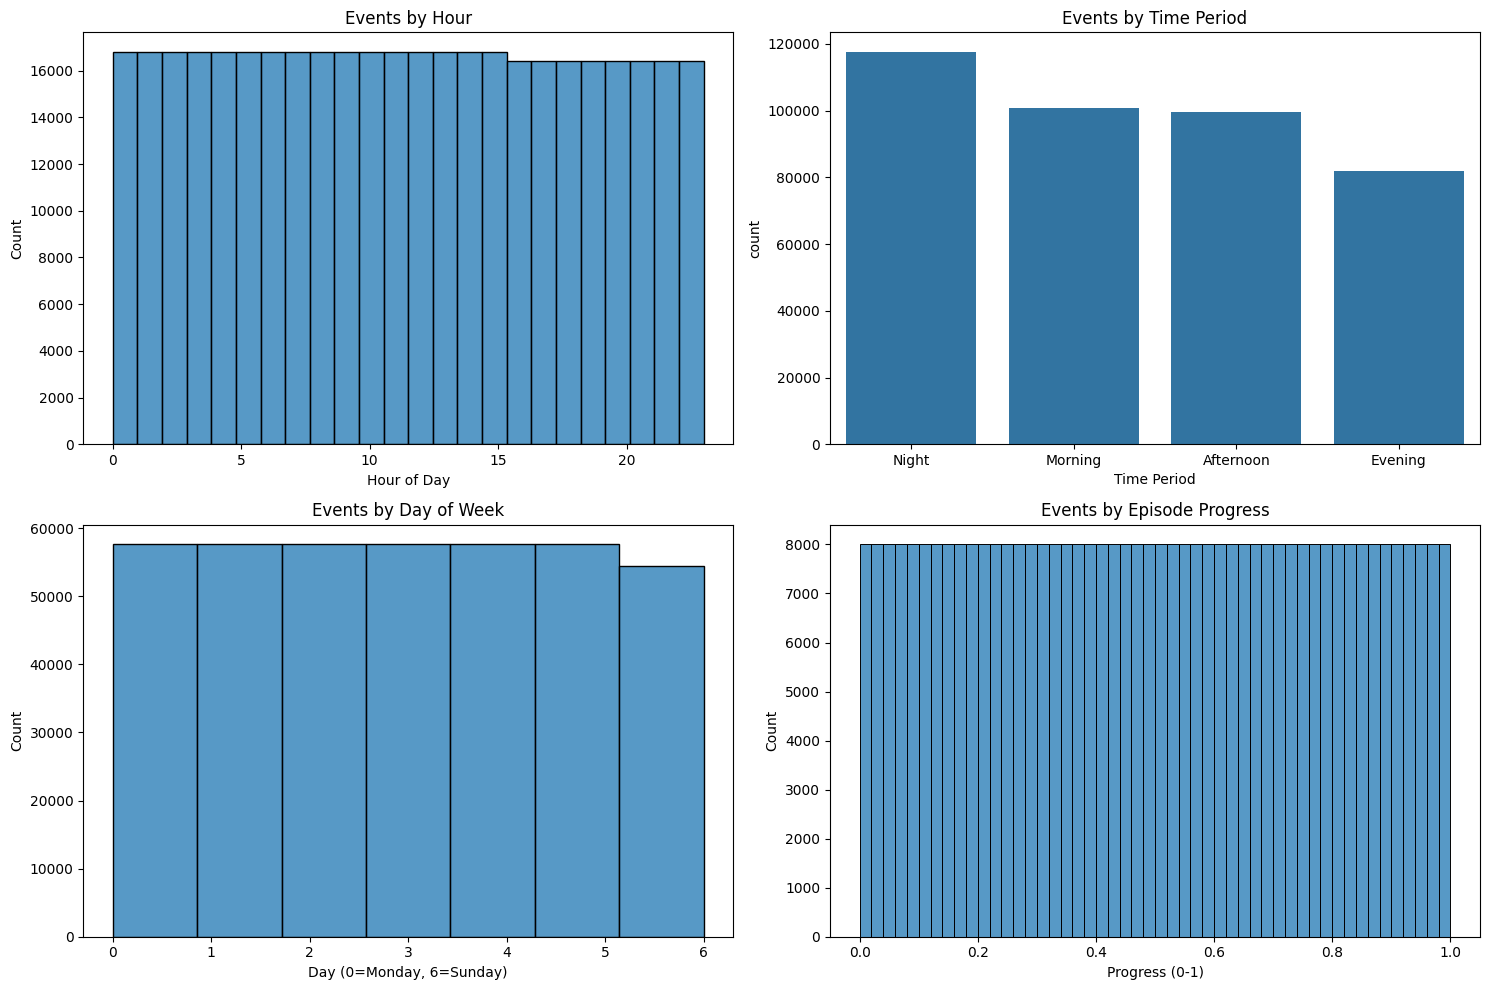

In [14]:
# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Hour distribution
sns.histplot(data=data, x='hour', bins=24, ax=axes[0,0])
axes[0,0].set_title('Events by Hour')
axes[0,0].set_xlabel('Hour of Day')

# Time of day distribution
time_counts = data['time_of_day'].value_counts().reset_index()
time_counts.columns = ['period', 'count']  # Rename columns
sns.barplot(data=time_counts, x='period', y='count', ax=axes[0,1])
axes[0,1].set_title('Events by Time Period')
axes[0,1].set_xlabel('Time Period')

# Day of week distribution
sns.histplot(data=data, x='day_of_week', bins=7, ax=axes[1,0])
axes[1,0].set_title('Events by Day of Week')
axes[1,0].set_xlabel('Day (0=Monday, 6=Sunday)')

# Progress distribution
sns.histplot(data=data, x='progress', bins=50, ax=axes[1,1])
axes[1,1].set_title('Events by Episode Progress')
axes[1,1].set_xlabel('Progress (0-1)')

plt.tight_layout()
plt.show()

## 3. Spatial Feature Engineering
Generate features based on location and spatial relationships.

In [16]:
def create_spatial_features(df):
    """Create spatial features from location data."""
    # Convert position list to separate x, y columns - vectorized
    positions = np.array(df['position'].tolist())
    df['x'] = positions[:, 0]
    df['y'] = positions[:, 1]
    
    # Calculate distance from city center vectorized
    center_x, center_y = 50, 50
    df['dist_from_center'] = np.sqrt(
        (df['x'] - center_x)**2 + (df['y'] - center_y)**2
    )
    
    # Create grid cells (10x10 grid = 100 cells)
    df['grid_x'] = df['x'] // 10
    df['grid_y'] = df['y'] // 10
    df['grid_id'] = df['grid_x'] * 10 + df['grid_y']
    
    # Count nearby agents - this operation is necessary
    df['num_nearby'] = df['nearby_agents'].str.len()
    
    # Calculate spatial density efficiently
    grid_counts = df['grid_id'].value_counts().reset_index()
    grid_counts.columns = ['grid_id', 'events_in_grid']
    df = df.merge(grid_counts, on='grid_id', how='left')
    
    # Calculate relative density vectorized
    df['event_density'] = df['events_in_grid'] / df['events_in_grid'].mean()
    
    # Risk score statistics per grid - vectorized where possible
    grid_risks = df.groupby('grid_id')['risk_score'].agg(['mean', 'std']).reset_index()
    df = df.merge(grid_risks, on='grid_id', how='left')
    df = df.rename(columns={'mean': 'grid_risk_mean', 'std': 'grid_risk_std'})
    
    # Distance to nearest high-risk area - vectorized calculation
    high_risk_grids = grid_risks[grid_risks['mean'] > grid_risks['mean'].mean()]
    if len(high_risk_grids) > 0:
        # Create grid center coordinates for high-risk areas
        high_risk_x = (high_risk_grids['grid_id'] // 10).values
        high_risk_y = (high_risk_grids['grid_id'] % 10).values
        
        # Calculate distances to all high-risk grids at once
        current_x = df['grid_x'].values[:, None]  # Shape (n_points, 1)
        current_y = df['grid_y'].values[:, None]  # Shape (n_points, 1)
        
        # Broadcasting to compute all distances at once
        distances = np.sqrt(
            (current_x - high_risk_x)**2 + 
            (current_y - high_risk_y)**2
        )
        
        # Get minimum distance for each point
        df['dist_to_high_risk'] = distances.min(axis=1)
    else:
        df['dist_to_high_risk'] = np.nan
    
    # Clean up intermediate columns
    df = df.drop(['grid_x', 'grid_y'], axis=1)
    
    return df

# Apply spatial features
data = create_spatial_features(data)

# Display sample results
print("\nSpatial Feature Examples:")
print(data[['x', 'y', 'grid_id', 'dist_from_center', 'num_nearby', 
            'event_density', 'grid_risk_mean', 'grid_risk_std', 
            'dist_to_high_risk']].head())


Spatial Feature Examples:
    x   y  grid_id  dist_from_center  num_nearby  event_density  \
0  82   3       80         56.859476           2       1.120567   
1  29  89       28         44.294469           2       1.280335   
2  21  21       22         41.012193           0       1.152666   
3  99  10       91         63.253458           2       1.062690   
4  85  54       85         35.227830           0       1.114974   

   grid_risk_mean  grid_risk_std  dist_to_high_risk  
0        0.171493       0.175683                0.0  
1        0.204327       0.168765                0.0  
2        0.147368       0.139200                0.0  
3        0.153526       0.158672                0.0  
4        0.144216       0.136527                0.0  


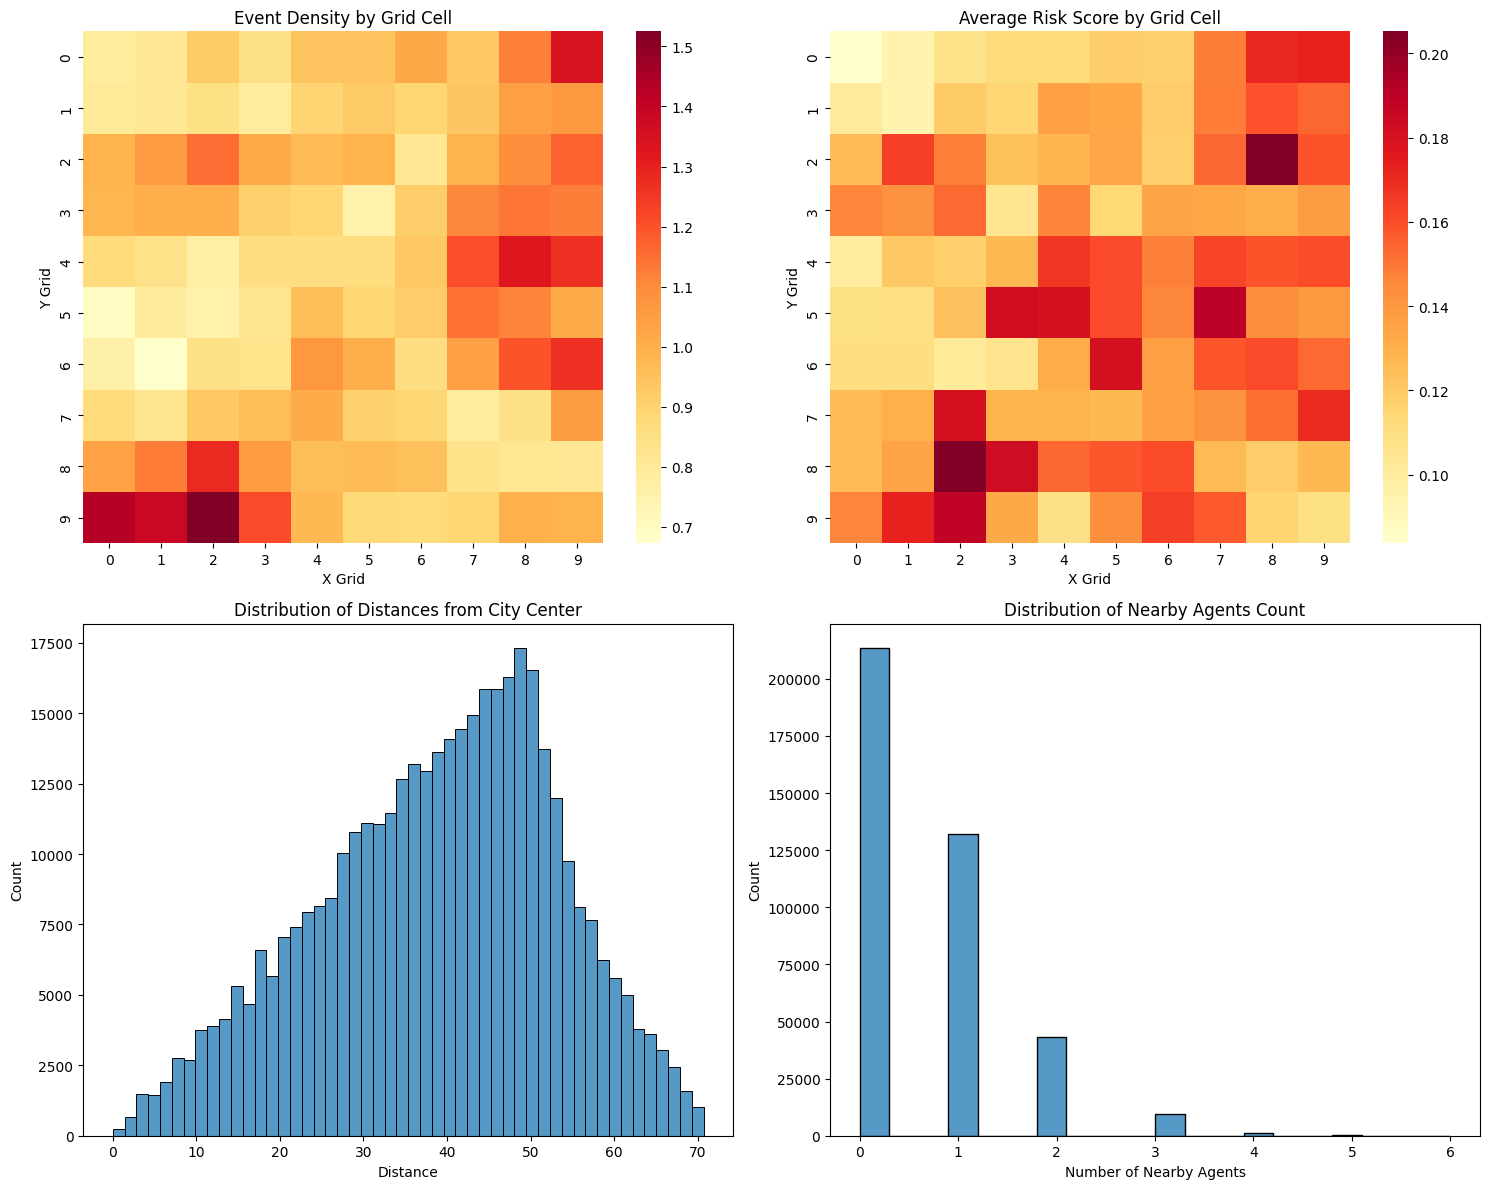

In [17]:
# Visualize spatial patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Event density heatmap
pivot_density = data.pivot_table(
    values='event_density', 
    index=data['y'].astype(int) // 10,
    columns=data['x'].astype(int) // 10,
    aggfunc='mean'
)
sns.heatmap(pivot_density, ax=axes[0,0], cmap='YlOrRd')
axes[0,0].set_title('Event Density by Grid Cell')
axes[0,0].set_xlabel('X Grid')
axes[0,0].set_ylabel('Y Grid')

# Risk score heatmap
pivot_risk = data.pivot_table(
    values='risk_score',
    index=data['y'].astype(int) // 10,
    columns=data['x'].astype(int) // 10,
    aggfunc='mean'
)
sns.heatmap(pivot_risk, ax=axes[0,1], cmap='YlOrRd')
axes[0,1].set_title('Average Risk Score by Grid Cell')
axes[0,1].set_xlabel('X Grid')
axes[0,1].set_ylabel('Y Grid')

# Distance from center distribution
sns.histplot(data=data, x='dist_from_center', bins=50, ax=axes[1,0])
axes[1,0].set_title('Distribution of Distances from City Center')
axes[1,0].set_xlabel('Distance')

# Number of nearby agents distribution
sns.histplot(data=data, x='num_nearby', bins=20, ax=axes[1,1])
axes[1,1].set_title('Distribution of Nearby Agents Count')
axes[1,1].set_xlabel('Number of Nearby Agents')

plt.tight_layout()
plt.show()

## 4. Agent Feature Engineering
Create features based on agent behaviors and interactions.

In [18]:
def create_agent_features(df):
    """Create agent-based features."""
    # Calculate agent type ratios per grid
    agent_counts = df.groupby(['grid_id', 'agent_type']).size().unstack(fill_value=0)
    agent_counts.columns = [f'n_{col}' for col in agent_counts.columns]
    
    # Calculate key ratios
    agent_counts['offender_target_ratio'] = agent_counts['n_offender'] / (agent_counts['n_target'] + 1)  # Add 1 to avoid div by 0
    agent_counts['guardian_presence'] = agent_counts['n_guardian'] / (agent_counts['n_offender'] + agent_counts['n_target'] + 1)
    
    # Merge ratios back to main dataframe
    df = df.merge(agent_counts, on='grid_id', how='left')
    
    # Action success rates by agent type
    def get_success_rate(group):
        total_actions = len(group)
        if total_actions == 0:
            return 0
        successful = sum(group['action_result'].str.contains('success|succeeded|successful', case=False, na=False))
        return successful / total_actions
    
    success_rates = df.groupby(['grid_id', 'agent_type']).apply(get_success_rate).unstack(fill_value=0)
    success_rates.columns = [f'{col}_success_rate' for col in success_rates.columns]
    df = df.merge(success_rates, on='grid_id', how='left')
    
    # Agent reputation statistics
    rep_stats = df.groupby(['grid_id', 'agent_type'])['reputation'].agg(['mean', 'std']).unstack()
    rep_stats.columns = [f'{col[1]}_{col[0]}_reputation' for col in rep_stats.columns]
    df = df.merge(rep_stats, on='grid_id', how='left')
    
    # Agent interaction features
    df['has_guardian_nearby'] = df['nearby_agents'].apply(lambda x: any('guardian' in agent for agent in x))
    df['n_offenders_nearby'] = df['nearby_agents'].apply(lambda x: sum('offender' in agent for agent in x))
    df['n_targets_nearby'] = df['nearby_agents'].apply(lambda x: sum('target' in agent for agent in x))
    
    # Action type proportions
    action_props = pd.get_dummies(df['action'], prefix='action').groupby(df['grid_id']).mean()
    df = df.merge(action_props, on='grid_id', how='left')
    
    return df

# Apply agent features
data = create_agent_features(data)

# Display sample results
print("\nAgent Feature Examples:")
agent_cols = [col for col in data.columns if any(x in col for x in ['offender', 'guardian', 'target', 'action_', 'success'])]
print(data[agent_cols].head())



C:\Users\Benja\AppData\Local\Temp\ipykernel_36808\4130194117.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_rates = df.groupby(['grid_id', 'agent_type']).apply(get_success_rate).unstack(fill_value=0)



Agent Feature Examples:
  action_result  n_guardian  n_offender  n_target  offender_target_ratio  \
0         moved         661        1081      2866               0.377049   
1         moved        1156        1676      2433               0.688578   
2         moved         475        1730      2535               0.682177   
3         moved         497        1214      2659               0.456391   
4           hid         509        1027      3049               0.336721   

   guardian_presence  guardian_success_rate  offender_success_rate  \
0           0.167427                    0.0               0.000925   
1           0.281265                    0.0               0.000000   
2           0.111346                    0.0               0.000578   
3           0.128291                    0.0               0.000000   
4           0.124847                    0.0               0.000000   

   target_success_rate  guardian_mean_reputation  ...  n_offenders_nearby  \
0                  0

C:\Users\Benja\AppData\Local\Temp\ipykernel_36808\3492056949.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)


TypeError: Could not convert ['movedmovedmovedmovedhidmovedmovedhidmovedmovedhidfailed_assaultmovedmovedmovedhidmovedmovedmovedmovedevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestmovedmovedmovedhidhidhidmovedmovedhidmovedmovedhidhidhidhidmovedhidhidhidmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledhidmovedhidfailed_assaulthidhidmovedhidhidmovedhidhidhidhidhidmovedmovedmovedmovedhidevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arresthidmovedhidmovedhidhidmovedmovedmovedmovedmovedfailed_assaulthidhidmovedmovedmovedhidmovedfailed_assaultevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedsuccessful_arrestinvestigatedpatrolledfailed_arrestmovedfailed_assaultmovedmovedhidmovedmovedmovedhidmovedfailed_assaultmovedmovedmovedhidmovedhidfailed_assaultmovedfailed_assaultevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledhidmovedhidhidmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidhidhidmovedfailed_assaulthidfailed_assaultevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arresthidhidhidhidmovedhidmovedmovedhidmovedhidmovedhidhidmovedmovedmovedmovedmovedfailed_assaultevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedmovedhidmovedhidhidhidmovedhidhidmovedmovedmovedmovedmovedmovedmovedhidhidmovedhidsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arresthidhidmovedhidmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedmovedmovedmovedmovedhidhidmovedhidevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledsuccessful_arrestpatrolledhidmovedmovedmovedhidmovedhidmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedfailed_assaulthidmovedevadedevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestmovedmovedhidhidhidmovedhidhidhidfailed_assaultfailed_assaulthidmovedmovedhidmovedmovedhidhidfailed_assaultsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedhidfailed_assaulthidmovedmovedmovedmovedhidhidmovedmovedhidmovedmovedmovedmovedhidhidfailed_assaultmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arresthidfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidhidhidfailed_assaulthidhidmovedhidmovedhidfailed_assaultmovedfailed_assaultevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedmovedfailed_assaultfailed_assaultmovedmovedhidmovedhidmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedhidmovedhidfailed_assaultevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arresthidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidhidfailed_assaulthidfailed_assaulthidmovedsuccessful_assaultmovedmovedmovedfailed_assaultevadedevadedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedevadedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedhidhidhidmovedmovedhidhidmovedmovedfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedhidhidfailed_assaultmovedmovedfailed_assaultmovedhidevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedsuccessful_arrestfailed_assaultmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidhidhidmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidhidhidhidfailed_assaulthidmovedmovedhidevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedhidfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidhidhidfailed_assaulthidsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedhidmovedmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidmovedmovedhidmovedhidhidhidmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidhidmovedhidhidhidmovedmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidhidmovedhidfailed_assaulthidmovedhidfailed_assaultevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helppatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaulthidfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultmovedhidhidhidmovedmovedmovedhidhidhidmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidhidevadedevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsuccessful_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedmovedhidmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedhidmovedhidhidmovedmovedmovedhidsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedpatrolledfailed_arrestpatrolledsuccessful_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestmovedmovedmovedmovedhidfailed_assaultmovedmovedmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedhidmovedfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helppatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestsuccessful_arrestinvestigatedhidmovedmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaulthidmovedhidfailed_assaultsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arresthidmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedhidmovedmovedmovedfailed_assaultsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedevadedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedhidmovedhidmovedhidhidhidfailed_assaulthidmovedhidmovedhidmovedmovedfailed_assaultmovedmovedmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaulthidhidmovedfailed_assaultmovedmovedhidmovedhidmovedmovedhidhidhidhidmovedhidfailed_assaulthidsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledsuccessful_arrestpatrolledinvestigatedfailed_arrestfailed_assaultmovedhidhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedhidhidhidhidevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaulthidmovedmovedmovedmovedmovedhidevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedmovedhidmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedmovedhidhidhidhidfailed_assaultevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestmovedmovedhidhidmovedhidhidmovedhidmovedmovedhidmovedhidmovedfailed_assaulthidmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedhidfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedmovedevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedmovedfailed_assaulthidhidhidmovedfailed_assaultmovedhidmovedmovedmovedmovedmovedhidmovedhidhidhidmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedmovedhidhidhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedhidhidmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedsuccessful_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedhidfailed_assaultmovedhidmovedmovedhidmovedfailed_assaulthidmovedmovedhidhidfailed_assaulthidhidmovedmovedhidevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedhidfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaulthidhidmovedhidfailed_assaultfailed_assaulthidhidmovedhidmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helppatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidmovedfailed_assaulthidhidfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultevadedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arresthidhidhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedhidhidmovedfailed_assaultsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helppatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestmovedhidhidfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedevadedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedmovedhidhidmovedhidhidmovedfailed_assaulthidhidhidmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaulthidmovedhidhidmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedhidmovedhidhidhidfailed_assaultmovedfailed_assaulthidmovedhidevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultevadedevadedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledmovedhidmovedhidhidmovedhidmovedhidmovedmovedmovedfailed_assaulthidfailed_assaulthidmovedhidmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidfailed_assaulthidhidmovedmovedhidhidfailed_assaultmovedhidmovedhidhidmovedmovedhidhidmovedfailed_assaultevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helppatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedmovedhidhidfailed_assaultfailed_assaultmovedhidhidhidhidhidmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidmovedhidhidhidmovedhidhidfailed_assaulthidevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidhidmovedfailed_assaultmovedmovedmovedhidmovedhidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestmovedmovedhidmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaulthidhidevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedmovedhidmovedmovedhidhidmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helppatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidhidmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedevadedsought_helpfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestmovedhidmovedhidhidmovedhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaulthidhidevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaultmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultmovedhidmovedmovedhidhidfailed_assaultmovedmovedmovedhidmovedhidmovedfailed_assaulthidhidevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helppatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledmovedhidhidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledmovedhidmovedmovedfailed_assaultmovedfailed_assaulthidhidmovedhidmovedhidmovedmovedhidhidhidhidmovedsought_helpevadedevadedmovedevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedmovedmovedfailed_assaulthidhidmovedmovedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledmovedmovedfailed_assaultmovedhidmovedmovedhidfailed_assaultmovedfailed_assaulthidhidmovedhidhidhidhidmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arresthidfailed_assaultfailed_assaulthidmovedhidhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedhidsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedmovedhidmovedhidmovedhidmovedfailed_assaultmovedfailed_assaultevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidhidhidfailed_assaultmovedmovedhidmovedmovedmovedfailed_assaultevadedevadedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestsuccessful_arrestpatrolledfailed_arrestfailed_arresthidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedhidfailed_assaultmovedhidmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultmovedmovedhidhidhidmovedhidfailed_assaultsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helppatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedhidhidhidmovedfailed_assaultmovedhidhidhidhidhidmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedevadedevadedmovedevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultmovedmovedmovedhidmovedhidmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidmovedmovedmovedmovedmovedmovedhidmovedmovedhidmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helppatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedhidmovedhidsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arresthidfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedmovedhidmovedmovedmovedhidhidhidhidmovedmovedhidsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaulthidhidhidfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidhidhidhidmovedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestmovedmovedmovedhidhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedhidfailed_assaultmovedhidmovedmovedfailed_assaulthidhidhidmovedmovedmovedhidhidmovedhidmovedhidmovedsought_helpevadedsought_helpmovedevadedevadedevadedevadedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedmovedmovedmovedhidhidfailed_assaultmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidhidfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helppatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledhidhidmovedmovedhidmovedhidmovedmovedmovedmovedmovedhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedhidhidhidmovedfailed_assaulthidhidhidhidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helppatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedhidmovedhidhidhidfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestmovedhidmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaulthidmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedevadedevadedsought_helpsought_helpevadedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidhidmovedhidhidfailed_assaultmovedhidhidevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidhidhidfailed_assaultfailed_assaulthidhidmovedhidsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedmovedhidfailed_assaultfailed_assaulthidmovedmovedhidmovedhidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedmovedmovedfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedhidhidhidsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaulthidhidhidhidfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedfailed_assaulthidmovedmovedhidhidmovedmovedhidmovedfailed_assaultmovedevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedmovedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arresthidhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedhidmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedmovedmovedfailed_assaulthidfailed_assaulthidhidmovedhidhidhidhidhidhidhidfailed_assaultfailed_assaulthidmovedhidevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedsought_helppatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedmovedhidfailed_assaultmovedhidmovedmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arresthidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultmovedmovedmovedfailed_assaulthidhidsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidhidhidhidmovedfailed_assaulthidmovedhidmovedmovedmovedhidevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arresthidhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultmovedmovedhidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedmovedhidevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedevadedevadedevadedmovedevadedevadedevadedmovedsought_helpevadedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidmovedmovedmovedhidmovedmovedfailed_assaulthidevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_assaultmovedmovedfailed_assaultmovedmovedmovedhidmovedmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arresthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedfailed_assaulthidsought_helpevadedsought_helpmovedevadedevadedevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedhidmovedfailed_assaultmovedhidmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidevadedevadedevadedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedevadedevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedmovedhidsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedmovedhidhidmovedmovedhidmovedhidmovedmovedfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedmovedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedmovedmovedfailed_assaulthidfailed_assaulthidhidmovedhidmovedfailed_assaultfailed_assaulthidhidmovedhidhidfailed_assaultevadedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedevadedmovedevadedevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedevadedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestmovedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedhidhidmovedfailed_assaultevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_assaulthidfailed_assaulthidhidmovedhidhidmovedhidmovedhidmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedevadedevadedevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedevadedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidhidmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaulthidsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helppatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaulthidhidhidhidhidfailed_assaultfailed_assaultmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedevadedevadedmovedevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arresthidmovedmovedmovedmovedmovedhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedhidhidmovedmovedmovedhidfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidmovedhidmovedsought_helpevadedevadedmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedhidfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedsought_helpevadedevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidfailed_assaultmovedhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultmovedhidhidevadedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedhidfailed_assaulthidfailed_assaultmovedhidhidmovedhidfailed_assaulthidhidmovedmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedmovedmovedhidmovedhidfailed_assaulthidmovedhidhidfailed_assaulthidmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedmovedfailed_assaulthidhidmovedmovedmovedhidmovedfailed_assaulthidhidhidhidmovedhidhidmovedmovedhidsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helppatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidmovedmovedmovedmovedmovedhidmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helppatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidhidhidhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_assaulthidmovedhidmovedmovedhidmovedmovedhidhidfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaulthidsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultmovedhidhidmovedfailed_assaultmovedhidhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedmovedhidfailed_assaulthidhidhidmovedmovedfailed_assaultsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidhidfailed_assaulthidfailed_assaulthidhidhidhidfailed_assaultfailed_assaultmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidhidsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedmovedmovedmovedfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidevadedevadedevadedmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaultmovedhidhidmovedfailed_assaulthidhidmovedhidmovedmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidfailed_assaultevadedsought_helpmovedsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedevadedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaulthidfailed_assaultmovedmovedhidmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaultevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestmovedmovedfailed_assaulthidhidhidmovedhidfailed_assaultmovedmovedfailed_assaulthidmovedhidhidhidfailed_assaulthidhidmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidhidhidmovedmovedhidfailed_assaultmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arresthidmovedfailed_assaultmovedhidhidhidhidmovedhidmovedhidmovedhidhidhidfailed_assaulthidmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedevadedevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedmovedhidmovedfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedevadedmovedevadedevadedevadedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidmovedhidhidhidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledhidhidmovedmovedfailed_assaultmovedhidmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidmovedhidhidfailed_assaultfailed_assaultmovedhidmovedmovedmovedhidhidmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledhidhidmovedmovedmovedmovedhidhidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedevadedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledhidhidhidhidmovedmovedmovedmovedmovedhidhidhidhidmovedhidfailed_assaultfailed_assaulthidmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedevadedmovedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arresthidfailed_assaultmovedfailed_assaulthidmovedmovedmovedhidhidhidfailed_assaultfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaultmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedhidmovedfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidfailed_assaulthidfailed_assaulthidsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestmovedmovedfailed_assaultmovedfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaulthidmovedmovedhidhidmovedmovedhidmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helppatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidhidfailed_assaultmovedfailed_assaultmovedmovedmovedhidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultevadedmovedmovedevadedmovedevadedevadedevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedevadedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arresthidfailed_assaulthidmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidhidhidfailed_assaultsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedhidmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedmovedhidfailed_assaulthidmovedhidhidhidmovedfailed_assaultmovedhidhidmovedhidhidmovedmovedhidhidevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedhidmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helppatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidmovedfailed_assaultmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaulthidhidhidmovedhidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedhidhidmovedhidmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpevadedmovedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidmovedhidhidhidfailed_assaultmovedmovedmovedmovedhidhidfailed_assaultmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpevadedmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedhidmovedmovedhidhidhidfailed_assaultfailed_assaultsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedhidmovedfailed_assaulthidfailed_assaultmovedhidhidmovedhidmovedmovedhidhidhidhidhidfailed_assaultmovedhidsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedhidmovedmovedhidhidmovedhidevadedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helppatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledmovedmovedmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedhidmovedhidsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedevadedevadedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaultmovedmovedmovedmovedhidfailed_assaulthidhidmovedfailed_assaultmovedhidmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledhidhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedhidmovedfailed_assaultmovedmovedhidmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedhidhidhidmovedmovedhidevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledmovedhidfailed_assaulthidmovedhidhidmovedhidmovedfailed_assaulthidhidhidfailed_assaulthidmovedmovedfailed_assaultmovedmovedsought_helpevadedevadedsought_helpevadedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedsought_helpevadedevadedevadedevadedmovedmovedevadedevadedsought_helpevadedevadedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedmovedfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaulthidsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedhidmovedhidmovedhidhidfailed_assaulthidfailed_assaultfailed_assaulthidhidevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_assaulthidhidhidhidfailed_assaultmovedmovedhidmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidhidmovedmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaulthidhidmovedfailed_assaulthidmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidhidfailed_assaulthidmovedhidmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedmovedmovedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helppatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestmovedfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidhidfailed_assaulthidmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedevadedevadedevadedmovedevadedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arresthidmovedhidhidhidhidmovedhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidhidhidhidfailed_assaultmovedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedhidhidhidmovedmovedmovedfailed_assaultmovedmovedmovedhidhidfailed_assaultfailed_assaulthidmovedmovedhidhidhidevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedhidhidmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidhidmovedfailed_assaulthidmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedevadedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidhidhidhidmovedhidhidfailed_assaultmovedfailed_assaulthidmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestmovedfailed_assaulthidhidhidhidfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpevadedpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidfailed_assaulthidhidmovedhidfailed_assaulthidmovedhidevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedsought_helpevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedhidhidmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arresthidfailed_assaultfailed_assaulthidhidhidhidmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helppatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedhidfailed_assaultmovedhidmovedhidhidhidhidhidhidhidfailed_assaultmovedhidfailed_assaulthidhidmovedfailed_assaultevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedmovedhidhidfailed_assaulthidhidhidfailed_assaultmovedmovedmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedevadedevadedsought_helpmovedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedmovedmovedevadedevadedevadedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arresthidhidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaulthidmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaulthidhidhidhidmovedhidfailed_assaultmovedfailed_assaultmovedhidmovedmovedhidmovedmovedfailed_assaulthidhidmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedhidfailed_assaulthidmovedhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedevadedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidhidhidmovedhidhidmovedmovedmovedfailed_assaulthidhidhidmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidhidfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidevadedevadedevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultmovedhidmovedhidhidmovedmovedfailed_assaultmovedmovedhidhidhidevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedmovedfailed_assaultmovedmovedmovedmovedmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedmovedmovedmovedhidhidfailed_assaultmovedevadedevadedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arresthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedmovedevadedmovedevadedmovedmovedevadedevadedevadedmovedmovedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidhidmovedfailed_assaulthidmovedhidfailed_assaulthidmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaulthidhidmovedhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedevadedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultmovedhidhidhidhidmovedmovedhidhidmovedmovedmovedhidhidhidfailed_assaultfailed_assaulthidhidsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedevadedevadedsought_helpevadedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledhidfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidhidmovedmovedhidhidfailed_assaultmovedfailed_assaultmovedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedhidfailed_assaulthidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedmovedmovedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaultmovedhidsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedevadedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedevadedevadedmovedevadedsought_helpmovedmovedsought_helpmovedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedmovedevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaulthidmovedfailed_assaultmovedhidhidhidhidhidsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedmovedmovedsought_helpevadedmovedevadedevadedmovedevadedmovedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arresthidfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidmovedhidmovedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidhidhidhidhidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedevadedmovedevadedmovedevadedevadedmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidhidhidmovedhidfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidhidhidfailed_assaultfailed_assaulthidmovedmovedhidmovedsought_helpevadedmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_assaulthidhidhidhidfailed_assaulthidmovedmovedfailed_assaulthidmovedhidhidhidfailed_assaultmovedmovedhidfailed_assaultevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arresthidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidhidhidhidfailed_assaultmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaultmovedmovedhidhidhidmovedfailed_assaultmovedhidhidmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedhidsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedmovedsought_helpmovedmovedevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedmovedmovedevadedmovedevadedmovedmovedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedmovedmovedmovedfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidhidmovedfailed_assaultsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedevadedmovedmovedsought_helpmovedevadedmovedmovedsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultmovedmovedmovedhidhidmovedfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedevadedsought_helpmovedevadedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helppatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedhidmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedmovedmovedmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaulthidmovedhidhidmovedhidhidfailed_assaultevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultmovedhidhidhidhidfailed_assaulthidmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedhidhidfailed_assaultmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedmovedevadedmovedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedmovedhidhidmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidhidhidmovedhidmovedfailed_assaultmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedevadedmovedevadedevadedmovedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedhidmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedmovedevadedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedhidhidmovedhidhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidhidsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedevadedevadedsought_helpevadedmovedevadedsought_helpevadedmovedevadedevadedevadedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaulthidhidhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultevadedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedevadedevadedevadedmovedmovedmovedevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedhidhidhidhidmovedfailed_assaulthidfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestmovedfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedevadedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaulthidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedhidhidhidhidfailed_assaulthidhidfailed_assaultmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidhidmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaulthidhidhidfailed_assaulthidmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arresthidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpmovedevadedevadedevadedevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedmovedevadedmovedevadedmovedmovedmovedmovedsought_helpmovedevadedevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedhidmovedevadedsought_helpevadedevadedevadedevadedevadedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedmovedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidmovedmovedhidfailed_assaulthidmovedhidhidfailed_assaultmovedhidhidmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpevadedevadedevadedevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidmovedmovedmovedmovedhidhidmovedmovedhidhidhidmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedevadedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidevadedmovedevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedmovedfailed_assaultmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedevadedevadedevadedmovedevadedevadedmovedevadedevadedmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidhidhidmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpevadedmovedevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedmovedfailed_assaultfailed_assaultmovedmovedhidhidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_assaulthidmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedmovedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedevadedmovedsought_helpmovedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arresthidhidhidmovedhidfailed_assaultmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedhidhidhidhidhidsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedevadedmovedevadedsought_helpmovedmovedevadedevadedmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedmovedmovedevadedevadedinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedevadedsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaulthidhidfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultmovedhidmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedevadedevadedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedsought_helpevadedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidhidmovedmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedevadedmovedsought_helpmovedevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedmovedmovedevadedevadedevadedevadedmovedevadedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedhidevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaulthidhidmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedhidevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedevadedevadedsought_helpevadedevadedsought_helpevadedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedevadedsought_helpmovedmovedevadedmovedmovedmovedevadedevadedmovedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedevadedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedmovedfailed_assaultfailed_assaulthidmovedmovedmovedmovedmovedhidmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedmovedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestmovedmovedfailed_assaultmovedmovedmovedhidhidfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidhidmovedmovedfailed_assaultevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedevadedmovedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedmovedfailed_assaulthidmovedhidmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedfailed_assaulthidfailed_assaultevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpmovedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultmovedhidmovedmovedhidmovedmovedmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedevadedevadedevadedevadedmovedevadedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedevadedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedhidfailed_assaulthidmovedhidmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpevadedsought_helpevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaulthidmovedmovedmovedhidhidfailed_assaultmovedhidmovedmovedmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaulthidhidhidmovedhidhidfailed_assaultfailed_assaultmovedhidmovedhidhidfailed_assaulthidhidmovedmovedevadedmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helppatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedmovedmovedfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultmovedevadedmovedsought_helpmovedmovedevadedmovedmovedevadedevadedmovedevadedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedmovedevadedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestmovedhidmovedmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpmovedsought_helpevadedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaulthidfailed_assaulthidhidhidmovedhidfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedevadedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arresthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidhidmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedmovedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidhidmovedmovedfailed_assaultfailed_assaultmovedmovedhidhidhidmovedmovedfailed_assaulthidhidmovedhidhidhidsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedhidhidfailed_assaultmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedevadedsought_helpevadedmovedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpmovedevadedevadedmovedevadedmovedevadedsought_helpevadedmovedmovedevadedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedmovedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helppatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedhidhidhidhidfailed_assaulthidmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedmovedevadedevadedevadedevadedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedevadedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedmovedevadedevadedsought_helpmovedmovedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arresthidfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedevadedmovedevadedsought_helpevadedsought_helpevadedevadedevadedmovedevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedevadedsought_helpevadedmovedsought_helpinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedhidfailed_assaulthidfailed_assaulthidhidhidmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedevadedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidevadedevadedsought_helpmovedmovedevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedmovedevadedsought_helpmovedevadedevadedevadedmovedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedhidhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedhidmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedmovedmovedevadedsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedhidmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedmovedhidhidhidhidhidmovedhidfailed_assaultsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helppatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedsought_helpevadedevadedevadedevadedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedmovedevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedmovedevadedmovedmovedevadedevadedsought_helpsought_helpmovedmovedevadedevadedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_assaulthidhidfailed_assaultmovedmovedmovedhidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedmovedfailed_assaulthidhidsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedmovedhidfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedevadedevadedmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaulthidhidhidfailed_assaultmovedhidmovedmovedmovedsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedevadedevadedmovedsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedmovedmovedmovedmovedsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedmovedhidmovedmovedhidhidmovedfailed_assaultfailed_assaultevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedhidhidhidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedevadedsought_helpevadedmovedevadedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidmovedfailed_assaultmovedhidfailed_assaulthidhidmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedevadedevadedevadedsought_helpmovedevadedevadedmovedsought_helpmovedmovedevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedfailed_assaultevadedsought_helpevadedmovedsought_helpevadedmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpevadedevadedmovedevadedmovedevadedevadedevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestmovedmovedfailed_assaultmovedhidmovedfailed_assaultmovedhidmovedmovedfailed_assaulthidmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedmovedevadedevadedmovedevadedevadedsought_helpmovedevadedmovedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidhidfailed_assaultmovedmovedmovedhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedmovedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arresthidmovedmovedhidmovedmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedmovedmovedmovedevadedevadedsought_helpmovedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedhidfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultmovedhidmovedhidfailed_assaulthidfailed_assaulthidhidmovedfailed_assaultfailed_assaultevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedsought_helpmovedevadedevadedmovedevadedevadedevadedevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedmovedmovedsought_helpfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledmovedfailed_assaulthidmovedmovedhidmovedfailed_assaulthidmovedhidhidhidfailed_assaultmovedmovedmovedhidmovedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpmovedmovedevadedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedmovedhidmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedmovedmovedhidfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedmovedhidfailed_assaulthidhidsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedevadedmovedevadedevadedevadedevadedmovedsought_helpmovedevadedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedhidhidhidfailed_assaulthidfailed_assaulthidmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpmovedmovedevadedmovedmovedevadedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaulthidmovedhidmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultevadedevadedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedmovedmovedevadedmovedsought_helpmovedmovedsought_helpevadedmovedevadedevadedmovedevadedsought_helpmovedevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedmovedhidmovedhidmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledmovedfailed_assaulthidfailed_assaulthidmovedhidmovedmovedmovedmovedhidhidhidfailed_assaultmovedhidhidmovedfailed_assaultsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedevadedevadedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultmovedmovedmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedmovedmovedmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arresthidhidhidhidmovedfailed_assaultfailed_assaulthidhidhidhidfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaultmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedmovedhidhidmovedhidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helppatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaulthidmovedhidfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedevadedevadedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedmovedmovedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedevadedevadedevadedevadedmovedmovedmovedsought_helpevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedevadedinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestmovedhidhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedhidhidhidhidfailed_assaulthidmovedfailed_assaultsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpevadedevadedmovedmovedmovedevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helppatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedhidmovedmovedmovedfailed_assaultmovedfailed_assaultmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedmovedmovedevadedevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arresthidfailed_assaulthidhidmovedmovedmovedhidfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidhidmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidevadedsought_helpevadedmovedsought_helpmovedevadedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedevadedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helppatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultmovedmovedhidhidmovedhidhidhidhidmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedmovedevadedevadedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedmovedfailed_assaulthidhidfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpmovedevadedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaulthidfailed_assaulthidhidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedmovedevadedevadedevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arresthidmovedmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpevadedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arresthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedhidhidmovedhidfailed_assaultsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedmovedsought_helpmovedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedmovedevadedevadedmovedmovedevadedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaultmovedmovedmovedhidhidmovedhidmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedmovedmovedevadedevadedmovedmovedsought_helpmovedevadedmovedmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedmovedevadedmovedevadedmovedevadedevadedevadedevadedsought_helpmovedevadedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedhidhidfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedevadedevadedsought_helpmovedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedhidmovedfailed_assaultmovedhidhidhidmovedhidhidmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helpevadedmovedevadedmovedmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultmovedhidhidmovedhidmovedmovedhidhidhidmovedfailed_assaultmovedmovedhidmovedmovedmovedhidmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpevadedmovedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidmovedhidhidmovedhidmovedhidhidmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_assaultmovedmovedhidmovedmovedhidmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultmovedhidhidmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arresthidmovedfailed_assaulthidmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidmovedmovedhidhidevadedmovedevadedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedevadedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaulthidhidfailed_assaultmovedmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedhidhidhidhidhidmovedfailed_assaultevadedevadedevadedsought_helpsought_helpmovedevadedevadedevadedevadedmovedmovedsought_helpevadedmovedevadedevadedmovedsought_helpmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedevadedmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaultmovedmovedmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaulthidmovedevadedmovedmovedevadedevadedsought_helpmovedevadedmovedmovedevadedsought_helpmovedmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultevadedevadedevadedsought_helpevadedevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedmovedmovedfailed_assaultfailed_assaultmovedmovedhidhidmovedmovedhidfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arresthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedmovedmovedmovedmovedmovedhidmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultevadedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedmovedfailed_assaulthidmovedfailed_assaultmovedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedmovedinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedhidmovedhidhidfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedhidhidhidfailed_assaulthidfailed_assaultmovedhidmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_assaulthidhidhidmovedhidhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaulthidmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedevadedevadedevadedevadedevadedevadedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedhidfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidmovedmovedmovedmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultevadedmovedmovedevadedsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledhidhidhidfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaulthidhidmovedmovedhidmovedfailed_assaultmovedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestmovedmovedhidmovedmovedmovedhidmovedfailed_assaultmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedmovedevadedmovedsought_helpevadedevadedsought_helpmovedevadedevadedevadedmovedevadedmovedmovedevadedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arresthidmovedfailed_assaultmovedmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedevadedevadedevadedevadedmovedmovedevadedmovedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidmovedmovedmovedmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedevadedevadedmovedsought_helpmovedmovedmovedevadedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arresthidmovedfailed_assaultmovedhidhidhidmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedmovedevadedevadedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedhidhidhidmovedmovedevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedmovedevadedevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultevadedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestmovedmovedmovedmovedmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultevadedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedevadedsought_helpmovedmovedevadedevadedmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedevadedevadedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedfailed_assaultmovedhidhidhidfailed_assaulthidmovedhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedevadedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultmovedmovedhidmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidhidfailed_assaulthidhidhidmovedhidsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedevadedevadedevadedmovedevadedevadedmovedevadedmovedevadedmovedmovedpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_assaulthidmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedhidmovedhidhidmovedhidmovedmovedfailed_assaultmovedevadedevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedhidhidmovedfailed_assaultmovedmovedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidhidfailed_assaultsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpsought_helpmovedmovedmovedmovedmovedmovedevadedevadedevadedmovedmovedevadedmovedevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultmovedhidfailed_assaulthidsought_helpmovedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedmovedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedmovedmovedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidhidhidmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultevadedmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedevadedmovedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidhidhidfailed_assaulthidfailed_assaulthidmovedhidhidhidhidevadedevadedevadedevadedmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpmovedmovedevadedevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledmovedmovedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arresthidmovedhidfailed_assaultfailed_assaulthidhidmovedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedmovedmovedhidfailed_assaulthidmovedhidmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedhidsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedhidhidhidhidhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedhidmovedfailed_assaultmovedmovedevadedmovedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedmovedevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedhidfailed_assaultmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedhidhidfailed_assaultevadedmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helppatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedmovedmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpevadedmovedevadedevadedevadedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedmovedmovedmovedmovedfailed_assaulthidhidmovedmovedmovedmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedevadedevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestmovedhidmovedhidmovedhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultmovedhidmovedmovedmovedmovedmovedsought_helpmovedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedmovedmovedmovedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultmovedhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedevadedmovedevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedevadedsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedmovedmovedhidfailed_assaulthidmovedmovedfailed_assaulthidmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedhidevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedevadedsought_helpmovedevadedevadedmovedmovedmovedsought_helpevadedmovedmovedevadedmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaulthidhidmovedhidhidhidmovedhidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedsought_helpevadedmovedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidmovedevadedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedevadedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedfailed_assaulthidhidfailed_assaulthidmovedfailed_assaulthidhidevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedevadedevadedevadedevadedevadedmovedmovedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedevadedevadedsought_helpmovedevadedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedhidhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedmovedmovedsought_helpmovedevadedevadedevadedmovedmovedevadedsought_helpmovedevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arresthidhidmovedfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedevadedevadedevadedmovedmovedevadedevadedsought_helpevadedmovedevadedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedmovedmovedsought_helpmovedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaultmovedhidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedevadedevadedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedmovedevadedmovedmovedevadedmovedmovedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedevadedevadedevadedmovedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arresthidmovedhidmovedmovedhidhidhidfailed_assaulthidhidmovedhidmovedhidmovedhidfailed_assaultfailed_assaultmovedevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedmovedmovedmovedevadedevadedmovedsought_helpmovedmovedevadedmovedmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidhidmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestmovedhidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedhidhidfailed_assaultmovedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedmovedhidfailed_assaulthidhidfailed_assaultmovedmovedhidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedmovedmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpmovedsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidmovedmovedmovedhidfailed_assaulthidmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledmovedmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedhidmovedmovedfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_assaulthidhidhidfailed_assaultmovedmovedmovedfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidsought_helpevadedsought_helpmovedmovedevadedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpmovedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arresthidmovedhidhidhidfailed_assaultmovedmovedhidfailed_assaultmovedmovedhidmovedhidfailed_assaultmovedmovedfailed_assaulthidsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedhidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultevadedevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedmovedmovedevadedevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaulthidhidmovedhidhidmovedmovedmovedfailed_assaulthidhidhidhidmovedhidfailed_assaultfailed_assaulthidmovedmovedmovedevadedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_assaulthidfailed_assaultmovedhidmovedhidhidmovedfailed_assaultmovedfailed_assaulthidmovedhidhidmovedhidmovedhidsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arresthidhidhidhidhidmovedfailed_assaultmovedhidmovedhidhidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultmovedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedmovedevadedmovedmovedmovedmovedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaulthidmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultmovedmovedhidevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledmovedfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidmovedmovedhidmovedhidsought_helpevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedmovedmovedmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpevadedmovedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arresthidmovedhidfailed_assaultmovedfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaultmovedhidhidevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedevadedevadedsought_helpsought_helpmovedmovedmovedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arresthidfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedevadedmovedevadedevadedmovedevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedmovedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arresthidfailed_assaultmovedmovedhidhidhidmovedfailed_assaulthidfailed_assaulthidhidhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpevadedevadedevadedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidhidhidhidmovedfailed_assaultmovedfailed_assaultsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedmovedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedevadedmovedevadedevadedsought_helpmovedevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpevadedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedhidmovedmovedfailed_assaultmovedmovedhidhidfailed_assaulthidfailed_assaultmovedhidhidhidhidmovedfailed_assaultmovedmovedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedmovedsought_helpmovedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedhidhidmovedmovedmovedmovedfailed_assaulthidhidhidhidhidfailed_assaulthidhidmovedmovedfailed_assaultmovedmovedsought_helpmovedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedevadedmovedevadedevadedmovedevadedevadedsought_helpevadedsought_helppatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arresthidfailed_assaultmovedhidfailed_assaulthidhidmovedmovedmovedmovedhidmovedfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultevadedevadedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helppatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestmovedmovedmovedhidfailed_assaultmovedhidmovedhidhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helppatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaulthidmovedhidhidhidhidmovedmovedhidmovedhidmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestmovedhidhidfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedmovedfailed_assaulthidmovedfailed_assaultevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedsought_helpmovedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedhidmovedfailed_assaulthidmovedhidhidhidmovedmovedmovedhidfailed_assaultmovedfailed_assaulthidhidhidhidfailed_assaultsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedhidhidmovedfailed_assaulthidhidmovedfailed_assaulthidhidhidhidsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedhidhidmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidmovedfailed_assaultmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedmovedhidhidevadedevadedevadedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedevadedevadedevadedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidhidmovedfailed_assaultmovedmovedhidhidmovedhidevadedevadedsought_helpmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedevadedevadedevadedevadedmovedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedhidhidhidmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedmovedevadedevadedmovedmovedevadedmovedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestmovedhidmovedhidhidfailed_assaultmovedhidfailed_assaulthidhidmovedmovedfailed_assaulthidhidhidmovedmovedhidmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedmovedevadedmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedevadedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedmovedmovedevadedmovedsought_helpmovedevadedevadedmovedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidhidmovedfailed_assaulthidfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedmovedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedmovedhidhidhidhidmovedmovedfailed_assaulthidfailed_assaultmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultevadedevadedsought_helpevadedevadedevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpmovedmovedmovedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedhidmovedfailed_assaultmovedmovedfailed_assaulthidmovedmovedhidmovedmovedhidfailed_assaulthidfailed_assaultmovedhidmovedmovedevadedsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedmovedevadedmovedmovedmovedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedmovedmovedmovedhidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedhidmovedmovedmovedhidfailed_assaultmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedhidmovedhidmovedhidhidmovedfailed_assaultmovedhidmovedhidhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidhidfailed_assaulthidhidmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultmovedmovedmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidmovedhidhidfailed_assaultmovedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedmovedmovedevadedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedmovedfailed_assaulthidmovedhidmovedhidmovedhidfailed_assaulthidhidhidmovedmovedmovedmovedhidmovedfailed_assaultsought_helpevadedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestmovedhidmovedhidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedhidhidhidmovedmovedhidhidfailed_assaultmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedevadedmovedmovedmovedevadedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedmovedhidhidhidmovedmovedhidfailed_assaulthidhidmovedmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaulthidsought_helpevadedevadedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedhidfailed_assaultmovedmovedmovedfailed_assaulthidmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultmovedhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedevadedmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpevadedmovedevadedsought_helpmovedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedfailed_assaulthidmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedevadedevadedmovedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedevadedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedevadedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaulthidhidevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedevadedpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultmovedmovedfailed_assaulthidmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helppatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arresthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedmovedhidhidmovedhidmovedmovedhidfailed_assaultmovedevadedevadedevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedmovedmovedevadedevadedmovedsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedhidhidmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedevadedmovedevadedmovedmovedevadedpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledmovedmovedhidmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidhidmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedevadedmovedmovedsought_helpmovedevadedmovedmovedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultmovedmovedhidhidfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helppatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidmovedhidmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaultevadedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedmovedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arresthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedmovedhidhidmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultevadedevadedevadedevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedevadedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpevadedpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidhidhidfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidhidmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helppatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arresthidmovedhidmovedfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedmovedmovedmovedevadedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedmovedhidhidmovedhidhidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedmovedmovedhidmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedevadedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidhidsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedevadedmovedmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arresthidfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedhidfailed_assaulthidhidmovedmovedhidmovedfailed_assaulthidmovedmovedevadedmovedevadedmovedevadedevadedmovedevadedevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedmovedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedhidhidhidmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedmovedmovedmovedhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedhidhidmovedhidevadedevadedsought_helpevadedevadedmovedevadedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedevadedmovedmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helppatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidmovedmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedmovedevadedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arresthidfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helppatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaulthidmovedmovedmovedhidfailed_assaultmovedhidhidhidmovedhidfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultsought_helpevadedevadedevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestmovedfailed_assaulthidhidmovedmovedfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidhidhidmovedhidhidmovedevadedsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedevadedevadedevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedevadedevadedsought_helpsought_helpmovedevadedevadedmovedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledmovedhidfailed_assaultmovedhidhidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidmovedmovedmovedmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helppatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultmovedmovedhidmovedhidmovedmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedmovedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedhidmovedhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedmovedhidmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedmovedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedevadedevadedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestmovedhidmovedhidmovedmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedevadedmovedevadedmovedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestmovedmovedhidfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultevadedsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_assaulthidhidfailed_assaultmovedhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidhidfailed_assaulthidfailed_assaultsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedmovedevadedevadedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedmovedhidhidfailed_assaulthidhidmovedhidmovedhidmovedfailed_assaultmovedhidmovedmovedhidmovedfailed_assaultmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedevadedsought_helpevadedevadedmovedevadedmovedsought_helpevadedmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedhidfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedmovedevadedmovedevadedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedevadedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedmovedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledmovedhidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helppatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledmovedhidmovedmovedmovedmovedfailed_assaultmovedmovedhidmovedmovedmovedmovedhidhidhidmovedmovedmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedmovedmovedmovedmovedevadedmovedevadedmovedevadedmovedevadedmovedmovedevadedmovedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledmovedmovedhidhidhidhidfailed_assaulthidmovedmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedfailed_assaultmovedmovedsought_helpmovedmovedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidhidhidhidmovedmovedhidfailed_assaulthidmovedhidmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedmovedmovedevadedmovedmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedhidmovedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedmovedhidhidmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedhidhidhidfailed_assaultmovedmovedfailed_assaultmovedevadedevadedevadedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedhidfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedmovedfailed_assaulthidhidmovedsought_helpevadedevadedmovedevadedmovedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedmovedpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedhidmovedmovedmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaulthidfailed_assaulthidhidfailed_assaulthidhidmovedhidfailed_assaultmovedhidhidmovedmovedmovedmovedfailed_assaulthidmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedmovedevadedmovedmovedevadedevadedmovedevadedmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedevadedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedhidhidhidmovedhidhidhidevadedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedmovedsought_helpevadedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledmovedmovedmovedhidhidmovedmovedhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidhidmovedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedmovedevadedmovedevadedmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedsought_helpmovedmovedevadedmovedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedmovedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arresthidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidhidhidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultsought_helpmovedevadedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helppatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arresthidfailed_assaultmovedhidmovedhidfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpevadedmovedevadedmovedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultsought_helpevadedevadedmovedevadedevadedmovedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedevadedevadedmovedevadedevadedmovedmovedmovedsought_helpmovedmovedevadedevadedmovedsought_helpmovedmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helppatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arresthidfailed_assaulthidhidhidhidfailed_assaulthidhidhidmovedmovedmovedfailed_assaultmovedmovedmovedmovedhidmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedevadedevadedsought_helpmovedevadedevadedmovedmovedevadedevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedmovedmovedevadedmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedmovedmovedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedhidmovedhidfailed_assaultmovedmovedfailed_assaulthidsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledmovedhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedmovedmovedmovedfailed_assaultsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedevadedevadedsought_helpevadedmovedmovedevadedmovedsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedmovedfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaultmovedhidmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helppatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledmovedmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidmovedhidmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaulthidhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidhidhidhidfailed_assaulthidhidfailed_assaultmovedmovedsought_helpevadedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaulthidfailed_assaulthidmovedhidhidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedmovedhidhidhidhidfailed_assaultmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidhidsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedmovedevadedevadedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedmovedmovedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedmovedhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestmovedfailed_assaultmovedhidhidmovedhidmovedhidmovedmovedhidmovedmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpevadedmovedmovedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedhidhidfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaulthidhidhidhidmovedhidhidhidhidfailed_assaultevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaulthidfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultmovedhidmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedsought_helpevadedevadedmovedevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helppatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaulthidmovedmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedhidmovedmovedhidhidhidhidhidmovedmovedsought_helpsought_helpevadedevadedevadedmovedevadedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestmovedmovedhidmovedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpevadedevadedevadedmovedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultmovedhidfailed_assaulthidhidhidhidfailed_assaultmovedevadedmovedmovedevadedsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedsought_helpmovedmovedevadedmovedmovedevadedsought_helpmovedmovedmovedevadedmovedsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestmovedhidmovedfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaulthidhidhidmovedevadedsought_helpmovedmovedmovedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedevadedsought_helpevadedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidhidmovedmovedmovedmovedhidmovedmovedhidhidhidmovedfailed_assaultevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedmovedevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helppatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedevadedevadedmovedevadedmovedevadedmovedmovedsought_helpmovedmovedevadedmovedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledhidmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidmovedhidhidevadedmovedmovedevadedevadedsought_helpevadedmovedmovedevadedevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedmovedmovedevadedmovedevadedmovedevadedevadedsought_helpmovedevadedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedevadedinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidhidhidmovedmovedfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultmovedhidhidmovedmovedfailed_assaultevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestmovedhidmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedmovedmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpevadedevadedevadedevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidhidmovedfailed_assaulthidhidhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultsought_helpmovedmovedevadedmovedsought_helpevadedmovedevadedmovedsought_helpmovedmovedevadedmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helppatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arresthidfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedmovedevadedevadedevadedevadedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledhidmovedmovedfailed_assaultmovedhidmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidmovedhidfailed_assaulthidmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedevadedmovedmovedsought_helpmovedevadedmovedmovedmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helppatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestmovedmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedhidhidmovedmovedmovedmovedmovedhidfailed_assaulthidmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedevadedevadedevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestmovedmovedfailed_assaulthidhidhidhidmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedevadedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedhidmovedhidhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidhidfailed_assaulthidfailed_assaultmovedhidmovedmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedevadedevadedevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpevadedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedevadedevadedevadedmovedevadedsought_helpevadedevadedmovedevadedmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedfailed_assaultmovedhidfailed_assaultmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedhidhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedhidmovedhidfailed_assaultmovedhidfailed_assaulthidmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedmovedmovedhidmovedmovedfailed_assaultmovedhidmovedmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedmovedmovedfailed_assaultevadedevadedsought_helpevadedsought_helpevadedevadedevadedmovedevadedmovedevadedevadedevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpmovedsought_helpmovedpatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedmovedfailed_assaultmovedmovedhidhidmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidsought_helpmovedsought_helpmovedevadedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedmovedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedevadedevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedfailed_assaulthidhidhidhidhidhidhidhidmovedfailed_assaulthidfailed_assaulthidmovedmovedhidevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultmovedmovedhidhidhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidmovedfailed_assaultevadedmovedsought_helpevadedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedhidfailed_assaultfailed_assaulthidmovedhidhidhidhidfailed_assaultmovedhidhidmovedmovedmovedmovedmovedfailed_assaulthidevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedhidhidfailed_assaultmovedmovedmovedmovedmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidmovedmovedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedevadedevadedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedmovedfailed_assaultmovedhidhidmovedhidmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedevadedevadedevadedmovedevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedhidhidfailed_assaulthidfailed_assaultevadedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedevadedevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestmovedfailed_assaultfailed_assaultmovedhidmovedhidhidmovedmovedmovedmovedmovedhidfailed_assaultmovedfailed_assaultmovedhidmovedmovedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedmovedmovedfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedmovedhidhidhidhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedevadedmovedevadedmovedsought_helpevadedmovedmovedevadedevadedevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestmovedmovedhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helppatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidhidmovedhidfailed_assaulthidmovedhidevadedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedmovedevadedevadedmovedmovedmovedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedevadedevadedmovedmovedevadedmovedsought_helpevadedmovedmovedmovedmovedsought_helppatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedmovedmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedhidhidfailed_assaulthidhidmovedmovedevadedmovedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedmovedsought_helpmovedmovedevadedmovedmovedmovedmovedevadedevadedmovedmovedmovedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedhidhidmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedhidhidmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedhidfailed_assaultsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedsought_helpevadedevadedevadedevadedmovedevadedevadedevadedevadedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedhidmovedevadedevadedmovedmovedevadedmovedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedhidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedfailed_assaulthidmovedmovedfailed_assaultmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedevadedevadedmovedmovedevadedmovedevadedevadedmovedmovedevadedmovedevadedmovedsought_helpmovedevadedevadedmovedevadedsought_helpevadedevadedmovedmovedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedhidhidfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultmovedmovedhidsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpmovedevadedmovedevadedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arresthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaulthidmovedhidmovedhidmovedfailed_assaulthidsought_helpevadedmovedmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidmovedhidfailed_assaultmovedmovedhidmovedfailed_assaulthidhidfailed_assaultmovedhidhidhidfailed_assaulthidmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpevadedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidhidhidevadedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultmovedsought_helpevadedmovedevadedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpevadedevadedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedhidfailed_assaultmovedhidhidfailed_assaulthidhidfailed_assaultmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedevadedevadedmovedsought_helpmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedmovedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedmovedmovedevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedmovedmovedevadedevadedmovedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidhidhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidhidmovedmovedmovedfailed_assaultmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedevadedmovedmovedmovedmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedhidmovedmovedfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidhidmovedfailed_assaultmovedfailed_assaultsought_helpevadedmovedevadedmovedsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedmovedevadedmovedmovedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedmovedevadedevadedevadedmovedevadedsought_helpevadedmovedevadedevadedevadedmovedevadedsought_helpmovedevadedmovedmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpmovedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestmovedmovedmovedmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidhidhidmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedevadedmovedevadedevadedevadedmovedmovedevadedmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidhidhidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedevadedmovedevadedsought_helpevadedevadedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledhidfailed_assaulthidmovedhidfailed_assaulthidhidfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedevadedmovedevadedevadedmovedevadedmovedevadedevadedmovedmovedsought_helpevadedevadedevadedevadedsought_helpmovedmovedmovedevadedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestmovedmovedfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedmovedmovedmovedhidmovedfailed_assaultfailed_assaultmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arresthidfailed_assaultmovedmovedmovedmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedhidfailed_assaulthidmovedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helppatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaulthidmovedhidhidmovedmovedhidhidfailed_assaulthidhidmovedhidmovedfailed_assaultmovedhidhidhidsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedmovedmovedmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedhidmovedmovedhidmovedmovedmovedmovedmovedmovedhidmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedevadedmovedmovedsought_helpmovedevadedmovedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedhidmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedhidhidmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpmovedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arresthidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedmovedmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpevadedevadedevadedevadedmovedevadedevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedhidmovedhidmovedfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaulthidsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedmovedmovedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidfailed_assaulthidfailed_assaulthidevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedmovedmovedsought_helpevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arresthidfailed_assaultfailed_assaulthidmovedmovedmovedmovedmovedhidmovedhidmovedhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedevadedevadedmovedmovedevadedmovedsought_helpmovedevadedevadedmovedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedhidfailed_assaultfailed_assaultmovedmovedhidmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpmovedevadedevadedmovedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arresthidmovedfailed_assaultfailed_assaultmovedhidhidmovedhidhidfailed_assaultmovedfailed_assaulthidhidmovedhidhidmovedfailed_assaultsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arresthidhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedevadedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedevadedevadedevadedevadedmovedsought_helpmovedmovedevadedevadedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedhidhidhidhidhidhidmovedevadedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedmovedmovedevadedevadedmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedevadedevadedevadedevadedmovedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidhidhidhidmovedhidmovedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedhidmovedmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedmovedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedevadedmovedevadedsought_helpmovedevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedhidhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedevadedmovedmovedmovedmovedmovedevadedevadedmovedmovedevadedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedmovedfailed_assaultmovedmovedsought_helpevadedmovedmovedevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledhidhidmovedfailed_assaultmovedmovedfailed_assaultmovedhidmovedmovedfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaulthidhidmovedsought_helpevadedevadedevadedevadedmovedevadedsought_helpmovedevadedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arresthidfailed_assaulthidfailed_assaulthidhidmovedhidmovedmovedmovedhidhidmovedhidfailed_assaulthidhidhidhidevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arresthidmovedmovedfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helppatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultmovedmovedmovedfailed_assaulthidmovedhidfailed_assaulthidmovedmovedhidfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultmovedmovedevadedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedmovedevadedmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedevadedevadedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedhidfailed_assaultevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultsought_helpevadedmovedmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidhidhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidsought_helpevadedsought_helpevadedevadedevadedmovedevadedevadedmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedevadedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arresthidhidhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helppatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arresthidhidmovedmovedhidmovedfailed_assaulthidmovedhidmovedfailed_assaulthidhidfailed_assaultmovedhidmovedhidmovedevadedmovedsought_helpsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpmovedevadedevadedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedmovedsought_helppatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedmovedevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedmovedmovedevadedevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arresthidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidhidhidfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedhidfailed_assaultsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedmovedmovedevadedmovedevadedevadedsought_helpevadedevadedmovedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidhidhidhidhidhidfailed_assaultmovedhidhidmovedmovedhidmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arresthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidhidmovedmovedmovedfailed_assaulthidhidhidsought_helpevadedevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedmovedmovedmovedmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedevadedmovedmovedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedmovedhidmovedhidhidfailed_assaulthidmovedmovedmovedmovedhidmovedhidmovedfailed_assaultmovedhidhidhidevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedmovedevadedmovedevadedevadedevadedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestmovedmovedmovedhidfailed_assaultmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidhidhidhidhidhidmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedmovedevadedevadedmovedevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helppatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaulthidmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedhidhidmovedmovedmovedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaulthidhidhidhidmovedhidmovedmovedmovedmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpmovedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedhidhidmovedmovedmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidhidmovedfailed_assaultfailed_assaultmovedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedmovedmovedevadedevadedevadedevadedsought_helpsought_helpmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultevadedevadedevadedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedmovedevadedmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedevadedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arresthidhidmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedevadedmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedmovedevadedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidmovedhidfailed_assaultfailed_assaultevadedsought_helpevadedevadedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaultmovedhidmovedfailed_assaultmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpevadedmovedevadedevadedevadedevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arresthidhidmovedmovedhidhidhidmovedhidmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestmovedmovedmovedhidmovedfailed_assaulthidmovedhidfailed_assaultmovedhidhidfailed_assaultmovedhidhidhidmovedmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestmovedhidfailed_assaulthidhidmovedmovedhidmovedhidhidhidhidmovedfailed_assaulthidhidmovedmovedmovedevadedsought_helpsought_helpevadedmovedevadedevadedmovedevadedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedevadedmovedmovedevadedsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidmovedmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedmovedsought_helpmovedevadedevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helppatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledmovedhidhidhidmovedfailed_assaulthidhidmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpevadedmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledmovedhidfailed_assaultmovedhidmovedmovedfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedsought_helpevadedmovedevadedmovedevadedevadedmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helppatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidhidmovedmovedevadedevadedevadedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arresthidmovedmovedmovedhidhidmovedfailed_assaultmovedmovedmovedhidfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedmovedevadedsought_helpmovedevadedmovedevadedmovedmovedevadedevadedevadedmovedmovedevadedevadedmovedmovedevadedsought_helpmovedmovedmovedevadedsought_helpevadedevadedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedhidmovedhidmovedhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidmovedmovedhidevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidhidhidhidhidmovedmovedmovedhidhidmovedmovedfailed_assaultevadedmovedevadedsought_helpevadedmovedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedhidmovedmovedfailed_assaulthidhidhidhidmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpmovedevadedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_assaultmovedmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidhidfailed_assaultmovedfailed_assaulthidhidmovedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpevadedevadedevadedevadedmovedevadedmovedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledmovedhidhidhidhidhidfailed_assaulthidmovedmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaultmovedfailed_assaulthidhidhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidhidfailed_assaultevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helppatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_assaulthidhidmovedhidhidhidmovedmovedhidhidmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedmovedevadedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedmovedhidfailed_assaultmovedfailed_assaultsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledhidhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedmovedhidsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpevadedevadedmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedevadedevadedevadedmovedevadedevadedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arresthidmovedmovedhidfailed_assaultmovedhidhidhidmovedhidmovedfailed_assaulthidhidhidmovedfailed_assaultmovedhidevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpmovedmovedsought_helpmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedmovedmovedmovedmovedfailed_assaultmovedhidhidmovedhidmovedhidmovedhidhidfailed_assaultmovedmovedmovedhidevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedmovedevadedmovedmovedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedhidhidhidhidfailed_assaulthidmovedhidmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedevadedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arresthidhidhidhidmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidmovedmovedsought_helpmovedevadedmovedevadedevadedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedmovedmovedsought_helpmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedmovedmovedmovedmovedevadedevadedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaulthidmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedevadedevadedevadedevadedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedmovedhidfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaulthidmovedsought_helpevadedmovedmovedmovedmovedevadedsought_helpmovedevadedmovedevadedmovedmovedmovedmovedsought_helpmovedevadedevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedmovedevadedmovedsought_helpmovedevadedmovedmovedsought_helppatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedmovedhidhidmovedhidhidmovedhidfailed_assaultmovedfailed_assaulthidhidhidhidmovedmovedfailed_assaultmovedmovedevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedmovedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedhidhidmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arresthidfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaulthidhidhidmovedfailed_assaultmovedhidmovedmovedmovedfailed_assaultfailed_assaultsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpevadedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestmovedhidmovedmovedmovedmovedmovedhidhidfailed_assaulthidhidfailed_assaulthidfailed_assaulthidhidfailed_assaulthidhidmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpmovedevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultmovedmovedhidhidmovedmovedmovedfailed_assaultevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arresthidmovedmovedhidfailed_assaulthidhidhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedsought_helpevadedmovedevadedevadedevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedmovedhidhidfailed_assaultfailed_assaultmovedmovedhidsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedhidhidsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedmovedpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidhidhidmovedmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedmovedhidevadedsought_helpmovedevadedmovedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultsought_helpevadedevadedevadedmovedevadedsought_helpmovedmovedevadedmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedevadedmovedmovedmovedevadedevadedmovedmovedevadedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_assaultmovedhidhidmovedhidfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultmovedhidhidhidmovedhidhidevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arresthidfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedmovedmovedmovedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledmovedhidfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedhidhidfailed_assaultsought_helpevadedmovedevadedmovedsought_helpmovedevadedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedmovedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedhidhidfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arresthidmovedfailed_assaulthidmovedhidhidhidfailed_assaulthidhidhidmovedhidmovedfailed_assaultmovedmovedhidfailed_assaultsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedevadedmovedmovedmovedevadedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedevadedevadedevadedevadedevadedsought_helpmovedevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedmovedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaulthidmovedmovedhidhidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultevadedmovedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedevadedmovedevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedevadedmovedmovedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledhidmovedmovedmovedmovedfailed_assaulthidhidhidfailed_assaultmovedmovedmovedfailed_assaulthidhidhidmovedfailed_assaultmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedevadedmovedsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedmovedhidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedevadedmovedsought_helpmovedmovedmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestmovedmovedmovedfailed_assaulthidhidhidmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedmovedfailed_assaulthidhidhidmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedevadedevadedevadedmovedmovedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedfailed_assaultsought_helpevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestmovedmovedfailed_assaultmovedmovedfailed_assaultmovedmovedmovedfailed_assaulthidhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidmovedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedevadedevadedsought_helpmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_assaulthidhidmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedmovedhidmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedmovedevadedmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedevadedevadedevadedmovedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arresthidhidhidfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaulthidmovedhidfailed_assaulthidmovedhidhidfailed_assaultevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpmovedevadedmovedsought_helpmovedevadedmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedmovedhidmovedhidhidmovedfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedevadedmovedevadedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedevadedevadedevadedmovedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arresthidmovedhidmovedhidfailed_assaultfailed_assaultmovedhidhidhidhidmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidsought_helpmovedmovedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedmovedevadedmovedmovedevadedsought_helpsought_helpevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedmovedmovedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultmovedhidfailed_assaultmovedhidmovedfailed_assaulthidmovedhidhidhidmovedhidfailed_assaulthidmovedmovedhidmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedevadedmovedsought_helpevadedevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedhidhidmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidhidfailed_assaultmovedhidhidfailed_assaulthidmovedfailed_assaultsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaulthidhidmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidmovedhidfailed_assaulthidmovedfailed_assaultsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpmovedmovedmovedmovedmovedevadedmovedsought_helpmovedmovedmovedsought_helpmovedevadedevadedsought_helpmovedevadedevadedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedmovedhidhidmovedhidhidfailed_assaulthidmovedhidmovedmovedmovedhidhidmovedmovedhidmovedevadedsought_helpevadedmovedevadedmovedevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedevadedmovedsought_helpevadedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidmovedhidfailed_assaultfailed_assaulthidmovedsought_helpevadedevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedevadedsought_helpmovedevadedmovedevadedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaulthidhidmovedfailed_assaultmovedmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultevadedevadedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedevadedevadedmovedmovedmovedevadedmovedevadedsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arresthidfailed_assaultmovedmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultevadedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpmovedevadedmovedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedmovedmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidhidmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arresthidhidfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpevadedevadedmovedevadedevadedevadedsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedmovedmovedsought_helppatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidhidfailed_assaultmovedhidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidhidsought_helpmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedmovedmovedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedmovedhidmovedhidhidhidhidmovedhidmovedmovedevadedmovedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedmovedmovedmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledhidfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedmovedevadedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedevadedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedmovedmovedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultmovedmovedhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidevadedsought_helpmovedevadedmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedmovedmovedevadedevadedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedevadedmovedmovedsought_helpmovedpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaulthidmovedfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultevadedevadedmovedmovedevadedmovedevadedevadedmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedevadedmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arresthidhidhidfailed_assaultmovedmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedevadedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedmovedevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidmovedmovedhidfailed_assaulthidmovedfailed_assaulthidhidmovedhidmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaulthidmovedmovedmovedhidsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedmovedsought_helpevadedmovedevadedmovedevadedevadedevadedevadedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arresthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedevadedmovedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedfailed_assaulthidhidhidmovedhidmovedmovedfailed_assaultmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedevadedevadedmovedevadedevadedsought_helpevadedevadedevadedmovedsought_helpmovedmovedevadedevadedmovedsought_helpevadedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedfailed_assaulthidsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaulthidhidhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedhidhidhidhidmovedmovedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedevadedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaulthidhidhidhidhidhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidhidsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedmovedsought_helpevadedevadedmovedevadedmovedsought_helpevadedevadedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledmovedhidmovedmovedhidhidmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidmovedhidsought_helpmovedsought_helpmovedevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedevadedmovedevadedmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedhidmovedhidhidmovedfailed_assaulthidmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedevadedmovedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedmovedmovedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedfailed_assaulthidhidhidmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedevadedmovedmovedevadedmovedsought_helpevadedmovedmovedmovedevadedmovedmovedevadedsought_helpevadedmovedmovedevadedmovedevadedmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arresthidmovedhidhidhidhidmovedmovedmovedhidhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledhidhidhidfailed_assaulthidfailed_assaulthidhidmovedhidmovedmovedmovedhidhidfailed_assaultmovedhidmovedhidevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedmovedevadedmovedevadedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arresthidhidhidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidhidmovedevadedsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestmovedhidhidmovedmovedmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidmovedhidhidfailed_assaultfailed_assaulthidmovedsought_helpmovedmovedevadedevadedevadedmovedevadedsought_helpmovedevadedevadedevadedmovedmovedmovedevadedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaulthidhidfailed_assaulthidhidmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedmovedmovedsought_helpevadedevadedsought_helpmovedevadedevadedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaulthidhidevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedmovedsought_helpmovedevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedfailed_assaultsought_helpmovedmovedevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedevadedevadedmovedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledmovedmovedfailed_assaultfailed_assaulthidhidmovedhidmovedhidmovedfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedevadedsought_helpevadedmovedmovedevadedmovedsought_helpevadedmovedmovedevadedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpevadedmovedevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helppatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedhidmovedmovedhidhidfailed_assaultmovedmovedmovedmovedhidevadedmovedevadedmovedmovedmovedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidhidfailed_assaultmovedmovedhidhidevadedevadedsought_helpmovedsought_helpmovedmovedmovedmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedmovedmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedevadedevadedmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedmovedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedhidmovedhidmovedfailed_assaulthidmovedhidmovedhidmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedhidhidhidhidmovedmovedmovedmovedfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaulthidhidhidfailed_assaultmovedmovedsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedsought_helppatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arresthidhidmovedmovedhidhidfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedmovedmovedhidhidmovedfailed_assaultmovedhidhidfailed_assaulthidhidevadedevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedevadedmovedmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedevadedmovedmovedevadedevadedmovedmovedevadedmovedmovedmovedevadedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpmovedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaulthidmovedmovedhidhidmovedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedmovedevadedevadedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helpevadedevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestmovedmovedhidhidhidmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaultevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helppatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaulthidhidhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaulthidmovedhidevadedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedmovedmovedmovedmovedmovedmovedevadedevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedmovedmovedevadedsought_helppatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultmovedhidhidmovedmovedfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultmovedhidhidmovedhidmovedhidsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidhidmovedhidhidfailed_assaultmovedhidfailed_assaulthidhidfailed_assaulthidsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestmovedfailed_assaulthidhidfailed_assaulthidmovedfailed_assaulthidhidhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedevadedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultmovedhidmovedhidhidfailed_assaulthidhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidsought_helpmovedevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedhidhidmovedhidhidhidhidfailed_assaulthidsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helppatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultmovedhidhidhidhidfailed_assaulthidfailed_assaulthidhidhidhidmovedmovedfailed_assaultmovedfailed_assaultmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedevadedmovedevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedevadedevadedmovedevadedevadedsought_helpevadedevadedpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidfailed_assaultmovedfailed_assaulthidmovedhidhidmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidhidhidfailed_assaultmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidmovedmovedhidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaulthidhidevadedsought_helpevadedsought_helpevadedevadedmovedmovedevadedevadedmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpevadedmovedevadedevadedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedmovedmovedmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidhidmovedhidfailed_assaulthidmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedmovedmovedevadedmovedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedmovedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedmovedhidhidfailed_assaultmovedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedevadedevadedmovedsought_helpevadedsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidhidfailed_assaulthidhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedevadedevadedsought_helpmovedevadedmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedhidmovedhidmovedfailed_assaultmovedevadedevadedevadedsought_helpmovedmovedmovedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedevadedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidmovedhidfailed_assaultmovedhidhidfailed_assaulthidmovedhidmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedevadedmovedevadedevadedmovedevadedmovedevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedevadedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedhidevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedevadedmovedevadedmovedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedmovedmovedsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedmovedhidmovedmovedmovedmovedhidmovedmovedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedevadedmovedevadedevadedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpevadedmovedmovedmovedmovedsought_helpevadedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedmovedmovedhidfailed_assaultmovedmovedmovedhidmovedhidhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedmovedmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedmovedevadedsought_helpevadedmovedevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedevadedevadedevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultmovedhidmovedmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedmovedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedmovedevadedsought_helpmovedmovedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedmovedfailed_assaultmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedevadedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledmovedhidhidhidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidmovedhidfailed_assaulthidhidmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpmovedmovedevadedevadedevadedevadedmovedevadedmovedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedmovedhidmovedhidhidhidmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidhidfailed_assaultevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpmovedpatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidmovedhidmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedevadedevadedevadedmovedmovedevadedmovedevadedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidmovedmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedevadedevadedmovedmovedsought_helpevadedmovedsought_helpevadedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedhidmovedhidfailed_assaultfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaulthidmovedhidmovedhidfailed_assaulthidhidsought_helpevadedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedevadedmovedsought_helpmovedsought_helpmovedmovedevadedmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpmovedevadedmovedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedsought_helpevadedevadedmovedevadedsought_helpevadedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaultfailed_assaulthidhidhidmovedhidmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helppatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultmovedhidhidhidmovedmovedhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestmovedmovedhidmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidhidmovedfailed_assaultmovedfailed_assaultmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedmovedevadedevadedsought_helpevadedmovedevadedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedhidmovedhidmovedfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultsought_helpevadedmovedmovedevadedsought_helpevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arresthidhidhidmovedmovedfailed_assaulthidhidhidfailed_assaultmovedhidmovedmovedmovedhidmovedmovedfailed_assaultmovedevadedsought_helpmovedevadedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaulthidmovedmovedhidmovedfailed_assaultmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidhidmovedmovedfailed_assaultevadedevadedevadedevadedmovedevadedevadedevadedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arresthidfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidmovedevadedsought_helpevadedevadedmovedmovedevadedevadedevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpevadedmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidmovedmovedmovedmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedevadedevadedevadedsought_helpevadedmovedmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arresthidhidhidmovedhidhidfailed_assaulthidhidmovedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helppatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidsought_helpevadedmovedmovedmovedmovedevadedmovedmovedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arresthidhidfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidevadedmovedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedmovedevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidmovedhidmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedmovedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaultmovedhidmovedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedmovedsought_helpmovedmovedmovedevadedevadedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpevadedmovedevadedmovedevadedevadedmovedmovedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpmovedevadedevadedmovedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestmovedmovedhidhidmovedhidfailed_assaultmovedhidmovedhidhidhidfailed_assaulthidmovedmovedhidmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedmovedevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arresthidhidmovedmovedfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arresthidhidhidfailed_assaultmovedhidhidfailed_assaultmovedhidmovedmovedmovedfailed_assaultfailed_assaultmovedhidhidhidfailed_assaultsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedmovedmovedmovedmovedmovedevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedevadedevadedmovedmovedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaulthidfailed_assaulthidhidhidmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedmovedevadedevadedevadedmovedevadedmovedmovedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_assaulthidmovedmovedhidfailed_assaultmovedmovedhidhidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedevadedevadedmovedevadedevadedevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpevadedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedmovedhidfailed_assaultmovedhidhidmovedfailed_assaultevadedmovedevadedevadedmovedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedmovedmovedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedmovedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpmovedevadedevadedmovedmovedsought_helpevadedmovedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helppatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestmovedmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidhidmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedevadedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidmovedhidfailed_assaultfailed_assaultsought_helpevadedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpmovedevadedevadedmovedmovedmovedevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpmovedmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arresthidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaultmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedmovedevadedmovedevadedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestmovedmovedmovedhidfailed_assaultfailed_assaultmovedhidhidmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedmovedevadedevadedmovedmovedmovedmovedsought_helpmovedevadedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedmovedevadedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedhidfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedevadedsought_helpevadedevadedevadedmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedevadedmovedmovedevadedsought_helpmovedmovedmovedevadedevadedsought_helpmovedevadedevadedmovedmovedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arresthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidhidmovedhidmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestmovedfailed_assaultmovedmovedhidfailed_assaulthidhidhidmovedfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedmovedfailed_assaulthidfailed_assaulthidhidhidmovedfailed_assaultmovedhidhidhidfailed_assaulthidmovedhidmovedfailed_assaulthidmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedmovedsought_helpmovedmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedmovedevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultmovedmovedhidmovedevadedmovedevadedmovedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedmovedhidhidmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedevadedmovedevadedsought_helpevadedmovedsought_helpfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidhidmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedmovedfailed_assaulthidhidmovedmovedhidfailed_assaulthidhidmovedhidmovedhidmovedhidhidhidfailed_assaultfailed_assaultevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedmovedmovedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaulthidmovedhidmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidhidmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedmovedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedsought_helpmovedmovedsought_helpmovedmovedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedmovedmovedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedevadedevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidhidfailed_assaulthidhidfailed_assaultfailed_assaultsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedmovedmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultmovedhidhidhidevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedmovedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedhidhidhidmovedhidfailed_assaultmovedhidmovedmovedmovedhidmovedhidfailed_assaulthidmovedmovedhidhidsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultevadedmovedevadedevadedsought_helpmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidhidhidevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedmovedmovedmovedmovedmovedmovedevadedmovedsought_helpmovedevadedsought_helpmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidhidhidmovedhidmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedmovedmovedevadedmovedmovedmovedevadedevadedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidhidhidhidfailed_assaultmovedmovedmovedhidsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arresthidmovedhidmovedhidmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedmovedmovedhidmovedmovedmovedevadedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedevadedevadedsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpmovedmovedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedmovedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arresthidhidmovedmovedfailed_assaultmovedmovedmovedmovedfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaulthidhidhidevadedmovedevadedevadedmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedevadedmovedmovedsought_helpmovedmovedmovedsought_helpmovedevadedmovedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidhidmovedfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arresthidhidfailed_assaulthidmovedmovedmovedhidfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedevadedevadedsought_helpmovedevadedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedevadedevadedevadedevadedevadedmovedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedevadedevadedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedhidhidhidhidhidfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaulthidfailed_assaulthidsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidhidmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedmovedmovedevadedevadedmovedmovedevadedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultmovedmovedmovedhidfailed_assaulthidhidfailed_assaultmovedmovedsought_helpmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedhidhidhidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidhidmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arresthidhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedhidhidmovedhidmovedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidhidhidhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedevadedevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedmovedmovedmovedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedmovedhidhidhidfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidevadedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedhidhidhidfailed_assaultmovedfailed_assaulthidhidsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpevadedmovedsought_helpevadedevadedmovedmovedmovedevadedmovedevadedevadedevadedevadedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedmovedfailed_assaultmovedmovedhidevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidhidmovedhidmovedfailed_assaultmovedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidmovedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedmovedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedmovedmovedmovedevadedevadedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedfailed_assaultevadedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedmovedhidhidhidfailed_assaulthidhidhidhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultevadedmovedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestmovedmovedmovedmovedfailed_assaultfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedmovedmovedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedevadedmovedevadedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedevadedevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestmovedfailed_assaultfailed_assaulthidhidhidhidfailed_assaultmovedmovedmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidevadedmovedevadedsought_helpevadedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedmovedevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedmovedhidhidfailed_assaultfailed_assaulthidhidmovedmovedhidmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidfailed_assaultsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaulthidhidfailed_assaulthidhidfailed_assaultsought_helpevadedevadedmovedmovedmovedevadedevadedevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_assaulthidmovedhidmovedhidmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpevadedmovedmovedevadedmovedevadedmovedmovedmovedmovedevadedevadedevadedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedhidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedmovedfailed_assaultmovedmovedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedevadedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledmovedhidhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedmovedsought_helpmovedmovedevadedmovedevadedevadedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestmovedhidmovedhidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaulthidsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaulthidmovedmovedhidmovedmovedhidfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedmovedmovedhidevadedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arresthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidhidhidhidfailed_assaulthidhidhidfailed_assaultsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedhidhidmovedmovedmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaultsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidmovedmovedfailed_assaultsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpsought_helppatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedhidmovedfailed_assaulthidsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedmovedhidmovedmovedmovedmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedmovedmovedevadedmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedmovedmovedevadedevadedmovedevadedevadedevadedmovedevadedsought_helpevadedevadedmovedevadedevadedevadedmovedevadedsought_helpevadedevadedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestmovedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedevadedevadedevadedevadedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpevadedmovedmovedmovedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestmovedmovedfailed_assaulthidmovedhidhidhidhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedhidmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedhidhidhidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpmovedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedmovedhidhidfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultevadedsought_helpevadedmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestmovedmovedhidmovedfailed_assaultfailed_assaulthidhidmovedhidhidfailed_assaulthidmovedmovedmovedfailed_assaultmovedmovedhidsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_assaulthidhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaultmovedsought_helpmovedmovedmovedevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedmovedmovedevadedevadedsought_helpinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedmovedmovedhidfailed_assaultfailed_assaultmovedhidhidmovedmovedhidhidhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedevadedevadedmovedmovedevadedmovedmovedevadedevadedmovedevadedevadedevadedevadedmovedevadedevadedsought_helpmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedevadedevadedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultevadedevadedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedevadedmovedsought_helpmovedmovedmovedsought_helpmovedmovedevadedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedmovedevadedsought_helpevadedevadedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_assaultmovedhidhidhidmovedfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedevadedmovedsought_helpmovedevadedevadedevadedmovedsought_helpevadedmovedevadedevadedmovedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedmovedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedmovedhidmovedhidmovedhidhidmovedhidmovedmovedfailed_assaulthidsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helppatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestmovedhidhidhidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidmovedhidmovedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedevadedsought_helpevadedevadedmovedmovedmovedmovedevadedsought_helpevadedmovedevadedevadedevadedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedhidmovedsought_helpevadedevadedevadedmovedevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedevadedevadedevadedevadedmovedmovedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpmovedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arresthidhidmovedhidhidfailed_assaulthidmovedhidmovedfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidsought_helpsought_helpevadedevadedevadedevadedmovedmovedmovedmovedmovedevadedmovedevadedevadedevadedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedmovedmovedmovedevadedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestmovedmovedmovedmovedmovedmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedevadedmovedevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arresthidhidmovedfailed_assaultmovedfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedevadedmovedevadedmovedmovedevadedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultmovedmovedfailed_assaultevadedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedevadedevadedevadedevadedmovedmovedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpmovedmovedevadedevadedevadedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedmovedevadedsought_helpevadedevadedmovedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedhidmovedmovedhidfailed_assaultfailed_assaulthidsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedevadedmovedevadedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arresthidhidhidmovedmovedmovedfailed_assaultmovedmovedmovedfailed_assaulthidmovedhidhidhidfailed_assaulthidmovedfailed_assaultsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidmovedfailed_assaultmovedhidfailed_assaultmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidevadedmovedmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedmovedmovedmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedevadedevadedmovedmovedmovedevadedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaulthidmovedmovedmovedfailed_assaulthidevadedevadedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidsought_helpmovedmovedmovedmovedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultevadedmovedmovedevadedmovedmovedmovedevadedevadedevadedmovedmovedsought_helpevadedmovedmovedmovedmovedsought_helpmovedevadedmovedevadedevadedsought_helpmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidmovedfailed_assaultmovedhidhidhidfailed_assaultmovedmovedmovedhidevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedmovedevadedmovedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedmovedhidfailed_assaultmovedmovedhidmovedmovedhidmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaulthidhidsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedmovedevadedevadedsought_helpfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedhidsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helppatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestmovedfailed_assaultmovedhidhidmovedmovedhidmovedhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedevadedmovedsought_helpmovedevadedevadedevadedevadedevadedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedhidsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidhidmovedhidhidfailed_assaultsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedevadedevadedsought_helpsought_helpmovedevadedmovedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arresthidhidfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedhidhidmovedfailed_assaulthidmovedmovedfailed_assaultsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedevadedmovedmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arresthidhidmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaulthidhidhidmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedevadedevadedevadedmovedmovedmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedmovedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedevadedsought_helpevadedmovedmovedmovedmovedsought_helpevadedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arresthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedhidmovedhidmovedhidfailed_assaultmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedmovedhidhidfailed_assaultsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedsought_helppatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arresthidmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedmovedmovedmovedsought_helpsought_helpevadedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedhidfailed_assaulthidhidhidfailed_assaultmovedhidmovedhidhidfailed_assaulthidhidhidhidmovedhidhidhidsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedfailed_assaulthidevadedmovedsought_helpmovedevadedmovedmovedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpmovedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helppatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestmovedmovedmovedmovedmovedmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedmovedhidmovedhidhidfailed_assaultmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpevadedmovedevadedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arresthidmovedmovedhidmovedfailed_assaulthidhidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedhidhidfailed_assaultmovedevadedsought_helpmovedmovedmovedevadedevadedevadedsought_helpsought_helpmovedmovedmovedmovedevadedmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedevadedevadedmovedmovedevadedmovedsought_helpevadedmovedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledmovedhidhidmovedhidhidfailed_assaulthidmovedmovedfailed_assaulthidmovedfailed_assaultmovedhidhidhidhidhidevadedmovedevadedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_assaulthidhidhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedmovedmovedhidhidsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedevadedevadedevadedmovedmovedmovedmovedmovedevadedevadedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedmovedevadedsought_helpevadedevadedevadedevadedmovedmovedmovedevadedmovedevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedmovedmovedmovedhidhidfailed_assaulthidhidhidhidhidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidmovedmovedsought_helpmovedsought_helpevadedmovedmovedmovedevadedsought_helpevadedsought_helpmovedmovedevadedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedmovedfailed_assaulthidhidmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedevadedmovedmovedmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedevadedsought_helpevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedevadedevadedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaulthidmovedhidhidhidhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_assaultmovedhidmovedfailed_assaulthidmovedhidmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledhidfailed_assaultmovedhidmovedhidmovedmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helppatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedhidhidhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedhidevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedmovedevadedevadedmovedmovedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arresthidhidmovedmovedmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helpevadedmovedmovedevadedevadedmovedsought_helpevadedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedhidhidmovedfailed_assaultmovedhidhidmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedhidmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedmovedhidmovedhidhidhidmovedhidfailed_assaultmovedmovedmovedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedevadedmovedevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedhidmovedhidmovedhidhidfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedmovedevadedevadedevadedsought_helpevadedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedhidhidmovedhidmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidhidmovedhidfailed_assaultmovedhidevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedevadedmovedmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedmovedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledhidhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultmovedmovedhidhidmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helppatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedhidhidhidhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedhidhidhidmovedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedevadedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedhidhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedevadedmovedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedmovedmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedhidhidfailed_assaulthidhidfailed_assaulthidsought_helpevadedevadedevadedsought_helpevadedmovedevadedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedmovedmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedhidhidmovedhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedmovedmovedevadedmovedmovedevadedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arrestmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidhidhidhidhidhidmovedhidmovedhidhidhidevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedevadedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedmovedevadedmovedmovedmovedmovedevadedmovedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedevadedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaultmovedhidhidhidhidhidmovedmovedfailed_assaulthidhidhidfailed_assaultmovedhidhidsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedmovedpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedmovedevadedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedevadedmovedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_assaultmovedfailed_assaultmovedhidhidhidmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaulthidmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedhidhidhidsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedhidmovedmovedmovedfailed_assaulthidhidmovedmovedmovedmovedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidmovedmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedevadedevadedevadedmovedmovedevadedmovedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidhidfailed_assaultevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedhidmovedhidmovedmovedmovedfailed_assaulthidhidhidfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultmovedevadedmovedsought_helpsought_helpevadedmovedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedevadedevadedevadedevadedmovedpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidfailed_assaulthidsought_helpevadedmovedevadedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidhidhidhidhidfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultsought_helpmovedmovedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedevadedmovedmovedevadedmovedevadedmovedevadedevadedevadedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpevadedmovedmovedinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arresthidfailed_assaultmovedhidfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaultmovedhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpevadedpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedhidhidhidhidfailed_assaultmovedhidmovedmovedhidhidmovedfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedevadedevadedsought_helpmovedmovedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedmovedmovedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedmovedmovedmovedmovedhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedevadedmovedmovedevadedevadedmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedmovedmovedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpmovedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultsought_helpmovedevadedevadedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledpatrolledmovedhidhidfailed_assaulthidhidmovedhidmovedmovedmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedhidfailed_assaulthidmovedfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidmovedfailed_assaultmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedmovedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedmovedmovedhidmovedhidmovedmovedmovedhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedhidmovedhidmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedsought_helpmovedevadedmovedmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidmovedmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidhidfailed_assaulthidmovedhidsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedevadedmovedmovedmovedevadedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedhidfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedmovedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedhidfailed_assaultmovedmovedhidfailed_assaultmovedhidmovedhidfailed_assaultmovedmovedmovedhidmovedhidhidmovedfailed_assaultsought_helpevadedevadedevadedsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedevadedmovedevadedpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arresthidfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaulthidmovedsought_helpmovedmovedmovedevadedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedhidmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedevadedsought_helpevadedevadedmovedevadedmovedmovedevadedmovedmovedmovedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpevadedmovedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedmovedhidfailed_assaultmovedhidhidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedhidmovedmovedfailed_assaultevadedmovedevadedevadedmovedsought_helpmovedmovedevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedmovedmovedmovedmovedevadedevadedmovedevadedmovedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arresthidhidfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidhidhidhidfailed_assaultmovedfailed_assaulthidevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidhidfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helppatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arresthidhidhidhidmovedmovedhidhidmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedhidhidsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledhidfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidmovedmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedmovedmovedmovedmovedevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedevadedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedhidhidmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedmovedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedmovedevadedmovedmovedevadedmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedevadedevadedsought_helpevadedmovedevadedsought_helpmovedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedmovedhidhidfailed_assaulthidfailed_assaultmovedmovedhidmovedfailed_assaulthidmovedhidmovedmovedfailed_assaulthidfailed_assaulthidsought_helpevadedevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpmovedevadedmovedevadedmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helppatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidevadedmovedmovedmovedevadedevadedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedmovedmovedmovedmovedsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedmovedevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helppatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedmovedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidhidmovedmovedmovedevadedsought_helpevadedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedevadedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedmovedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledmovedmovedmovedhidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidmovedhidfailed_assaulthidmovedmovedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedmovedmovedsought_helpevadedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedevadedevadedmovedevadedmovedsought_helpfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedhidmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedmovedevadedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaulthidmovedhidhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidevadedsought_helpevadedevadedmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpmovedmovedmovedmovedevadedmovedevadedmovedmovedevadedmovedsought_helpevadedevadedevadedmovedmovedevadedmovedevadedevadedevadedevadedevadedmovedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arresthidmovedfailed_assaultmovedhidhidhidmovedhidmovedhidmovedmovedfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedevadedevadedmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helppatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arresthidhidfailed_assaultmovedmovedhidhidmovedmovedhidhidmovedhidfailed_assaultmovedhidhidhidfailed_assaultmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedmovedmovedsought_helpmovedmovedsought_helpevadedmovedmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedhidmovedmovedmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidevadedmovedevadedmovedsought_helpsought_helpmovedmovedmovedevadedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpmovedevadedmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpmovedmovedevadedsought_helpmovedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidhidmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedevadedmovedmovedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arresthidfailed_assaultmovedfailed_assaulthidhidmovedmovedmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedmovedevadedmovedevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaulthidhidmovedmovedhidhidmovedhidfailed_assaultevadedmovedmovedmovedevadedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedmovedmovedevadedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledmovedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedmovedmovedevadedevadedevadedmovedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultmovedhidhidhidhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedevadedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultmovedfailed_assaulthidmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestmovedmovedhidhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidhidmovedmovedfailed_assaultsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedmovedmovedmovedevadedevadedmovedevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedhidmovedhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpmovedmovedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arresthidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedevadedevadedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidhidhidmovedmovedmovedhidmovedfailed_assaultmovedfailed_assaulthidmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedmovedmovedevadedevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultmovedhidhidevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedmovedevadedmovedsought_helpmovedsought_helpmovedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedevadedevadedmovedmovedevadedevadedevadedmovedevadedevadedmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidhidmovedhidhidhidmovedfailed_assaultmovedmovedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpevadedmovedmovedmovedmovedmovedevadedevadedsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_assaultmovedmovedhidhidmovedfailed_assaulthidmovedmovedmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedevadedmovedevadedevadedevadedevadedmovedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestmovedmovedhidhidhidmovedmovedhidhidmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedsought_helpmovedmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helppatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidhidmovedhidhidmovedmovedhidfailed_assaulthidmovedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedmovedevadedevadedmovedmovedevadedmovedsought_helpsought_helpevadedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestmovedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedmovedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedevadedevadedmovedsought_helppatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidhidmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidhidhidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpmovedmovedsought_helpevadedmovedmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidhidfailed_assaultmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedhidmovedmovedfailed_assaultevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedmovedhidmovedhidhidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedmovedhidmovedevadedmovedevadedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedevadedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpevadedmovedmovedevadedmovedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arresthidmovedhidhidhidmovedmovedhidfailed_assaulthidhidmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedevadedmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arresthidfailed_assaulthidhidhidmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedmovedevadedmovedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedevadedmovedmovedmovedevadedevadedmovedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultmovedmovedmovedhidhidfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedmovedmovedsought_helpmovedevadedevadedmovedmovedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedmovedmovedmovedevadedmovedmovedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedhidhidmovedsought_helpmovedevadedmovedevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidhidhidmovedmovedfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedevadedmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedmovedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedsought_helpmovedmovedmovedmovedevadedevadedmovedmovedsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaulthidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedmovedhidhidfailed_assaulthidevadedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedmovedmovedevadedmovedmovedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedmovedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedhidhidmovedhidfailed_assaulthidhidhidmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultevadedevadedevadedevadedmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arresthidmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaulthidhidhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedhidhidmovedhidhidfailed_assaultmovedmovedmovedmovedmovedhidhidmovedmovedmovedfailed_assaultfailed_assaulthidmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedevadedevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledhidhidmovedfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedhidmovedfailed_assaulthidmovedfailed_assaultevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpevadedmovedevadedevadedevadedevadedsought_helpmovedevadedmovedevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedmovedevadedevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedmovedevadedmovedsought_helpmovedmovedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedhidhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidhidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedevadedevadedevadedevadedevadedmovedmovedsought_helpevadedevadedevadedevadedsought_helpevadedmovedmovedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedevadedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedsought_helppatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_arresthidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidhidsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedmovedevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arresthidhidhidfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaulthidmovedmovedhidmovedfailed_assaultmovedhidmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedsought_helpmovedevadedevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedevadedmovedmovedsought_helpinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledmovedmovedhidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedmovedhidhidhidmovedhidfailed_assaultmovedfailed_assaulthidhidhidmovedhidfailed_assaultfailed_assaulthidmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedevadedmovedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidmovedhidhidfailed_assaulthidhidhidmovedmovedhidhidfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedsought_helpevadedmovedevadedevadedevadedmovedmovedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedmovedevadedmovedmovedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledmovedfailed_assaultmovedfailed_assaulthidhidmovedmovedhidfailed_assaultmovedmovedmovedfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedevadedevadedmovedevadedmovedmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedmovedhidfailed_assaultfailed_assaulthidhidmovedmovedmovedmovedfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaulthidhidhidsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpmovedevadedmovedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedmovedevadedevadedevadedmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedmovedsought_helpsought_helpmovedevadedmovedmovedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arresthidhidfailed_assaulthidhidmovedmovedhidhidfailed_assaultmovedfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpmovedmovedmovedevadedevadedevadedmovedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedevadedmovedmovedevadedevadedevadedevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedmovedevadedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultmovedmovedsought_helpmovedevadedevadedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidhidmovedhidhidmovedmovedhidmovedevadedmovedsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedmovedhidfailed_assaultmovedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arresthidfailed_assaulthidhidhidhidhidfailed_assaultmovedfailed_assaultmovedmovedhidmovedfailed_assaulthidhidmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedevadedevadedevadedsought_helpevadedmovedmovedsought_helpevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_assaulthidmovedhidhidmovedfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helppatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpevadedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledhidhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedmovedmovedsought_helpmovedmovedevadedmovedmovedmovedmovedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedhidsought_helpevadedevadedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedevadedmovedevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedmovedevadedmovedsought_helpevadedmovedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedmovedfailed_assaulthidhidhidhidmovedfailed_assaulthidhidmovedmovedmovedmovedhidfailed_assaultmovedfailed_assaultmovedhidmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedmovedmovedsought_helpmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedmovedmovedfailed_assaultmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedevadedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedhidmovedfailed_assaulthidhidmovedmovedhidmovedmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedevadedmovedevadedevadedsought_helpmovedmovedevadedmovedevadedmovedevadedmovedmovedevadedevadedmovedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledhidmovedmovedhidhidmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedhidmovedevadedevadedmovedmovedsought_helpevadedevadedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedmovedhidmovedmovedhidfailed_assaultmovedmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidmovedevadedmovedevadedmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledhidhidhidmovedhidhidmovedfailed_assaultmovedfailed_assaultmovedhidhidmovedmovedmovedfailed_assaulthidhidmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedevadedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedevadedmovedmovedmovedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedmovedpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedhidmovedhidmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedhidfailed_assaulthidhidsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidevadedmovedevadedevadedevadedmovedmovedevadedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helppatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_assaulthidhidhidhidfailed_assaulthidhidmovedmovedfailed_assaultmovedhidfailed_assaultmovedhidhidmovedhidfailed_assaultsought_helpmovedmovedevadedevadedevadedevadedmovedmovedevadedevadedmovedmovedmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helppatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedhidmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedhidmovedhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidmovedmovedhidhidhidfailed_assaultmovedmovedhidmovedhidhidfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidevadedmovedevadedmovedmovedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedmovedmovedevadedsought_helpmovedmovedevadedsought_helpevadedevadedmovedevadedmovedmovedmovedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedmovedmovedhidfailed_assaultmovedhidmovedmovedhidmovedfailed_assaulthidmovedhidmovedhidmovedmovedhidfailed_assaultmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedmovedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arresthidmovedhidmovedfailed_assaultmovedhidmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpmovedevadedmovedevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedmovedmovedevadedsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedhidfailed_assaultmovedmovedfailed_assaulthidhidmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultevadedmovedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaulthidmovedhidfailed_assaultevadedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpevadedevadedpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidmovedhidfailed_assaultmovedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpmovedsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedmovedmovedmovedevadedevadedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedmovedhidhidhidfailed_assaulthidfailed_assaultmovedhidhidhidhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidevadedevadedevadedevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaulthidhidhidhidmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultmovedsought_helpmovedmovedmovedmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedhidmovedhidsuccessful_assaulthidhidmovedmovedhidhidhidfailed_assaultmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedmovedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedevadedmovedevadedevadedevadedevadedevadedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidhidmovedhidmovedfailed_assaultmovedfailed_assaulthidmovedsuccessful_assaulthidhidfailed_assaultevadedmovedsought_helpmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedevadedevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledmovedfailed_assaulthidhidmovedhidfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedmovedmovedsought_helpevadedmovedevadedmovedmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidsuccessful_assaultfailed_assaulthidfailed_assaultevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedevadedmovedmovedevadedmovedevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedmovedmovedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedhidfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidhidhidfailed_assaultmovedhidhidmovedmovedhidmovedfailed_assaultfailed_assaultevadedmovedevadedmovedevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidhidhidmovedmovedmovedfailed_assaulthidfailed_assaultsuccessful_assaultmovedmovedmovedmovedevadedmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpmovedmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledhidfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultmovedhidhidmovedhidfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultsought_helpmovedmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedsuccessful_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedmovedhidhidfailed_assaulthidhidhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedmovedfailed_assaultmovedmovedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedevadedmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedmovedevadedevadedevadedmovedmovedevadedmovedevadedsought_helpsuccessful_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_assaultmovedmovedfailed_assaultmovedhidhidhidhidhidmovedhidhidmovedhidhidhidhidfailed_assaultmovedmovedevadedevadedmovedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultmovedhidmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedhidfailed_assaultfailed_assaultmovedsuccessful_assaulthidevadedevadedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpmovedevadedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaulthidmovedfailed_assaulthidmovedmovedmovedhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedsought_helpevadedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledmovedfailed_assaulthidmovedhidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedhidmovedevadedmovedsought_helpevadedmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedevadedmovedmovedsought_helpevadedmovedmovedevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arresthidmovedfailed_assaulthidmovedmovedfailed_assaulthidsuccessful_assaultsuccessful_assaultfailed_assaulthidhidhidmovedhidfailed_assaulthidmovedhidsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultsought_helpevadedmovedevadedsought_helpmovedevadedevadedmovedevadedevadedmovedevadedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedevadedmovedevadedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedhidmovedhidfailed_assaultfailed_assaulthidmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedevadedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedmovedmovedmovedevadedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaulthidhidmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedsuccessful_arrestfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedsuccessful_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaulthidmovedhidfailed_assaulthidmovedmovedfailed_assaulthidmovedfailed_assaultmovedmovedevadedevadedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledhidhidmovedhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestmovedhidhidmovedmovedhidmovedmovedsuccessful_assaulthidfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultmovedmovedfailed_assaultevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaultmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedevadedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedhidmovedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedevadedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_assaulthidhidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultevadedmovedmovedevadedmovedmovedsought_helpevadedmovedmovedmovedevadedevadedmovedmovedmovedmovedevadedmovedevadedevadedmovedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidhidhidfailed_assaultmovedmovedmovedfailed_assaulthidhidevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedhidhidfailed_assaultmovedhidmovedmovedfailed_assaulthidfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedmovedmovedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpmovedmovedevadedmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedevadedevadedevadedmovedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidhidhidevadedsought_helpmovedmovedevadedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedmovedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedmovedmovedmovedhidhidfailed_assaultmovedhidhidfailed_assaultmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedevadedmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedevadedevadedmovedevadedevadedevadedsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedhidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidhidmovedhidmovedmovedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedevadedevadedevadedevadedevadedevadedevadedsought_helpmovedmovedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedmovedhidmovedhidfailed_assaultmovedmovedmovedevadedevadedevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedevadedmovedmovedmovedsought_helpevadedevadedevadedmovedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedmovedmovedsought_helpmovedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidhidmovedhidhidhidfailed_assaulthidhidmovedmovedhidfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultevadedevadedmovedmovedmovedmovedevadedevadedsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedmovedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedevadedevadedevadedevadedpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledhidhidmovedhidmovedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedevadedmovedsought_helpevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultevadedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedmovedevadedevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arresthidfailed_assaulthidmovedhidmovedhidmovedfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledmovedmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedhidhidhidhidmovedhidfailed_assaulthidhidsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arresthidmovedmovedhidhidfailed_assaulthidmovedhidhidmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedevadedmovedevadedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedevadedmovedmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedevadedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledmovedhidhidfailed_assaultfailed_assaulthidmovedhidmovedhidhidmovedhidmovedhidhidfailed_assaultfailed_assaulthidhidmovedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledmovedmovedfailed_assaulthidmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestmovedhidmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedevadedsought_helpevadedevadedevadedmovedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedevadedmovedmovedmovedmovedsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arresthidfailed_assaultmovedmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidhidmovedhidfailed_assaultfailed_assaultevadedmovedmovedmovedevadedmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedevadedevadedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedhidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helppatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedhidmovedhidhidmovedhidevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedevadedevadedmovedmovedevadedmovedmovedevadedmovedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedhidmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledmovedhidfailed_assaultmovedhidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidhidevadedevadedsought_helpevadedmovedmovedevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helppatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedmovedmovedmovedmovedfailed_assaultevadedmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedevadedmovedmovedmovedevadedmovedevadedevadedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedhidhidmovedfailed_assaulthidmovedmovedhidfailed_assaultmovedmovedmovedevadedevadedevadedmovedevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedevadedmovedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_assaultmovedmovedmovedmovedhidhidmovedmovedhidhidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedevadedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedmovedmovedfailed_assaultfailed_assaulthidmovedmovedhidmovedfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedfailed_assaultmovedfailed_assaultsought_helpevadedevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedmovedmovedmovedevadedmovedevadedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaulthidmovedhidfailed_assaultmovedhidhidhidmovedmovedfailed_assaulthidmovedmovedhidfailed_assaulthidmovedhidmovedevadedmovedevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidmovedhidhidmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultmovedmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedmovedmovedmovedevadedsought_helpevadedevadedmovedmovedevadedsought_helpevadedevadedmovedmovedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedmovedmovedhidhidmovedhidhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultevadedsought_helpmovedmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedhidmovedhidmovedhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaulthidfailed_assaulthidevadedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedevadedmovedevadedevadedevadedevadedsought_helpevadedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedhidmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaulthidhidmovedhidmovedhidfailed_assaultmovedmovedfailed_assaulthidmovedmovedfailed_assaultmovedhidhidhidevadedsought_helpmovedevadedevadedevadedmovedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedevadedevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedsought_helppatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedmovedmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledmovedmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedevadedmovedevadedmovedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidmovedhidmovedmovedmovedhidfailed_assaultmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedmovedmovedevadedevadedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedevadedsought_helpevadedmovedsought_helpmovedmovedevadedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedmovedmovedevadedevadedevadedmovedmovedmovedmovedsought_helpsought_helpmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedhidmovedfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedmovedhidmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedevadedmovedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedmovedmovedmovedmovedevadedmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpmovedevadedmovedevadedmovedmovedevadedevadedevadedmovedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledhidfailed_assaultmovedmovedfailed_assaultmovedhidhidhidhidfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaultmovedhidmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helppatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaulthidmovedhidmovedmovedmovedmovedhidfailed_assaulthidmovedhidfailed_assaulthidmovedhidmovedfailed_assaultsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedevadedevadedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledmovedmovedmovedhidhidhidhidmovedhidmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedhidmovedmovedevadedsought_helpmovedmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestmovedhidfailed_assaultmovedmovedhidmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidhidmovedfailed_assaultevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedhidfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaultmovedhidsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedevadedmovedmovedmovedmovedevadedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaultmovedhidfailed_assaulthidmovedmovedmovedmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedmovedsought_helpevadedmovedmovedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultevadedevadedevadedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedmovedhidhidhidfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaulthidmovedhidhidhidhidfailed_assaultmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidhidhidfailed_assaultmovedhidevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedmovedevadedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaulthidhidmovedmovedmovedmovedmovedhidhidhidhidmovedfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedevadedmovedevadedmovedsought_helpevadedmovedmovedevadedmovedmovedsought_helpevadedmovedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidhidfailed_assaulthidhidhidfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaulthidmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedevadedsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedevadedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedmovedfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedhidmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedmovedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedmovedmovedmovedevadedevadedmovedmovedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helppatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaulthidhidmovedhidfailed_assaulthidhidfailed_assaulthidmovedmovedhidfailed_assaulthidmovedfailed_assaulthidmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedevadedevadedmovedmovedmovedevadedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidmovedmovedhidmovedmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaulthidevadedevadedmovedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helppatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaulthidmovedhidhidhidfailed_assaultfailed_assaulthidmovedhidhidhidfailed_assaulthidfailed_assaulthidfailed_assaulthidevadedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidhidhidhidhidhidhidmovedmovedevadedmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedevadedevadedmovedevadedmovedevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaulthidmovedmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedhidfailed_assaultmovedmovedfailed_assaultsought_helpsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedmovedevadedmovedmovedevadedmovedevadedmovedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedhidhidhidmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestmovedmovedfailed_assaultmovedhidfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledhidmovedhidhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidhidmovedhidfailed_assaultevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedhidhidmovedfailed_assaultmovedmovedmovedfailed_assaulthidmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedmovedhidhidsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helppatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestmovedmovedhidhidhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidmovedmovedhidhidhidmovedmovedfailed_assaultsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedmovedmovedmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedmovedhidmovedfailed_assaultmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedmovedevadedmovedmovedmovedevadedmovedmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpevadedmovedevadedevadedevadedmovedmovedsought_helppatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arresthidmovedhidhidmovedhidmovedmovedmovedhidhidmovedmovedmovedmovedhidmovedhidhidfailed_assaultevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledmovedhidhidmovedhidhidfailed_assaultmovedfailed_assaulthidmovedmovedmovedmovedmovedhidhidmovedfailed_assaultfailed_assaultevadedevadedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpevadedevadedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidhidfailed_assaulthidmovedsought_helpevadedmovedevadedevadedsought_helpevadedevadedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helppatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaulthidhidhidhidmovedhidmovedfailed_assaulthidmovedhidhidfailed_assaultevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedevadedevadedmovedevadedsought_helpsought_helpfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledmovedhidhidhidhidhidmovedmovedhidhidhidmovedmovedmovedfailed_assaulthidmovedhidfailed_assaultmovedevadedmovedevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedmovedevadedmovedmovedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaultfailed_assaulthidmovedhidmovedhidhidfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedhidmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedevadedmovedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidmovedmovedmovedmovedhidfailed_assaultmovedmovedevadedsought_helpmovedmovedevadedsought_helpmovedevadedmovedmovedevadedmovedevadedsought_helpmovedevadedmovedevadedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedmovedevadedsought_helpsought_helpmovedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultmovedfailed_assaulthidhidhidmovedfailed_assaulthidmovedhidevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arresthidfailed_assaultfailed_assaultmovedhidhidhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedmovedmovedevadedmovedevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestmovedhidfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedmovedevadedevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestmovedfailed_assaultmovedmovedmovedmovedmovedhidmovedfailed_assaultfailed_assaulthidmovedhidmovedhidmovedmovedfailed_assaultfailed_assaultsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedmovedevadedevadedevadedmovedevadedmovedmovedmovedevadedevadedmovedevadedevadedevadedevadedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedsought_helpevadedevadedevadedmovedmovedmovedevadedmovedmovedmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedmovedevadedmovedmovedmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpevadedevadedevadedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaulthidhidhidhidhidevadedevadedmovedevadedevadedmovedmovedmovedmovedevadedevadedevadedmovedevadedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedmovedmovedhidmovedhidhidhidmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidmovedsought_helpmovedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helppatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultmovedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedhidhidevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedmovedmovedmovedmovedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaulthidfailed_assaultmovedhidevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedmovedmovedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledhidhidhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultmovedevadedevadedsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedmovedmovedevadedevadedmovedmovedmovedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedevadedmovedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedfailed_assaulthidhidmovedhidmovedhidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedmovedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedmovedevadedevadedmovedmovedmovedmovedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestmovedhidhidfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedhidhidsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedmovedevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidmovedhidmovedhidmovedmovedmovedfailed_assaultfailed_assaultsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedmovedevadedmovedmovedmovedevadedmovedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidhidmovedevadedmovedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidmovedmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedevadedmovedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedmovedhidfailed_assaultfailed_assaultmovedhidhidhidhidhidhidmovedmovedhidhidmovedmovedmovedfailed_assaultmovedevadedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedmovedmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpevadedevadedevadedmovedevadedmovedevadedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestmovedmovedmovedhidmovedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidmovedevadedsought_helpsought_helpevadedmovedevadedmovedevadedevadedevadedevadedevadedmovedmovedmovedevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidhidhidhidhidhidmovedhidhidmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedmovedmovedevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedmovedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedmovedhidmovedhidfailed_assaulthidmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedmovedmovedhidhidhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedevadedmovedmovedsought_helpevadedevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedevadedevadedmovedsought_helpevadedmovedevadedmovedmovedsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpmovedsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arresthidfailed_assaulthidfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedevadedmovedevadedmovedmovedmovedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedevadedevadedmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidmovedmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedhidmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaultmovedfailed_assaulthidhidhidhidmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultmovedsought_helpmovedmovedmovedevadedevadedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpevadedevadedevadedsought_helpevadedmovedmovedevadedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultevadedmovedsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedevadedmovedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helppatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidhidmovedfailed_assaultmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpevadedevadedmovedsought_helpmovedmovedmovedmovedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_assaultmovedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidsought_helpsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaulthidmovedhidmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedhidhidhidhidmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedmovedmovedevadedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedevadedmovedmovedevadedmovedevadedevadedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestmovedmovedmovedmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidhidmovedhidhidmovedfailed_assaultfailed_assaultevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedevadedmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedmovedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedmovedhidhidmovedhidfailed_assaultfailed_assaulthidhidmovedhidmovedmovedmovedmovedmovedmovedfailed_assaultmovedhidsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultmovedmovedmovedhidhidhidfailed_assaulthidmovedhidhidhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultevadedmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedevadedevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arresthidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedmovedfailed_assaultmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedmovedevadedevadedevadedmovedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaultevadedevadedevadedevadedevadedmovedevadedevadedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedmovedevadedevadedmovedsought_helpmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledhidmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedmovedevadedmovedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedhidmovedhidmovedmovedhidhidhidhidfailed_assaultmovedhidhidfailed_assaulthidmovedhidhidmovedfailed_assaultsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedevadedmovedevadedevadedmovedevadedsought_helpevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedevadedmovedevadedsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaulthidmovedmovedhidfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedmovedhidhidhidmovedfailed_assaultevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedsought_helpevadedmovedevadedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedmovedhidhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpevadedevadedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helppatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arresthidhidhidhidhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedevadedevadedmovedmovedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestmovedmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedhidhidmovedfailed_assaultmovedmovedmovedhidhidmovedfailed_assaultmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedevadedevadedsought_helpevadedmovedevadedmovedevadedevadedmovedevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedevadedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultmovedfailed_assaulthidmovedhidhidmovedmovedhidmovedhidhidhidhidfailed_assaultfailed_assaulthidhidsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedevadedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidhidhidfailed_assaultmovedevadedevadedevadedmovedevadedmovedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultmovedfailed_assaultmovedmovedhidmovedmovedmovedhidhidfailed_assaultmovedmovedmovedhidhidfailed_assaulthidmovedevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedmovedmovedevadedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidhidmovedmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedmovedmovedsought_helpmovedevadedevadedmovedmovedevadedmovedevadedmovedevadedevadedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedhidfailed_assaultfailed_assaultmovedhidhidhidfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedevadedevadedevadedmovedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaulthidmovedhidsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedevadedinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultmovedmovedmovedhidhidevadedevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedmovedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpevadedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedmovedmovedmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedhidfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedevadedevadedevadedsought_helpsought_helpmovedevadedevadedevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedhidmovedmovedfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedevadedmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helppatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedhidhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedevadedmovedevadedevadedmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedmovedmovedevadedevadedmovedmovedmovedmovedmovedmovedmovedmovedevadedmovedevadedevadedevadedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaultmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedmovedevadedevadedevadedmovedevadedsought_helpmovedsought_helpmovedevadedmovedevadedmovedsought_helpmovedevadedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedhidhidhidfailed_assaulthidmovedhidmovedmovedmovedfailed_assaulthidmovedhidmovedfailed_assaultmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedmovedevadedmovedevadedsought_helpevadedevadedmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultsought_helpevadedevadedmovedmovedevadedsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpmovedsought_helpmovedevadedmovedevadedmovedmovedmovedsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedsought_helppatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arresthidmovedmovedmovedfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaulthidhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedevadedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedmovedhidfailed_assaulthidmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedhidmovedfailed_assaultmovedevadedevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedmovedmovedmovedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedmovedhidhidhidhidhidmovedfailed_assaultevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidfailed_assaulthidhidhidhidfailed_assaulthidhidmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedmovedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arresthidhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedevadedmovedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedmovedhidmovedhidmovedfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidhidhidhidhidhidmovedevadedmovedmovedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedmovedfailed_assaulthidhidmovedfailed_assaulthidhidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedmovedevadedevadedevadedmovedevadedevadedsought_helpevadedmovedmovedsought_helpevadedevadedevadedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_assaultmovedmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedhidhidmovedhidmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedevadedevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedmovedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedmovedevadedmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaulthidhidfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultmovedsought_helpevadedsought_helpmovedmovedevadedmovedmovedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedmovedmovedmovedmovedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedmovedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arresthidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedhidmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpevadedmovedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedmovedmovedmovedmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidhidhidhidmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedmovedevadedmovedmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedevadedevadedevadedmovedmovedmovedevadedmovedevadedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestmovedmovedmovedmovedhidhidhidfailed_assaulthidfailed_assaulthidhidhidhidhidhidhidhidfailed_assaultfailed_assaultsought_helpevadedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedevadedsought_helpevadedevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedevadedevadedmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedevadedevadedpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledhidfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaulthidsought_helpevadedevadedevadedmovedmovedmovedmovedmovedmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedevadedevadedmovedmovedmovedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedmovedmovedmovedmovedmovedhidhidfailed_assaulthidhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidevadedmovedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedhidmovedmovedhidfailed_assaultmovedfailed_assaultmovedmovedhidmovedhidmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedhidhidhidhidmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedmovedmovedsought_helpmovedmovedmovedmovedsought_helpevadedmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaultmovedhidhidfailed_assaulthidhidhidfailed_assaultmovedhidmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedmovedmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedhidhidfailed_assaultfailed_assaultmovedhidhidhidfailed_assaultsought_helpsought_helpevadedmovedmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedmovedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedmovedmovedevadedmovedevadedmovedevadedevadedevadedmovedevadedevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedevadedmovedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helppatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidmovedhidhidhidhidfailed_assaulthidhidmovedmovedsought_helpmovedmovedevadedmovedevadedevadedmovedmovedevadedevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedmovedmovedmovedevadedevadedmovedmovedmovedmovedevadedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedevadedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedfailed_assaultmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpevadedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedhidhidhidhidfailed_assaultmovedmovedfailed_assaultmovedhidmovedhidhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedevadedmovedmovedmovedsought_helpmovedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidhidmovedhidsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpevadedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helppatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedmovedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedmovedmovedhidhidfailed_assaulthidmovedhidhidmovedhidmovedhidfailed_assaultfailed_assaultmovedhidmovedevadedsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpmovedmovedmovedmovedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arresthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidmovedmovedhidhidfailed_assaultmovedmovedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedmovedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedevadedevadedevadedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidhidfailed_assaultmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helppatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidfailed_assaulthidhidhidhidmovedhidmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedevadedmovedsought_helpfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultmovedhidmovedfailed_assaulthidmovedhidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedhidhidmovedhidmovedevadedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedmovedsought_helpmovedmovedevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedmovedmovedevadedevadedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpmovedevadedmovedmovedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledmovedmovedhidmovedmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidevadedevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedhidmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedhidfailed_assaulthidhidmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultevadedevadedevadedevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedsought_helpevadedevadedevadedevadedevadedmovedmovedevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultmovedfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedevadedevadedmovedevadedmovedsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedevadedmovedsought_helpevadedmovedmovedmovedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaultmovedhidhidfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedmovedmovedmovedsought_helpmovedmovedmovedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledhidmovedhidmovedhidhidhidhidmovedmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultsought_helpevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedevadedmovedsought_helpevadedevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledmovedmovedhidhidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedmovedevadedevadedmovedmovedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedhidhidhidmovedfailed_assaulthidmovedmovedfailed_assaultsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedevadedevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedhidmovedmovedmovedfailed_assaultmovedmovedhidhidhidfailed_assaulthidfailed_assaulthidhidhidmovedmovedhidfailed_assaultsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedevadedevadedevadedevadedmovedevadedsought_helpevadedmovedevadedmovedmovedmovedmovedevadedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledhidmovedhidmovedfailed_assaultfailed_assaultmovedmovedhidmovedmovedhidfailed_assaulthidmovedmovedfailed_assaultmovedhidmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidfailed_assaultmovedhidmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestmovedhidfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidfailed_assaultmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedevadedmovedevadedmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledhidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedsought_helpevadedevadedevadedmovedevadedevadedmovedmovedmovedmovedmovedevadedmovedsought_helpmovedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arresthidmovedhidfailed_assaultfailed_assaultmovedhidhidmovedmovedhidhidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedmovedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedmovedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedmovedmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpevadedevadedevadedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidhidmovedhidfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedhidmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedhidsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedsought_helppatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledhidfailed_assaulthidmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedhidfailed_assaultmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedmovedmovedhidhidfailed_assaultfailed_assaulthidmovedmovedhidhidhidhidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helppatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedhidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedhidhidfailed_assaulthidfailed_assaultevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedmovedmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedmovedmovedevadedevadedevadedmovedmovedsought_helpevadedmovedmovedmovedevadedmovedevadedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestmovedmovedhidhidhidhidhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultmovedmovedhidfailed_assaultsought_helpsought_helpevadedevadedmovedevadedevadedevadedsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedevadedevadedevadedmovedevadedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedevadedevadedmovedevadedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedmovedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedmovedhidhidfailed_assaulthidhidfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helppatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledmovedfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedmovedhidfailed_assaulthidmovedevadedsought_helpmovedevadedevadedmovedevadedmovedmovedmovedmovedsought_helpmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedmovedmovedmovedmovedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidsought_helpevadedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedmovedevadedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidhidmovedmovedfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedhidsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedevadedevadedmovedevadedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpmovedevadedmovedmovedevadedevadedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arresthidhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedmovedmovedevadedevadedmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestmovedfailed_assaulthidmovedhidmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedhidfailed_assaultsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedmovedevadedmovedsought_helpmovedevadedmovedevadedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpmovedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arresthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedmovedmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledmovedhidhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidhidmovedhidmovedfailed_assaultmovedfailed_assaulthidsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedevadedevadedevadedevadedmovedevadedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedmovedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedmovedmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedmovedhidhidmovedmovedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedevadedmovedmovedmovedmovedevadedinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedhidhidhidfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidhidhidhidhidmovedhidmovedmovedhidhidmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpmovedmovedmovedmovedevadedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaulthidhidhidhidhidfailed_assaultfailed_assaultsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedmovedevadedevadedmovedmovedmovedevadedmovedmovedmovedevadedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidmovedhidmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedmovedevadedmovedmovedevadedmovedsought_helpmovedmovedsought_helpevadedmovedevadedevadedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledhidhidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidmovedhidmovedfailed_assaulthidhidmovedmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedhidmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedhidhidmovedmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedmovedmovedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arresthidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedmovedfailed_assaultevadedevadedsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedmovedhidmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidsought_helpevadedevadedevadedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedmovedevadedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_assaulthidmovedfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedsought_helpmovedevadedmovedmovedevadedsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedevadedevadedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedmovedevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpmovedmovedmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedmovedhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedhidhidhidmovedfailed_assaultmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedmovedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpevadedmovedevadedmovedmovedmovedmovedevadedevadedmovedmovedsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidhidmovedhidhidfailed_assaultfailed_assaulthidmovedhidhidhidhidfailed_assaultfailed_assaulthidfailed_assaulthidsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedevadedmovedmovedsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedevadedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaultmovedmovedhidhidhidmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidevadedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedhidmovedmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedsought_helpmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedhidhidfailed_assaultmovedhidhidmovedmovedfailed_assaultmovedsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedevadedevadedsought_helpmovedevadedmovedevadedmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedhidfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultevadedsought_helpmovedmovedevadedevadedmovedmovedevadedsought_helpmovedevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidhidmovedhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedevadedevadedmovedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedmovedmovedmovedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arresthidfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidfailed_assaultfailed_assaulthidhidmovedhidmovedmovedmovedmovedmovedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedmovedevadedmovedevadedsought_helpfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestmovedhidhidhidhidfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultmovedhidmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arresthidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidmovedhidmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedevadedsought_helpevadedevadedmovedevadedpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedhidhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedevadedevadedevadedmovedevadedevadedmovedevadedevadedmovedevadedsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedhidmovedmovedmovedhidhidmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedhidmovedhidmovedhidhidmovedhidfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidfailed_assaultmovedmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedhidhidhidhidfailed_assaultmovedmovedfailed_assaultmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpevadedevadedmovedmovedevadedevadedpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaulthidmovedhidmovedmovedmovedfailed_assaultsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedmovedmovedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedevadedevadedmovedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helppatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedmovedfailed_assaulthidmovedhidhidhidhidhidhidhidsought_helpevadedsought_helpmovedmovedevadedmovedmovedsought_helpevadedevadedmovedmovedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedmovedmovedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedevadedmovedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidsought_helpevadedevadedmovedmovedmovedevadedmovedmovedevadedevadedevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpmovedevadedevadedevadedmovedmovedmovedsought_helpevadedmovedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultevadedmovedevadedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedmovedevadedmovedevadedevadedevadedevadedmovedmovedevadedevadedmovedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedmovedhidhidmovedmovedfailed_assaultmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestmovedmovedmovedfailed_assaultfailed_assaultmovedmovedhidhidmovedhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaultevadedevadedmovedevadedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedevadedevadedevadedmovedmovedmovedevadedmovedevadedmovedsought_helpevadedmovedmovedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedevadedmovedmovedmovedsought_helpevadedevadedmovedevadedmovedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedmovedfailed_assaulthidhidfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidhidevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedevadedevadedmovedmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedmovedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidmovedmovedfailed_assaulthidhidhidmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedevadedmovedevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedevadedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arresthidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedhidmovedevadedsought_helpmovedevadedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedmovedevadedsought_helpevadedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidfailed_assaultevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedmovedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedmovedhidmovedfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultmovedmovedmovedhidhidhidfailed_assaultmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedmovedmovedhidfailed_assaultmovedhidmovedhidmovedhidhidhidhidhidmovedhidhidfailed_assaultmovedfailed_assaultsought_helpmovedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidhidhidhidhidhidhidfailed_assaultmovedmovedfailed_assaulthidmovedhidmovedmovedhidhidsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedmovedevadedmovedsought_helpmovedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidmovedmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidhidhidevadedmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestmovedfailed_assaulthidhidmovedmovedhidhidfailed_assaultmovedhidhidmovedfailed_assaultmovedhidhidhidfailed_assaultmovedmovedmovedevadedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestmovedfailed_assaulthidmovedmovedhidmovedhidmovedmovedmovedhidmovedfailed_assaultmovedhidmovedfailed_assaulthidmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidhidhidfailed_assaultfailed_assaulthidevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arresthidmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultevadedmovedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedmovedevadedevadedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedmovedmovedmovedevadedmovedsought_helpmovedevadedevadedevadedevadedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedmovedhidhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultsought_helpevadedevadedmovedsought_helpevadedmovedmovedmovedmovedmovedevadedsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestmovedmovedhidmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedhidhidmovedmovedhidhidfailed_assaultmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedevadedmovedevadedevadedmovedmovedmovedevadedsought_helpevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledhidmovedmovedmovedmovedmovedmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedmovedevadedevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedmovedevadedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestmovedhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultevadedsought_helpmovedmovedmovedmovedevadedmovedmovedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledhidmovedfailed_assaultmovedmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidmovedhidhidevadedmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedevadedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedhidmovedhidhidfailed_assaultmovedfailed_assaulthidmovedhidmovedhidmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultsought_helpmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedmovedevadedevadedmovedevadedmovedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaulthidmovedhidhidmovedmovedhidhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedmovedmovedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arresthidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedmovedhidmovedhidmovedhidmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arresthidmovedhidmovedmovedmovedmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_assaultmovedmovedfailed_assaultmovedhidmovedmovedhidmovedmovedmovedfailed_assaultfailed_assaulthidmovedhidhidfailed_assaulthidevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedevadedmovedevadedmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestmovedhidhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedmovedmovedhidhidmovedmovedhidmovedfailed_assaultmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaulthidmovedmovedmovedhidhidhidhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedmovedhidhidhidevadedmovedmovedmovedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arresthidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedsought_helpmovedevadedevadedmovedmovedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaultmovedsought_helpevadedmovedevadedevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidmovedmovedhidmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaultmovedhidhidhidmovedmovedhidfailed_assaulthidfailed_assaulthidhidhidfailed_assaulthidfailed_assaultmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedmovedmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaultmovedmovedmovedhidfailed_assaultmovedhidfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedmovedevadedevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedevadedevadedevadedmovedevadedevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedmovedmovedmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedevadedmovedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaulthidfailed_assaulthidhidmovedfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedmovedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedmovedhidhidfailed_assaultmovedmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arresthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidhidhidhidhidhidfailed_assaultmovedhidmovedhidmovedhidsought_helpsought_helpevadedevadedmovedevadedevadedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedmovedmovedmovedmovedevadedmovedmovedmovedmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledmovedmovedmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidfailed_assaulthidhidfailed_assaultmovedhidevadedmovedevadedsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedmovedmovedmovedfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaultmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpevadedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedhidhidhidhidfailed_assaultfailed_assaulthidhidmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedevadedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedevadedevadedmovedevadedsought_helpmovedmovedsought_helpmovedmovedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultmovedhidhidfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultmovedhidhidfailed_assaulthidfailed_assaulthidhidhidsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedmovedevadedmovedevadedmovedmovedmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedmovedevadedevadedevadedevadedmovedmovedsought_helpmovedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestmovedfailed_assaultmovedmovedhidmovedhidmovedhidfailed_assaultmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedhidmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedmovedevadedsought_helpevadedevadedmovedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledhidfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedevadedmovedevadedevadedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidhidfailed_assaulthidfailed_assaultmovedhidmovedsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedevadedpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledhidmovedmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedevadedevadedevadedevadedmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedevadedmovedmovedevadedevadedmovedevadedmovedmovedmovedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledhidhidhidmovedhidfailed_assaultmovedhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidevadedmovedmovedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidfailed_assaulthidhidmovedmovedfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedhidsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpevadedevadedevadedsought_helpmovedevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_assaulthidhidmovedmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidhidhidfailed_assaultmovedmovedmovedmovedfailed_assaulthidevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidsought_helpmovedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledhidhidhidhidhidhidmovedhidhidmovedmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledmovedhidmovedmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedhidfailed_assaultmovedmovedhidmovedevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedmovedevadedmovedsought_helpmovedmovedmovedevadedsought_helpmovedmovedmovedmovedmovedevadedevadedmovedmovedmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpmovedevadedevadedmovedmovedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidhidfailed_assaultsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaultevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedmovedmovedsought_helpevadedevadedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedevadedmovedmovedevadedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedhidmovedhidhidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidhidhidmovedfailed_assaultmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedevadedevadedmovedsought_helpsought_helpevadedevadedevadedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedhidmovedhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedevadedsought_helpmovedsought_helpmovedmovedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpevadedmovedmovedevadedevadedevadedevadedmovedevadedevadedevadedevadedmovedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidmovedhidmovedhidhidmovedhidmovedfailed_assaultfailed_assaultmovedhidhidhidmovedmovedhidhidmovedsought_helpsought_helpmovedevadedmovedmovedmovedevadedmovedevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultevadedevadedsought_helpevadedevadedmovedevadedsought_helpmovedmovedmovedmovedmovedmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpmovedmovedmovedmovedmovedsought_helpmovedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arresthidhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedhidhidevadedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedevadedmovedevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedevadedevadedmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedevadedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaulthidmovedhidhidhidfailed_assaulthidhidhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedevadedevadedevadedevadedevadedmovedmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedevadedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedmovedhidmovedmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaulthidmovedmovedmovedmovedhidhidmovedmovedhidfailed_assaulthidfailed_assaulthidhidhidfailed_assaulthidmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpmovedevadedevadedsought_helpinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedmovedhidhidhidfailed_assaultmovedhidhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedevadedevadedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidhidmovedhidhidmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_assaulthidmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidhidmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedmovedmovedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedsought_helpmovedmovedmovedsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedmovedhidmovedhidfailed_assaultfailed_assaulthidmovedhidmovedmovedhidhidmovedhidhidfailed_assaulthidhidhidmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedmovedevadedevadedevadedsought_helpfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidhidmovedmovedhidmovedmovedhidmovedhidhidhidsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpmovedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedhidhidfailed_assaulthidsought_helpevadedmovedevadedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedmovedmovedevadedevadedmovedevadedevadedmovedmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledmovedmovedmovedmovedhidmovedmovedfailed_assaultmovedhidhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidsought_helpmovedevadedmovedevadedevadedevadedmovedevadedmovedmovedmovedmovedevadedmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledhidmovedhidmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedsought_helpmovedmovedmovedevadedevadedsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedmovedmovedevadedevadedsought_helpevadedmovedsought_helpmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpevadedmovedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledhidmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedmovedmovedhidmovedmovedmovedfailed_assaultmovedmovedfailed_assaultmovedevadedevadedmovedevadedmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpmovedevadedevadedmovedmovedevadedevadedevadedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedmovedevadedevadedmovedmovedmovedevadedevadedsought_helpinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arresthidmovedmovedhidhidfailed_assaultmovedhidhidmovedmovedmovedhidhidmovedfailed_assaultfailed_assaulthidhidfailed_assaultevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedmovedevadedevadedmovedmovedmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultmovedhidhidmovedmovedmovedmovedfailed_assaultmovedfailed_assaulthidmovedhidmovedfailed_assaultmovedhidmovedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_assaulthidfailed_assaultmovedmovedhidmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedhidmovedfailed_assaultmovedhidfailed_assaultmovedsought_helpmovedmovedmovedevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helppatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestmovedhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaulthidhidhidmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedevadedmovedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedhidhidfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedevadedevadedmovedmovedsought_helpmovedmovedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedevadedevadedevadedevadedsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedfailed_assaulthidhidhidhidfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedhidfailed_assaultsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledmovedfailed_assaulthidmovedmovedhidmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidmovedmovedmovedmovedfailed_assaultsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledmovedmovedfailed_assaultmovedhidfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidmovedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedevadedmovedmovedmovedmovedevadedmovedevadedmovedmovedsought_helpmovedsought_helpevadedmovedevadedmovedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidhidfailed_assaultmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedevadedevadedevadedsought_helpmovedmovedmovedmovedevadedmovedevadedmovedsought_helpevadedevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestmovedmovedhidmovedmovedhidhidmovedmovedhidmovedmovedmovedfailed_assaulthidhidmovedmovedmovedmovedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedhidhidfailed_assaultmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaulthidhidmovedhidhidhidmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedhidhidfailed_assaulthidfailed_assaultmovedevadedevadedevadedevadedevadedsought_helpmovedevadedmovedevadedevadedmovedmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedmovedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledhidhidfailed_assaulthidhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedhidhidfailed_assaultfailed_assaultevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpevadedevadedmovedevadedmovedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedevadedevadedevadedmovedmovedmovedmovedsought_helppatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedevadedevadedmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedmovedfailed_assaulthidmovedhidhidhidfailed_assaultevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaulthidmovedmovedhidmovedmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedhidhidhidfailed_assaulthidevadedevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedhidmovedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultevadedevadedmovedmovedevadedevadedevadedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultmovedmovedmovedhidhidfailed_assaulthidmovedmovedhidmovedhidhidhidhidmovedfailed_assaultmovedhidevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidfailed_assaultfailed_assaulthidsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helppatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedmovedmovedmovedpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedhidhidmovedhidevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestmovedhidfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidhidsought_helpevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedevadedevadedevadedevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arresthidfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaulthidevadedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedevadedmovedsought_helpmovedmovedevadedevadedevadedevadedmovedevadedsought_helpevadedmovedevadedmovedevadedmovedevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledmovedmovedfailed_assaulthidhidhidmovedfailed_assaulthidmovedhidfailed_assaulthidfailed_assaulthidhidhidfailed_assaulthidmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpevadedevadedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledhidhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidmovedhidfailed_assaulthidmovedhidmovedfailed_assaulthidfailed_assaulthidevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedmovedevadedmovedevadedsought_helpmovedmovedsought_helpmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultmovedmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedhidmovedhidmovedfailed_assaulthidsought_helpmovedevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedevadedevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedhidfailed_assaultmovedhidmovedmovedmovedfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledmovedhidhidmovedhidhidfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedevadedmovedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedmovedmovedevadedevadedevadedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedhidhidmovedmovedmovedevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedmovedevadedevadedmovedmovedevadedevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedevadedsought_helpsought_helpevadedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidhidhidmovedhidmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedmovedmovedhidmovedhidhidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedevadedmovedmovedevadedsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helppatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaulthidhidmovedhidmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedmovedhidhidhidhidmovedhidfailed_assaultfailed_assaultmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedevadedmovedmovedevadedsought_helpmovedmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helppatrolledfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaulthidhidmovedfailed_assaultmovedmovedmovedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpevadedmovedevadedmovedsought_helpmovedevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledhidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedevadedevadedmovedevadedmovedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultmovedfailed_assaulthidhidhidmovedhidmovedhidmovedmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidsought_helpevadedevadedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedmovedmovedmovedevadedmovedevadedsought_helpsought_helpmovedmovedevadedmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedevadedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidhidmovedfailed_assaultmovedmovedmovedmovedhidhidhidmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedmovedmovedevadedevadedsought_helpmovedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledhidmovedhidhidfailed_assaultmovedhidhidfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arresthidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedmovedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidhidhidhidmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledmovedhidmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidhidhidfailed_assaulthidmovedfailed_assaultmovedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedmovedevadedevadedmovedmovedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledmovedmovedmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedmovedhidmovedmovedhidhidmovedmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedmovedhidsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedmovedmovedevadedevadedevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedmovedmovedhidhidmovedfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaultmovedhidhidmovedevadedevadedevadedevadedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedevadedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaulthidhidfailed_assaultmovedmovedmovedmovedfailed_assaultmovedfailed_assaulthidmovedmovedhidhidmovedfailed_assaultmovedfailed_assaultevadedmovedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedevadedsought_helppatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedmovedmovedhidmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidhidmovedmovedfailed_assaultevadedsought_helpmovedevadedmovedmovedevadedevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedmovedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidmovedhidfailed_assaultfailed_assaulthidmovedmovedmovedhidevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedmovedmovedmovedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedevadedevadedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpmovedmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpmovedsought_helpevadedmovedmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaulthidfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidhidhidhidmovedhidmovedfailed_assaultsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedhidhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidmovedfailed_assaulthidmovedmovedhidmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arresthidmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidhidmovedhidfailed_assaultmovedmovedmovedhidmovedmovedmovedevadedsought_helpmovedmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestmovedfailed_assaulthidfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestmovedmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedhidhidmovedhidhidfailed_assaultfailed_assaultmovedmovedhidhidevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedhidhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaulthidmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedmovedmovedevadedmovedevadedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidmovedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedmovedevadedevadedevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedmovedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidhidhidmovedmovedfailed_assaulthidhidhidmovedhidmovedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedmovedmovedevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpevadedmovedmovedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidmovedhidmovedmovedmovedhidmovedhidmovedfailed_assaultsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedevadedmovedevadedevadedmovedsought_helpevadedevadedevadedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidhidfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arresthidhidhidhidmovedmovedmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidhidmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedmovedevadedmovedmovedevadedevadedmovedmovedevadedevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedmovedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arresthidmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedmovedevadedevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helppatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidfailed_assaultfailed_assaulthidmovedmovedhidmovedmovedfailed_assaultmovedmovedhidhidmovedhidhidmovedfailed_assaultfailed_assaultevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestmovedmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedevadedmovedsought_helpevadedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultmovedmovedhidmovedmovedmovedhidhidhidhidfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedevadedsought_helpevadedmovedmovedevadedmovedmovedsought_helpmovedevadedevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedevadedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedevadedevadedmovedevadedevadedmovedevadedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedmovedhidhidfailed_assaulthidhidmovedfailed_assaultmovedmovedhidhidhidhidfailed_assaultmovedhidfailed_assaulthidhidmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedmovedmovedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedmovedhidhidmovedhidmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedmovedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultmovedsought_helpevadedevadedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedmovedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedevadedmovedevadedsought_helpevadedevadedevadedmovedmovedevadedmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arresthidmovedhidmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidhidevadedevadedevadedsought_helpmovedmovedevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpevadedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedmovedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidhidmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedmovedmovedmovedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaulthidhidhidfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedevadedevadedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedmovedevadedmovedsought_helpevadedmovedevadedevadedmovedevadedsought_helpmovedevadedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidhidmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidmovedsought_helpsought_helpmovedevadedmovedmovedmovedmovedsought_helpevadedmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helppatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedsought_helpevadedmovedevadedmovedmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaulthidmovedmovedmovedhidfailed_assaultsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedhidhidmovedmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultmovedmovedmovedhidmovedfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedmovedevadedevadedmovedevadedevadedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidhidhidhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedmovedevadedevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedevadedmovedevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedhidfailed_assaulthidhidmovedhidhidmovedhidmovedhidfailed_assaultmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedmovedmovedmovedevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedmovedmovedmovedevadedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arresthidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedhidmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedmovedmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedmovedmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpmovedmovedmovedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaulthidhidhidmovedhidhidmovedmovedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestmovedhidhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidmovedhidfailed_assaulthidmovedfailed_assaultmovedhidmovedsought_helpevadedevadedevadedmovedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedevadedmovedmovedmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedmovedsought_helpevadedevadedevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedevadedevadedevadedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledhidhidmovedmovedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultmovedhidhidmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedmovedmovedmovedevadedsought_helpevadedevadedmovedevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledmovedhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedhidmovedmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedmovedevadedmovedmovedmovedevadedevadedmovedevadedevadedmovedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedevadedsought_helpmovedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedmovedhidmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultmovedhidhidhidfailed_assaulthidsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedmovedmovedmovedmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledhidhidfailed_assaulthidmovedhidhidhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultevadedevadedevadedmovedevadedevadedevadedsought_helpmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedevadedmovedmovedevadedmovedsought_helpevadedmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helppatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultevadedmovedevadedevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedevadedpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpmovedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedevadedevadedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaultevadedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledmovedfailed_assaultmovedhidmovedhidmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedhidhidfailed_assaultsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arresthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaulthidhidhidmovedhidmovedmovedmovedmovedevadedevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedmovedhidmovedhidmovedhidhidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidmovedmovedevadedmovedevadedevadedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpmovedmovedevadedevadedevadedevadedmovedsought_helpsought_helpinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultmovedhidevadedevadedevadedsought_helpevadedevadedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpmovedmovedevadedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedmovedmovedfailed_assaulthidmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedmovedsought_helpfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidhidhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedhidmovedmovedhidfailed_assaultevadedevadedmovedmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arresthidfailed_assaultmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedhidmovedfailed_assaultmovedmovedmovedhidevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaultmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidhidhidmovedfailed_assaultmovedhidmovedhidevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedmovedevadedsought_helpevadedevadedevadedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaulthidfailed_assaulthidhidmovedhidfailed_assaultmovedmovedhidhidmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedevadedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedmovedevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledmovedmovedhidfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedhidmovedmovedhidsought_helpevadedmovedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedevadedmovedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedmovedmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidhidmovedhidmovedevadedsought_helpmovedmovedmovedmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedmovedmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedmovedhidmovedmovedhidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaulthidmovedhidhidmovedhidfailed_assaultfailed_assaultevadedevadedevadedsought_helpmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidmovedmovedmovedhidmovedmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedsought_helpevadedmovedmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedmovedmovedmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedmovedsought_helpevadedevadedsought_helpmovedevadedmovedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedhidhidfailed_assaulthidhidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultmovedhidmovedmovedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedmovedevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedevadedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedmovedmovedmovedhidhidfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaultmovedhidmovedhidhidfailed_assaulthidhidhidfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedhidmovedevadedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedevadedmovedmovedevadedevadedevadedmovedevadedmovedevadedsought_helpsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedmovedmovedmovedmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedevadedmovedevadedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledmovedhidfailed_assaultmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedevadedevadedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_assaulthidmovedhidfailed_assaultmovedmovedfailed_assaultmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedhidhidmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestmovedmovedhidmovedhidhidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedmovedmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedmovedevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedmovedmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidmovedevadedsought_helpevadedevadedmovedmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedhidfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedmovedhidmovedfailed_assaultsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidhidmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedevadedmovedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedmovedevadedevadedmovedmovedmovedevadedsought_helppatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaulthidfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultsought_helpevadedevadedmovedmovedmovedmovedsought_helpmovedmovedevadedmovedevadedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedevadedevadedevadedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledhidfailed_assaulthidmovedfailed_assaultmovedhidmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaultmovedsought_helpevadedmovedsought_helpevadedmovedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpevadedevadedmovedmovedmovedevadedmovedmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidmovedmovedmovedhidhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidhidhidmovedmovedmovedevadedmovedevadedsought_helpmovedmovedmovedmovedevadedevadedsought_helpevadedmovedmovedevadedmovedevadedmovedevadedmovedmovedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedmovedmovedmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestmovedfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultmovedmovedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedhidmovedmovedhidhidmovedfailed_assaulthidmovedfailed_assaultmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedmovedmovedmovedmovedmovedmovedevadedevadedevadedevadedsought_helpmovedevadedsought_helpmovedmovedmovedevadedevadedsought_helpmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedevadedevadedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpmovedevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedevadedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arresthidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedmovedhidsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedmovedevadedevadedmovedevadedmovedsought_helpsought_helpmovedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestmovedhidhidfailed_assaultmovedhidmovedmovedhidhidfailed_assaulthidmovedmovedmovedfailed_assaulthidfailed_assaultmovedhidsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedmovedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedmovedmovedmovedevadedevadedevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaulthidhidhidfailed_assaultmovedhidsought_helpevadedmovedsought_helpevadedmovedevadedmovedmovedmovedmovedevadedevadedevadedmovedmovedevadedevadedmovedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpmovedmovedevadedmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arresthidfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidhidmovedmovedhidhidmovedhidevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedmovedevadedsought_helpmovedevadedmovedevadedevadedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedhidmovedmovedfailed_assaulthidhidfailed_assaultmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedhidfailed_assaultmovedhidhidmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidevadedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpevadedmovedevadedevadedmovedevadedsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedsought_helppatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedhidmovedevadedmovedevadedevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedmovedevadedsought_helpmovedevadedmovedsought_helpmovedevadedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedmovedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpmovedevadedmovedevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidmovedfailed_assaulthidhidhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultmovedmovedfailed_assaulthidhidhidevadedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedmovedmovedmovedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedevadedevadedsought_helpsought_helpmovedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaulthidfailed_assaultmovedhidmovedhidmovedhidmovedhidmovedhidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpmovedmovedmovedsought_helpinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedevadedevadedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedmovedevadedmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedevadedmovedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedmovedfailed_assaultmovedfailed_assaulthidmovedhidhidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedevadedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedmovedevadedevadedmovedmovedmovedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidhidhidmovedmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpmovedevadedevadedsought_helpmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledhidhidhidhidmovedmovedmovedmovedmovedhidfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultmovedhidhidevadedevadedsought_helpmovedmovedevadedevadedmovedmovedmovedevadedevadedevadedsought_helpevadedevadedevadedmovedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedmovedevadedevadedevadedevadedevadedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidmovedmovedhidmovedevadedevadedevadedmovedsought_helpsought_helpmovedmovedmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedmovedmovedmovedevadedevadedsought_helpmovedevadedmovedevadedsought_helpevadedevadedmovedmovedevadedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedevadedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedhidhidhidmovedmovedfailed_assaultmovedmovedfailed_assaulthidmovedmovedhidhidhidmovedfailed_assaultfailed_assaultmovedhidmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedhidmovedhidmovedfailed_assaulthidmovedhidmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidhidmovedmovedevadedsought_helpsought_helpmovedmovedmovedmovedevadedmovedsought_helpmovedsought_helpmovedevadedevadedevadedmovedmovedmovedsought_helpmovedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedmovedevadedevadedmovedevadedmovedmovedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledhidhidfailed_assaultmovedhidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedmovedhidevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpmovedmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helppatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidhidhidhidhidmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedmovedmovedevadedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arresthidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpsought_helppatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestmovedmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedevadedmovedmovedmovedmovedmovedmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedmovedevadedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaulthidfailed_assaulthidhidhidhidmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedhidevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedevadedevadedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestmovedmovedfailed_assaulthidhidfailed_assaulthidhidmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidhidmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedmovedevadedevadedmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultmovedhidmovedhidhidhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidhidhidhidmovedmovedevadedmovedmovedevadedsought_helpevadedevadedmovedmovedevadedevadedevadedevadedmovedmovedevadedmovedevadedsought_helpmovedmovedevadedevadedmovedmovedevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestmovedhidhidhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedmovedmovedfailed_assaulthidfailed_assaultevadedevadedmovedmovedevadedmovedevadedsought_helpevadedevadedmovedevadedmovedmovedevadedevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedevadedevadedmovedevadedmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaultmovedsought_helpmovedevadedsought_helpevadedmovedmovedmovedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedevadedevadedevadedmovedmovedevadedsought_helpmovedmovedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultmovedhidhidhidmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedmovedsought_helpmovedevadedevadedsought_helpmovedevadedmovedevadedmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arresthidmovedhidhidfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedhidevadedmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpevadedmovedevadedmovedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_assaulthidhidhidhidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedmovedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpmovedmovedmovedevadedsought_helpfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedmovedevadedsought_helpmovedmovedmovedevadedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledhidfailed_assaulthidhidhidfailed_assaultmovedhidmovedfailed_assaultmovedmovedmovedmovedfailed_assaultmovedhidhidmovedhidevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helppatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedmovedhidhidhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidhidhidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedmovedevadedevadedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedevadedevadedevadedevadedmovedmovedevadedmovedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestmovedmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidmovedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helppatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedhidfailed_assaultsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedevadedevadedevadedevadedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledhidhidmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedevadedevadedevadedevadedsought_helpmovedevadedmovedevadedevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidhidhidfailed_assaultfailed_assaultmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaulthidfailed_assaultmovedhidhidfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedevadedmovedevadedmovedmovedevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedmovedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedhidmovedhidhidhidfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedmovedevadedevadedmovedmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedmovedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedmovedhidmovedmovedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidhidfailed_assaultmovedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledmovedmovedhidmovedfailed_assaultmovedfailed_assaultmovedhidhidhidmovedfailed_assaulthidmovedhidhidmovedfailed_assaultfailed_assaultsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedmovedmovedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedmovedevadedmovedmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedsought_helpevadedevadedmovedsought_helpevadedevadedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedevadedevadedmovedmovedevadedevadedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedmovedmovedmovedfailed_assaulthidhidhidhidhidfailed_assaultmovedhidmovedmovedmovedhidmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidhidevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedhidhidmovedmovedfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedmovedmovedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpmovedevadedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedhidhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedevadedevadedmovedmovedevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedmovedmovedmovedmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedmovedevadedmovedmovedmovedevadedmovedevadedsought_helpmovedmovedevadedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedmovedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpmovedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedfailed_assaultmovedfailed_assaulthidmovedevadedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedmovedevadedevadedmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidhidhidhidmovedsought_helpevadedevadedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedevadedevadedevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedmovedmovedhidhidmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedevadedmovedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestmovedmovedhidhidfailed_assaultmovedmovedhidmovedmovedhidhidhidfailed_assaultmovedmovedfailed_assaulthidhidmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedevadedmovedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedmovedevadedmovedevadedevadedevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedhidhidfailed_assaulthidsought_helpmovedevadedevadedevadedmovedmovedmovedsought_helpevadedmovedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedevadedsought_helpevadedevadedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedsought_helppatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedmovedevadedevadedmovedevadedsought_helpsought_helppatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedhidhidhidhidhidfailed_assaultfailed_assaultmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedmovedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedhidhidfailed_assaulthidmovedevadedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedmovedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidhidhidhidmovedhidevadedsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedmovedevadedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpmovedevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedmovedevadedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedmovedevadedmovedsought_helpevadedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_assaulthidmovedfailed_assaulthidmovedhidmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidmovedhidmovedevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedhidhidhidmovedhidhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledhidmovedhidhidfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedevadedmovedevadedmovedmovedevadedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidhidhidmovedfailed_assaultmovedmovedhidsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedevadedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedmovedmovedmovedhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedhidsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedevadedmovedevadedmovedmovedsought_helppatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedmovedmovedhidfailed_assaultmovedhidfailed_assaulthidhidhidmovedmovedfailed_assaultmovedhidhidhidmovedfailed_assaulthidsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpmovedmovedevadedevadedevadedevadedmovedmovedsought_helpevadedevadedmovedmovedmovedevadedmovedmovedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultmovedmovedhidhidhidfailed_assaultmovedmovedfailed_assaultmovedhidmovedmovedfailed_assaulthidmovedhidhidfailed_assaultevadedsought_helpevadedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedevadedmovedsought_helpmovedsought_helpevadedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helppatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidhidhidmovedmovedmovedhidevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidmovedhidhidmovedmovedmovedhidmovedmovedmovedhidhidmovedmovedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedevadedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaulthidmovedmovedmovedhidfailed_assaulthidfailed_assaulthidmovedhidmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedevadedevadedevadedevadedsought_helpmovedinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaulthidmovedhidmovedmovedhidhidhidhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedevadedmovedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidevadedevadedmovedevadedsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedevadedevadedmovedevadedmovedevadedmovedmovedevadedsought_helppatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidmovedmovedmovedmovedhidhidhidfailed_assaultfailed_assaultsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedmovedmovedevadedmovedmovedmovedsought_helpevadedmovedmovedevadedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedhidhidmovedhidhidmovedhidhidhidhidhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidhidmovedevadedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedhidevadedmovedmovedevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpevadedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedmovedfailed_assaultmovedmovedhidmovedhidmovedfailed_assaultfailed_assaulthidhidhidmovedmovedmovedfailed_assaultfailed_assaultmovedhidevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedmovedmovedmovedsought_helpevadedmovedmovedevadedmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedevadedmovedevadedmovedevadedmovedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidhidmovedfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaultfailed_assaultmovedhidmovedmovedhidmovedmovedevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpmovedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedmovedmovedmovedhidmovedhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultmovedmovedhidmovedfailed_assaultmovedevadedevadedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedmovedmovedevadedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedmovedmovedfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedhidsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedhidfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedevadedmovedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedevadedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedevadedmovedmovedevadedsought_helpmovedmovedevadedmovedmovedevadedmovedsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helppatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_assaulthidfailed_assaultmovedhidhidmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedevadedmovedevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledhidmovedfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaulthidhidfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidfailed_assaultevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedmovedevadedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedhidmovedhidhidhidmovedfailed_assaultevadedevadedevadedevadedmovedevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedevadedevadedmovedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaulthidfailed_assaulthidmovedmovedhidhidmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedmovedmovedhidhidhidmovedhidfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedevadedsought_helpevadedevadedmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaulthidhidfailed_assaultmovedhidmovedfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedhidhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaultmovedhidhidmovedhidhidmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaultmovedhidmovedhidhidmovedmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidhidhidfailed_assaultmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpmovedevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedmovedmovedmovedevadedsought_helpsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arresthidmovedmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedevadedmovedevadedmovedmovedmovedevadedevadedmovedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidhidfailed_assaultmovedhidhidmovedmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedmovedmovedmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arresthidfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedevadedevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedevadedmovedsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedmovedfailed_assaultmovedmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedmovedmovedevadedevadedevadedmovedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestmovedhidmovedhidhidhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedhidmovedfailed_assaultmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedevadedmovedevadedevadedevadedevadedsought_helpevadedevadedevadedmovedmovedevadedevadedmovedsought_helpevadedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arresthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedevadedsought_helpmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedpatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidhidhidmovedhidmovedsought_helpmovedevadedmovedevadedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helppatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arresthidhidhidhidfailed_assaulthidmovedmovedmovedhidmovedhidhidhidfailed_assaulthidhidhidfailed_assaultmovedevadedevadedevadedevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedmovedmovedmovedevadedmovedmovedsought_helpmovedmovedevadedmovedmovedevadedmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedevadedevadedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arresthidhidfailed_assaultmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedhidhidevadedevadedmovedmovedmovedmovedevadedmovedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedmovedmovedpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidmovedhidhidhidfailed_assaultmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpevadedmovedevadedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arresthidhidfailed_assaultfailed_assaulthidhidhidmovedmovedhidmovedhidhidmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedmovedmovedmovedevadedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpmovedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestmovedmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedhidmovedhidmovedhidhidhidmovedhidhidmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestmovedmovedhidhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidhidsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedhidfailed_assaultmovedmovedhidmovedmovedhidfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidhidmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedmovedevadedevadedmovedmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arresthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedmovedmovedhidmovedhidhidmovedhidfailed_assaultmovedhidfailed_assaultsought_helpmovedevadedmovedsought_helpmovedmovedmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedevadedmovedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaulthidmovedmovedhidmovedfailed_assaultmovedhidmovedhidhidmovedmovedmovedmovedhidhidsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedmovedevadedevadedevadedmovedmovedevadedevadedevadedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helppatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledmovedhidfailed_assaultmovedhidmovedmovedhidmovedmovedmovedmovedmovedhidhidmovedhidfailed_assaultmovedmovedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaulthidsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedevadedevadedsought_helpmovedmovedevadedevadedmovedevadedmovedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helppatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidhidmovedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedmovedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidhidhidhidhidhidmovedfailed_assaultmovedhidfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedevadedevadedevadedpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_assaultmovedmovedmovedfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedmovedmovedevadedevadedevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedhidmovedmovedmovedhidmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpevadedmovedmovedevadedevadedmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedevadedevadedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpsought_helppatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helppatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledhidmovedmovedmovedhidfailed_assaultmovedhidmovedfailed_assaultmovedmovedhidhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedmovedmovedfailed_assaultsought_helpevadedsought_helpmovedmovedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpevadedmovedmovedmovedevadedevadedevadedevadedpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedsought_helpevadedmovedevadedevadedevadedevadedevadedmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestmovedmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidhidhidsought_helpevadedsought_helpevadedmovedevadedevadedevadedevadedsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedmovedevadedevadedevadedevadedsought_helpmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedmovedfailed_assaultmovedmovedhidmovedmovedhidmovedhidhidmovedhidmovedmovedfailed_assaultmovedfailed_assaulthidmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedmovedevadedevadedsought_helpmovedmovedevadedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultmovedhidhidhidhidmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpmovedmovedevadedmovedmovedmovedmovedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidhidmovedmovedmovedmovedmovedfailed_assaulthidmovedhidmovedevadedsought_helpmovedmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedmovedmovedmovedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaulthidhidmovedmovedhidmovedfailed_assaulthidmovedhidfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedfailed_assaultsought_helpevadedmovedevadedmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpmovedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedmovedmovedfailed_assaultmovedhidhidhidhidmovedevadedevadedmovedmovedevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaulthidmovedmovedhidhidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultsought_helpevadedsought_helpmovedmovedmovedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedhidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedmovedmovedevadedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedmovedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arresthidmovedfailed_assaultmovedmovedmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedmovedevadedevadedevadedevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidmovedhidhidmovedhidfailed_assaultmovedhidmovedhidhidmovedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidhidmovedhidmovedhidhidfailed_assaultmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaultmovedhidmovedmovedhidmovedsought_helpmovedevadedmovedevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedmovedmovedsought_helpevadedevadedmovedevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpevadedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedmovedmovedhidmovedmovedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedevadedevadedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arresthidfailed_assaultmovedmovedmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedmovedhidmovedhidfailed_assaultsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedhidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedevadedsought_helpevadedevadedevadedevadedsought_helpmovedmovedmovedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedhidfailed_assaultmovedmovedmovedmovedmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_assaultmovedhidfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedmovedhidhidevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedmovedhidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaultmovedsought_helpevadedmovedmovedevadedmovedmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedmovedevadedmovedsought_helpevadedmovedevadedmovedmovedmovedevadedsought_helpsought_helpevadedevadedevadedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidmovedmovedhidmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedmovedhidmovedhidmovedmovedhidhidfailed_assaultevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedsought_helpevadedevadedmovedevadedevadedmovedevadedmovedevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedmovedmovedmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedevadedsought_helpmovedpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaulthidfailed_assaultmovedmovedmovedhidhidhidhidhidfailed_assaultmovedhidfailed_assaultmovedmovedmovedhidhidsought_helpmovedsought_helpmovedmovedevadedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedmovedhidfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helppatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestmovedfailed_assaulthidhidmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedhidfailed_assaultsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultevadedmovedmovedevadedevadedmovedsought_helpmovedmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpmovedmovedevadedevadedsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedmovedhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedhidhidmovedsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaulthidmovedhidfailed_assaultmovedhidhidhidhidmovedfailed_assaultmovedmovedmovedhidmovedhidmovedhidsought_helpmovedevadedevadedevadedevadedmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedmovedmovedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedhidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaultfailed_assaultsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedevadedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestmovedmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedmovedhidmovedfailed_assaultmovedhidmovedmovedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledhidhidfailed_assaulthidfailed_assaultmovedhidmovedmovedmovedmovedhidfailed_assaultfailed_assaultmovedhidhidmovedhidfailed_assaultmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedhidmovedmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaulthidmovedhidhidfailed_assaultsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedmovedevadedevadedmovedmovedsought_helpsought_helpevadedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledhidmovedhidhidmovedmovedhidmovedhidhidmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidhidmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultsought_helpevadedevadedmovedevadedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedhidmovedmovedmovedmovedhidfailed_assaulthidmovedmovedmovedevadedevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultsought_helpmovedmovedmovedmovedevadedevadedmovedmovedmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedevadedmovedevadedevadedevadedevadedsought_helpmovedsought_helpevadedevadedmovedevadedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledmovedhidmovedhidfailed_assaulthidhidmovedfailed_assaultmovedmovedhidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidsought_helpevadedmovedsought_helpevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedmovedevadedmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedhidhidhidfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arresthidmovedhidhidmovedfailed_assaultmovedmovedmovedmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultsought_helpmovedmovedmovedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helppatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestmovedfailed_assaulthidhidmovedhidhidmovedhidfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultmovedhidhidsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedmovedsought_helpevadedevadedsought_helpfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedmovedhidhidfailed_assaulthidfailed_assaulthidmovedhidhidmovedmovedmovedmovedmovedmovedhidfailed_assaultmovedhidsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedevadedevadedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledhidfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpmovedmovedevadedevadedmovedevadedmovedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedevadedmovedevadedevadedmovedsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedsought_helppatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedhidfailed_assaultmovedhidmovedhidfailed_assaultmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidhidhidmovedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedsought_helpevadedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedmovedmovedfailed_assaulthidmovedhidhidmovedfailed_assaultmovedmovedfailed_assaulthidmovedhidhidfailed_assaultmovedhidmovedsought_helpevadedmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedevadedmovedmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidmovedfailed_assaultmovedmovedmovedhidhidhidfailed_assaultmovedmovedhidevadedmovedmovedmovedmovedevadedmovedevadedmovedmovedmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedmovedevadedevadedevadedsought_helpmovedmovedevadedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidmovedmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedhidmovedmovedfailed_assaultmovedmovedhidhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedevadedmovedevadedmovedmovedevadedsought_helpmovedevadedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arresthidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedmovedmovedhidevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedmovedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedhidhidhidhidmovedhidfailed_assaulthidhidevadedmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedevadedevadedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedmovedevadedevadedevadedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedsought_helpmovedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedmovedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedhidfailed_assaulthidhidfailed_assaulthidmovedhidmovedhidmovedfailed_assaulthidmovedhidmovedmovedfailed_assaulthidfailed_assaultmovedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpmovedevadedevadedmovedmovedevadedsought_helpmovedmovedmovedmovedmovedmovedevadedmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedhidmovedfailed_assaulthidfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedmovedsought_helpmovedevadedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidhidhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedevadedmovedmovedevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helpmovedmovedevadedmovedevadedmovedmovedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helppatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledhidhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedmovedhidsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedevadedevadedmovedmovedevadedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestmovedfailed_assaulthidmovedmovedhidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedmovedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedhidhidhidmovedhidhidmovedfailed_assaulthidmovedsought_helpmovedmovedsought_helpmovedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpevadedmovedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helppatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedfailed_assaulthidmovedmovedsought_helpevadedmovedmovedmovedmovedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedevadedmovedpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledmovedhidfailed_assaultmovedmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidhidhidhidsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedmovedevadedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedmovedmovedmovedmovedmovedmovedhidmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedevadedevadedevadedevadedmovedmovedmovedevadedevadedmovedmovedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedhidfailed_assaultmovedmovedhidhidfailed_assaulthidevadedmovedsought_helpmovedevadedevadedevadedevadedevadedmovedevadedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidhidmovedmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedevadedmovedevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedmovedmovedevadedevadedevadedevadedevadedsought_helpevadedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestmovedhidmovedhidhidfailed_assaulthidhidhidmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedhidmovedhidmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedhidfailed_assaultmovedfailed_assaulthidhidhidhidmovedmovedhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedhidhidfailed_assaulthidhidfailed_assaulthidhidmovedmovedfailed_assaulthidhidmovedhidfailed_assaulthidmovedmovedhidevadedmovedmovedevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedmovedevadedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helppatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaulthidhidmovedmovedfailed_assaulthidmovedmovedhidevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedevadedmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedhidhidmovedhidmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedmovedevadedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedhidmovedmovedmovedfailed_assaulthidfailed_assaultsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedhidmovedfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedevadedmovedevadedmovedmovedmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedmovedmovedmovedhidmovedhidmovedfailed_assaulthidhidmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helppatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidmovedhidmovedmovedhidhidhidmovedmovedsought_helpevadedevadedevadedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arresthidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedevadedmovedmovedevadedmovedmovedmovedmovedsought_helpevadedevadedmovedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arresthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidhidmovedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedevadedevadedevadedmovedevadedevadedevadedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidhidmovedmovedhidmovedmovedhidfailed_assaultmovedmovedmovedfailed_assaultsought_helpmovedevadedmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledmovedmovedhidmovedmovedhidhidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaulthidmovedsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helppatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledmovedfailed_assaultfailed_assaultmovedhidmovedhidhidfailed_assaulthidhidmovedhidhidmovedhidfailed_assaulthidmovedfailed_assaultevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedevadedevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedmovedmovedsought_helpevadedevadedmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidhidfailed_assaultmovedmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arresthidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedhidhidmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedfailed_assaultsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedmovedevadedevadedmovedmovedevadedsought_helpmovedevadedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedmovedevadedevadedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidmovedmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidhidmovedmovedhidmovedfailed_assaultevadedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpevadedevadedevadedsought_helpmovedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedhidmovedmovedmovedhidmovedmovedhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpmovedmovedmovedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedhidfailed_assaultmovedmovedhidmovedmovedfailed_assaultmovedmovedmovedhidmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedevadedevadedmovedmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedmovedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledhidfailed_assaulthidhidhidhidhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedhidevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedevadedmovedsought_helpmovedmovedsought_helpmovedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedmovedhidfailed_assaulthidmovedmovedhidhidevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedmovedevadedevadedmovedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedhidevadedmovedmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedevadedevadedevadedevadedevadedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedhidfailed_assaultfailed_assaultmovedhidhidmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaulthidhidhidfailed_assaulthidhidmovedfailed_assaultmovedhidmovedfailed_assaultmovedevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedmovedevadedevadedsought_helpmovedmovedevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedmovedevadedsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedhidfailed_assaultmovedhidmovedfailed_assaulthidhidmovedhidmovedfailed_assaulthidhidmovedmovedfailed_assaultmovedmovedfailed_assaultmovedmovedevadedevadedevadedevadedevadedmovedsought_helpmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedevadedmovedmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedevadedmovedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedmovedhidfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidhidhidevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helpevadedevadedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedmovedsought_helpmovedsought_helppatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedevadedevadedevadedevadedmovedmovedmovedevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helppatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedhidhidsought_helpmovedmovedmovedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidhidhidmovedfailed_assaulthidhidmovedfailed_assaultmovedhidmovedfailed_assaulthidevadedevadedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaulthidmovedmovedmovedmovedhidhidmovedmovedfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultmovedmovedfailed_assaultevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpevadedmovedmovedevadedmovedmovedevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedhidmovedmovedhidfailed_assaultmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedevadedmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidhidfailed_assaultmovedfailed_assaultmovedmovedmovedmovedhidmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedevadedmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaultmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpmovedmovedmovedmovedmovedmovedevadedmovedmovedmovedevadedmovedsought_helpmovedmovedmovedevadedevadedsought_helpmovedmovedevadedevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedmovedmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedhidmovedhidhidhidmovedevadedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedmovedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedmovedmovedmovedmovedevadedevadedevadedmovedevadedevadedevadedevadedevadedevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestmovedhidfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedevadedevadedmovedevadedsought_helpmovedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledmovedmovedfailed_assaultfailed_assaulthidmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidmovedsought_helpmovedsought_helpevadedevadedevadedmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedhidfailed_assaultfailed_assaulthidhidmovedhidmovedmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedevadedmovedevadedevadedpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidmovedhidhidfailed_assaulthidmovedfailed_assaultmovedhidhidhidmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedevadedevadedevadedevadedmovedevadedsought_helpmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpmovedmovedmovedmovedmovedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaulthidhidhidhidhidhidhidfailed_assaultmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedevadedevadedevadedsought_helpmovedmovedevadedsought_helpmovedevadedmovedevadedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidhidmovedfailed_assaulthidsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedmovedevadedmovedevadedevadedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arresthidhidmovedmovedhidmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedevadedmovedsought_helpevadedevadedevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedmovedsought_helpmovedmovedevadedmovedmovedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedmovedmovedmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultmovedmovedfailed_assaultmovedmovedmovedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestmovedhidmovedmovedfailed_assaultmovedhidhidmovedfailed_assaulthidmovedhidhidmovedfailed_assaulthidhidhidfailed_assaultevadedmovedsought_helpevadedevadedmovedevadedmovedmovedmovedevadedevadedevadedmovedmovedevadedevadedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedmovedfailed_assaultmovedhidmovedmovedhidhidmovedfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedevadedevadedmovedmovedsought_helpmovedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedhidhidhidhidhidhidmovedfailed_assaulthidmovedhidmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultevadedmovedmovedmovedmovedevadedevadedmovedevadedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedmovedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedmovedmovedevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedmovedhidhidfailed_assaultmovedmovedevadedmovedmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedmovedevadedmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedsought_helpevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidmovedevadedmovedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidhidmovedhidfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaulthidmovedmovedsought_helpmovedmovedmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedevadedmovedmovedevadedmovedevadedsought_helpevadedmovedmovedmovedevadedsought_helpmovedevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedhidhidmovedmovedmovedmovedfailed_assaulthidmovedhidfailed_assaulthidmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpevadedmovedmovedmovedsought_helpmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedmovedfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaultmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaulthidhidfailed_assaulthidfailed_assaulthidhidhidhidfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedhidmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedevadedmovedevadedsought_helpmovedmovedevadedevadedevadedmovedevadedevadedevadedmovedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arresthidmovedfailed_assaultmovedhidfailed_assaulthidhidfailed_assaulthidmovedmovedhidhidhidfailed_assaultmovedhidmovedhidsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpevadedevadedmovedmovedsought_helpmovedevadedpatrolledfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidmovedhidfailed_assaultmovedmovedhidmovedmovedhidmovedfailed_assaultmovedmovedmovedhidhidmovedmovedhidmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpmovedsought_helpevadedevadedevadedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedmovedhidmovedhidhidhidfailed_assaulthidmovedhidhidmovedmovedhidmovedmovedhidfailed_assaultmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arresthidmovedfailed_assaultmovedmovedfailed_assaultmovedmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaulthidsought_helpevadedevadedsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedmovedhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidhidhidhidfailed_assaultmovedfailed_assaultevadedevadedevadedmovedevadedsought_helpmovedsought_helpevadedmovedevadedevadedevadedmovedevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaultmovedmovedfailed_assaulthidhidhidhidfailed_assaulthidmovedmovedfailed_assaultmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedmovedmovedmovedevadedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedmovedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultmovedhidhidhidfailed_assaultfailed_assaulthidhidfailed_assaultevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedhidfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidhidmovedsought_helpevadedevadedmovedmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidhidmovedmovedhidhidfailed_assaulthidhidmovedmovedmovedmovedevadedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedhidevadedmovedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedmovedevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpevadedmovedpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestmovedhidhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidhidhidhidmovedfailed_assaultmovedhidmovedevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedmovedsought_helpmovedevadedmovedmovedsought_helpevadedmovedmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arresthidhidhidhidfailed_assaultmovedmovedfailed_assaulthidmovedmovedhidhidhidhidmovedhidmovedfailed_assaultmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedevadedevadedsought_helpmovedmovedmovedevadedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedhidhidfailed_assaultmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedhidhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedevadedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedmovedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledhidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedhidhidmovedhidhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaulthidhidmovedmovedmovedmovedmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedmovedevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestmovedhidhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedhidmovedhidevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedmovedmovedmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedmovedmovedmovedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaulthidhidmovedmovedhidhidmovedmovedmovedmovedhidmovedfailed_assaultmovedmovedmovedmovedhidmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedmovedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedevadedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultmovedmovedmovedhidmovedmovedhidfailed_assaultmovedhidhidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedmovedfailed_assaultmovedsought_helpevadedsought_helpmovedevadedevadedmovedevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helppatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidhidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedmovedmovedevadedsought_helpmovedsought_helpmovedevadedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledhidhidmovedmovedhidmovedmovedmovedhidfailed_assaulthidhidmovedmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedmovedevadedevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedmovedmovedmovedevadedevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helppatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_assaulthidfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedhidhidfailed_assaulthidmovedfailed_assaultmovedhidmovedhidfailed_assaultmovedsought_helpsought_helpmovedmovedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedmovedevadedmovedevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaulthidfailed_assaulthidmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedevadedmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpmovedmovedsought_helppatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledmovedmovedhidhidfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedhidmovedmovedhidmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedmovedmovedevadedevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedmovedevadedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedhidfailed_assaultmovedhidhidfailed_assaulthidhidevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestmovedfailed_assaulthidhidmovedmovedfailed_assaulthidmovedmovedhidhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultmovedsought_helpmovedevadedmovedmovedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultmovedfailed_assaulthidhidmovedmovedmovedmovedhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedmovedsought_helpevadedmovedsought_helpevadedevadedmovedmovedmovedmovedevadedmovedmovedmovedmovedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedmovedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledmovedmovedhidhidfailed_assaultmovedmovedmovedfailed_assaulthidhidhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedmovedfailed_assaultmovedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedsought_helpmovedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedmovedevadedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_assaultmovedfailed_assaulthidhidmovedhidhidhidhidhidmovedhidfailed_assaulthidmovedhidhidfailed_assaulthidevadedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedevadedevadedmovedevadedmovedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidhidmovedevadedevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledmovedhidfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaulthidhidmovedhidmovedhidfailed_assaulthidmovedmovedfailed_assaultsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedmovedmovedmovedmovedmovedevadedevadedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_assaultmovedhidfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultmovedhidmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedevadedevadedevadedsought_helpevadedevadedmovedmovedmovedevadedsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidevadedsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpevadedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledmovedhidhidmovedmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidmovedhidmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedmovedmovedhidhidhidhidmovedmovedmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedevadedmovedsought_helpevadedmovedevadedsought_helpmovedevadedmovedevadedmovedmovedmovedevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedevadedmovedmovedmovedevadedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedmovedevadedmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helppatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledmovedmovedmovedhidmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpmovedmovedevadedevadedmovedsought_helpevadedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helppatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledmovedhidhidhidfailed_assaultmovedhidhidhidfailed_assaultmovedhidhidfailed_assaulthidhidmovedhidhidhidsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedmovedevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpevadedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedmovedmovedhidhidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedmovedmovedevadedmovedevadedevadedmovedmovedevadedevadedevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaulthidmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedevadedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedhidmovedfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedhidhidmovedhidfailed_assaultmovedfailed_assaulthidsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidhidmovedfailed_assaulthidhidhidmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledhidhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedhidmovedsought_helpmovedmovedevadedevadedevadedevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedmovedevadedmovedevadedevadedmovedevadedevadedmovedmovedevadedsought_helpmovedevadedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedmovedmovedmovedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedsought_helpevadedmovedmovedmovedevadedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaulthidhidmovedfailed_assaulthidmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedmovedmovedevadedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpevadedevadedevadedmovedevadedevadedevadedmovedevadedevadedsought_helpevadedpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultmovedmovedhidhidmovedfailed_assaulthidfailed_assaulthidhidmovedfailed_assaulthidhidfailed_assaultmovedhidhidmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arresthidhidhidmovedfailed_assaultmovedmovedmovedmovedhidhidhidhidmovedmovedhidhidhidhidfailed_assaultmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaulthidhidhidhidhidfailed_assaultmovedhidmovedmovedhidevadedevadedevadedevadedevadedsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedhidhidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidmovedfailed_assaultmovedfailed_assaulthidmovedmovedmovedevadedmovedevadedevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedmovedevadedevadedevadedmovedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedhidmovedhidhidmovedhidfailed_assaulthidfailed_assaultmovedhidmovedhidfailed_assaulthidmovedfailed_assaultmovedhidhidevadedevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedmovedfailed_assaulthidmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidsought_helpsought_helpmovedevadedmovedmovedevadedevadedmovedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arresthidfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedmovedevadedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedmovedmovedevadedevadedmovedevadedmovedevadedevadedevadedevadedsought_helpmovedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedhidhidfailed_assaultmovedhidhidmovedmovedmovedfailed_assaultsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpmovedevadedmovedevadedevadedmovedevadedmovedmovedevadedsought_helpinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultevadedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedevadedmovedmovedmovedmovedevadedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledhidmovedhidmovedhidhidfailed_assaulthidhidhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedmovedmovedevadedmovedmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaulthidhidmovedmovedhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledhidfailed_assaulthidhidmovedmovedhidhidfailed_assaulthidmovedmovedmovedhidfailed_assaultmovedmovedmovedmovedfailed_assaultmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedevadedmovedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledhidfailed_assaulthidhidhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedmovedfailed_assaultmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedmovedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedhidmovedfailed_assaultfailed_assaultmovedhidhidhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedmovedmovedmovedevadedevadedevadedevadedevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedhidmovedmovedhidfailed_assaultmovedhidhidmovedmovedevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedevadedevadedmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedmovedevadedsought_helpmovedevadedmovedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedhidhidfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpmovedmovedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helppatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidhidhidhidsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedmovedevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedmovedmovedhidmovedsought_helpevadedevadedevadedevadedsought_helpevadedmovedevadedmovedevadedevadedmovedevadedsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpmovedevadedevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedmovedhidhidhidmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_arresthidmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedhidfailed_assaultmovedhidhidmovedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpmovedmovedmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedmovedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpmovedevadedevadedmovedmovedevadedsought_helpmovedmovedsought_helpmovedevadedmovedmovedmovedsought_helpevadedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedmovedhidmovedmovedhidmovedhidfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultsought_helpevadedsought_helpevadedmovedevadedevadedevadedmovedmovedevadedevadedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledmovedmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaultsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedmovedfailed_assaulthidmovedhidhidfailed_assaultmovedmovedhidmovedmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidevadedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedevadedmovedsought_helpmovedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledmovedhidmovedfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidsought_helpmovedevadedevadedmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedmovedmovedsought_helpmovedmovedmovedmovedmovedevadedevadedevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedhidmovedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedhidmovedhidhidfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arresthidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultfailed_assaultevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedmovedmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arresthidhidfailed_assaultmovedhidmovedfailed_assaultmovedhidhidmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidevadedsought_helpmovedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedevadedmovedevadedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedmovedmovedevadedmovedmovedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedevadedmovedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedmovedevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaultmovedmovedhidmovedhidmovedfailed_assaultmovedmovedmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedhidmovedmovedmovedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidhidmovedmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpmovedmovedsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedhidmovedhidmovedmovedhidfailed_assaulthidhidmovedmovedfailed_assaultsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedhidmovedfailed_assaulthidmovedhidhidevadedsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultevadedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedmovedmovedevadedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedhidfailed_assaulthidmovedmovedhidmovedhidfailed_assaultmovedmovedmovedfailed_assaultsought_helpmovedevadedmovedevadedsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedevadedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestmovedmovedhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidhidevadedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultmovedmovedhidmovedhidhidmovedmovedhidmovedfailed_assaultmovedhidmovedmovedmovedfailed_assaulthidfailed_assaultsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arresthidmovedmovedmovedhidhidfailed_assaultmovedhidmovedmovedmovedmovedhidfailed_assaulthidfailed_assaulthidhidhidsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedevadedevadedevadedevadedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpevadedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidhidhidfailed_assaulthidmovedhidhidmovedmovedevadedmovedevadedmovedevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedhidmovedmovedfailed_assaultfailed_assaulthidmovedmovedevadedmovedmovedmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpmovedevadedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedevadedmovedevadedmovedmovedmovedevadedmovedevadedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedmovedmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedevadedevadedmovedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedmovedmovedevadedmovedmovedsought_helpevadedmovedmovedevadedmovedmovedevadedmovedevadedevadedmovedevadedmovedsought_helpmovedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_assaulthidhidhidmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helppatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedmovedhidhidmovedhidhidhidhidfailed_assaultmovedfailed_assaultmovedhidhidmovedhidfailed_assaultmovedhidfailed_assaultsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedmovedsought_helpevadedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedevadedevadedmovedevadedmovedevadedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpmovedmovedmovedmovedmovedevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestmovedmovedmovedhidhidhidhidhidhidmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedmovedevadedmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedevadedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultmovedmovedevadedmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedevadedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaulthidhidhidevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedmovedevadedevadedevadedsought_helpevadedevadedsought_helpmovedmovedevadedmovedevadedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaulthidhidhidhidmovedmovedmovedfailed_assaultfailed_assaultmovedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedmovedmovedevadedpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultmovedhidhidfailed_assaulthidhidhidmovedhidmovedhidhidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaulthidhidhidmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedfailed_assaulthidhidhidevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidhidfailed_assaulthidhidmovedmovedmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helppatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestmovedmovedhidfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidevadedmovedmovedmovedmovedmovedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedmovedmovedmovedfailed_assaulthidmovedmovedhidhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidmovedsought_helpmovedmovedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedmovedevadedevadedmovedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaulthidhidhidhidhidmovedfailed_assaulthidhidmovedmovedhidmovedmovedfailed_assaultmovedfailed_assaulthidmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedevadedmovedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedmovedmovedevadedsought_helpevadedmovedmovedmovedevadedsought_helpmovedevadedmovedevadedevadedsought_helpmovedmovedmovedevadedevadedmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedevadedevadedmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arresthidmovedmovedhidmovedhidhidhidfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedevadedmovedmovedmovedmovedevadedsought_helpmovedmovedevadedevadedmovedmovedsought_helpevadedmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpmovedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedmovedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedmovedfailed_assaultmovedhidmovedmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedevadedsought_helpevadedsought_helpevadedmovedevadedevadedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedmovedmovedsought_helpsought_helpevadedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaulthidhidfailed_assaulthidmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedevadedmovedevadedevadedmovedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidhidmovedfailed_assaultfailed_assaultmovedhidmovedsought_helpevadedmovedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledhidhidhidmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidmovedmovedmovedmovedmovedevadedmovedmovedevadedsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedevadedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedhidhidmovedhidhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedhidfailed_assaultmovedhidmovedhidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidmovedhidmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedevadedevadedsought_helpmovedmovedmovedevadedsought_helpevadedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultmovedhidmovedhidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidhidmovedmovedevadedmovedevadedmovedmovedsought_helpmovedmovedmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedmovedevadedmovedevadedevadedmovedmovedevadedmovedmovedsought_helpmovedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaulthidmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedmovedevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidhidhidhidmovedhidfailed_assaultevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedmovedmovedmovedevadedevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedmovedevadedmovedmovedevadedmovedmovedmovedmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaulthidmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedhidhidhidhidfailed_assaultfailed_assaulthidmovedhidmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedmovedmovedevadedmovedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultmovedfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaultmovedmovedhidmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedevadedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultmovedmovedhidfailed_assaultsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedmovedsought_helpmovedmovedmovedevadedmovedmovedevadedmovedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedmovedmovedevadedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidmovedhidhidmovedhidhidmovedhidfailed_assaulthidhidfailed_assaultsought_helpevadedmovedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helppatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedmovedmovedmovedhidfailed_assaultfailed_assaulthidhidmovedmovedmovedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedevadedmovedsought_helpevadedevadedmovedevadedevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedevadedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedhidhidfailed_assaulthidmovedhidhidmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedevadedevadedinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedevadedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaulthidmovedmovedhidhidhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedmovedmovedevadedmovedevadedevadedsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidhidhidmovedmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaulthidsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestmovedmovedmovedfailed_assaultfailed_assaulthidhidhidhidhidmovedmovedmovedfailed_assaulthidmovedhidhidhidmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedmovedmovedhidfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedfailed_assaultmovedmovedevadedsought_helpmovedmovedmovedevadedmovedevadedmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedmovedsought_helpmovedevadedevadedevadedmovedevadedsought_helpmovedmovedmovedevadedevadedmovedevadedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedmovedhidmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedevadedmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedsought_helpevadedevadedmovedevadedpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultmovedfailed_assaulthidmovedhidhidhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedmovedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedmovedevadedevadedevadedmovedmovedevadedsought_helpevadedevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedsought_helppatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidmovedhidhidhidfailed_assaultmovedmovedfailed_assaultmovedmovedmovedhidevadedevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedhidfailed_assaultmovedhidhidmovedhidhidmovedmovedfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arresthidhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedhidmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidevadedmovedsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedmovedmovedevadedmovedsought_helpevadedmovedevadedevadedmovedmovedmovedmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedhidmovedmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedmovedmovedevadedmovedmovedsought_helpevadedmovedmovedsought_helpmovedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidhidhidhidhidmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpmovedmovedmovedmovedmovedevadedevadedmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpmovedevadedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedsought_helpevadedmovedmovedmovedevadedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedmovedevadedevadedevadedsought_helpmovedmovedmovedmovedevadedmovedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedmovedhidmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedevadedevadedmovedmovedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedmovedmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidmovedhidhidmovedfailed_assaulthidhidhidhidhidmovedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helppatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedevadedevadedmovedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arresthidmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidhidmovedmovedmovedsought_helpmovedmovedmovedevadedsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helppatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arresthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helppatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedhidmovedhidhidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedevadedevadedmovedmovedevadedevadedmovedsought_helpevadedevadedsought_helpevadedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arresthidhidhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedhidmovedfailed_assaultmovedhidhidmovedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedmovedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidevadedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arresthidhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedevadedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedhidmovedfailed_assaultmovedhidfailed_assaulthidmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedsought_helpevadedevadedmovedevadedevadedevadedmovedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestmovedfailed_assaultmovedhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpmovedmovedevadedmovedmovedevadedsought_helpevadedmovedmovedmovedmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedmovedmovedhidhidmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaulthidsought_helpevadedevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestmovedmovedhidfailed_assaultmovedfailed_assaultmovedmovedmovedhidhidmovedhidhidmovedmovedfailed_assaultfailed_assaulthidmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedmovedsought_helpevadedmovedmovedinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledhidmovedmovedfailed_assaultmovedhidfailed_assaulthidhidhidhidmovedfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidevadedmovedsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedmovedevadedevadedmovedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedmovedfailed_assaulthidmovedmovedhidmovedmovedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arresthidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedmovedhidhidhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedevadedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedevadedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedhidhidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedhidhidmovedhidhidfailed_assaultsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidhidhidmovedfailed_assaulthidfailed_assaultmovedmovedhidhidhidfailed_assaultmovedmovedmovedhidmovedhidhidsought_helpevadedevadedmovedmovedmovedmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaulthidhidmovedhidhidhidmovedmovedfailed_assaultfailed_assaulthidmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaultevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledhidmovedhidfailed_assaultmovedfailed_assaulthidhidhidhidfailed_assaulthidhidmovedhidhidmovedmovedmovedmovedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedmovedinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidfailed_assaulthidmovedhidmovedhidfailed_assaultsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedevadedevadedmovedevadedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedevadedmovedmovedevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedmovedmovedhidhidhidmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidmovedmovedmovedfailed_assaultmovedmovedmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedfailed_assaulthidmovedhidhidhidmovedhidfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaulthidhidmovedsought_helpevadedmovedmovedevadedevadedmovedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedmovedevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedmovedhidmovedhidmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arresthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidhidhidmovedmovedhidhidmovedhidmovedevadedevadedevadedmovedevadedmovedsought_helpmovedevadedmovedmovedevadedevadedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledhidmovedmovedfailed_assaulthidhidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidevadedevadedsought_helpevadedmovedmovedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedmovedmovedevadedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedhidmovedmovedhidhidfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidhidfailed_assaultevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedevadedevadedmovedmovedevadedevadedmovedmovedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpmovedsought_helpmovedmovedmovedmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arresthidfailed_assaultmovedhidhidhidmovedmovedhidmovedfailed_assaultmovedhidhidmovedhidmovedmovedmovedmovedevadedevadedevadedmovedevadedmovedmovedmovedmovedevadedsought_helpevadedsought_helpmovedevadedmovedevadedmovedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpmovedmovedevadedevadedpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedfailed_assaultfailed_assaultsought_helpevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpevadedmovedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedmovedhidmovedhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidhidevadedsought_helpmovedmovedmovedevadedevadedevadedsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidhidfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaulthidevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestmovedmovedfailed_assaulthidmovedmovedmovedmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultmovedmovedmovedmovedhidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidhidhidhidfailed_assaultfailed_assaulthidmovedmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedevadedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidhidfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidmovedmovedmovedhidfailed_assaulthidhidhidhidevadedevadedevadedsought_helpevadedevadedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaulthidmovedfailed_assaulthidhidhidhidhidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedmovedevadedmovedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedevadedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidmovedmovedhidfailed_assaulthidevadedevadedevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedmovedmovedevadedmovedmovedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpmovedsought_helpevadedmovedevadedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedmovedmovedhidhidhidmovedhidfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedhidhidmovedmovedevadedmovedmovedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpmovedmovedevadedevadedevadedmovedevadedevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidsought_helpsought_helpmovedmovedevadedevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedmovedmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedhidhidmovedhidsought_helpevadedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpmovedmovedmovedevadedevadedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedmovedhidhidsought_helpmovedmovedmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpevadedmovedmovedmovedmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaultmovedmovedhidmovedhidhidhidfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedmovedevadedevadedsought_helpsought_helpmovedevadedmovedmovedmovedevadedevadedevadedmovedmovedevadedsought_helpmovedmovedevadedmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helppatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidhidfailed_assaultmovedfailed_assaulthidhidmovedmovedmovedmovedhidmovedhidfailed_assaulthidmovedhidmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedevadedevadedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helppatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedhidhidmovedmovedhidhidhidfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidmovedhidfailed_assaultfailed_assaulthidsought_helpsought_helpmovedevadedmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedsought_helpevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidmovedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedmovedhidfailed_assaulthidmovedmovedsought_helpmovedmovedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpevadedevadedmovedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedhidmovedhidmovedhidmovedmovedhidhidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedfailed_assaultsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedmovedevadedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestmovedhidmovedfailed_assaulthidfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaulthidmovedhidfailed_assaultmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedmovedmovedevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedhidhidhidmovedmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpevadedevadedevadedmovedevadedevadedevadedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaulthidhidhidfailed_assaulthidmovedhidmovedmovedmovedfailed_assaultsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpmovedmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedmovedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidevadedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpmovedevadedmovedevadedevadedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedmovedevadedevadedmovedevadedpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpmovedmovedevadedmovedevadedsought_helpmovedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedevadedevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidhidmovedhidhidfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaulthidmovedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedevadedmovedevadedevadedsought_helpmovedmovedevadedevadedevadedmovedmovedevadedmovedsought_helpmovedmovedmovedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedmovedfailed_assaultmovedhidevadedmovedmovedmovedsought_helpevadedmovedmovedevadedmovedmovedmovedmovedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedevadedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedmovedsought_helpmovedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arresthidmovedmovedmovedmovedhidmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidmovedhidmovedmovedfailed_assaultsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpmovedevadedsought_helpmovedevadedevadedevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedevadedmovedmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestmovedfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaultevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedevadedsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidmovedmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedmovedmovedhidhidhidhidfailed_assaulthidfailed_assaulthidmovedmovedhidmovedsought_helpmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedevadedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedmovedhidhidhidmovedhidhidhidhidfailed_assaultfailed_assaultmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedmovedevadedmovedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedevadedevadedmovedevadedevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arresthidfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedmovedmovedmovedmovedevadedmovedmovedmovedevadedmovedevadedmovedsought_helpinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedsought_helpevadedmovedmovedmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestmovedmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpmovedevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedevadedmovedmovedsought_helpmovedmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedevadedsought_helpevadedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedhidhidhidhidhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaulthidmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arresthidhidhidhidmovedmovedfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedmovedhidhidhidmovedhidevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedevadedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestmovedmovedhidmovedmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedhidhidfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultsought_helpevadedevadedmovedsought_helpevadedmovedevadedevadedmovedevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedmovedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedevadedevadedevadedmovedmovedmovedsought_helpevadedpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arresthidhidmovedhidhidhidmovedmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidhidhidhidsought_helpevadedmovedevadedevadedmovedsought_helpevadedmovedevadedmovedmovedevadedevadedsought_helpmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedhidfailed_assaultmovedhidhidhidfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidmovedfailed_assaulthidevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helppatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedhidhidfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidevadedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedevadedmovedevadedmovedmovedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arresthidhidfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedhidmovedhidmovedmovedhidmovedhidfailed_assaulthidmovedsought_helpmovedmovedsought_helpmovedevadedevadedmovedmovedevadedmovedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedhidfailed_assaulthidmovedmovedmovedhidfailed_assaulthidhidevadedevadedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultmovedhidhidhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedhidmovedmovedhidfailed_assaultmovedmovedevadedmovedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedmovedevadedmovedsought_helpmovedmovedevadedevadedevadedmovedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedhidfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedevadedmovedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedmovedmovedmovedsought_helpmovedevadedevadedevadedmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedmovedmovedevadedevadedevadedevadedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledhidfailed_assaulthidhidhidfailed_assaultmovedhidmovedhidhidhidfailed_assaulthidhidhidhidhidmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arresthidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultsought_helpevadedmovedevadedmovedmovedevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedevadedevadedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arresthidmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedhidhidhidmovedhidfailed_assaultfailed_assaulthidmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledmovedmovedfailed_assaulthidmovedhidhidfailed_assaultmovedmovedhidhidmovedmovedhidmovedmovedhidmovedhidmovedsought_helpevadedmovedmovedmovedevadedmovedsought_helpevadedevadedevadedmovedevadedmovedevadedmovedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedmovedevadedmovedevadedmovedmovedmovedmovedsought_helpevadedevadedevadedevadedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arresthidmovedmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedmovedevadedmovedevadedmovedevadedevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidhidhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helppatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedhidmovedfailed_assaultmovedmovedmovedevadedevadedsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultevadedevadedsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaulthidhidmovedhidfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultevadedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedmovedsought_helpevadedmovedmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helppatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_assaulthidhidmovedfailed_assaulthidmovedfailed_assaultmovedmovedhidhidhidmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultsought_helpevadedsought_helpevadedevadedevadedevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedevadedpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledhidhidfailed_assaulthidmovedhidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestmovedmovedfailed_assaulthidfailed_assaulthidmovedhidmovedmovedfailed_assaultmovedhidhidmovedfailed_assaulthidmovedhidmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedevadedevadedmovedsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helppatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaulthidmovedhidevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedmovedmovedmovedmovedevadedevadedmovedevadedsought_helpevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpevadedevadedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arresthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaulthidhidhidfailed_assaulthidmovedhidfailed_assaultmovedmovedhidhidfailed_assaultmovedhidfailed_assaultmovedmovedmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedhidhidmovedhidfailed_assaulthidhidhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultmovedhidhidmovedmovedsought_helpmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedevadedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidhidhidmovedhidhidhidfailed_assaultmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledhidhidhidhidmovedhidhidmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidhidhidsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedmovedmovedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidhidmovedmovedmovedhidhidfailed_assaulthidmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedmovedevadedmovedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpmovedevadedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedmovedhidhidfailed_assaulthidfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidmovedevadedevadedsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedmovedevadedmovedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedhidmovedmovedhidmovedmovedmovedmovedfailed_assaulthidhidmovedmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedmovedmovedevadedmovedsought_helpmovedevadedevadedsought_helpevadedmovedevadedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedmovedsought_helpinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedmovedmovedmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaulthidmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedmovedmovedmovedsought_helpmovedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedhidmovedhidfailed_assaultmovedhidmovedmovedhidmovedhidfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedevadedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helppatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedfailed_assaulthidhidhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedevadedevadedevadedevadedevadedevadedmovedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedhidhidhidfailed_assaulthidhidfailed_assaultmovedhidmovedhidfailed_assaulthidevadedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedevadedmovedmovedsought_helpmovedmovedmovedmovedevadedmovedmovedevadedsought_helpmovedmovedevadedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedevadedevadedevadedevadedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedmovedsought_helpevadedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedmovedhidhidmovedmovedhidfailed_assaultmovedhidhidmovedmovedhidfailed_assaultmovedmovedmovedhidmovedfailed_assaultmovedsought_helpmovedmovedsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedevadedmovedevadedmovedmovedmovedevadedmovedevadedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledhidfailed_assaulthidmovedhidmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedhidmovedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedevadedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultmovedmovedhidmovedmovedmovedhidsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedevadedevadedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedevadedmovedevadedevadedevadedmovedmovedmovedmovedevadedevadedmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedhidhidhidhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidevadedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedhidhidfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaulthidmovedhidmovedhidhidfailed_assaultfailed_assaulthidhidmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedevadedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaulthidmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaultmovedhidhidmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedmovedmovedmovedevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedmovedevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedevadedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultmovedmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaultevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedevadedevadedevadedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedmovedevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpmovedmovedevadedmovedevadedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedevadedmovedevadedmovedmovedmovedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedmovedhidmovedmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedhidmovedhidmovedmovedfailed_assaultsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedmovedmovedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidfailed_assaultmovedfailed_assaultmovedmovedmovedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedsought_helpmovedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaulthidhidmovedhidhidmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedmovedmovedmovedsought_helpevadedmovedmovedevadedmovedevadedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedsought_helpmovedevadedevadedmovedmovedmovedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arresthidmovedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidhidhidmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedevadedevadedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaulthidmovedmovedhidfailed_assaultevadedmovedsought_helpevadedevadedevadedevadedsought_helpevadedevadedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedmovedsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedmovedmovedmovedmovedsought_helpmovedmovedevadedpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultevadedevadedsought_helpevadedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helppatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedhidsuccessful_assaulthidfailed_assaultmovedmovedmovedmovedmovedhidhidfailed_assaulthidhidfailed_assaulthidmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpevadedevadedmovedevadedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_assaultmovedmovedmovedhidfailed_assaulthidhidfailed_assaultsuccessful_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidevadedmovedmovedmovedmovedmovedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedevadedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultsuccessful_assaulthidhidfailed_assaultmovedmovedfailed_assaultsuccessful_assaulthidhidhidmovedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedevadedmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arresthidfailed_assaulthidmovedmovedmovedmovedhidhidhidmovedfailed_assaulthidmovedmovedmovedhidfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedevadedevadedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledmovedhidmovedfailed_assaulthidmovedsuccessful_assaulthidmovedhidmovedfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedhidsought_helpevadedmovedmovedevadedevadedevadedmovedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedevadedevadedevadedevadedevadedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arresthidfailed_assaulthidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arresthidfailed_assaultmovedfailed_assaulthidhidmovedmovedmovedfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaultevadedmovedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultsuccessful_assaultfailed_assaultsuccessful_assaultmovedmovedhidhidhidmovedhidmovedmovedhidsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedmovedmovedevadedevadedmovedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledmovedfailed_assaulthidhidhidmovedfailed_assaultmovedsuccessful_assaultmovedfailed_assaultmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedmovedevadedsought_helpevadedevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedevadedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arresthidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedmovedhidfailed_assaulthidhidhidhidfailed_assaultfailed_assaultmovedhidhidsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedevadedevadedmovedevadedmovedmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidsuccessful_assaultmovedhidhidhidfailed_assaulthidfailed_assaultmovedhidhidhidhidsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledmovedhidmovedfailed_assaulthidhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidmovedhidfailed_assaultfailed_assaultsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpmovedevadedmovedevadedmovedmovedevadedmovedmovedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arresthidmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedevadedsought_helpmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledhidhidfailed_assaultmovedmovedmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpevadedmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedhidhidhidmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedhidfailed_assaulthidfailed_assaulthidevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedmovedmovedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledhidhidmovedmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedmovedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arresthidhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidmovedmovedevadedmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedsought_helpmovedevadedevadedmovedmovedmovedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedmovedevadedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedhidmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedmovedmovedhidhidsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedmovedmovedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arresthidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidsuccessful_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedmovedsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedmovedmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledsuccessful_arrestpatrolledhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidhidhidmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helppatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestmovedhidfailed_assaultmovedfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedmovedfailed_assaulthidhidmovedsought_helpmovedmovedmovedevadedmovedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedmovedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaultmovedfailed_assaulthidhidmovedmovedhidmovedhidhidmovedfailed_assaultmovedhidmovedmovedmovedfailed_assaultsought_helpmovedmovedmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedevadedmovedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedmovedevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedmovedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedevadedevadedevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultmovedfailed_assaultsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedmovedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidevadedevadedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedevadedmovedmovedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedmovedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultsought_helpevadedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledmovedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedhidhidhidmovedfailed_assaultevadedevadedevadedsought_helpmovedsought_helpevadedmovedevadedevadedevadedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedevadedevadedevadedsought_helpevadedevadedmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedmovedevadedevadedmovedmovedsought_helpsought_helpmovedevadedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidmovedhidmovedhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledhidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedmovedevadedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpmovedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultmovedhidfailed_assaulthidmovedmovedhidfailed_assaultmovedmovedmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedevadedevadedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedhidmovedfailed_assaulthidmovedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedmovedfailed_assaultmovedmovedhidsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpmovedmovedevadedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedfailed_assaultmovedevadedevadedevadedsought_helpmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helppatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidhidmovedhidsought_helpevadedevadedevadedmovedevadedmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpmovedevadedmovedmovedmovedmovedevadedevadedmovedmovedmovedmovedevadedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledhidhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidmovedhidhidhidmovedfailed_assaultfailed_assaultevadedevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helpmovedmovedevadedmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedmovedevadedmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedmovedevadedevadedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedmovedmovedmovedhidfailed_assaulthidfailed_assaultmovedhidmovedmovedfailed_assaultmovedhidhidhidfailed_assaultmovedhidmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidhidhidmovedfailed_assaultfailed_assaulthidhidevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedevadedmovedevadedevadedevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledhidmovedmovedfailed_assaultfailed_assaultmovedhidhidhidmovedhidmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidhidevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaulthidhidfailed_assaultmovedhidmovedhidmovedfailed_assaulthidmovedmovedhidfailed_assaulthidhidfailed_assaultmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedmovedevadedevadedmovedevadedevadedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedhidhidsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedmovedmovedmovedevadedmovedevadedsought_helpevadedevadedmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedmovedevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedmovedfailed_assaultmovedhidhidmovedmovedmovedmovedfailed_assaultmovedhidhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedsought_helpevadedevadedevadedmovedsought_helpmovedmovedevadedmovedmovedevadedmovedevadedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedmovedhidmovedhidhidmovedmovedmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedhidhidhidmovedhidmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpmovedmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedevadedevadedevadedsought_helpmovedmovedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helppatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaulthidmovedfailed_assaulthidhidmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaultevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedmovedevadedevadedmovedevadedmovedevadedevadedmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedmovedfailed_assaultfailed_assaulthidmovedmovedhidhidhidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedhidsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledhidmovedhidhidmovedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidhidfailed_assaultmovedhidmovedevadedevadedevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedmovedevadedsought_helpmovedmovedevadedsought_helpevadedevadedmovedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedhidfailed_assaultmovedhidmovedhidfailed_assaulthidmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helppatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidhidmovedfailed_assaultmovedevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpmovedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedsought_helppatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedmovedmovedhidmovedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedmovedmovedmovedmovedevadedmovedevadedmovedevadedmovedmovedevadedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpmovedevadedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedhidmovedhidfailed_assaultmovedhidhidfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpmovedmovedmovedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedmovedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedhidfailed_assaultfailed_assaulthidmovedmovedhidhidmovedmovedmovedmovedmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledhidfailed_assaulthidmovedhidfailed_assaulthidmovedhidhidhidmovedmovedhidmovedfailed_assaulthidhidhidfailed_assaultevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidmovedmovedhidhidhidmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helppatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedevadedmovedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedsought_helpmovedevadedmovedevadedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedmovedmovedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedmovedhidhidhidfailed_assaulthidhidhidhidhidhidfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedevadedevadedmovedevadedevadedevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedevadedmovedmovedevadedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedevadedevadedmovedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledmovedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedhidhidmovedfailed_assaultmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaulthidhidhidhidmovedmovedevadedsought_helpevadedmovedevadedmovedmovedmovedevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledmovedmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedmovedfailed_assaultmovedhidmovedmovedfailed_assaultsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arresthidmovedhidfailed_assaulthidhidmovedfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpevadedevadedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledmovedmovedfailed_assaulthidmovedmovedhidmovedmovedfailed_assaultmovedhidhidhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedhidmovedfailed_assaultmovedhidhidfailed_assaultmovedmovedmovedfailed_assaultmovedmovedmovedhidmovedhidhidsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedmovedevadedevadedmovedmovedevadedsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedhidhidhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedhidhidmovedfailed_assaultmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedmovedmovedevadedevadedsought_helpmovedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedhidmovedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedhidfailed_assaultmovedhidmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedmovedmovedsought_helpevadedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidhidmovedmovedsought_helpmovedmovedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedevadedevadedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedmovedmovedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedmovedevadedmovedmovedsought_helpmovedevadedmovedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helppatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedhidhidfailed_assaultmovedhidsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedevadedevadedevadedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedhidmovedfailed_assaultfailed_assaulthidmovedmovedhidhidhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedmovedevadedevadedevadedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedevadedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedevadedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedmovedmovedmovedhidmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helppatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedmovedfailed_assaulthidmovedmovedmovedhidhidmovedhidhidhidmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedmovedmovedevadedevadedmovedevadedevadedevadedevadedmovedsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledmovedmovedmovedfailed_assaultmovedhidmovedhidhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultsought_helpmovedevadedevadedmovedmovedmovedevadedevadedsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledhidmovedmovedmovedhidfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidevadedevadedmovedevadedevadedsought_helpmovedevadedmovedmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helpevadedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedmovedhidhidmovedmovedmovedhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultevadedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedmovedevadedevadedmovedsought_helpevadedsought_helpmovedevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arresthidmovedhidfailed_assaultfailed_assaultmovedmovedhidhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidmovedevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedmovedhidmovedhidmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaulthidhidhidhidhidmovedhidfailed_assaultmovedmovedmovedhidhidmovedhidfailed_assaulthidmovedhidmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpmovedmovedsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedhidmovedfailed_assaulthidfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedmovedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidmovedmovedhidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_assaultmovedhidmovedmovedmovedmovedfailed_assaulthidmovedhidhidmovedhidfailed_assaultfailed_assaultmovedhidhidmovedmovedevadedmovedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedevadedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaulthidhidhidfailed_assaultmovedhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidmovedhidsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedevadedmovedevadedmovedsought_helpmovedmovedevadedmovedevadedevadedsought_helpevadedsought_helpinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedmovedhidfailed_assaultsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledmovedmovedhidfailed_assaultmovedmovedhidhidfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedevadedmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedmovedmovedevadedevadedmovedmovedevadedmovedevadedmovedevadedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedhidfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaulthidevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaulthidhidhidmovedhidfailed_assaultmovedhidhidhidfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arresthidhidfailed_assaulthidfailed_assaulthidmovedmovedmovedmovedfailed_assaulthidfailed_assaulthidhidmovedmovedfailed_assaultmovedhidsought_helpmovedsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestmovedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaulthidmovedmovedmovedhidmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledmovedfailed_assaultmovedfailed_assaultmovedmovedmovedhidhidhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedevadedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arresthidmovedmovedmovedfailed_assaultmovedmovedmovedhidmovedmovedmovedmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedsought_helpmovedevadedevadedmovedsought_helpevadedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidhidmovedhidmovedevadedsought_helpevadedevadedevadedmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidhidmovedfailed_assaulthidhidhidmovedfailed_assaultmovedfailed_assaultsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedmovedhidmovedmovedmovedmovedhidfailed_assaultmovedhidsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpevadedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedmovedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arresthidmovedfailed_assaultmovedfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidhidmovedhidmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedevadedmovedevadedevadedmovedmovedevadedsought_helppatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestmovedmovedhidhidhidhidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultmovedhidhidhidmovedmovedmovedevadedmovedmovedmovedsought_helpevadedevadedevadedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedmovedevadedsought_helpmovedmovedmovedmovedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedevadedevadedevadedevadedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaultmovedmovedmovedmovedmovedmovedhidhidhidhidhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedevadedmovedmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedevadedevadedevadedevadedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidmovedmovedhidmovedfailed_assaultmovedmovedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedevadedevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedmovedfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidmovedmovedhidhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedevadedevadedevadedsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedmovedmovedevadedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaulthidhidmovedhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaulthidmovedmovedmovedfailed_assaultsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidhidmovedfailed_assaultevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledmovedhidhidhidhidhidfailed_assaultfailed_assaulthidmovedmovedmovedhidhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedmovedmovedmovedfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helppatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedmovedhidmovedfailed_assaultmovedhidmovedfailed_assaulthidhidsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedmovedmovedmovedsought_helpmovedevadedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultmovedfailed_assaulthidmovedmovedhidhidhidmovedhidmovedmovedfailed_assaulthidmovedhidfailed_assaultmovedhidevadedmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedevadedmovedevadedmovedmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedevadedmovedevadedsought_helpfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestmovedhidmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedmovedsought_helpmovedevadedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidmovedfailed_assaulthidmovedhidmovedmovedfailed_assaulthidhidfailed_assaultmovedsought_helpevadedevadedmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaulthidhidmovedhidmovedmovedmovedfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaulthidsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedmovedmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedmovedmovedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaultevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpmovedsought_helpevadedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedmovedhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arresthidfailed_assaulthidhidhidhidhidhidmovedfailed_assaultmovedhidhidfailed_assaulthidhidhidfailed_assaultmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedmovedevadedevadedsought_helpmovedmovedevadedmovedmovedmovedevadedevadedmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedevadedsought_helpevadedevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestmovedmovedhidhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helppatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedhidfailed_assaulthidmovedfailed_assaulthidhidhidfailed_assaulthidhidhidfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultevadedevadedevadedevadedmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedevadedmovedevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedmovedmovedhidhidmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedmovedhidfailed_assaulthidmovedmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaulthidmovedmovedhidhidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedhidhidsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedevadedsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arresthidmovedmovedfailed_assaultmovedmovedfailed_assaulthidmovedmovedhidfailed_assaulthidhidfailed_assaulthidhidmovedmovedfailed_assaultsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedevadedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledmovedmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidhidhidfailed_assaultmovedmovedmovedmovedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedevadedsought_helpevadedmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedmovedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedhidhidhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedhidhidmovedevadedmovedevadedsought_helpmovedmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpevadedmovedevadedmovedmovedevadedmovedmovedevadedevadedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arresthidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidfailed_assaultsought_helpmovedmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpevadedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedhidhidhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedevadedmovedmovedmovedevadedmovedsought_helpmovedmovedmovedevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedmovedmovedhidhidhidhidhidhidhidsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledmovedmovedmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidmovedhidhidhidfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedmovedevadedsought_helpmovedevadedevadedevadedmovedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedsought_helppatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedmovedmovedmovedevadedevadedmovedevadedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedmovedevadedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaulthidmovedmovedhidmovedfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedhidfailed_assaultfailed_assaultmovedhidmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedevadedevadedevadedmovedsought_helpevadedevadedmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpevadedpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedevadedsought_helpevadedevadedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedmovedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledhidfailed_assaulthidhidhidmovedmovedhidmovedfailed_assaultmovedmovedmovedmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedmovedevadedevadedsought_helppatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidhidhidhidmovedmovedfailed_assaultmovedhidsought_helpmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidmovedhidmovedfailed_assaulthidhidmovedhidmovedhidsought_helpmovedevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedmovedevadedmovedmovedevadedmovedmovedevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helppatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedmovedhidfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidhidhidmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedevadedmovedmovedevadedmovedevadedmovedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpsought_helppatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestmovedfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedfailed_assaulthidhidmovedmovedmovedhidmovedevadedmovedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedmovedmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedevadedmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helppatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedhidmovedhidfailed_assaulthidmovedhidfailed_assaultevadedsought_helpevadedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helppatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedmovedhidhidmovedmovedmovedmovedhidhidhidhidmovedmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedmovedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedhidfailed_assaulthidhidfailed_assaulthidmovedhidmovedhidmovedhidhidfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedmovedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestmovedfailed_assaulthidhidmovedmovedhidhidmovedhidmovedhidmovedfailed_assaulthidhidhidmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpevadedevadedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidhidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidmovedevadedsought_helpmovedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedmovedmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedevadedevadedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedevadedmovedevadedmovedmovedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedhidfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultfailed_assaultevadedmovedmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedhidfailed_assaulthidmovedhidmovedfailed_assaulthidmovedmovedhidmovedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedevadedmovedevadedmovedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidmovedhidfailed_assaultmovedfailed_assaulthidhidhidmovedhidhidsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedevadedmovedmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedmovedmovedevadedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedhidmovedfailed_assaulthidmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedevadedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedsought_helpevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledmovedhidmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultmovedhidhidhidevadedmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedmovedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidevadedevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedhidfailed_assaultsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedevadedmovedevadedevadedmovedevadedevadedevadedmovedmovedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledhidfailed_assaulthidhidhidmovedfailed_assaulthidhidfailed_assaulthidhidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arresthidfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedevadedmovedevadedmovedevadedmovedevadedmovedmovedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultmovedmovedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultevadedsought_helpevadedevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedevadedmovedevadedmovedmovedmovedevadedmovedsought_helppatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledhidhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedmovedevadedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidmovedfailed_assaultsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_assaulthidmovedmovedhidmovedhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedmovedevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedmovedsought_helpevadedmovedevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidhidhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedevadedmovedmovedevadedsought_helpmovedmovedevadedmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedmovedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestmovedfailed_assaulthidhidmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedhidmovedmovedhidhidevadedevadedevadedmovedevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedmovedmovedevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedevadedsought_helpmovedmovedmovedmovedmovedevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arresthidfailed_assaultmovedhidhidfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidhidmovedhidevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedmovedevadedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helppatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledmovedmovedmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidhidhidmovedhidfailed_assaultmovedhidhidmovedhidsought_helpmovedevadedmovedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedsought_helpevadedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaulthidhidhidmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedmovedevadedmovedmovedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedevadedmovedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arresthidmovedhidfailed_assaulthidhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultmovedevadedmovedmovedevadedevadedmovedsought_helpevadedevadedmovedevadedmovedevadedevadedevadedmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedpatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedhidhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedmovedmovedevadedevadedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedmovedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedhidfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedmovedmovedmovedmovedhidmovedfailed_assaultsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedevadedmovedmovedevadedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helpmovedevadedmovedmovedmovedevadedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedhidfailed_assaultfailed_assaultevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedsought_helpmovedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledhidmovedhidmovedhidhidfailed_assaultfailed_assaultmovedhidhidmovedmovedmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedevadedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedmovedevadedevadedevadedsought_helpmovedevadedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultevadedevadedmovedsought_helpevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedmovedsought_helpevadedevadedmovedevadedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedevadedevadedmovedsought_helpmovedmovedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedmovedmovedevadedmovedevadedmovedevadedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedhidhidfailed_assaulthidmovedmovedhidevadedmovedevadedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arresthidhidmovedmovedmovedfailed_assaulthidmovedhidmovedhidfailed_assaulthidhidmovedhidmovedhidhidfailed_assaultmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedmovedevadedmovedevadedmovedmovedsought_helpinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidhidhidfailed_assaultmovedhidfailed_assaulthidhidmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedmovedsought_helpevadedevadedsought_helpevadedmovedevadedpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestmovedfailed_assaultmovedmovedhidmovedmovedmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestmovedmovedmovedhidfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedevadedmovedevadedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedmovedmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedhidfailed_assaulthidhidmovedfailed_assaultfailed_assaultsought_helpsought_helpmovedevadedmovedevadedevadedmovedmovedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedmovedmovedevadedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledmovedhidhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaultmovedmovedevadedmovedmovedsought_helpevadedmovedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedevadedmovedsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpmovedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledhidhidhidhidmovedmovedhidfailed_assaultmovedmovedhidmovedmovedhidhidfailed_assaultfailed_assaultmovedhidfailed_assaultevadedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedevadedmovedevadedevadedevadedmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedmovedevadedsought_helpmovedsought_helpevadedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidhidfailed_assaultmovedmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedhidfailed_assaulthidmovedmovedmovedhidhidmovedmovedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedsought_helpmovedmovedevadedevadedevadedevadedevadedevadedsought_helpevadedevadedevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedmovedhidfailed_assaultmovedmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestmovedhidhidhidhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedmovedmovedevadedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaulthidevadedmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedevadedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedevadedevadedmovedevadedevadedmovedevadedevadedmovedmovedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedmovedevadedevadedevadedevadedmovedmovedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledhidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultmovedmovedfailed_assaulthidhidmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedevadedevadedevadedmovedsought_helpevadedevadedevadedmovedevadedmovedmovedmovedevadedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedhidhidhidfailed_assaulthidhidfailed_assaultmovedmovedhidmovedfailed_assaultmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedevadedmovedevadedsought_helpevadedmovedevadedsought_helpmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultmovedhidhidmovedhidmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedevadedevadedmovedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedevadedevadedevadedevadedevadedevadedevadedmovedmovedevadedsought_helpevadedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidmovedhidmovedfailed_assaulthidhidfailed_assaulthidsought_helpmovedmovedevadedevadedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedhidmovedfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaulthidsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedhidhidmovedmovedmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedevadedevadedmovedevadedmovedmovedevadedmovedmovedmovedsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledmovedmovedhidhidfailed_assaulthidhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helppatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arresthidhidhidmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidhidhidhidmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpmovedmovedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaulthidfailed_assaulthidhidhidhidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedhidhidsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedevadedevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpmovedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaulthidfailed_assaulthidhidhidhidfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedhidhidmovedhidevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedmovedmovedevadedsought_helpmovedevadedmovedevadedevadedevadedevadedmovedevadedmovedsought_helpevadedmovedsought_helpevadedevadedevadedmovedevadedevadedevadedmovedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultmovedhidmovedhidhidhidhidfailed_assaultevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedmovedmovedfailed_assaulthidsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedevadedsought_helpsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidmovedhidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedmovedmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedmovedevadedevadedmovedevadedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedevadedmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedevadedmovedmovedmovedevadedevadedmovedsought_helpevadedmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedevadedmovedsought_helpevadedevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestmovedhidhidmovedhidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpmovedmovedevadedevadedmovedevadedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedmovedevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledmovedmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedhidhidmovedhidmovedfailed_assaultmovedmovedevadedmovedsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedevadedevadedmovedmovedsought_helpevadedmovedmovedevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedevadedsought_helpmovedevadedevadedmovedsought_helpmovedmovedevadedmovedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedmovedhidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedhidmovedmovedfailed_assaultmovedhidmovedhidmovedhidmovedmovedmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedevadedevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedmovedhidhidmovedhidmovedmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultmovedmovedevadedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedmovedmovedmovedmovedsought_helpmovedsought_helpinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedhidhidfailed_assaulthidmovedhidhidfailed_assaultevadedmovedmovedmovedmovedsought_helpevadedevadedevadedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpmovedmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedevadedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaultmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedevadedevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpevadedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedhidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidhidmovedevadedmovedsought_helpevadedevadedmovedevadedsought_helpmovedmovedmovedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedmovedmovedevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helppatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arresthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedmovedmovedfailed_assaulthidhidhidmovedhidhidmovedhidhidmovedmovedfailed_assaultmovedmovedfailed_assaulthidhidsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedhidhidfailed_assaultmovedfailed_assaultmovedhidsought_helpmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedmovedevadedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedevadedevadedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arresthidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultfailed_assaultevadedevadedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helppatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidhidmovedfailed_assaultmovedmovedhidhidfailed_assaultsought_helpevadedsought_helpmovedevadedmovedevadedevadedmovedevadedevadedmovedevadedevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedmovedhidfailed_assaulthidmovedhidmovedfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedhidsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedevadedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedhidhidhidmovedmovedfailed_assaultmovedmovedhidevadedmovedevadedmovedevadedevadedevadedmovedmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedevadedmovedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultmovedmovedmovedmovedfailed_assaulthidhidmovedfailed_assaulthidmovedmovedfailed_assaultmovedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpmovedmovedmovedevadedpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidhidhidhidfailed_assaulthidmovedfailed_assaultevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedmovedevadedevadedmovedevadedsought_helpmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedmovedmovedevadedsought_helpevadedmovedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledhidmovedhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedevadedevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpmovedevadedmovedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedhidhidmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedevadedevadedevadedsought_helpmovedevadedevadedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedhidmovedfailed_assaultmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedevadedevadedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedmovedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidhidfailed_assaultfailed_assaulthidmovedevadedmovedevadedmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultevadedsought_helpmovedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedevadedmovedevadedevadedevadedmovedsought_helpmovedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedmovedmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedhidfailed_assaulthidmovedfailed_assaulthidmovedhidfailed_assaulthidhidmovedhidhidmovedhidhidmovedfailed_assaultmovedsought_helpmovedevadedmovedmovedevadedmovedmovedsought_helpevadedmovedevadedmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedmovedmovedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedhidmovedmovedhidmovedfailed_assaultmovedhidevadedmovedmovedmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedhidhidmovedfailed_assaultmovedmovedfailed_assaulthidmovedhidmovedmovedmovedevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidmovedmovedhidhidfailed_assaultfailed_assaultmovedsought_helpevadedsought_helpevadedevadedevadedevadedmovedmovedevadedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedmovedmovedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledmovedhidhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaulthidfailed_assaulthidhidmovedhidmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedmovedevadedmovedmovedmovedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedmovedmovedevadedmovedevadedevadedevadedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedmovedhidmovedmovedhidmovedhidhidhidhidhidmovedhidfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedmovedmovedmovedevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpevadedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpevadedevadedevadedmovedevadedevadedevadedmovedevadedevadedevadedevadedsought_helpevadedevadedevadedmovedevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedhidmovedhidfailed_assaulthidmovedmovedmovedmovedfailed_assaultmovedhidsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedmovedhidfailed_assaulthidmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedmovedsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedmovedevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidevadedsought_helpevadedevadedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpmovedmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpsought_helppatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_assaulthidmovedmovedhidmovedhidhidmovedmovedfailed_assaultfailed_assaultmovedmovedhidmovedhidhidfailed_assaultfailed_assaultsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidhidsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedhidfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedevadedmovedevadedmovedevadedmovedevadedevadedmovedevadedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedmovedhidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedevadedmovedsought_helpmovedevadedevadedmovedmovedevadedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedevadedevadedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedmovedfailed_assaultmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedmovedmovedsought_helpevadedevadedevadedevadedmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedmovedmovedevadedmovedmovedevadedmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedmovedmovedmovedmovedevadedsought_helpsought_helpinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidmovedmovedhidmovedhidhidhidmovedhidhidfailed_assaultmovedevadedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledhidfailed_assaulthidhidhidhidhidmovedmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedevadedevadedevadedmovedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedevadedmovedmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedevadedevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaulthidhidhidhidhidhidhidmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedhidsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedevadedevadedevadedevadedmovedevadedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helppatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidhidmovedmovedmovedhidmovedhidfailed_assaulthidsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedmovedevadedmovedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedhidhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidmovedfailed_assaultmovedhidhidhidmovedmovedmovedmovedmovedhidfailed_assaulthidmovedmovedhidfailed_assaultevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpevadedmovedmovedevadedmovedmovedmovedmovedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidhidhidhidsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedevadedmovedmovedevadedsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedmovedmovedsought_helpmovedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_assaultmovedmovedfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultevadedsought_helpevadedevadedevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedevadedsought_helppatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arresthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidmovedhidevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedevadedevadedsought_helpmovedevadedmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaulthidhidfailed_assaultmovedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedhidhidhidhidmovedmovedmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedmovedhidhidsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedmovedevadedmovedmovedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedhidhidfailed_assaulthidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedevadedmovedmovedsought_helpmovedevadedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledmovedfailed_assaultmovedhidhidmovedmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpevadedsought_helpfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedhidhidfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedhidhidhidfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultmovedsought_helpmovedevadedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedmovedinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledmovedhidhidhidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedmovedevadedevadedmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidmovedmovedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedmovedevadedmovedmovedmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledhidmovedmovedhidhidmovedhidfailed_assaulthidmovedhidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidevadedmovedmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helppatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arresthidfailed_assaulthidmovedmovedhidmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidfailed_assaultsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedevadedevadedsought_helpmovedevadedmovedevadedmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidhidfailed_assaultsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedevadedmovedmovedevadedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledmovedfailed_assaulthidhidmovedhidmovedhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_assaulthidmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedsought_helpmovedmovedevadedmovedevadedmovedsought_helpevadedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedevadedevadedsought_helpevadedevadedmovedevadedmovedsought_helpevadedevadedmovedevadedevadedevadedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedevadedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_assaulthidhidmovedfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedmovedevadedmovedsought_helpevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedevadedevadedsought_helpevadedevadedevadedsought_helpfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidhidmovedmovedfailed_assaulthidmovedfailed_assaultmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedsought_helpevadedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledmovedhidhidmovedmovedhidhidfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedsought_helpevadedevadedmovedmovedevadedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedmovedmovedmovedmovedmovedhidhidmovedmovedmovedfailed_assaultsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaulthidhidmovedhidmovedmovedhidmovedhidhidmovedmovedhidmovedmovedhidhidmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedmovedevadedevadedmovedmovedevadedevadedmovedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidmovedfailed_assaulthidhidmovedfailed_assaultsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedsought_helpevadedmovedevadedmovedevadedmovedmovedsought_helpmovedevadedmovedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helppatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidhidmovedmovedmovedmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidmovedmovedhidmovedmovedfailed_assaultfailed_assaulthidmovedhidhidhidhidhidhidfailed_assaultevadedevadedmovedmovedmovedmovedevadedmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedmovedmovedevadedevadedmovedsought_helpevadedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestmovedmovedfailed_assaultmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedsought_helpmovedevadedmovedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedsought_helpmovedevadedmovedmovedevadedsought_helpmovedmovedmovedmovedmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaulthidfailed_assaulthidhidhidmovedhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helppatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidevadedmovedsought_helpevadedevadedevadedmovedmovedsought_helpmovedsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedevadedmovedevadedmovedevadedsought_helppatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledhidhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultevadedevadedevadedsought_helpmovedmovedmovedevadedevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedevadedmovedmovedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedevadedmovedmovedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledhidhidhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedevadedevadedmovedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpmovedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedmovedmovedevadedevadedmovedmovedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidevadedmovedmovedevadedevadedmovedmovedmovedsought_helpevadedevadedevadedmovedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedsought_helpevadedevadedmovedmovedevadedsought_helpmovedsought_helpevadedmovedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedhidmovedhidhidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedhidmovedmovedmovedhidmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedmovedhidhidmovedfailed_assaultmovedhidmovedevadedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedevadedevadedevadedmovedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledhidhidmovedmovedhidmovedfailed_assaulthidhidhidmovedhidhidhidmovedmovedfailed_assaultmovedhidhidsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helppatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedmovedhidmovedhidhidfailed_assaulthidfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaulthidmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaultmovedhidhidfailed_assaulthidfailed_assaulthidfailed_assaulthidhidmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedevadedmovedmovedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidhidmovedmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidhidhidfailed_assaultevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedmovedmovedevadedmovedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedsought_helpmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledhidmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidevadedevadedevadedmovedsought_helpevadedsought_helpmovedevadedevadedevadedmovedevadedevadedmovedevadedevadedevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedmovedevadedevadedmovedevadedmovedevadedmovedmovedsought_helpmovedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledhidfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedhidmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidhidhidhidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedevadedevadedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedmovedevadedevadedmovedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedmovedmovedmovedmovedevadedevadedmovedsought_helpmovedmovedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidmovedmovedevadedmovedmovedmovedevadedevadedmovedevadedmovedmovedevadedevadedmovedevadedevadedmovedmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedmovedhidmovedhidhidmovedmovedhidmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedevadedmovedmovedevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledhidfailed_assaultfailed_assaultmovedhidhidmovedmovedmovedhidmovedhidmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidhidmovedhidmovedfailed_assaulthidmovedmovedhidmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedhidhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidmovedevadedevadedevadedevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedmovedevadedmovedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedmovedfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpmovedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedmovedmovedhidmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedmovedevadedsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpevadedmovedmovedevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arresthidhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedhidmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidhidhidhidfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidmovedmovedevadedevadedevadedevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedevadedmovedevadedevadedevadedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedevadedevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidfailed_assaultfailed_assaulthidhidhidhidhidmovedfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultmovedmovedevadedevadedevadedmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaulthidhidmovedhidmovedmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledmovedhidfailed_assaultmovedhidhidmovedhidhidfailed_assaultfailed_assaulthidhidmovedhidhidfailed_assaultmovedfailed_assaulthidmovedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestmovedmovedhidhidmovedmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedevadedmovedevadedevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedevadedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaulthidhidmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedmovedmovedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedmovedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpevadedpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidhidmovedmovedfailed_assaultmovedmovedhidmovedmovedmovedhidsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedsought_helpevadedmovedmovedmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedmovedmovedhidhidfailed_assaultmovedhidmovedmovedmovedhidfailed_assaultfailed_assaultmovedmovedhidhidmovedmovedfailed_assaultmovedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedmovedmovedmovedevadedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arresthidhidmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaulthidsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedmovedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arresthidhidmovedhidfailed_assaultmovedhidhidhidfailed_assaulthidmovedmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedmovedevadedevadedmovedevadedevadedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultmovedmovedfailed_assaultmovedmovedmovedfailed_assaulthidhidhidmovedhidhidsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedmovedevadedevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedhidmovedhidsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedevadedevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedmovedevadedmovedmovedmovedevadedsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedevadedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedmovedevadedmovedevadedmovedinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arresthidmovedmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidhidhidhidmovedfailed_assaulthidevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helppatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedhidfailed_assaulthidmovedhidmovedfailed_assaulthidhidmovedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaultmovedmovedhidevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaulthidmovedhidhidhidfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedmovedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaultsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedmovedmovedmovedevadedmovedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedhidfailed_assaulthidmovedhidmovedfailed_assaultmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaulthidmovedmovedhidhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedevadedevadedmovedevadedsought_helpmovedmovedevadedmovedmovedmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpmovedmovedmovedevadedsought_helpevadedevadedevadedmovedmovedevadedmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arresthidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidmovedmovedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedevadedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedevadedsought_helpevadedevadedevadedmovedmovedmovedevadedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedmovedmovedevadedevadedmovedevadedmovedmovedmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arresthidmovedhidhidfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedmovedevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledhidmovedmovedmovedhidmovedmovedfailed_assaulthidmovedhidmovedmovedmovedhidhidhidhidhidmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedmovedevadedmovedevadedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaulthidfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidmovedhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultevadedevadedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpmovedevadedevadedevadedmovedmovedmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedmovedevadedevadedmovedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedhidhidfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedhidhidfailed_assaultevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedhidfailed_assaultfailed_assaultmovedmovedhidhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpevadedevadedmovedevadedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedevadedmovedmovedmovedsought_helpmovedsought_helpevadedmovedevadedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedhidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidhidhidmovedhidfailed_assaultfailed_assaulthidmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedmovedevadedsought_helpmovedmovedmovedevadedmovedevadedevadedmovedevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedmovedevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidevadedsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultsought_helpmovedmovedsought_helpevadedevadedevadedmovedmovedmovedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledmovedmovedhidmovedhidmovedmovedmovedhidhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helppatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaultmovedhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedhidhidsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedevadedevadedmovedevadedmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestmovedhidfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledmovedhidmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidhidmovedhidhidsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpmovedmovedevadedmovedevadedevadedevadedmovedsought_helpsought_helpevadedmovedevadedevadedevadedmovedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedevadedevadedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helppatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledhidmovedhidfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultmovedhidmovedhidmovedhidhidhidmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedmovedmovedmovedmovedevadedevadedsought_helpevadedevadedevadedmovedevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaulthidhidmovedhidhidmovedfailed_assaulthidhidhidhidfailed_assaultsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedevadedevadedevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidhidmovedhidfailed_assaultmovedhidfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultsought_helpevadedevadedmovedevadedevadedmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedmovedhidhidfailed_assaultmovedhidmovedmovedhidhidmovedfailed_assaultmovedmovedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedmovedhidmovedmovedhidmovedfailed_assaulthidhidmovedmovedhidhidfailed_assaultmovedfailed_assaultmovedhidsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedmovedmovedmovedevadedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultevadedmovedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedevadedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpmovedmovedmovedmovedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultmovedhidmovedmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedhidsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedevadedevadedmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helppatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidhidmovedhidmovedhidhidmovedfailed_assaultfailed_assaulthidmovedhidmovedmovedhidfailed_assaultmovedhidsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedmovedevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpsought_helppatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedhidmovedhidhidfailed_assaulthidhidhidmovedfailed_assaultmovedevadedmovedmovedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedhidhidhidfailed_assaulthidmovedmovedmovedfailed_assaultmovedhidsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaulthidmovedhidhidmovedmovedhidmovedhidhidfailed_assaultfailed_assaulthidmovedmovedhidhidfailed_assaultmovedmovedevadedmovedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedmovedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedmovedevadedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidhidfailed_assaulthidhidfailed_assaulthidhidfailed_assaulthidevadedmovedmovedmovedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledmovedfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidhidmovedfailed_assaulthidfailed_assaultmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedevadedpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedmovedmovedmovedhidhidmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedsought_helpmovedevadedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedmovedevadedsought_helpmovedmovedmovedmovedmovedevadedmovedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledhidhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedfailed_assaultmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedmovedevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedmovedhidhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedhidmovedmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedhidhidhidhidfailed_assaultsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedhidfailed_assaulthidmovedhidmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedmovedevadedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedmovedmovedevadedevadedmovedevadedmovedmovedmovedevadedmovedevadedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidhidmovedmovedmovedsought_helpmovedevadedevadedmovedmovedmovedmovedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedmovedevadedevadedsought_helpevadedmovedmovedevadedevadedsought_helpevadedsought_helppatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultfailed_assaulthidmovedevadedmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedevadedmovedmovedmovedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedmovedhidhidevadedsought_helpmovedsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arresthidmovedfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaulthidhidmovedmovedfailed_assaultmovedevadedsought_helpmovedmovedevadedmovedevadedevadedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultmovedhidhidevadedevadedmovedsought_helpmovedmovedmovedevadedmovedmovedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpmovedmovedmovedmovedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedmovedmovedmovedevadedevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedmovedevadedevadedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arresthidmovedmovedfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedsought_helpevadedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledhidmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedhidhidhidmovedfailed_assaultfailed_assaultevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedmovedmovedfailed_assaulthidhidhidfailed_assaulthidhidmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedfailed_assaulthidhidevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedmovedevadedmovedmovedmovedevadedmovedmovedmovedevadedmovedmovedevadedmovedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedhidmovedmovedhidhidmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpmovedmovedmovedmovedmovedmovedsought_helppatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedevadedevadedmovedmovedsought_helpevadedevadedsought_helpmovedevadedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpmovedsought_helppatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedhidfailed_assaultevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedsought_helppatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedmovedhidfailed_assaulthidmovedhidmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedevadedmovedevadedevadedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedhidfailed_assaultmovedhidhidhidmovedfailed_assaultmovedmovedmovedmovedmovedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedmovedmovedmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedmovedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedmovedhidfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedmovedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedevadedmovedevadedmovedevadedsought_helpevadedevadedmovedmovedsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arresthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedmovedmovedhidmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedevadedmovedevadedmovedevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultmovedmovedmovedhidhidfailed_assaulthidmovedmovedmovedhidhidhidfailed_assaultmovedfailed_assaulthidhidsought_helpevadedmovedevadedevadedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedevadedevadedevadedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedevadedmovedmovedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arresthidfailed_assaultmovedmovedhidfailed_assaultmovedmovedmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaulthidhidhidhidmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidmovedhidmovedfailed_assaultmovedmovedfailed_assaultsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledmovedhidfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidmovedfailed_assaulthidmovedmovedevadedmovedevadedsought_helpmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedmovedmovedhidmovedmovedhidhidmovedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledhidfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidmovedhidfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaultmovedevadedmovedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpmovedevadedmovedevadedmovedsought_helpmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedsought_helpevadedsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helppatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedmovedhidhidhidfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedmovedsought_helpevadedmovedevadedmovedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidmovedhidfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidmovedmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidmovedmovedfailed_assaulthidsought_helpsought_helpmovedevadedevadedmovedmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedmovedevadedevadedevadedmovedmovedevadedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestmovedmovedmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidevadedmovedevadedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedmovedmovedevadedmovedevadedevadedsought_helpevadedevadedevadedmovedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledhidmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedmovedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledhidmovedfailed_assaultmovedhidhidhidmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedmovedsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedhidmovedhidmovedmovedmovedhidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedmovedhidmovedhidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedhidfailed_assaultmovedsought_helpsought_helpmovedmovedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedmovedmovedmovedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedevadedevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedmovedhidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedhidmovedhidhidfailed_assaulthidmovedmovedhidmovedmovedsought_helpmovedevadedevadedmovedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpevadedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedhidhidhidevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedmovedhidmovedhidmovedfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultmovedmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedhidmovedmovedhidhidhidmovedmovedmovedfailed_assaulthidhidmovedhidhidmovedhidhidhidhidsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpmovedmovedevadedevadedevadedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arresthidhidhidhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledhidhidfailed_assaultmovedmovedmovedmovedfailed_assaulthidhidhidfailed_assaulthidmovedhidhidmovedhidmovedhidevadedmovedmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedevadedmovedmovedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidhidhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedmovedevadedevadedmovedmovedmovedmovedmovedsought_helpevadedevadedmovedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedmovedhidhidhidmovedhidhidhidhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedevadedevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arresthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedmovedevadedmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_assaultmovedmovedhidhidmovedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedmovedmovedhidfailed_assaultsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedmovedsought_helpmovedevadedevadedmovedmovedmovedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledhidhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedmovedmovedfailed_assaultmovedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedevadedevadedmovedmovedsought_helppatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedhidhidmovedhidhidmovedhidhidmovedmovedhidmovedfailed_assaultevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedmovedmovedevadedevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledhidhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arresthidmovedhidfailed_assaulthidfailed_assaulthidmovedhidhidmovedhidmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpmovedevadedmovedevadedmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedmovedevadedmovedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedevadedevadedmovedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedevadedpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedmovedhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidevadedmovedmovedmovedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultmovedhidmovedfailed_assaultmovedevadedevadedmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arresthidhidhidfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedhidfailed_assaulthidhidhidhidmovedmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedmovedhidmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedmovedmovedevadedmovedmovedevadedmovedevadedevadedmovedevadedmovedsought_helpmovedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestmovedmovedhidmovedhidhidmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedmovedevadedmovedevadedevadedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaultmovedhidhidmovedhidmovedhidhidmovedhidfailed_assaultevadedevadedevadedevadedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedevadedmovedsought_helpmovedmovedsought_helppatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arresthidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaulthidhidmovedmovedfailed_assaulthidhidfailed_assaultmovedhidsought_helpmovedmovedsought_helpevadedevadedevadedmovedmovedmovedmovedmovedevadedevadedevadedmovedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedmovedmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpmovedmovedmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledhidhidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedmovedhidfailed_assaultevadedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedmovedevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedevadedsought_helpmovedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledmovedmovedmovedmovedmovedfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedhidmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_assaulthidmovedmovedmovedmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidhidhidhidmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedevadedevadedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledhidfailed_assaulthidhidmovedmovedhidmovedfailed_assaultmovedhidfailed_assaulthidmovedmovedmovedmovedfailed_assaultmovedhidmovedmovedsought_helpevadedevadedmovedevadedmovedevadedevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helppatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaulthidmovedhidmovedhidmovedhidhidmovedhidhidmovedmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedevadedevadedmovedmovedevadedmovedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestmovedmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedevadedevadedsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledhidfailed_assaultmovedhidmovedmovedmovedmovedhidmovedmovedmovedhidmovedfailed_assaultfailed_assaulthidmovedmovedmovedsought_helpmovedevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arresthidhidfailed_assaulthidhidhidmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedmovedmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaulthidhidfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedevadedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidhidfailed_assaulthidhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedmovedmovedevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidhidhidmovedmovedmovedhidsought_helpmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedmovedevadedmovedmovedmovedmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedevadedmovedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedhidhidhidhidmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedhidevadedevadedmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpevadedmovedevadedmovedsought_helpmovedmovedmovedevadedmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpmovedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaulthidmovedmovedfailed_assaultmovedhidmovedmovedmovedmovedhidmovedhidmovedfailed_assaultmovedhidmovedmovedevadedmovedevadedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedmovedhidfailed_assaulthidhidmovedhidhidfailed_assaultevadedevadedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedmovedmovedevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedevadedmovedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedhidmovedhidhidmovedfailed_assaulthidmovedevadedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedhidhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedmovedhidmovedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedmovedevadedmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidmovedhidhidmovedhidhidhidevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedmovedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidhidmovedhidhidmovedfailed_assaulthidmovedevadedmovedmovedevadedevadedmovedevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedsought_helppatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedhidmovedhidfailed_assaultmovedmovedhidmovedfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaulthidhidhidhidmovedmovedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedevadedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledhidfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedmovedevadedevadedevadedevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedmovedmovedmovedsought_helpmovedevadedmovedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedevadedevadedevadedmovedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledmovedmovedfailed_assaulthidhidfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedfailed_assaulthidmovedhidmovedhidfailed_assaultevadedevadedsought_helpmovedevadedsought_helpevadedevadedevadedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedmovedmovedmovedevadedevadedmovedevadedmovedmovedsought_helpmovedevadedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedhidfailed_assaultmovedmovedmovedhidhidhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultsought_helpmovedmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpmovedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedmovedfailed_assaulthidmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaultmovedhidhidhidmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaulthidhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidfailed_assaultevadedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedevadedevadedmovedevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultmovedmovedmovedhidhidfailed_assaulthidmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedmovedmovedevadedmovedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedmovedmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedmovedsought_helpevadedmovedevadedevadedevadedevadedevadedevadedevadedmovedmovedmovedevadedmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedevadedevadedmovedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestmovedhidhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedmovedevadedsought_helpevadedmovedevadedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_assaulthidmovedfailed_assaulthidhidmovedhidmovedmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedmovedhidsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidfailed_assaultmovedevadedmovedmovedevadedevadedevadedevadedevadedevadedsought_helpmovedevadedevadedmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedmovedmovedevadedevadedevadedevadedsought_helpevadedevadedmovedmovedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledmovedfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedmovedmovedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaulthidevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedevadedevadedevadedevadedevadedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidmovedfailed_assaultmovedhidhidhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedmovedmovedfailed_assaulthidmovedhidmovedmovedhidhidmovedmovedfailed_assaultfailed_assaulthidhidhidhidfailed_assaultfailed_assaultmovedmovedevadedmovedsought_helpmovedevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidmovedmovedhidhidhidmovedmovedhidevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedevadedmovedsought_helpmovedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidhidhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidevadedevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedevadedmovedmovedmovedsought_helpevadedevadedsought_helpevadedmovedevadedevadedsought_helpmovedmovedevadedsought_helpinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledhidhidmovedmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedevadedevadedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledhidfailed_assaulthidhidhidhidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidmovedhidhidmovedhidmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedhidhidfailed_assaultmovedmovedhidhidmovedfailed_assaultmovedmovedmovedevadedevadedsought_helpsought_helpmovedmovedmovedevadedevadedevadedmovedmovedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultmovedhidmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidhidmovedfailed_assaulthidhidsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedmovedevadedevadedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helppatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedmovedmovedhidmovedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedhidfailed_assaultmovedmovedmovedfailed_assaultmovedmovedmovedhidhidmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedmovedmovedmovedevadedmovedevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedhidhidmovedmovedhidhidmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_assaultmovedhidmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedhidmovedfailed_assaulthidevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedmovedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedevadedevadedevadedevadedsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledhidhidhidhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helppatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedmovedmovedmovedmovedsought_helpmovedmovedmovedmovedevadedevadedmovedmovedevadedevadedmovedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedhidmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedhidevadedmovedmovedevadedmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedevadedmovedevadedsought_helpevadedmovedmovedevadedevadedmovedsought_helpmovedmovedmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpsought_helpevadedmovedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedmovedmovedmovedmovedmovedhidhidhidmovedfailed_assaultmovedhidhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedmovedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedevadedevadedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledhidhidhidmovedfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedmovedmovedevadedsought_helpmovedmovedevadedevadedmovedmovedmovedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedmovedevadedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedevadedevadedmovedevadedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidevadedmovedmovedmovedevadedmovedmovedevadedmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledhidmovedmovedhidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidhidfailed_assaultmovedevadedmovedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedevadedmovedmovedmovedevadedmovedevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedmovedhidhidhidmovedmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpevadedevadedmovedevadedevadedmovedevadedevadedmovedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedmovedmovedhidhidmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedmovedsought_helpevadedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledhidmovedmovedhidhidhidmovedhidhidhidhidhidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultevadedevadedsought_helpmovedevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedevadedmovedmovedmovedevadedmovedevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helpmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidhidhidhidhidevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedevadedmovedsought_helpevadedsought_helpmovedevadedmovedevadedmovedsought_helpevadedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedmovedevadedmovedmovedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedevadedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedmovedevadedmovedmovedmovedevadedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arresthidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedmovedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpevadedevadedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedhidmovedmovedevadedsought_helpevadedmovedevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedmovedevadedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaulthidmovedmovedfailed_assaulthidmovedmovedhidhidmovedmovedhidmovedhidhidfailed_assaulthidhidfailed_assaultmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedhidhidfailed_assaultmovedhidhidfailed_assaultmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedevadedevadedmovedevadedmovedsought_helpsought_helpmovedmovedmovedmovedmovedevadedevadedmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedhidhidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedevadedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedmovedmovedmovedhidmovedhidhidhidfailed_assaulthidhidhidmovedhidhidhidhidmovedhidhidsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedevadedmovedmovedmovedsought_helpevadedmovedmovedmovedmovedevadedevadedmovedevadedmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledmovedhidhidfailed_assaultmovedmovedmovedhidmovedhidfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedmovedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedhidmovedhidhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedsought_helpevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedmovedfailed_assaulthidevadedevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedevadedevadedmovedsought_helpmovedevadedmovedmovedmovedmovedmovedsought_helpevadedmovedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedmovedevadedevadedmovedsought_helppatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestmovedhidmovedhidhidmovedmovedmovedfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedfailed_assaulthidhidhidmovedmovedmovedevadedmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedevadedmovedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledhidmovedfailed_assaulthidmovedhidhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedmovedmovedevadedmovedevadedevadedevadedevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultmovedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpevadedevadedevadedmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedmovedmovedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedsought_helpsought_helpevadedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultmovedmovedhidmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedmovedhidhidmovedmovedmovedmovedfailed_assaultevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedmovedmovedmovedmovedevadedevadedsought_helpevadedevadedevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedmovedmovedmovedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpevadedmovedmovedevadedsought_helpmovedevadedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedmovedfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedmovedevadedmovedmovedevadedevadedmovedmovedmovedevadedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidhidmovedmovedfailed_assaulthidhidhidmovedmovedevadedmovedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedevadedmovedevadedevadedevadedevadedmovedsought_helpmovedevadedevadedmovedmovedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedmovedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedhidfailed_assaultmovedhidfailed_assaulthidevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedmovedfailed_assaultmovedhidfailed_assaulthidmovedmovedhidhidfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultevadedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedevadedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledhidmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedmovedhidfailed_assaultmovedfailed_assaultsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedevadedmovedmovedsought_helpevadedevadedmovedevadedmovedmovedmovedsought_helpevadedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledmovedhidmovedfailed_assaultfailed_assaulthidhidhidhidmovedfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helppatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedmovedmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedmovedsought_helpmovedevadedmovedmovedevadedmovedevadedsought_helpmovedsought_helpevadedmovedevadedmovedevadedmovedmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestmovedhidhidfailed_assaultfailed_assaulthidhidhidhidmovedmovedfailed_assaulthidhidmovedfailed_assaultmovedhidmovedmovedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultmovedfailed_assaultmovedmovedhidmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidfailed_assaultmovedsought_helpevadedmovedevadedevadedmovedsought_helpevadedmovedmovedmovedevadedsought_helpmovedevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedmovedmovedmovedmovedsought_helpmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helppatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaulthidmovedhidmovedhidhidmovedmovedhidhidfailed_assaultmovedhidmovedhidmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedevadedevadedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidhidmovedhidhidfailed_assaulthidmovedhidmovedhidfailed_assaultmovedsought_helpmovedmovedevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arresthidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedmovedsought_helpevadedmovedmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arresthidmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidmovedfailed_assaulthidhidhidmovedmovedfailed_assaultmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedevadedevadedevadedevadedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedsought_helppatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_assaulthidmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaulthidmovedhidmovedhidevadedmovedmovedmovedmovedmovedmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidhidhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedmovedevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedhidhidfailed_assaulthidfailed_assaulthidhidmovedmovedevadedmovedmovedsought_helpsought_helpevadedevadedmovedevadedmovedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedevadedevadedmovedmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arresthidfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaultsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedmovedevadedevadedmovedmovedevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestmovedmovedmovedhidhidmovedhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidmovedsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedevadedmovedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedevadedevadedevadedevadedmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arresthidhidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaulthidevadedsought_helpevadedmovedmovedmovedmovedevadedmovedevadedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedevadedevadedevadedmovedmovedmovedevadedmovedevadedsought_helpevadedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidmovedhidmovedfailed_assaultmovedmovedhidhidmovedevadedmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedmovedmovedevadedsought_helpevadedmovedmovedevadedmovedmovedmovedevadedmovedevadedevadedsought_helpmovedevadedevadedsought_helpmovedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedfailed_assaultmovedmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedmovedsought_helpmovedmovedevadedmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedmovedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledmovedhidhidmovedmovedmovedfailed_assaulthidfailed_assaulthidhidmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedmovedevadedmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultmovedhidmovedhidmovedmovedhidhidfailed_assaulthidhidmovedhidmovedfailed_assaulthidmovedhidhidsought_helpevadedsought_helpmovedmovedevadedevadedevadedevadedmovedmovedmovedmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedevadedsought_helpmovedmovedevadedmovedmovedevadedevadedmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedevadedevadedevadedinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedmovedhidmovedmovedhidhidhidmovedfailed_assaultmovedfailed_assaultevadedevadedevadedevadedevadedevadedmovedmovedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidhidhidhidfailed_assaultmovedfailed_assaultmovedevadedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helppatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedhidmovedfailed_assaultfailed_assaultmovedhidhidhidmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedmovedmovedhidfailed_assaultsought_helpmovedevadedmovedevadedevadedevadedevadedevadedsought_helpmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedevadedevadedmovedmovedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestmovedhidhidmovedfailed_assaultmovedhidhidmovedmovedfailed_assaultmovedhidhidhidhidfailed_assaulthidmovedfailed_assaultsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedevadedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidmovedmovedfailed_assaulthidhidmovedhidhidhidmovedhidmovedhidevadedsought_helpevadedevadedmovedevadedevadedevadedevadedevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arresthidmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedmovedmovedmovedmovedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedevadedevadedevadedmovedmovedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledhidhidmovedmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedhidfailed_assaultmovedfailed_assaultmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedmovedevadedevadedmovedmovedmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedmovedmovedevadedevadedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestmovedhidhidhidmovedhidfailed_assaulthidhidhidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedevadedsought_helppatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helppatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidhidhidhidfailed_assaultmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedhidmovedfailed_assaultmovedhidmovedhidmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helppatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledhidmovedmovedmovedmovedhidhidhidmovedfailed_assaulthidhidmovedmovedmovedhidhidfailed_assaultmovedhidevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedhidmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultevadedevadedsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedmovedevadedmovedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedmovedhidhidhidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedevadedevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledhidmovedmovedmovedhidmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultmovedmovedhidmovedmovedmovedevadedevadedevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedevadedmovedevadedsought_helpevadedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedsought_helpmovedmovedevadedsought_helpmovedmovedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedhidhidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedmovedevadedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedevadedevadedmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidhidhidsought_helpmovedevadedsought_helpevadedmovedmovedevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedmovedevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpevadedmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedevadedevadedevadedsought_helpevadedmovedmovedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledmovedhidhidmovedmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidfailed_assaulthidhidevadedsought_helpmovedmovedmovedevadedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedevadedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedevadedmovedmovedmovedsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedevadedevadedmovedmovedmovedmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidhidhidmovedmovedhidhidmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedhidfailed_assaulthidmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaulthidhidmovedfailed_assaulthidevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpsought_helppatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arresthidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedhidmovedhidhidfailed_assaultmovedhidfailed_assaultevadedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedevadedevadedevadedevadedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arresthidfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidmovedhidhidhidhidmovedfailed_assaulthidhidmovedhidsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpevadedmovedmovedmovedmovedevadedmovedevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedmovedmovedevadedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultmovedhidhidmovedmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidhidhidhidmovedhidsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpmovedmovedmovedsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpmovedmovedmovedevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpevadedmovedmovedevadedmovedevadedmovedmovedevadedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestmovedhidmovedmovedmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidhidfailed_assaulthidhidhidhidmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedmovedevadedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpmovedevadedmovedmovedevadedevadedevadedmovedevadedevadedevadedevadedsought_helppatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedsought_helpmovedevadedmovedsought_helpevadedmovedevadedevadedmovedmovedevadedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedmovedmovedmovedevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestmovedhidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedhidhidhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedmovedmovedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestmovedmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidmovedhidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedhidmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedevadedevadedevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedevadedmovedevadedmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedevadedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultmovedhidmovedmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaulthidsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaulthidhidhidmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedevadedevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedsought_helpevadedevadedevadedmovedevadedmovedmovedevadedevadedsought_helpmovedmovedevadedevadedevadedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedevadedevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedmovedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidhidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultmovedmovedevadedevadedmovedmovedevadedsought_helpevadedmovedevadedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arresthidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidhidmovedhidmovedfailed_assaulthidhidhidhidfailed_assaulthidfailed_assaultevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedevadedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arresthidfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaultsought_helpevadedmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedevadedsought_helpevadedevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helppatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedmovedmovedmovedmovedmovedhidhidmovedfailed_assaultevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaultsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultmovedmovedhidmovedmovedmovedmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedmovedmovedmovedevadedevadedmovedfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedhidhidfailed_assaulthidhidhidmovedhidhidmovedhidhidhidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedmovedsought_helpevadedmovedmovedevadedmovedmovedevadedevadedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultevadedevadedmovedsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedevadedmovedevadedevadedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedhidfailed_assaultmovedmovedmovedmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidmovedmovedfailed_assaultevadedevadedevadedmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpevadedmovedmovedevadedmovedevadedmovedmovedmovedevadedsought_helpevadedsought_helpmovedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledhidfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedmovedsought_helpmovedevadedevadedevadedmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedmovedpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedmovedfailed_assaultevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedevadedevadedevadedevadedmovedevadedmovedmovedevadedmovedmovedmovedmovedevadedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledmovedfailed_assaultmovedhidmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidmovedhidevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedevadedmovedmovedsought_helpmovedmovedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestmovedfailed_assaultmovedfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedmovedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedmovedfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpevadedpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidhidhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedevadedevadedevadedmovedmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidhidmovedhidhidhidmovedmovedsought_helpmovedevadedmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedevadedmovedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedhidmovedmovedhidfailed_assaulthidmovedhidmovedmovedhidfailed_assaultsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helppatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultmovedhidhidhidhidhidhidhidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidmovedsought_helpsought_helpevadedmovedevadedmovedmovedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpevadedevadedmovedevadedmovedevadedsought_helpevadedpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedhidmovedmovedmovedmovedmovedmovedmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpmovedsought_helpmovedevadedevadedevadedevadedevadedevadedevadedevadedevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedevadedmovedevadedevadedevadedmovedsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidmovedhidfailed_assaulthidhidmovedmovedmovedmovedfailed_assaulthidevadedsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedevadedsought_helpmovedmovedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpevadedevadedmovedevadedevadedevadedevadedmovedevadedsought_helpmovedevadedinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_assaultmovedhidhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultsought_helpevadedsought_helpevadedmovedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedmovedmovedmovedevadedpatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedhidmovedmovedmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedevadedmovedmovedevadedmovedmovedevadedmovedevadedmovedmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledmovedhidmovedfailed_assaultmovedmovedhidhidfailed_assaulthidhidhidhidhidhidfailed_assaultfailed_assaultmovedhidhidevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedmovedevadedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestmovedmovedhidfailed_assaultmovedmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedmovedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedevadedevadedevadedevadedsought_helpmovedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidhidmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidsought_helpevadedevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestmovedhidfailed_assaulthidhidhidmovedhidfailed_assaultmovedhidhidmovedmovedmovedhidhidmovedhidhidevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedmovedevadedmovedevadedmovedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arresthidmovedhidhidhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedmovedsought_helpevadedsought_helpmovedmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestmovedfailed_assaulthidhidfailed_assaulthidmovedhidhidmovedfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedmovedmovedevadedevadedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledhidfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaulthidmovedhidhidmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedevadedevadedmovedevadedsought_helpevadedsought_helpmovedevadedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledhidfailed_assaultmovedhidhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedmovedmovedevadedevadedmovedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidhidmovedfailed_assaultmovedhidhidhidmovedmovedhidmovedevadedmovedevadedmovedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helppatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedevadedevadedmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedmovedpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledhidmovedmovedhidfailed_assaultfailed_assaulthidhidhidhidmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedmovedmovedevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedmovedmovedevadedmovedmovedmovedevadedevadedmovedmovedmovedmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidfailed_assaultsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedmovedmovedmovedmovedevadedevadedevadedmovedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedmovedmovedmovedevadedevadedsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arresthidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedmovedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedmovedevadedsought_helpsought_helpmovedmovedevadedmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpevadedevadedmovedsought_helpmovedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedmovedfailed_assaultmovedhidmovedmovedmovedmovedhidhidmovedsought_helpevadedsought_helpmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedevadedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestmovedmovedmovedmovedmovedhidmovedmovedfailed_assaultmovedmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpevadedmovedevadedevadedmovedmovedevadedmovedevadedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledmovedmovedmovedmovedfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaulthidhidevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedmovedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedmovedevadedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidevadedevadedsought_helpmovedsought_helpevadedevadedmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedhidmovedfailed_assaulthidmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidhidmovedhidhidmovedfailed_assaultmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpevadedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledmovedfailed_assaultmovedhidmovedhidhidfailed_assaulthidmovedhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedevadedmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedevadedmovedmovedevadedmovedmovedevadedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helppatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledmovedhidmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedevadedevadedevadedmovedmovedmovedsought_helpevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpevadedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidevadedmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedmovedmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledhidmovedmovedmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedhidevadedevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedhidmovedhidmovedsought_helpevadedevadedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidmovedfailed_assaultmovedmovedmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedmovedevadedevadedevadedevadedevadedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arresthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedmovedhidmovedmovedhidhidfailed_assaultfailed_assaultsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidmovedhidhidmovedfailed_assaulthidhidmovedmovedfailed_assaulthidfailed_assaultmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedevadedevadedevadedmovedevadedmovedsought_helpmovedevadedmovedmovedevadedevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpmovedmovedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestmovedhidfailed_assaultmovedmovedfailed_assaulthidmovedhidhidhidhidmovedfailed_assaulthidhidfailed_assaultmovedmovedhidmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultmovedmovedfailed_assaultmovedmovedsought_helpevadedevadedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpevadedsought_helpmovedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedevadedevadedevadedmovedmovedevadedevadedmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestmovedfailed_assaulthidhidhidfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaultmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpmovedevadedmovedsought_helpevadedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arresthidmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedevadedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arresthidhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidmovedmovedhidmovedmovedhidmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledmovedhidhidhidhidfailed_assaultmovedhidfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultmovedhidmovedhidfailed_assaultmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestmovedfailed_assaultmovedmovedhidhidmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedhidhidhidfailed_assaultfailed_assaultevadedmovedsought_helpevadedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultmovedmovedmovedmovedmovedmovedmovedhidevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedevadedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arresthidhidhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedhidevadedmovedsought_helpevadedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedhidmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidhidfailed_assaultevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedmovedfailed_assaultmovedmovedmovedmovedfailed_assaulthidmovedhidhidfailed_assaulthidmovedhidhidmovedmovedmovedfailed_assaultsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedhidmovedfailed_assaultmovedmovedfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedevadedmovedevadedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedmovedfailed_assaulthidmovedhidhidhidhidhidmovedhidhidhidfailed_assaultmovedfailed_assaultmovedmovedhidmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedmovedmovedevadedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helppatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidhidhidmovedmovedhidhidhidfailed_assaultfailed_assaultfailed_assaulthidsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedmovedmovedevadedmovedevadedevadedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedevadedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_assaulthidhidhidmovedmovedmovedmovedmovedhidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedmovedevadedmovedmovedsought_helpmovedsought_helpmovedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedmovedmovedevadedevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaulthidhidhidhidhidhidhidhidmovedhidmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpevadedevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedhidmovedmovedhidmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedhidmovedmovedhidmovedhidmovedhidhidhidfailed_assaultfailed_assaultmovedmovedhidmovedhidmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arresthidhidfailed_assaulthidhidhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedmovedhidmovedfailed_assaultfailed_assaultsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedevadedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arresthidmovedmovedmovedhidmovedfailed_assaulthidmovedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helppatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledhidfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpevadedsought_helpevadedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedhidhidfailed_assaultmovedhidmovedhidhidfailed_assaultmovedmovedmovedhidfailed_assaulthidmovedfailed_assaultmovedhidhidevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arresthidfailed_assaultmovedhidmovedhidfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedmovedmovedfailed_assaulthidevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestmovedmovedhidmovedfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedhidhidmovedevadedevadedsought_helpevadedevadedmovedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedevadedevadedevadedevadedmovedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedhidfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultmovedhidmovedhidfailed_assaulthidhidfailed_assaulthidmovedhidhidsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultmovedhidmovedhidmovedfailed_assaulthidhidfailed_assaultfailed_assaultevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedfailed_assaulthidhidhidfailed_assaulthidhidmovedfailed_assaulthidevadedevadedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedmovedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidevadedsought_helpmovedmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedmovedevadedmovedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidmovedhidmovedhidevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedevadedevadedmovedmovedevadedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidfailed_assaultsought_helpmovedmovedevadedsought_helpevadedevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedevadedmovedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidmovedmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedmovedsought_helpevadedevadedmovedmovedmovedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedhidevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedevadedmovedmovedmovedmovedsought_helpevadedmovedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedmovedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arresthidhidhidmovedfailed_assaulthidmovedmovedhidmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedevadedmovedmovedmovedsought_helpevadedsought_helpmovedmovedevadedmovedevadedmovedevadedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedmovedmovedsought_helpsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedmovedmovedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaulthidhidmovedfailed_assaulthidhidmovedmovedhidmovedhidhidmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arresthidhidhidmovedfailed_assaulthidmovedmovedfailed_assaulthidmovedhidhidmovedmovedmovedmovedhidfailed_assaultfailed_assaultevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedevadedmovedevadedmovedmovedmovedmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledhidhidmovedhidhidhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaulthidmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedevadedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedevadedmovedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestmovedfailed_assaultmovedhidmovedmovedfailed_assaulthidmovedhidhidhidhidhidfailed_assaultmovedmovedmovedhidmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedhidhidmovedmovedmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedmovedmovedevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedevadedevadedsought_helpevadedevadedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultfailed_assaulthidmovedmovedhidhidmovedmovedmovedmovedmovedhidmovedmovedmovedfailed_assaulthidmovedmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedevadedmovedmovedevadedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidmovedmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidmovedhidmovedmovedmovedhidhidhidhidevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedevadedmovedevadedsought_helpmovedmovedevadedevadedevadedmovedevadedevadedmovedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpevadedevadedmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedmovedfailed_assaultmovedhidmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedevadedmovedevadedmovedsought_helpevadedsought_helpevadedmovedmovedmovedevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedmovedmovedmovedhidfailed_assaultsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaulthidhidhidmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helppatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedhidfailed_assaultfailed_assaulthidhidhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidmovedhidfailed_assaultmovedmovedmovedevadedsought_helpmovedmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedsought_helpevadedevadedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedmovedhidmovedmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedmovedmovedmovedmovedevadedmovedmovedsought_helpevadedevadedmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedhidmovedhidmovedhidmovedmovedmovedhidfailed_assaulthidevadedevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedmovedmovedmovedmovedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedmovedhidmovedhidhidhidmovedmovedhidhidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedevadedevadedevadedevadedmovedmovedmovedevadedsought_helpmovedevadedmovedmovedmovedevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedmovedevadedmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helppatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidmovedhidsought_helpmovedevadedmovedevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_assaultmovedhidmovedhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidhidmovedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedevadedevadedmovedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidhidhidmovedmovedhidmovedsought_helpmovedmovedevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedmovedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedevadedevadedsought_helpmovedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedhidhidhidmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedhidmovedhidmovedmovedmovedmovedmovedmovedmovedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedmovedmovedevadedevadedsought_helpmovedevadedevadedmovedevadedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedhidhidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedmovedfailed_assaultsought_helpmovedsought_helpevadedevadedevadedevadedevadedmovedmovedevadedmovedevadedevadedmovedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestmovedmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedevadedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledhidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedhidhidfailed_assaultfailed_assaultmovedhidhidhidhidmovedevadedsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedmovedevadedevadedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedmovedhidmovedfailed_assaultfailed_assaulthidhidmovedhidmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidmovedhidhidmovedhidhidmovedmovedmovedmovedmovedhidmovedevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedevadedevadedevadedmovedmovedevadedevadedevadedsought_helpmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidmovedhidmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpmovedevadedevadedmovedmovedmovedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultevadedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedevadedmovedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledmovedhidfailed_assaulthidhidhidhidfailed_assaultmovedmovedhidhidmovedmovedmovedhidhidfailed_assaultfailed_assaultmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedmovedevadedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedhidhidfailed_assaultmovedmovedfailed_assaulthidhidhidmovedmovedhidfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpmovedevadedmovedevadedevadedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedhidhidmovedmovedmovedmovedmovedmovedfailed_assaultmovedhidmovedhidmovedevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedevadedevadedevadedmovedevadedsought_helpevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedmovedhidmovedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultevadedmovedevadedmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedmovedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arresthidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedmovedmovedhidfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedevadedmovedevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpmovedmovedmovedmovedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidhidhidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedevadedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedmovedmovedmovedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arresthidmovedmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultmovedevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedsought_helpevadedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedmovedmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedevadedevadedmovedevadedevadedevadedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arresthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledhidmovedmovedmovedmovedfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedhidsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedevadedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedevadedmovedmovedmovedmovedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedhidmovedmovedhidmovedhidmovedhidhidhidhidsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedsought_helpevadedmovedevadedmovedevadedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedhidevadedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidmovedhidhidhidhidmovedevadedevadedmovedevadedevadedsought_helpevadedmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedevadedevadedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidhidfailed_assaulthidmovedmovedhidmovedhidhidmovedevadedmovedevadedevadedevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedmovedmovedmovedevadedmovedmovedmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedhidmovedsought_helpmovedevadedevadedmovedmovedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedevadedevadedsought_helpmovedevadedevadedevadedevadedsought_helpinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedhidhidhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedevadedevadedevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedmovedmovedevadedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidhidhidfailed_assaulthidhidevadedsought_helpmovedevadedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedmovedevadedmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledmovedhidhidhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidmovedmovedfailed_assaulthidmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedevadedevadedmovedevadedevadedsought_helpsought_helpmovedmovedevadedevadedmovedmovedevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedmovedmovedevadedmovedsought_helpmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedmovedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedfailed_assaultmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedmovedmovedevadedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedsought_helpmovedmovedmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpmovedevadedevadedmovedmovedevadedmovedmovedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arresthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedmovedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arresthidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidhidevadedevadedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arresthidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultevadedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedmovedevadedmovedevadedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedhidhidhidmovedhidfailed_assaulthidmovedmovedhidhidhidevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedmovedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedevadedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedmovedmovedmovedfailed_assaulthidfailed_assaulthidhidhidfailed_assaulthidhidhidfailed_assaulthidhidmovedhidfailed_assaulthidmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedevadedevadedevadedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledhidhidfailed_assaultmovedhidfailed_assaulthidmovedmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedevadedmovedsought_helpevadedmovedevadedevadedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedhidhidhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultevadedmovedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedmovedmovedevadedevadedevadedevadedevadedevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpmovedmovedevadedmovedevadedmovedevadedmovedsought_helpevadedmovedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedevadedevadedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpmovedevadedevadedsought_helpmovedevadedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedmovedmovedhidhidhidmovedmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedmovedsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledhidmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidfailed_assaultmovedhidfailed_assaulthidhidevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidhidsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedevadedmovedsought_helpmovedsought_helpmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedhidhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledhidmovedhidfailed_assaultmovedmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedmovedmovedmovedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedmovedsought_helpevadedevadedmovedmovedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultmovedmovedmovedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedhidhidsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpevadedmovedmovedmovedmovedmovedmovedevadedevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedfailed_assaulthidmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultevadedmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helppatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidmovedevadedmovedevadedmovedsought_helpevadedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedmovedevadedmovedevadedsought_helpmovedmovedmovedmovedevadedevadedsought_helpevadedmovedevadedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpevadedevadedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedmovedfailed_assaultsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedmovedsought_helpevadedmovedmovedevadedsought_helpmovedevadedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedmovedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultmovedhidmovedmovedhidmovedhidmovedhidmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedevadedmovedevadedmovedmovedmovedevadedsought_helpmovedevadedmovedmovedmovedevadedevadedmovedevadedsought_helpmovedpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledhidhidfailed_assaultmovedmovedhidmovedmovedmovedmovedhidhidmovedfailed_assaultmovedmovedmovedmovedmovedfailed_assaultmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledmovedhidhidmovedfailed_assaulthidmovedmovedmovedmovedhidmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpevadedmovedevadedevadedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_assaulthidhidmovedmovedmovedmovedmovedfailed_assaultmovedhidmovedhidhidfailed_assaultfailed_assaulthidhidhidmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpmovedmovedmovedevadedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidhidmovedmovedmovedmovedhidmovedmovedhidfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultmovedmovedhidevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaulthidfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedevadedevadedevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedmovedmovedmovedevadedevadedmovedevadedsought_helpevadedmovedmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helppatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaulthidhidfailed_assaultmovedmovedhidhidmovedfailed_assaultmovedmovedhidhidhidhidhidmovedfailed_assaultfailed_assaultevadedmovedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedmovedmovedevadedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedevadedevadedevadedmovedmovedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedhidmovedhidhidfailed_assaultevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedmovedhidmovedhidhidmovedhidmovedmovedmovedhidfailed_assaultmovedhidhidhidfailed_assaultmovedmovedhidevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedevadedmovedmovedevadedevadedevadedsought_helpevadedevadedmovedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_assaultmovedfailed_assaulthidmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedmovedevadedevadedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arresthidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedsought_helpmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedmovedhidhidfailed_assaultevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaulthidfailed_assaultevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedmovedevadedevadedevadedmovedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedmovedmovedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arresthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidmovedfailed_assaultsought_helpevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaulthidmovedmovedfailed_assaultmovedhidmovedhidmovedmovedmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedevadedevadedmovedmovedevadedmovedmovedsought_helppatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedhidhidevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arresthidhidhidmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedhidhidhidmovedevadedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedevadedevadedmovedevadedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedmovedevadedsought_helpmovedevadedevadedevadedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedmovedhidhidhidfailed_assaultmovedmovedhidhidmovedhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidmovedmovedsought_helpevadedevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedsought_helpmovedmovedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledhidhidhidmovedmovedfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedhidhidhidfailed_assaulthidfailed_assaultmovedhidhidmovedhidfailed_assaulthidhidmovedhidmovedhidmovedhidevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestmovedmovedhidfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedmovedhidhidfailed_assaultmovedmovedhidhidhidmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_assaultmovedfailed_assaultmovedmovedmovedmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedmovedevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedhidmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedhidfailed_assaulthidmovedmovedmovedmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedmovedmovedhidmovedmovedmovedmovedevadedevadedevadedsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultmovedhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidhidevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidmovedfailed_assaultmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedmovedmovedevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arresthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultmovedfailed_assaulthidhidmovedmovedhidmovedhidmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_assaulthidhidfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidmovedmovedmovedfailed_assaulthidhidsought_helpevadedmovedevadedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpevadedmovedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedhidmovedhidhidhidhidfailed_assaultmovedhidmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedmovedmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedmovedmovedmovedevadedevadedevadedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arresthidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedhidhidhidmovedmovedhidhidevadedmovedevadedsought_helpmovedevadedmovedevadedmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaulthidmovedmovedfailed_assaulthidhidhidmovedmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidmovedmovedfailed_assaultmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpmovedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidevadedmovedevadedmovedmovedsought_helpmovedmovedevadedevadedsought_helpevadedevadedsought_helpmovedmovedevadedevadedevadedmovedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedevadedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arresthidmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidhidhidhidhidhidmovedhidmovedmovedmovedhidmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedmovedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedmovedhidmovedhidhidfailed_assaultmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidhidmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledmovedmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedmovedfailed_assaultmovedhidmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultevadedevadedsought_helpmovedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedhidhidfailed_assaulthidhidevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedmovedevadedmovedevadedevadedmovedsought_helpmovedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpmovedmovedevadedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidhidhidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidhidmovedevadedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arresthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedevadedevadedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedevadedinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidmovedhidmovedfailed_assaultmovedmovedmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedmovedevadedmovedmovedevadedevadedevadedevadedevadedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedmovedmovedmovedmovedsought_helpevadedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidhidhidmovedhidmovedhidmovedhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedhidmovedhidmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedevadedevadedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedsought_helpmovedevadedevadedmovedmovedevadedevadedevadedsought_helpmovedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultmovedhidfailed_assaulthidmovedhidhidhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledhidhidhidmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidhidmovedhidhidevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedmovedmovedmovedmovedmovedmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultsought_helpevadedmovedevadedmovedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedevadedevadedmovedsought_helpmovedmovedevadedpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledhidmovedfailed_assaultmovedhidhidmovedmovedhidhidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedevadedmovedevadedmovedmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedmovedmovedevadedmovedevadedmovedevadedmovedevadedevadedsought_helpmovedevadedsought_helpmovedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedhidmovedhidfailed_assaulthidfailed_assaulthidsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedevadedsought_helpmovedmovedevadedmovedevadedevadedevadedevadedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidhidmovedmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedmovedevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedevadedmovedsought_helpmovedevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedmovedhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedevadedevadedmovedmovedmovedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidfailed_assaulthidhidmovedhidfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedhidmovedmovedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpmovedmovedevadedevadedmovedevadedevadedsought_helpmovedevadedevadedmovedmovedevadedmovedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arresthidfailed_assaultmovedhidhidhidfailed_assaultmovedmovedhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledmovedhidhidfailed_assaultmovedhidhidfailed_assaulthidhidfailed_assaultmovedmovedmovedmovedhidmovedfailed_assaultmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedmovedhidhidhidhidfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedfailed_assaultevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedmovedevadedsought_helpevadedsought_helppatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidhidmovedsought_helpevadedevadedevadedevadedmovedevadedmovedmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedhidmovedfailed_assaultmovedhidhidmovedmovedmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidfailed_assaulthidhidhidfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedmovedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arresthidhidfailed_assaultmovedhidfailed_assaultmovedmovedmovedfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpevadedsought_helpmovedmovedevadedevadedmovedevadedmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedevadedevadedmovedmovedsought_helpevadedevadedevadedmovedsought_helpevadedevadedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedmovedfailed_assaultmovedhidhidhidfailed_assaulthidhidmovedfailed_assaulthidmovedfailed_assaulthidhidhidmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedhidfailed_assaulthidmovedfailed_assaulthidmovedmovedhidfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedevadedevadedmovedevadedevadedevadedmovedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedmovedmovedmovedevadedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpmovedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpevadedmovedmovedmovedevadedevadedevadedevadedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedmovedevadedsought_helpevadedevadedmovedfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidhidmovedfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedhidfailed_assaultsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedevadedevadedevadedmovedevadedmovedsought_helpevadedevadedevadedmovedevadedmovedevadedevadedsought_helpevadedevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedhidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultmovedhidmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arresthidmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultmovedhidmovedmovedhidfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedevadedmovedmovedevadedevadedevadedmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedsought_helpevadedevadedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledmovedmovedhidmovedmovedmovedmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedmovedmovedmovedmovedevadedevadedmovedevadedmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arresthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedfailed_assaultmovedmovedevadedmovedevadedsought_helpmovedevadedmovedevadedevadedmovedevadedevadedmovedmovedevadedevadedevadedmovedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledmovedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedevadedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledmovedmovedmovedmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedhidhidfailed_assaultfailed_assaultmovedmovedsought_helpevadedevadedmovedmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedmovedmovedmovedmovedsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultmovedhidevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledhidmovedfailed_assaulthidmovedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedmovedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedhidmovedhidmovedhidfailed_assaultmovedhidmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedhidhidmovedhidfailed_assaulthidmovedmovedmovedfailed_assaultevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedmovedmovedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arresthidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedevadedevadedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arresthidhidhidhidmovedhidhidhidfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaulthidhidmovedhidevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledmovedfailed_assaultfailed_assaultmovedhidhidmovedhidmovedhidmovedmovedfailed_assaulthidhidmovedmovedfailed_assaulthidhidevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaulthidmovedmovedhidhidhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaultevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpmovedmovedmovedevadedevadedmovedmovedmovedsought_helpmovedsought_helpmovedevadedevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedmovedmovedmovedfailed_assaultsought_helpmovedevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedmovedevadedevadedevadedevadedmovedevadedevadedmovedevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledhidhidhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedhidfailed_assaulthidmovedfailed_assaultmovedsought_helpmovedmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedevadedevadedevadedevadedmovedmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedevadedevadedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arresthidhidmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultevadedsought_helpevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arresthidhidmovedmovedhidmovedhidfailed_assaultmovedhidmovedhidhidmovedmovedhidmovedfailed_assaulthidhidsought_helpmovedevadedmovedevadedmovedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestmovedmovedhidfailed_assaulthidhidmovedmovedmovedhidfailed_assaultmovedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedevadedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaultmovedmovedfailed_assaultmovedmovedmovedhidmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidhidhidhidfailed_assaultmovedmovedhidmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedevadedevadedmovedmovedevadedevadedmovedmovedevadedmovedevadedevadedevadedmovedevadedevadedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaulthidmovedhidmovedhidfailed_assaultsought_helpmovedsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedmovedmovedsought_helpmovedsought_helpfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestmovedmovedmovedhidhidmovedhidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidsought_helpmovedmovedevadedmovedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedevadedmovedmovedevadedmovedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedmovedhidfailed_assaultfailed_assaultsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultmovedhidmovedhidmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaulthidhidmovedmovedevadedmovedevadedmovedsought_helpmovedmovedevadedevadedmovedmovedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpmovedmovedevadedmovedevadedmovedmovedmovedmovedmovedmovedevadedsought_helpmovedevadedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaulthidmovedmovedhidhidmovedfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedsought_helpmovedevadedmovedevadedevadedmovedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpmovedevadedmovedevadedmovedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultmovedhidmovedhidfailed_assaulthidhidevadedmovedevadedmovedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedmovedmovedsought_helpevadedevadedmovedevadedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaultmovedmovedhidhidmovedmovedfailed_assaultmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedmovedfailed_assaultmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedevadedevadedsought_helpevadedsought_helpinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_assaulthidhidhidmovedhidhidhidmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedevadedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedevadedmovedevadedmovedsought_helpmovedevadedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidhidfailed_assaultmovedmovedmovedmovedevadedevadedevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpmovedevadedevadedmovedmovedmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledhidhidhidhidfailed_assaultfailed_assaultmovedmovedhidmovedhidmovedhidfailed_assaulthidhidhidhidmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helppatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedhidmovedmovedmovedhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaultsought_helpmovedevadedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helpevadedevadedmovedmovedmovedmovedevadedmovedmovedmovedmovedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledmovedhidmovedhidfailed_assaulthidmovedhidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestmovedmovedhidhidmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaulthidhidfailed_assaultmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultmovedhidmovedhidhidmovedfailed_assaulthidfailed_assaulthidsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedhidmovedhidhidhidmovedmovedmovedmovedhidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedhidevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedevadedpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedevadedevadedevadedevadedmovedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedevadedevadedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arresthidhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaulthidevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedmovedevadedmovedevadedevadedevadedevadedmovedevadedmovedevadedsought_helpevadedevadedmovedmovedevadedevadedmovedevadedmovedmovedevadedevadedevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arresthidhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledhidhidmovedhidmovedfailed_assaulthidhidmovedmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedevadedevadedmovedevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledhidhidfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arresthidfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arresthidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedevadedevadedmovedmovedmovedevadedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpsought_helppatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledmovedhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpmovedpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaulthidevadedmovedmovedevadedmovedmovedmovedmovedmovedmovedsought_helpmovedsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidfailed_assaulthidhidhidhidfailed_assaulthidfailed_assaultmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedmovedevadedevadedmovedmovedmovedevadedevadedmovedmovedevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaultmovedmovedfailed_assaultmovedmovedmovedfailed_assaulthidmovedhidhidmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedmovedinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledhidhidmovedmovedhidhidfailed_assaulthidhidhidfailed_assaultfailed_assaulthidhidhidmovedhidfailed_assaulthidhidmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpmovedevadedmovedmovedmovedmovedevadedmovedmovedmovedmovedmovedevadedmovedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestmovedmovedhidhidmovedfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedmovedevadedevadedmovedmovedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedhidhidmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedmovedevadedmovedmovedmovedmovedmovedsought_helpmovedmovedevadedmovedmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helppatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedhidmovedmovedfailed_assaultmovedhidmovedmovedfailed_assaulthidsought_helpevadedevadedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedevadedevadedmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidhidhidmovedmovedhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedhidhidhidmovedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedhidmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedmovedsought_helpmovedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledmovedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedmovedsought_helpevadedmovedevadedmovedevadedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedmovedhidmovedfailed_assaulthidhidhidhidmovedmovedfailed_assaulthidmovedmovedmovedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedmovedmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedmovedevadedmovedevadedmovedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedhidmovedmovedhidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledmovedmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedmovedevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpevadedmovedevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidhidhidhidhidmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedhidmovedmovedhidmovedevadedmovedmovedmovedmovedevadedmovedmovedevadedsought_helpevadedevadedevadedsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedevadedevadedmovedevadedmovedevadedmovedevadedmovedmovedsought_helpevadedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidhidhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidmovedfailed_assaultmovedhidmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helppatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestmovedmovedmovedhidhidhidhidhidmovedfailed_assaultmovedmovedmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedevadedevadedevadedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedevadedmovedevadedsought_helppatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestmovedmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaulthidmovedmovedmovedhidfailed_assaulthidfailed_assaulthidmovedhidhidmovedmovedhidhidfailed_assaultmovedhidmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedevadedmovedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestmovedhidmovedfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedmovedmovedevadedevadedmovedevadedevadedevadedevadedmovedevadedsought_helpevadedevadedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidhidhidhidmovedhidsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedhidhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arresthidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledmovedhidhidhidhidmovedfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedevadedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedevadedevadedmovedevadedmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedmovedevadedmovedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidmovedmovedhidhidhidmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedhidhidmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedmovedhidhidmovedmovedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedmovedmovedevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedmovedmovedevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedmovedevadedmovedsought_helpmovedsought_helpmovedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedmovedmovedhidhidfailed_assaulthidhidhidmovedhidmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedevadedevadedmovedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpmovedevadedmovedmovedmovedevadedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedsought_helpevadedmovedevadedevadedmovedevadedmovedmovedsought_helpsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaulthidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidhidhidhidmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedmovedhidmovedhidfailed_assaultfailed_assaultmovedhidhidmovedhidhidfailed_assaultevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedmovedmovedevadedevadedevadedevadedsought_helpevadedevadedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedhidhidmovedhidhidfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedevadedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedmovedmovedmovedhidhidhidmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedevadedmovedsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedhidmovedhidhidsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helppatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedevadedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arresthidmovedmovedhidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaulthidhidhidmovedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_assaulthidfailed_assaulthidhidmovedmovedfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedhidhidmovedmovedevadedevadedevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaulthidfailed_assaulthidmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestmovedmovedmovedmovedmovedfailed_assaulthidmovedmovedmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedfailed_assaulthidhidmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpevadedevadedmovedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedevadedevadedmovedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaultmovedmovedmovedhidhidhidmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidmovedmovedevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedmovedmovedevadedevadedsought_helpevadedmovedmovedevadedmovedevadedsought_helpevadedevadedsought_helpfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedhidevadedsought_helpmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledhidfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helppatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidsought_helpsought_helpevadedmovedmovedevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedevadedevadedsought_helpevadedsought_helpmovedmovedevadedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedhidhidhidfailed_assaulthidhidmovedfailed_assaulthidhidhidhidmovedhidfailed_assaulthidfailed_assaulthidmovedmovedsought_helpsought_helpevadedevadedevadedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpmovedevadedmovedmovedmovedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledmovedmovedmovedhidfailed_assaulthidmovedhidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaulthidmovedhidhidfailed_assaultfailed_assaulthidhidhidmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedhidmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaulthidmovedhidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedevadedevadedmovedmovedevadedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedevadedmovedmovedsought_helpmovedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledhidhidmovedmovedmovedhidhidhidmovedmovedhidfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaulthidevadedevadedevadedmovedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedmovedmovedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedmovedevadedmovedmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedevadedpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedhidmovedfailed_assaultmovedhidhidhidfailed_assaultmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpmovedevadedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestmovedfailed_assaulthidmovedmovedhidhidfailed_assaultmovedhidhidmovedhidhidmovedhidmovedhidmovedmovedevadedmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arresthidmovedmovedhidmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedfailed_assaultmovedhidhidhidfailed_assaultfailed_assaulthidevadedmovedmovedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedhidmovedhidmovedfailed_assaultfailed_assaulthidhidhidhidmovedmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedhidevadedevadedmovedmovedsought_helpmovedevadedevadedmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedmovedevadedevadedmovedevadedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpevadedsought_helpmovedmovedmovedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedmovedhidfailed_assaultmovedmovedhidmovedmovedmovedmovedmovedhidevadedevadedevadedevadedevadedmovedevadedevadedmovedevadedmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedmovedmovedevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedmovedmovedmovedevadedevadedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedmovedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidmovedmovedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedevadedevadedevadedevadedmovedmovedsought_helpmovedmovedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedevadedmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedmovedmovedhidfailed_assaultmovedhidhidhidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedevadedevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arresthidmovedfailed_assaultmovedhidhidhidhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultevadedsought_helpmovedmovedmovedmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedmovedmovedmovedevadedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedmovedevadedevadedevadedevadedmovedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidhidmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaulthidfailed_assaulthidmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedsought_helpmovedmovedevadedevadedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedevadedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidevadedmovedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledmovedfailed_assaulthidmovedhidhidmovedhidhidmovedmovedmovedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidevadedsought_helpevadedevadedevadedmovedevadedmovedmovedevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpevadedmovedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidhidhidhidfailed_assaultfailed_assaulthidhidevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaulthidmovedfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedevadedsought_helpevadedpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultmovedmovedhidhidhidhidfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedhidhidmovedhidmovedhidevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedmovedsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedevadedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedmovedevadedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaulthidmovedmovedevadedevadedsought_helpmovedevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedhidmovedmovedhidfailed_assaulthidhidhidfailed_assaultmovedmovedhidfailed_assaultmovedhidhidhidhidfailed_assaultsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedmovedevadedevadedevadedevadedsought_helpevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedmovedmovedmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaulthidmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpevadedevadedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpmovedmovedmovedmovedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledhidmovedfailed_assaulthidmovedmovedmovedhidmovedhidfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpmovedevadedmovedmovedevadedsought_helpmovedmovedsought_helpevadedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledhidmovedfailed_assaultmovedhidmovedfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedmovedevadedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpmovedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedmovedmovedfailed_assaulthidmovedmovedhidhidmovedhidhidmovedhidmovedmovedhidhidfailed_assaultfailed_assaulthidevadedevadedevadedmovedmovedevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedevadedpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultevadedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedmovedevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedmovedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledmovedmovedhidhidmovedmovedhidhidmovedmovedhidhidhidhidmovedmovedfailed_assaultmovedhidhidsought_helpmovedevadedmovedevadedevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedhidhidhidmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedhidmovedevadedevadedmovedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedmovedmovedevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arresthidfailed_assaultmovedhidhidmovedmovedmovedmovedfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedmovedevadedevadedevadedsought_helpmovedmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedmovedmovedsought_helpmovedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedhidmovedmovedhidsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaulthidmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedmovedmovedevadedmovedmovedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledmovedmovedmovedhidhidfailed_assaultmovedhidhidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedevadedmovedsought_helpmovedmovedevadedevadedsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestmovedmovedhidmovedhidmovedhidhidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidhidmovedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedevadedmovedmovedevadedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpevadedevadedevadedevadedmovedevadedevadedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedevadedevadedmovedevadedmovedevadedmovedsought_helpevadedmovedmovedmovedmovedsought_helpmovedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpmovedsought_helpmovedmovedevadedmovedevadedevadedevadedevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedmovedmovedevadedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedevadedmovedmovedmovedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledmovedmovedhidhidfailed_assaultmovedhidmovedmovedhidhidfailed_assaulthidmovedfailed_assaultmovedhidhidhidfailed_assaultmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedevadedmovedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidhidmovedfailed_assaulthidmovedmovedhidmovedfailed_assaulthidfailed_assaultevadedsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedmovedinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidmovedmovedfailed_assaultmovedhidhidmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedevadedmovedmovedevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedevadedevadedevadedmovedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedmovedinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaulthidmovedmovedhidhidhidmovedfailed_assaultmovedmovedhidfailed_assaultmovedmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledmovedhidmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedfailed_assaulthidhidfailed_assaulthidmovedmovedevadedmovedevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedevadedmovedmovedmovedsought_helpmovedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_assaulthidhidmovedhidmovedhidfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidhidmovedfailed_assaultmovedhidmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedmovedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedevadedevadedevadedevadedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedevadedmovedmovedmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedmovedfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaulthidhidfailed_assaultevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedmovedevadedevadedevadedmovedevadedsought_helpsought_helpinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaulthidhidhidevadedmovedevadedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpmovedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helppatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedhidmovedmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidhidmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedevadedmovedmovedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedmovedmovedpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidhidmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedmovedsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpevadedmovedmovedmovedmovedevadedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledhidhidhidfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedhidmovedhidhidfailed_assaultmovedfailed_assaultmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpmovedevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidevadedsought_helpmovedmovedmovedevadedmovedevadedmovedmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledmovedfailed_assaulthidmovedmovedhidhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultmovedmovedhidfailed_assaultmovedmovedmovedfailed_assaulthidmovedhidmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidhidsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedmovedevadedmovedmovedevadedmovedevadedevadedevadedmovedsought_helpmovedevadedmovedevadedmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arresthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidmovedhidfailed_assaultmovedevadedsought_helpsought_helpevadedmovedmovedevadedmovedmovedmovedmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arresthidhidmovedmovedmovedhidhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedevadedevadedmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedmovedevadedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helppatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledhidfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidfailed_assaulthidhidhidhidmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedevadedmovedmovedmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultevadedevadedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpevadedmovedsought_helpevadedpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedhidevadedevadedevadedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedmovedmovedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpmovedevadedevadedevadedevadedmovedmovedmovedevadedmovedmovedevadedsought_helppatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestmovedmovedhidhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultevadedmovedevadedsought_helpevadedmovedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedmovedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpmovedmovedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledhidfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedmovedfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedmovedmovedhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultevadedmovedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedmovedevadedevadedevadedevadedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedmovedhidhidhidmovedmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidmovedfailed_assaulthidhidhidhidhidsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedmovedmovedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedsought_helpevadedmovedevadedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedmovedmovedsought_helpmovedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedmovedhidfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultmovedsought_helpmovedmovedmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helppatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaultmovedevadedsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedsought_helpfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultevadedsought_helpmovedsought_helpmovedevadedevadedmovedmovedmovedsought_helpmovedevadedevadedmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidevadedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_assaulthidmovedmovedhidhidfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedevadedmovedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpevadedmovedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedhidhidhidhidhidhidmovedmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedhidhidsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledhidhidmovedfailed_assaultmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaultsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedevadedmovedmovedmovedevadedevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helppatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedhidhidhidfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedevadedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedmovedhidfailed_assaulthidsuccessful_assaultmovedfailed_assaulthidhidmovedmovedmovedsought_helpevadedsought_helpevadedmovedmovedmovedevadedevadedevadedevadedsought_helpevadedevadedmovedsought_helpevadedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledmovedfailed_assaultmovedmovedmovedmovedmovedhidmovedmovedhidmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedmovedevadedevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedmovedmovedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidmovedhidhidmovedhidhidsuccessful_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaultsuccessful_assaultmovedfailed_assaulthidmovedmovedmovedmovedsought_helpmovedevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedevadedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedsuccessful_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedhidmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedhidhidmovedmovedhidmovedmovedmovedfailed_assaultfailed_assaultmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidhidhidmovedmovedmovedhidmovedfailed_assaultmovedmovedevadedmovedevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedevadedevadedevadedevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedmovedmovedevadedevadedmovedevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidmovedmovedevadedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedevadedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsuccessful_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arresthidfailed_assaulthidmovedmovedfailed_assaulthidhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedhidmovedhidmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedmovedmovedinvestigatedsuccessful_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledmovedhidhidfailed_assaultmovedfailed_assaultmovedhidmovedhidfailed_assaultmovedhidhidmovedfailed_assaultmovedmovedmovedmovedsought_helpevadedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedmovedfailed_assaultmovedhidhidmovedmovedfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpmovedmovedsought_helpmovedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedmovedhidhidfailed_assaultmovedhidhidmovedmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedhidfailed_assaultmovedhidsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedevadedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedevadedmovedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledmovedhidfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedmovedhidmovedhidfailed_assaulthidsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedfailed_assaulthidfailed_assaultmovedhidmovedhidhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedevadedmovedevadedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arresthidhidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedfailed_assaulthidhidhidevadedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedmovedevadedevadedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedhidmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedevadedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helppatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedmovedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedhidhidfailed_assaultmovedmovedhidfailed_assaultmovedmovedsought_helpevadedmovedevadedmovedsought_helpmovedevadedevadedsought_helpmovedevadedmovedsought_helpmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedhidfailed_assaultmovedfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidhidmovedmovedfailed_assaultmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedevadedmovedevadedsought_helpevadedevadedmovedevadedmovedsought_helpevadedevadedevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedmovedevadedmovedmovedmovedmovedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedhidmovedmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedmovedmovedhidmovedmovedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arresthidhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedmovedmovedmovedmovedsought_helpevadedmovedevadedevadedmovedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedhidhidfailed_assaultmovedhidhidfailed_assaulthidhidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpevadedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidhidhidmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedmovedevadedevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedmovedmovedevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedmovedmovedmovedsought_helpmovedevadedmovedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledhidmovedfailed_assaulthidhidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidhidfailed_assaultevadedmovedmovedsought_helpmovedevadedevadedmovedmovedmovedmovedevadedmovedevadedmovedmovedmovedevadedmovedmovedmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedhidhidhidhidfailed_assaultfailed_assaultmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedmovedmovedsought_helpsought_helppatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidmovedhidmovedfailed_assaultfailed_assaulthidhidhidmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedevadedmovedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaulthidmovedhidhidmovedmovedmovedfailed_assaulthidhidsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedmovedmovedevadedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedhidhidmovedhidmovedmovedhidfailed_assaulthidhidsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedevadedsought_helpmovedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidhidmovedmovedhidmovedmovedmovedmovedmovedfailed_assaulthidmovedsought_helpevadedmovedmovedevadedsought_helpmovedevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedmovedevadedmovedmovedmovedevadedmovedevadedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaultmovedmovedmovedhidmovedhidfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaulthidhidmovedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestmovedhidmovedfailed_assaulthidhidfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedmovedfailed_assaulthidmovedfailed_assaulthidevadedevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedmovedevadedevadedmovedevadedmovedmovedevadedmovedevadedmovedmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidmovedhidhidmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpmovedmovedmovedmovedsought_helppatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidmovedmovedhidhidmovedmovedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helpevadedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaultmovedmovedmovedhidmovedmovedfailed_assaultmovedmovedhidhidmovedmovedhidhidmovedfailed_assaultmovedmovedsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledmovedhidmovedhidhidmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaulthidhidmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaulthidhidevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedmovedhidmovedhidhidhidhidmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaultsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedevadedevadedevadedevadedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidhidhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpmovedevadedevadedevadedevadedevadedmovedevadedevadedevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedmovedevadedevadedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestmovedhidmovedhidmovedmovedhidfailed_assaulthidhidhidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultmovedhidevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedmovedevadedevadedmovedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedevadedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestmovedfailed_assaultmovedhidmovedhidhidmovedhidhidmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedevadedsought_helpevadedmovedmovedevadedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedsought_helppatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedhidhidmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedevadedevadedmovedmovedsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arresthidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedmovedfailed_assaulthidhidhidhidevadedevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedmovedmovedmovedmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedmovedevadedsought_helpevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledmovedmovedmovedmovedhidfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultevadedevadedmovedevadedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidhidmovedhidfailed_assaultmovedmovedsought_helpevadedevadedevadedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedevadedsought_helpevadedmovedmovedevadedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaultmovedfailed_assaultmovedmovedevadedevadedmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helppatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedmovedmovedmovedmovedfailed_assaulthidmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedsought_helpevadedmovedevadedmovedevadedmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpevadedmovedmovedmovedmovedevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedmovedhidmovedmovedhidfailed_assaultmovedhidhidfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedhidmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedmovedevadedmovedmovedevadedevadedmovedmovedmovedmovedsought_helpmovedevadedevadedmovedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arresthidmovedmovedmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedevadedmovedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedmovedmovedevadedevadedmovedevadedevadedmovedevadedmovedmovedevadedevadedmovedmovedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedhidfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedmovedmovedsought_helppatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultmovedhidhidfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidhidmovedhidhidmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedevadedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledhidmovedfailed_assaultmovedmovedfailed_assaulthidhidhidhidfailed_assaultmovedhidmovedfailed_assaulthidmovedmovedhidfailed_assaultmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedmovedmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedhidhidhidhidmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedmovedhidfailed_assaultmovedmovedhidmovedevadedsought_helpmovedevadedmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpmovedmovedmovedevadedmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpevadedevadedsought_helpevadedpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestmovedmovedhidfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helppatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedmovedmovedmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedsought_helppatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestmovedfailed_assaulthidhidfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidmovedhidhidmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidmovedhidfailed_assaulthidmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arresthidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedhidfailed_assaultmovedevadedsought_helpevadedmovedmovedmovedevadedevadedevadedevadedevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedhidmovedmovedmovedmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedhidhidmovedmovedmovedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedmovedevadedinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestmovedhidfailed_assaultmovedmovedmovedhidfailed_assaulthidmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpmovedinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestmovedhidhidfailed_assaulthidhidmovedfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpmovedevadedevadedevadedmovedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedhidfailed_assaultevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedevadedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arresthidmovedmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidhidmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpmovedmovedevadedpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedhidhidmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedmovedevadedevadedevadedmovedmovedevadedmovedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpmovedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arresthidmovedmovedfailed_assaultmovedhidmovedmovedhidfailed_assaultfailed_assaulthidmovedhidhidhidhidhidmovedhidmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpevadedevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arresthidfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidmovedhidhidhidmovedhidhidmovedhidmovedmovedmovedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedmovedmovedevadedevadedmovedsought_helpmovedsought_helpmovedevadedevadedmovedevadedmovedevadedsought_helpmovedmovedmovedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedhidhidmovedhidmovedhidmovedfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedmovedevadedevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedmovedmovedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledmovedhidhidmovedmovedmovedhidhidfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultmovedmovedevadedmovedevadedmovedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledhidmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedevadedevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledhidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidsought_helpevadedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedmovedevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helppatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedhidfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedmovedevadedevadedevadedmovedevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arresthidhidhidfailed_assaulthidhidmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaulthidmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultmovedhidmovedmovedhidmovedfailed_assaultmovedhidfailed_assaulthidhidhidhidfailed_assaultfailed_assaulthidhidfailed_assaultsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedmovedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedmovedmovedmovedhidmovedmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedevadedevadedevadedmovedevadedevadedevadedmovedevadedevadedevadedmovedevadedmovedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedmovedmovedmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedhidmovedhidmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedmovedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedevadedmovedevadedmovedevadedsought_helpmovedevadedevadedevadedevadedsought_helpmovedevadedevadedmovedmovedmovedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestmovedhidmovedhidhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaulthidhidmovedevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedevadedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpmovedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedhidmovedhidhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedevadedevadedmovedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helppatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedhidmovedmovedfailed_assaultmovedhidmovedhidhidhidhidfailed_assaultsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedmovedmovedevadedmovedmovedmovedmovedmovedevadedevadedevadedmovedevadedsought_helpevadedevadedmovedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidhidhidmovedfailed_assaulthidhidhidhidfailed_assaulthidmovedfailed_assaultsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedevadedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedevadedmovedmovedsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedevadedmovedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedhidhidhidfailed_assaulthidmovedhidhidmovedhidhidmovedmovedfailed_assaulthidhidmovedhidfailed_assaultsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedevadedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaultmovedmovedhidhidfailed_assaulthidhidmovedmovedfailed_assaultevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedevadedevadedmovedevadedevadedevadedevadedevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedmovedsought_helpmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedmovedhidmovedmovedfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedmovedmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedmovedhidmovedfailed_assaultfailed_assaultmovedhidhidhidmovedhidfailed_assaulthidhidfailed_assaulthidhidmovedmovedfailed_assaultsought_helpevadedevadedmovedsought_helpmovedmovedevadedmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedevadedevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledhidhidhidmovedmovedhidhidmovedhidmovedhidmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidevadedsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedmovedevadedmovedevadedevadedevadedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidhidhidhidmovedhidsought_helpmovedevadedmovedmovedevadedmovedsought_helpmovedmovedsought_helpmovedevadedevadedmovedsought_helpmovedevadedevadedevadedmovedevadedmovedevadedevadedmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedevadedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedhidhidmovedhidhidmovedmovedhidhidhidmovedhidmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedevadedmovedevadedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaultmovedmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arrestmovedhidhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedmovedfailed_assaultmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledhidfailed_assaultfailed_assaulthidhidmovedhidmovedhidmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arresthidfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedmovedmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedhidmovedhidmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpmovedevadedevadedevadedevadedmovedmovedevadedmovedmovedevadedmovedmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedmovedfailed_assaultmovedhidfailed_assaulthidhidfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedevadedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledhidfailed_assaultmovedhidhidhidmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidmovedhidfailed_assaultsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedhidmovedmovedfailed_assaulthidhidmovedmovedfailed_assaulthidmovedhidhidfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedhidhidmovedfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedmovedhidhidevadedevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidhidhidmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedmovedmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedmovedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helppatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedmovedmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaulthidmovedhidhidhidfailed_assaultmovedfailed_assaultmovedmovedmovedsought_helpsought_helpmovedmovedmovedmovedmovedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedevadedevadedevadedmovedmovedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedhidhidhidhidhidhidmovedhidhidfailed_assaultmovedhidmovedhidmovedmovedmovedfailed_assaultfailed_assaulthidevadedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedhidmovedmovedhidmovedfailed_assaulthidhidmovedmovedmovedmovedfailed_assaulthidmovedmovedhidfailed_assaultsought_helpmovedmovedevadedmovedsought_helpevadedmovedevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedsought_helppatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedhidfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedmovedevadedsought_helpevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedfailed_assaultfailed_assaulthidhidmovedhidhidmovedhidevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpevadedmovedevadedmovedevadedmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpevadedmovedevadedmovedsought_helpevadedevadedevadedevadedmovedmovedevadedevadedsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpevadedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidhidmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaultmovedevadedsought_helpmovedmovedsought_helpmovedevadedmovedmovedsought_helpevadedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidhidhidhidmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helppatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultmovedmovedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaulthidmovedhidhidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedhidmovedmovedmovedfailed_assaulthidmovedevadedevadedevadedevadedevadedmovedsought_helpmovedevadedmovedmovedmovedmovedmovedmovedevadedmovedevadedevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaultmovedfailed_assaultmovedhidhidmovedhidmovedhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultevadedmovedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedhidhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedmovedmovedmovedhidsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedmovedevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedevadedmovedmovedevadedevadedevadedevadedmovedmovedevadedmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaulthidhidmovedmovedhidhidfailed_assaulthidmovedmovedmovedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedmovedmovedmovedsought_helpevadedmovedmovedmovedevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedevadedevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedhidmovedmovedhidhidmovedmovedfailed_assaultmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpmovedmovedmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidfailed_assaulthidevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedmovedmovedevadedmovedmovedevadedevadedsought_helppatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidfailed_assaultmovedhidmovedmovedmovedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedmovedmovedevadedmovedinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestmovedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultmovedhidhidfailed_assaulthidmovedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedmovedmovedevadedevadedevadedmovedevadedmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedevadedevadedevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestmovedmovedhidfailed_assaulthidhidmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedhidhidhidhidevadedmovedevadedsought_helpevadedevadedevadedmovedevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedsought_helpevadedmovedmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedmovedmovedmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedmovedevadedmovedevadedmovedevadedevadedmovedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedhidmovedhidhidmovedmovedmovedmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledhidhidmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidevadedevadedsought_helpmovedevadedmovedmovedevadedevadedmovedmovedevadedevadedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpmovedmovedevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidhidmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedmovedevadedmovedevadedmovedmovedmovedmovedevadedmovedmovedmovedmovedevadedevadedsought_helpevadedmovedmovedevadedevadedmovedsought_helpevadedsought_helpfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedhidhidhidmovedfailed_assaultfailed_assaultevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledmovedmovedhidhidhidmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidhidfailed_assaulthidmovedevadedmovedevadedsought_helpmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedevadedevadedevadedmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidfailed_assaulthidhidfailed_assaultmovedhidsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helppatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultsought_helpevadedmovedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedevadedmovedevadedmovedmovedmovedevadedevadedevadedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpevadedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arresthidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedevadedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arresthidmovedhidhidhidmovedhidmovedhidmovedhidhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedmovedmovedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidhidmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedmovedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedmovedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedmovedhidhidmovedhidfailed_assaulthidfailed_assaulthidmovedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedhidmovedmovedhidhidhidfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedhidhidmovedmovedmovedmovedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedmovedevadedsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedevadedsought_helpevadedevadedevadedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_assaulthidmovedmovedhidfailed_assaulthidmovedmovedhidmovedhidmovedmovedmovedmovedhidhidhidmovedmovedevadedmovedsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helppatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arresthidfailed_assaultmovedfailed_assaulthidhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidevadedevadedevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedmovedfailed_assaulthidfailed_assaultmovedhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidsought_helpmovedmovedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedevadedevadedmovedevadedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultmovedhidhidmovedhidhidmovedmovedhidmovedmovedfailed_assaultmovedhidfailed_assaulthidhidfailed_assaulthidevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaulthidmovedhidhidmovedfailed_assaultmovedmovedhidfailed_assaulthidhidhidmovedmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedhidhidmovedmovedmovedevadedevadedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helppatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedhidhidhidmovedmovedmovedhidmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledmovedhidmovedmovedmovedhidhidhidmovedfailed_assaulthidmovedhidhidhidhidfailed_assaulthidhidmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidhidmovedhidmovedhidfailed_assaultmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedmovedmovedevadedevadedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedmovedpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestmovedmovedhidfailed_assaultmovedhidhidhidfailed_assaulthidmovedhidmovedfailed_assaulthidhidhidhidhidfailed_assaultmovedevadedevadedsought_helpmovedevadedmovedmovedevadedmovedevadedevadedevadedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedevadedmovedmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helppatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestmovedhidhidhidfailed_assaultmovedfailed_assaultmovedhidmovedmovedhidhidmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedmovedhidmovedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedevadedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helppatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedhidhidhidmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaulthidhidsought_helpmovedmovedmovedmovedevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedsought_helpmovedmovedevadedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedevadedevadedevadedmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledmovedhidhidhidfailed_assaulthidmovedmovedfailed_assaulthidmovedhidmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedmovedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpmovedsought_helpinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedmovedmovedevadedevadedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedmovedevadedmovedmovedsought_helpmovedsought_helpevadedmovedmovedmovedmovedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedmovedmovedmovedfailed_assaulthidhidsought_helpmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledhidmovedfailed_assaultmovedhidmovedhidmovedmovedfailed_assaulthidmovedhidmovedmovedhidmovedhidhidmovedmovedmovedmovedevadedmovedmovedevadedsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpmovedmovedevadedevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedhidhidmovedhidhidfailed_assaultmovedfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedevadedevadedevadedmovedmovedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedhidhidmovedmovedmovedhidfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedevadedmovedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arresthidfailed_assaulthidmovedmovedhidmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedevadedevadedsought_helpmovedmovedevadedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedevadedmovedmovedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedhidhidmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultsought_helpevadedevadedevadedmovedevadedevadedevadedmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedmovedmovedhidfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaulthidmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedmovedmovedhidhidmovedmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedmovedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedmovedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledmovedhidhidhidhidhidmovedhidhidmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidmovedevadedevadedevadedevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedevadedmovedmovedevadedmovedevadedmovedsought_helpmovedmovedmovedmovedmovedmovedmovedevadedevadedevadedmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedevadedevadedmovedinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidhidhidfailed_assaultmovedfailed_assaultmovedhidhidhidhidfailed_assaultsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedevadedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestmovedfailed_assaultmovedhidmovedhidhidhidmovedmovedmovedfailed_assaulthidfailed_assaultmovedhidmovedmovedhidfailed_assaultmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledmovedfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaulthidhidhidhidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidhidhidmovedmovedmovedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedevadedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedhidmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidmovedhidmovedhidmovedmovedhidmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidhidmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedhidmovedfailed_assaultsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arresthidhidmovedhidmovedmovedmovedhidhidmovedhidhidmovedmovedhidfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helppatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedfailed_assaultfailed_assaultmovedmovedmovedhidhidmovedhidfailed_assaultmovedmovedhidmovedfailed_assaultmovedmovedhidmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedevadedpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arresthidhidhidmovedmovedfailed_assaultmovedhidhidfailed_assaulthidhidhidhidmovedmovedfailed_assaulthidfailed_assaultmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helppatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedevadedmovedevadedsought_helpevadedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedmovedmovedevadedevadedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledmovedfailed_assaultmovedhidfailed_assaulthidmovedmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedmovedhidhidmovedfailed_assaultevadedevadedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedevadedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedmovedfailed_assaultmovedhidmovedmovedfailed_assaulthidmovedhidfailed_assaulthidhidfailed_assaultmovedhidmovedhidfailed_assaultsought_helpmovedmovedmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedmovedhidhidhidmovedfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidhidevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedmovedmovedmovedsought_helpevadedevadedevadedmovedevadedevadedmovedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_assaulthidmovedhidfailed_assaulthidhidfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedmovedmovedevadedmovedmovedevadedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultmovedhidmovedmovedhidhidfailed_assaultmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_assaultmovedmovedmovedhidhidfailed_assaultmovedmovedmovedmovedmovedmovedmovedhidmovedfailed_assaultfailed_assaulthidhidevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidmovedhidhidfailed_assaultmovedhidsought_helpmovedmovedmovedevadedsought_helpevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helpinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultmovedmovedmovedmovedhidhidfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidhidmovedhidfailed_assaulthidfailed_assaultevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidhidmovedmovedmovedhidhidevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedevadedevadedmovedmovedevadedevadedmovedsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedhidhidhidhidmovedmovedmovedevadedsought_helpmovedmovedevadedmovedmovedevadedevadedevadedevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedevadedmovedmovedmovedevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arresthidhidmovedmovedhidhidmovedhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedhidhidmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedmovedevadedsought_helpmovedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledhidfailed_assaulthidhidhidhidmovedmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaultfailed_assaultevadedevadedevadedevadedmovedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedevadedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestpatrolledmovedmovedfailed_assaultmovedhidmovedhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedhidmovedhidhidfailed_assaultmovedsought_helpmovedevadedevadedsought_helpmovedevadedmovedmovedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpmovedevadedevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedmovedfailed_assaulthidfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedhidmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedevadedmovedevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedmovedevadedmovedmovedsought_helpsought_helpmovedevadedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_assaulthidhidmovedhidhidfailed_assaultmovedmovedhidmovedmovedmovedhidhidmovedfailed_assaultmovedhidfailed_assaultevadedsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedhidsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedevadedmovedevadedmovedsought_helpmovedevadedmovedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidhidfailed_assaulthidhidhidfailed_assaulthidmovedmovedhidhidfailed_assaultevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidmovedmovedmovedhidfailed_assaulthidhidmovedmovedfailed_assaultsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpevadedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedhidhidhidfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledhidhidhidmovedhidhidfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpmovedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidhidmovedfailed_assaultmovedhidfailed_assaulthidhidmovedhidmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedevadedmovedevadedmovedmovedevadedmovedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledhidmovedfailed_assaultmovedfailed_assaulthidhidmovedmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedhidfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidmovedfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedsought_helpmovedmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpmovedevadedevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedevadedmovedmovedmovedmovedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpmovedevadedmovedmovedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledhidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedmovedhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidhidevadedevadedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedevadedevadedmovedevadedevadedevadedsought_helpmovedmovedmovedsought_helppatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arresthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidfailed_assaulthidhidhidmovedmovedhidhidhidfailed_assaultfailed_assaulthidevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpevadedmovedmovedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arresthidfailed_assaulthidmovedhidhidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultevadedsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidhidfailed_assaultfailed_assaulthidhidhidmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedevadedevadedevadedevadedmovedevadedmovedmovedmovedsought_helpevadedevadedmovedmovedmovedmovedmovedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedmovedfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidevadedevadedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedmovedmovedfailed_assaultmovedhidmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledhidhidmovedhidmovedhidmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidhidhidhidmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidhidmovedmovedmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedmovedevadedevadedmovedevadedevadedevadedevadedevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestmovedmovedmovedmovedfailed_assaulthidhidhidhidhidhidmovedmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedmovedevadedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaulthidhidfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultevadedsought_helpsought_helpmovedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledmovedmovedhidmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaulthidhidhidhidhidmovedfailed_assaultsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultevadedmovedsought_helpevadedmovedmovedmovedevadedevadedevadedmovedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledhidmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidhidmovedfailed_assaulthidmovedmovedmovedhidfailed_assaultmovedfailed_assaultmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedmovedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaulthidhidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedhidsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedevadedevadedevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arresthidmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedmovedsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpevadedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedmovedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedhidmovedhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaulthidhidhidfailed_assaulthidhidmovedmovedmovedfailed_assaultmovedmovedfailed_assaulthidmovedhidhidmovedsought_helpevadedevadedevadedevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedevadedmovedmovedsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestmovedmovedfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arresthidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidhidsought_helpsought_helpevadedmovedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaulthidmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledhidmovedmovedhidmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultsought_helpevadedmovedmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedevadedmovedsought_helpmovedevadedevadedmovedsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedmovedmovedhidhidfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidfailed_assaulthidhidhidhidmovedhidhidsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedmovedevadedmovedmovedevadedevadedevadedevadedmovedevadedevadedmovedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helppatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedhidmovedmovedfailed_assaultmovedhidhidfailed_assaulthidmovedmovedmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedsought_helpevadedmovedevadedmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledmovedmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidhidfailed_assaulthidfailed_assaulthidhidmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedmovedmovedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaulthidhidmovedhidhidmovedfailed_assaultfailed_assaulthidmovedhidhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedmovedevadedevadedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedfailed_assaulthidhidhidfailed_assaulthidmovedmovedfailed_assaulthidmovedhidmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedsought_helpmovedevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedmovedevadedfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedhidhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedevadedmovedevadedevadedmovedmovedmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedevadedsought_helpevadedevadedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedmovedsought_helpevadedevadedmovedevadedevadedevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedhidmovedfailed_assaultsought_helpsought_helpevadedmovedevadedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledmovedmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedsought_helpevadedmovedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaulthidhidhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedevadedevadedevadedmovedsought_helpevadedmovedmovedevadedsought_helpmovedmovedmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helppatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedevadedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedevadedsought_helpmovedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaulthidhidmovedhidfailed_assaultfailed_assaulthidhidmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaulthidhidfailed_assaultmovedhidfailed_assaulthidmovedmovedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedevadedevadedevadedevadedsought_helpinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arresthidhidfailed_assaultmovedhidfailed_assaultmovedhidhidmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaulthidmovedhidsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedmovedevadedmovedmovedsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedsought_helpevadedsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedmovedevadedmovedevadedevadedevadedmovedevadedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidhidhidmovedfailed_assaultmovedhidmovedmovedsought_helpevadedevadedsought_helpevadedevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedhidhidhidhidhidmovedmovedfailed_assaultmovedhidhidhidmovedhidhidfailed_assaulthidmovedhidhidevadedevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedhidmovedmovedfailed_assaultmovedfailed_assaulthidmovedhidhidfailed_assaultevadedevadedmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedevadedevadedevadedevadedevadedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedhidhidhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedmovedmovedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledmovedfailed_assaulthidmovedhidmovedmovedhidmovedmovedfailed_assaulthidmovedmovedhidhidmovedhidhidhidevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedmovedevadedmovedmovedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedevadedmovedmovedevadedmovedmovedmovedmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arresthidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultevadedevadedmovedevadedevadedmovedmovedmovedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultevadedmovedevadedmovedevadedmovedevadedmovedmovedmovedevadedevadedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpevadedevadedevadedevadedmovedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_assaultmovedhidmovedhidhidhidhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedmovedhidmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaulthidhidmovedhidhidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaulthidhidmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedmovedmovedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedfailed_assaulthidhidmovedhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestmovedhidhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidhidmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedmovedmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedmovedevadedmovedmovedsought_helpmovedmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledhidmovedmovedmovedfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpevadedmovedevadedevadedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultmovedhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidhidhidfailed_assaulthidmovedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpmovedmovedmovedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arresthidhidfailed_assaultmovedmovedhidfailed_assaulthidmovedfailed_assaultmovedhidhidmovedhidfailed_assaulthidhidhidmovedevadedevadedsought_helpevadedmovedmovedevadedevadedsought_helpevadedevadedevadedsought_helpevadedmovedevadedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedmovedevadedmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestmovedmovedmovedmovedhidfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultmovedhidmovedmovedmovedhidhidmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpmovedmovedmovedmovedevadedevadedmovedmovedmovedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedevadedevadedmovedmovedinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedhidhidmovedhidfailed_assaultmovedhidfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidhidsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidhidhidmovedmovedfailed_assaulthidfailed_assaulthidhidmovedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedhidhidhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultmovedhidsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedevadedevadedsought_helpmovedevadedsought_helpmovedmovedmovedevadedmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arresthidmovedhidhidhidhidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidhidmovedmovedhidmovedmovedsought_helpevadedevadedmovedevadedmovedevadedevadedevadedmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedevadedevadedmovedmovedmovedsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidhidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaulthidmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedmovedsought_helpfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestmovedmovedhidmovedhidhidmovedmovedhidfailed_assaulthidhidmovedhidhidmovedhidhidmovedmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedmovedmovedevadedmovedsought_helpmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedmovedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedhidfailed_assaultmovedmovedhidhidmovedhidfailed_assaulthidmovedmovedmovedfailed_assaulthidhidhidmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedmovedfailed_assaultmovedmovedmovedmovedhidhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidhidfailed_assaulthidhidmovedevadedsought_helpevadedmovedsought_helpmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpmovedmovedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedmovedfailed_assaulthidmovedmovedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedsought_helpmovedevadedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidmovedmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedhidhidmovedhidhidhidhidhidmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedhidevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidhidfailed_assaulthidhidhidmovedmovedmovedmovedhidmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedevadedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedevadedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedmovedevadedmovedmovedevadedevadedsought_helpevadedmovedmovedevadedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helppatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpmovedmovedevadedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedmovedevadedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultevadedsought_helpmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidmovedhidmovedmovedmovedmovedhidfailed_assaultmovedfailed_assaulthidevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedevadedmovedmovedevadedsought_helpmovedevadedmovedevadedmovedevadedmovedmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedmovedhidhidfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedevadedmovedevadedmovedevadedmovedevadedmovedmovedmovedevadedsought_helpmovedmovedmovedmovedevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidhidhidfailed_assaulthidhidhidmovedmovedevadedevadedmovedmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedmovedfailed_assaulthidmovedfailed_assaulthidhidhidhidhidhidhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpevadedmovedevadedmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedmovedevadedevadedevadedmovedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestmovedhidhidhidfailed_assaulthidfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedmovedevadedmovedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedmovedmovedevadedevadedevadedmovedevadedevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedhidsought_helpsought_helpmovedevadedevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledmovedhidhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestmovedhidmovedmovedmovedfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedhidfailed_assaulthidmovedevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedevadedmovedsought_helpevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_assaulthidmovedmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidhidfailed_assaulthidmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arresthidhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidhidfailed_assaulthidmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpevadedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestmovedmovedfailed_assaultfailed_assaulthidmovedmovedmovedmovedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidevadedevadedevadedevadedmovedevadedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedmovedfailed_assaultmovedfailed_assaultsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaulthidhidmovedfailed_assaultmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedmovedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultmovedmovedfailed_assaultevadedevadedsought_helpmovedevadedmovedmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedmovedhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedhidhidhidhidevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedmovedevadedevadedevadedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultsought_helpmovedevadedevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedmovedfailed_assaultmovedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedevadedevadedsought_helpmovedmovedmovedsought_helpmovedmovedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledmovedfailed_assaulthidmovedmovedhidhidhidhidhidhidfailed_assaultmovedmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedevadedevadedmovedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidmovedhidhidmovedmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultsought_helpmovedsought_helpmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpsought_helppatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedmovedevadedmovedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledmovedfailed_assaultfailed_assaulthidmovedhidhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedhidmovedsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedmovedevadedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedevadedmovedevadedevadedmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidhidmovedmovedmovedmovedmovedhidmovedfailed_assaultmovedmovedmovedhidhidhidmovedfailed_assaultsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpmovedevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedmovedfailed_assaultmovedfailed_assaulthidevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arresthidhidmovedhidmovedhidhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedmovedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidhidhidhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledmovedmovedfailed_assaultmovedhidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedmovedsought_helpfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedevadedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedhidhidmovedhidhidhidhidmovedfailed_assaultmovedmovedmovedmovedmovedmovedevadedevadedmovedmovedevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedevadedevadedmovedmovedsought_helpsought_helpmovedmovedmovedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helppatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidhidfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidmovedfailed_assaulthidmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaultmovedhidmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedevadedevadedevadedevadedmovedmovedmovedsought_helpevadedmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedhidfailed_assaulthidhidmovedmovedhidhidmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidhidhidhidfailed_assaultmovedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledmovedfailed_assaultmovedfailed_assaultmovedmovedhidhidmovedfailed_assaulthidhidhidhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedmovedevadedevadedmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpmovedsought_helpevadedmovedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedhidmovedfailed_assaulthidmovedfailed_assaulthidevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedhidhidhidfailed_assaultmovedhidfailed_assaulthidhidfailed_assaulthidfailed_assaulthidhidhidmovedmovedmovedsought_helpmovedsought_helpevadedevadedmovedmovedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledmovedhidmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaulthidhidmovedmovedmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helppatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledhidhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedhidmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedmovedhidmovedhidhidfailed_assaultfailed_assaulthidfailed_assaulthidsought_helpevadedevadedevadedsought_helpevadedevadedmovedmovedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedhidhidhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedevadedmovedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledmovedmovedmovedhidmovedhidfailed_assaultfailed_assaulthidhidmovedmovedhidhidhidfailed_assaultmovedhidfailed_assaultfailed_assaultevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpmovedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedmovedsought_helpmovedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedmovedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_assaulthidhidfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultmovedhidmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidhidmovedmovedhidmovedfailed_assaultmovedmovedhidfailed_assaultmovedmovedsought_helpmovedmovedmovedmovedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledhidhidmovedfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaulthidmovedfailed_assaulthidhidhidhidfailed_assaultmovedfailed_assaultsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedevadedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedhidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedsought_helpmovedmovedevadedevadedevadedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedevadedmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedmovedmovedmovedmovedmovedevadedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedmovedfailed_assaulthidhidmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledhidhidmovedmovedhidhidfailed_assaulthidmovedmovedhidmovedmovedmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedevadedmovedmovedevadedevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedmovedmovedmovedmovedmovedmovedmovedevadedmovedevadedmovedsought_helpevadedevadedevadedevadedevadedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledmovedmovedhidhidmovedhidhidfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultmovedhidmovedfailed_assaulthidhidevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpmovedmovedevadedevadedmovedmovedmovedmovedsought_helpmovedmovedevadedevadedmovedmovedmovedevadedmovedsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedevadedmovedmovedevadedevadedmovedsought_helpmovedevadedmovedevadedmovedmovedmovedevadedmovedsought_helpmovedmovedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidhidhidmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedevadedmovedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arresthidhidhidfailed_assaultmovedhidhidhidhidfailed_assaulthidfailed_assaulthidmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpevadedmovedevadedevadedmovedmovedmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arresthidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedmovedhidmovedfailed_assaultfailed_assaulthidsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedevadedmovedevadedmovedmovedmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedevadedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedmovedmovedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedmovedevadedmovedevadedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledhidhidfailed_assaultmovedhidfailed_assaultmovedmovedhidhidhidmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedmovedmovedmovedsought_helpevadedmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaulthidhidhidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidmovedmovedhidhidmovedmovedhidmovedevadedevadedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helppatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledmovedfailed_assaultmovedhidmovedmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidhidmovedevadedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultmovedhidfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidhidhidmovedsought_helpevadedevadedevadedsought_helpevadedmovedevadedsought_helpmovedevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedevadedevadedevadedevadedmovedmovedmovedmovedmovedmovedevadedmovedsought_helpsought_helppatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidmovedhidmovedmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedevadedevadedmovedmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedevadedmovedmovedsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arresthidfailed_assaulthidmovedfailed_assaulthidmovedhidhidmovedmovedhidhidhidhidfailed_assaultfailed_assaulthidhidmovedevadedmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedmovedevadedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedevadedmovedevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedhidmovedmovedhidmovedmovedhidfailed_assaulthidmovedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidhidmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedevadedevadedsought_helpmovedevadedevadedevadedevadedevadedevadedmovedevadedmovedevadedmovedmovedevadedevadedevadedmovedmovedsought_helpmovedevadedevadedmovedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidmovedhidhidmovedmovedhidmovedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpevadedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedevadedevadedmovedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultevadedmovedevadedevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledhidfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidmovedhidfailed_assaultmovedmovedhidmovedevadedmovedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedevadedevadedmovedsought_helpmovedmovedmovedevadedevadedevadedmovedevadedevadedmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedmovedmovedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedhidhidhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedmovedevadedmovedpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledhidfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidhidhidfailed_assaultmovedfailed_assaultmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestmovedmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaulthidmovedmovedmovedhidevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedevadedmovedevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedmovedmovedevadedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedhidhidmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedevadedmovedevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedmovedmovedmovedsought_helpevadedevadedmovedmovedevadedmovedmovedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedmovedmovedmovedhidfailed_assaultfailed_assaultsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestmovedmovedfailed_assaultfailed_assaultmovedmovedmovedhidmovedmovedmovedhidhidhidmovedmovedmovedhidhidhidmovedmovedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedevadedmovedevadedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedhidfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedmovedmovedhidhidsought_helpsought_helpevadedmovedmovedevadedevadedevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedmovedevadedsought_helpevadedmovedmovedmovedevadedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedmovedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedmovedevadedmovedmovedinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedmovedhidmovedsought_helpevadedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedsought_helpmovedmovedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaulthidevadedevadedevadedmovedmovedmovedmovedevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedmovedmovedevadedsought_helpevadedmovedevadedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaultevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidhidhidmovedhidmovedfailed_assaulthidfailed_assaulthidsought_helpevadedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedevadedmovedsought_helpevadedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedhidmovedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedevadedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arresthidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedmovedmovedevadedsought_helpmovedmovedevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedevadedsought_helpevadedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arresthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helppatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedmovedhidfailed_assaulthidmovedhidfailed_assaultmovedevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledmovedmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedmovedmovedmovedevadedevadedevadedevadedsought_helpmovedevadedmovedmovedmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedevadedmovedevadedsought_helpmovedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultmovedhidhidhidhidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedfailed_assaultevadedevadedevadedmovedmovedevadedsought_helpevadedevadedmovedevadedmovedsought_helpevadedmovedevadedevadedevadedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaultmovedmovedhidsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arresthidhidmovedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_assaulthidhidmovedfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidhidhidfailed_assaultmovedsought_helpmovedevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedevadedmovedsought_helpmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidmovedhidhidmovedfailed_assaulthidmovedsought_helpmovedevadedmovedsought_helpmovedevadedmovedevadedevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpmovedevadedmovedevadedevadedevadedevadedevadedevadedevadedmovedmovedmovedevadedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultmovedmovedhidhidmovedmovedhidmovedmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidhidfailed_assaulthidhidhidmovedfailed_assaulthidfailed_assaultevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedmovedevadedsought_helpevadedevadedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledmovedhidfailed_assaultfailed_assaulthidhidmovedhidhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpevadedmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedhidhidmovedhidmovedmovedmovedmovedmovedhidhidmovedmovedmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arresthidfailed_assaultmovedhidhidmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedmovedhidmovedfailed_assaulthidmovedevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedevadedevadedsought_helpmovedevadedevadedevadedevadedmovedsought_helpsought_helpmovedevadedmovedevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaulthidhidmovedhidhidfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedsought_helpmovedevadedevadedevadedmovedevadedevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedevadedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidmovedmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedmovedhidfailed_assaultmovedhidmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedmovedmovedfailed_assaultmovedhidhidhidhidmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedevadedevadedmovedevadedevadedmovedmovedevadedmovedmovedmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestmovedmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedmovedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaulthidfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedmovedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestmovedmovedmovedhidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidmovedhidsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arresthidhidhidhidfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedmovedevadedmovedmovedevadedmovedmovedmovedevadedmovedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledhidhidmovedfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpevadedmovedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestmovedhidmovedhidhidfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedmovedmovedevadedevadedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpmovedmovedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedhidhidevadedsought_helpmovedmovedevadedsought_helpmovedmovedmovedevadedevadedsought_helpevadedevadedmovedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedevadedmovedevadedmovedsought_helpmovedmovedfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arresthidmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedhidsought_helpmovedsought_helpevadedevadedmovedevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedmovedfailed_assaultmovedhidhidfailed_assaulthidmovedmovedhidhidfailed_assaultmovedmovedmovedmovedhidmovedhidhidmovedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedsought_helpmovedmovedevadedmovedpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaulthidmovedmovedhidfailed_assaultmovedmovedfailed_assaulthidhidhidhidmovedmovedevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedmovedhidhidhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledhidmovedhidhidfailed_assaultmovedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidfailed_assaulthidmovedfailed_assaultsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedmovedevadedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helppatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedmovedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpmovedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledmovedhidfailed_assaulthidfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaultmovedhidmovedhidmovedhidhidfailed_assaultevadedmovedmovedmovedmovedmovedevadedmovedmovedmovedmovedmovedmovedmovedmovedevadedevadedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedmovedmovedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_assaulthidhidfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultevadedmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedevadedevadedevadedevadedmovedevadedevadedsought_helpevadedinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_assaulthidmovedmovedmovedmovedhidhidmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultevadedsought_helpevadedevadedevadedevadedmovedmovedmovedevadedevadedmovedevadedmovedmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedmovedevadedmovedevadedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpmovedmovedevadedevadedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidmovedmovedevadedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedmovedfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedmovedhidmovedhidhidevadedsought_helpmovedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedmovedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedevadedmovedmovedevadedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledmovedfailed_assaulthidhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultmovedhidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedevadedmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedmovedevadedevadedmovedmovedmovedevadedmovedevadedmovedmovedmovedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arresthidfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidhidhidmovedmovedmovedhidmovedfailed_assaulthidmovedhidmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedmovedevadedevadedmovedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helppatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedevadedevadedmovedsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaultmovedhidhidhidmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidhidmovedmovedevadedmovedmovedsought_helpsought_helpmovedmovedmovedevadedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedevadedmovedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledhidfailed_assaulthidmovedfailed_assaultmovedmovedhidhidfailed_assaultmovedmovedhidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultevadedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestmovedmovedfailed_assaulthidmovedhidhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedevadedmovedmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledmovedhidfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpevadedmovedmovedevadedevadedevadedevadedevadedmovedmovedmovedevadedmovedmovedmovedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidhidhidmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedmovedevadedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arresthidmovedhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedhidsought_helpsought_helpmovedevadedmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaulthidhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedhidhidmovedmovedfailed_assaultmovedhidhidhidfailed_assaultmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedmovedevadedmovedsought_helpevadedevadedevadedinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaultfailed_assaulthidhidmovedhidhidfailed_assaultmovedmovedmovedhidhidmovedhidmovedhidhidhidmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedevadedevadedevadedevadedevadedmovedmovedmovedsought_helpevadedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedmovedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedhidfailed_assaulthidfailed_assaulthidhidmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedmovedmovedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedmovedhidfailed_assaultfailed_assaulthidmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedmovedmovedmovedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedevadedmovedmovedevadedmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedmovedmovedmovedpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestmovedhidmovedmovedmovedhidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helppatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestmovedmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpevadedmovedmovedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedevadedpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedevadedevadedmovedmovedevadedmovedevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedhidhidmovedmovedfailed_assaultmovedhidmovedhidmovedfailed_assaulthidhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestmovedmovedfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arresthidfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidhidhidmovedhidhidhidmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedmovedmovedmovedmovedmovedsought_helpevadedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaultmovedhidhidhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedmovedfailed_assaultmovedhidmovedfailed_assaultsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedevadedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedhidhidmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedevadedmovedevadedmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedevadedevadedevadedmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultmovedmovedfailed_assaultevadedsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedmovedevadedevadedevadedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedevadedevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedevadedevadedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedmovedevadedmovedmovedsought_helpmovedevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedevadedevadedevadedevadedevadedmovedevadedsought_helpmovedsought_helpmovedevadedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledhidmovedhidhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidhidmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultmovedhidhidfailed_assaulthidmovedmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedmovedsought_helpmovedmovedmovedmovedevadedmovedevadedevadedevadedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arresthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedmovedmovedmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedhidmovedmovedmovedmovedfailed_assaultmovedhidhidmovedmovedmovedmovedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helppatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arresthidhidhidmovedhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidhidhidhidmovedhidmovedhidevadedmovedsought_helpsought_helpmovedmovedmovedmovedmovedmovedevadedevadedmovedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedmovedmovedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestmovedfailed_assaulthidhidmovedhidmovedfailed_assaulthidhidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultmovedmovedevadedmovedmovedmovedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedsought_helpmovedmovedmovedevadedmovedevadedmovedevadedevadedevadedsought_helpmovedmovedevadedevadedsought_helpevadedmovedmovedsought_helppatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arresthidhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedhidhidhidfailed_assaultmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpmovedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledhidfailed_assaultmovedmovedfailed_assaulthidhidhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedhidfailed_assaultevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedmovedevadedevadedevadedmovedevadedmovedevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedsought_helpmovedmovedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledhidfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaultmovedmovedhidhidfailed_assaultmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpevadedevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedevadedevadedsought_helppatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedhidmovedfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaulthidfailed_assaulthidsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedevadedevadedmovedmovedsought_helpevadedmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedmovedhidhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedmovedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultsought_helpsought_helpmovedmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedevadedmovedmovedevadedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedevadedevadedmovedsought_helpfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultmovedhidmovedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_assaultmovedfailed_assaultmovedhidhidhidhidfailed_assaulthidfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaulthidhidmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedevadedinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledhidhidfailed_assaulthidhidhidmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidhidsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaulthidmovedhidmovedmovedhidhidhidmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedmovedhidmovedevadedevadedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedhidfailed_assaulthidmovedhidmovedhidhidmovedmovedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedmovedsought_helpmovedmovedevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpmovedmovedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidhidmovedmovedmovedevadedsought_helpevadedmovedmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedmovedmovedmovedmovedevadedevadedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arresthidfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedhidmovedhidhidmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedevadedmovedevadedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledmovedmovedhidmovedmovedhidhidfailed_assaulthidfailed_assaultfailed_assaulthidhidhidhidmovedhidmovedmovedhidmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpevadedsought_helpevadedpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedhidfailed_assaultfailed_assaulthidhidhidhidmovedhidfailed_assaulthidmovedhidhidmovedfailed_assaultmovedmovedfailed_assaulthidsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedmovedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedhidmovedmovedhidmovedhidhidmovedhidevadedevadedmovedsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpmovedmovedsought_helppatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidmovedmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedmovedevadedevadedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arresthidfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidmovedmovedmovedhidfailed_assaultmovedhidhidfailed_assaultmovedevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpevadedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedmovedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helppatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledhidmovedhidmovedmovedmovedhidmovedhidmovedfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultmovedhidhidsought_helpmovedmovedmovedevadedmovedsought_helpevadedevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helppatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaulthidfailed_assaultevadedsought_helpsought_helpevadedevadedmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledmovedmovedfailed_assaulthidhidmovedfailed_assaulthidhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedevadedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedhidmovedhidhidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidevadedevadedevadedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedmovedpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestmovedhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidhidhidmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedevadedevadedmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidhidhidfailed_assaulthidhidhidhidhidmovedfailed_assaulthidfailed_assaulthidevadedmovedmovedmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedsought_helpsought_helpmovedevadedmovedmovedmovedevadedevadedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpevadedevadedmovedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledhidmovedhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidhidmovedmovedfailed_assaulthidmovedmovedmovedmovedmovedmovedevadedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedevadedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedmovedevadedsought_helpmovedmovedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedfailed_assaulthidmovedhidsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedmovedevadedmovedevadedevadedmovedevadedmovedsought_helpevadedevadedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestmovedhidfailed_assaulthidhidmovedhidhidhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedevadedmovedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedevadedevadedmovedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpmovedmovedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_assaultmovedhidfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedhidhidmovedfailed_assaultsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedmovedmovedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledhidfailed_assaulthidfailed_assaulthidhidmovedhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultmovedmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedevadedmovedevadedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultsought_helpsought_helpevadedevadedmovedevadedmovedmovedevadedmovedsought_helpevadedevadedmovedevadedmovedmovedmovedmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledhidfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedmovedhidhidmovedmovedhidsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedevadedevadedmovedmovedevadedevadedmovedmovedevadedsought_helpevadedevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidfailed_assaulthidfailed_assaulthidhidmovedhidhidevadedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helppatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidmovedhidhidhidfailed_assaultfailed_assaulthidmovedevadedmovedevadedevadedevadedmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidhidhidfailed_assaulthidhidsought_helpmovedmovedmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultmovedhidhidevadedevadedmovedevadedsought_helpevadedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedevadedmovedmovedmovedmovedmovedsought_helpmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledhidmovedhidhidmovedmovedmovedmovedfailed_assaulthidhidhidhidfailed_assaulthidmovedmovedmovedmovedhidmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedevadedmovedmovedevadedmovedmovedevadedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedmovedmovedmovedsought_helpmovedsought_helpinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaulthidhidhidhidhidhidhidmovedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultevadedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedevadedmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedevadedmovedmovedevadedevadedevadedevadedmovedmovedsought_helpmovedevadedevadedmovedevadedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arresthidmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidhidmovedmovedhidhidmovedevadedmovedevadedmovedmovedevadedmovedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helppatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedmovedhidmovedmovedmovedmovedhidfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpmovedevadedevadedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpmovedmovedmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpmovedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidhidmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestmovedmovedfailed_assaulthidfailed_assaulthidhidhidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidmovedmovedmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedmovedhidmovedhidmovedfailed_assaultfailed_assaulthidhidmovedmovedhidhidhidhidmovedfailed_assaultmovedmovedfailed_assaultmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedevadedevadedmovedmovedmovedsought_helpsought_helpevadedevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arresthidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedmovedsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidevadedevadedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arresthidmovedhidhidmovedmovedmovedhidmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedmovedmovedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledmovedhidhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidhidmovedmovedmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultsought_helpevadedmovedmovedsought_helpmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arresthidhidhidhidmovedfailed_assaulthidfailed_assaulthidmovedmovedhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpevadedmovedmovedevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedmovedevadedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledhidhidmovedhidfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedevadedevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedsought_helpmovedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledmovedhidmovedmovedhidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultevadedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedevadedmovedmovedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedevadedmovedevadedmovedmovedevadedmovedsought_helpevadedmovedmovedmovedsought_helpmovedmovedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledhidmovedmovedhidhidmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultmovedevadedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedevadedevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpmovedmovedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arresthidmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidevadedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedhidmovedmovedmovedhidhidhidmovedhidevadedmovedmovedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedevadedmovedmovedevadedmovedsought_helpevadedevadedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedhidmovedmovedhidmovedmovedfailed_assaultmovedhidevadedsought_helpevadedsought_helpevadedmovedevadedevadedevadedmovedevadedevadedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedmovedmovedhidmovedmovedhidfailed_assaulthidmovedfailed_assaulthidhidhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedmovedfailed_assaultmovedmovedmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidhidfailed_assaultmovedhidevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedmovedevadedevadedmovedevadedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedmovedevadedevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedhidfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaulthidhidsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedmovedhidhidhidhidfailed_assaultevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedmovedevadedevadedmovedmovedmovedevadedevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedmovedevadedmovedevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpevadedevadedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arresthidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedmovedevadedsought_helpevadedevadedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledhidmovedmovedmovedhidhidhidmovedfailed_assaulthidhidhidfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedmovedevadedmovedevadedevadedevadedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedhidhidhidhidmovedhidhidfailed_assaulthidmovedhidhidmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedevadedmovedmovedevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultmovedhidhidhidmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultfailed_assaultsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedmovedevadedmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedmovedmovedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedmovedhidhidmovedfailed_assaultevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidmovedmovedmovedmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledpatrolledmovedhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidhidmovedmovedfailed_assaulthidfailed_assaulthidhidhidhidmovedmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledhidmovedmovedhidhidmovedmovedmovedhidhidhidhidmovedhidhidfailed_assaultfailed_assaultmovedhidhidmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpmovedsought_helpmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedevadedmovedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedmovedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledhidmovedhidmovedfailed_assaultmovedhidmovedfailed_assaultmovedmovedhidmovedhidfailed_assaulthidmovedmovedmovedhidevadedmovedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedmovedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaulthidhidfailed_assaulthidhidhidhidmovedhidmovedhidmovedmovedfailed_assaultfailed_assaulthidmovedhidhidmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaulthidmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedhidhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidhidsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledhidfailed_assaultfailed_assaulthidmovedmovedmovedhidhidmovedfailed_assaulthidhidhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedmovedmovedmovedevadedmovedmovedsought_helpmovedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidhidevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedmovedmovedmovedevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledmovedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaulthidmovedhidfailed_assaultmovedmovedfailed_assaulthidhidmovedfailed_assaultmovedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedmovedevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledhidhidmovedmovedfailed_assaultmovedmovedmovedmovedfailed_assaulthidfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultmovedhidsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedmovedsought_helppatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidhidmovedhidmovedhidfailed_assaultmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultevadedmovedevadedevadedmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedevadedevadedevadedevadedsought_helpmovedevadedevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedsought_helpmovedmovedmovedevadedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedmovedevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedevadedevadedsought_helpinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidmovedmovedmovedfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedmovedmovedevadedevadedevadedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedmovedmovedmovedmovedmovedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedmovedmovedhidmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedmovedevadedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedevadedmovedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedhidhidmovedhidfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedevadedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedmovedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedhidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedhidhidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestmovedmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidhidmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedmovedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedevadedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedhidhidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedhidsought_helpmovedevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedmovedsought_helpmovedsought_helpmovedevadedmovedevadedmovedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedmovedmovedmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_assaultmovedhidhidfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedhidmovedmovedmovedhidfailed_assaulthidmovedevadedevadedmovedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedmovedmovedmovedevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultmovedfailed_assaulthidhidmovedmovedhidhidhidfailed_assaultmovedhidfailed_assaulthidhidhidmovedfailed_assaulthidmovedevadedevadedmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidmovedhidhidmovedhidhidfailed_assaultevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpevadedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedevadedevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arresthidfailed_assaultmovedhidfailed_assaulthidmovedmovedfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedhidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultevadedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedevadedmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedmovedmovedevadedevadedmovedevadedevadedevadedmovedmovedmovedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helppatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedmovedmovedsought_helpmovedevadedevadedmovedevadedmovedmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpmovedevadedevadedevadedmovedevadedsought_helpevadedevadedevadedevadedevadedsought_helpmovedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedhidhidhidmovedhidmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpevadedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpmovedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arresthidfailed_assaultmovedmovedhidhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedhidhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidmovedmovedmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedmovedmovedevadedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedevadedmovedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedevadedevadedevadedevadedevadedevadedmovedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledhidmovedfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaulthidmovedhidsought_helpmovedevadedmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedhidhidhidhidmovedhidmovedmovedfailed_assaulthidmovedmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedmovedevadedevadedsought_helpmovedevadedmovedevadedsought_helpmovedmovedevadedevadedmovedevadedsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedmovedevadedmovedevadedevadedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidhidevadedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helppatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledmovedmovedmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedmovedmovedevadedmovedevadedevadedsought_helpmovedmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedevadedevadedevadedevadedevadedevadedevadedevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidmovedmovedmovedhidmovedevadedsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedmovedevadedsought_helpmovedmovedsought_helpmovedevadedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedmovedmovedmovedhidevadedmovedmovedsought_helpevadedmovedmovedevadedmovedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidmovedmovedmovedhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedmovedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledhidhidmovedhidmovedmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidhidmovedmovedhidsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedmovedsought_helppatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedevadedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaultmovedevadedmovedmovedmovedmovedevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helppatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_assaultmovedhidhidhidmovedhidhidfailed_assaulthidfailed_assaultmovedmovedhidhidmovedhidmovedhidfailed_assaultevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestmovedhidhidhidfailed_assaultmovedmovedmovedfailed_assaultmovedmovedhidhidfailed_assaulthidmovedhidmovedfailed_assaulthidsought_helpmovedevadedevadedmovedevadedsought_helpmovedmovedevadedmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedmovedmovedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidhidfailed_assaulthidhidmovedmovedmovedhidmovedmovedevadedmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedmovedmovedmovedmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidhidhidhidhidhidhidmovedfailed_assaulthidhidsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedmovedmovedmovedsought_helpevadedmovedevadedevadedmovedevadedmovedmovedmovedmovedevadedsought_helppatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedmovedfailed_assaultmovedmovedhidhidhidfailed_assaultmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedhidmovedhidmovedmovedmovedmovedmovedmovedevadedsought_helpevadedevadedmovedmovedevadedsought_helpevadedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedmovedevadedmovedevadedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidhidmovedmovedhidmovedhidhidmovedhidmovedfailed_assaulthidevadedsought_helpmovedevadedevadedmovedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedmovedhidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultsought_helpmovedmovedevadedmovedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaulthidhidmovedfailed_assaultmovedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedmovedsought_helpmovedevadedmovedevadedevadedsought_helpmovedevadedmovedmovedevadedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpevadedmovedmovedevadedevadedevadedsought_helpevadedevadedmovedevadedmovedevadedevadedsought_helpmovedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultmovedmovedmovedhidmovedmovedfailed_assaulthidfailed_assaulthidmovedhidmovedmovedmovedhidhidhidhidevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpevadedmovedevadedevadedevadedmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpmovedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedevadedevadedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_assaulthidmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidhidevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arresthidhidhidmovedhidfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaulthidmovedmovedhidmovedfailed_assaultmovedhidsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helppatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedhidmovedhidfailed_assaulthidfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedmovedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arresthidfailed_assaultmovedmovedmovedmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedmovedmovedhidmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedmovedsought_helpevadedmovedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedmovedmovedevadedevadedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedhidfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedmovedhidhidmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedevadedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpevadedmovedevadedevadedevadedmovedevadedevadedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedmovedhidhidmovedhidhidmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedmovedhidevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedevadedmovedmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_assaultmovedhidfailed_assaultmovedhidmovedhidfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedevadedevadedmovedmovedmovedevadedsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedmovedfailed_assaulthidmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidhidhidfailed_assaultfailed_assaultsought_helpsought_helpevadedevadedevadedevadedmovedmovedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedmovedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arresthidfailed_assaultmovedmovedfailed_assaultmovedmovedhidhidhidhidmovedmovedmovedhidfailed_assaulthidmovedhidfailed_assaultmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedmovedmovedevadedmovedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaulthidhidmovedmovedmovedhidmovedevadedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedevadedmovedevadedmovedevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedhidhidmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedevadedsought_helpmovedevadedevadedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedmovedsought_helpevadedmovedmovedmovedevadedmovedsought_helpmovedevadedmovedevadedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedmovedmovedhidhidhidmovedmovedmovedevadedsought_helpevadedevadedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestmovedhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaultfailed_assaultevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedevadedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestmovedhidfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultmovedmovedmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedmovedmovedsought_helpmovedevadedevadedevadedevadedmovedmovedevadedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidmovedhidhidmovedmovedmovedmovedhidfailed_assaultmovedmovedmovedmovedfailed_assaulthidmovedmovedhidmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledmovedhidhidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedevadedevadedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedinvestigatedhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedmovedmovedmovedevadedevadedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaulthidhidhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidhidmovedfailed_assaultmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helppatrolledpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpevadedevadedevadedevadedmovedmovedmovedmovedevadedmovedmovedevadedevadedevadedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledhidhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidmovedmovedsought_helpevadedmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedmovedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_assaultmovedhidmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedevadedmovedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaulthidmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedevadedevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedmovedhidfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidhidmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpevadedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedmovedsought_helpevadedevadedmovedmovedmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedevadedevadedevadedmovedmovedevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedevadedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arresthidhidmovedhidhidmovedmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidhidfailed_assaulthidmovedsought_helpmovedevadedmovedsought_helpevadedmovedmovedevadedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedmovedevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpmovedmovedevadedmovedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledmovedmovedhidmovedhidfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedevadedevadedevadedevadedsought_helpmovedevadedevadedmovedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedmovedmovedmovedmovedmovedmovedmovedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidsought_helpmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helppatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidhidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedmovedmovedmovedfailed_assaultmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpevadedpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaulthidmovedmovedhidfailed_assaulthidhidmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedevadedmovedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedmovedevadedmovedevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidhidhidfailed_assaulthidfailed_assaultevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidmovedhidmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedhidhidfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaulthidhidmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedsought_helpmovedevadedevadedevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidmovedmovedhidhidfailed_assaultmovedmovedfailed_assaultmovedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedevadedmovedsought_helpmovedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledhidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arresthidhidmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedmovedmovedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedmovedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedsought_helpmovedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedmovedmovedevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedevadedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultmovedhidfailed_assaulthidhidhidevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedevadedmovedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestmovedhidhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidmovedhidmovedmovedfailed_assaulthidevadedsought_helpmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedmovedevadedmovedmovedevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledhidhidmovedmovedhidhidmovedmovedmovedmovedhidfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidsought_helpevadedmovedmovedevadedmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arresthidfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidmovedsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedmovedevadedevadedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidfailed_assaulthidhidmovedfailed_assaultevadedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedmovedevadedmovedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledhidmovedhidmovedhidhidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultmovedmovedhidhidmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultmovedhidmovedhidhidhidmovedhidhidfailed_assaultfailed_assaultmovedhidhidhidfailed_assaulthidhidfailed_assaultevadedevadedevadedevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arresthidmovedmovedmovedfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_assaultmovedhidhidhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaulthidsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaulthidhidhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedevadedmovedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpevadedevadedevadedmovedmovedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledhidmovedmovedhidmovedhidmovedmovedhidfailed_assaultmovedhidhidfailed_assaultmovedmovedhidmovedhidmovedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedevadedevadedmovedmovedevadedmovedevadedsought_helpevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedmovedsought_helpmovedsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedmovedmovedmovedevadedevadedevadedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedevadedevadedmovedevadedsought_helpevadedmovedevadedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedmovedevadedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidfailed_assaulthidmovedmovedfailed_assaulthidhidmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedmovedhidmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedmovedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledhidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidhidhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedevadedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledmovedhidfailed_assaultfailed_assaulthidmovedmovedhidhidfailed_assaultmovedmovedmovedhidfailed_assaulthidhidfailed_assaultmovedfailed_assaultsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedmovedevadedmovedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidmovedhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidhidhidhidhidsought_helpmovedsought_helpevadedmovedevadedmovedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helppatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledhidhidfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultmovedhidhidhidmovedhidfailed_assaulthidhidsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedmovedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestmovedfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaultmovedmovedmovedmovedmovedhidhidmovedmovedmovedhidevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedhidhidfailed_assaulthidhidhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedevadedevadedmovedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_assaulthidmovedhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidhidhidhidfailed_assaultmovedmovedevadedevadedmovedmovedsought_helpmovedmovedsought_helpevadedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arrestmovedfailed_assaulthidmovedmovedhidfailed_assaultmovedhidhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultsought_helpsought_helpmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaulthidhidfailed_assaultmovedmovedhidhidmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedevadedmovedsought_helpevadedsought_helppatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arresthidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaulthidhidhidhidhidmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedevadedevadedmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedmovedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedmovedmovedmovedmovedmovedevadedmovedsought_helpevadedevadedmovedmovedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidhidmovedhidhidmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidsought_helpevadedmovedevadedevadedevadedmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidhidhidmovedhidhidfailed_assaultmovedhidfailed_assaultevadedevadedevadedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedevadedevadedmovedevadedsought_helpmovedmovedevadedevadedsought_helpmovedmovedevadedmovedmovedmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedmovedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedmovedfailed_assaultmovedmovedmovedhidhidfailed_assaulthidhidmovedhidmovedfailed_assaulthidfailed_assaultmovedmovedhidmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidmovedhidmovedhidfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaulthidhidhidhidmovedmovedevadedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestmovedfailed_assaultmovedmovedmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidhidhidmovedmovedmovedsought_helpevadedmovedmovedmovedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidhidmovedhidfailed_assaultmovedhidmovedhidmovedevadedevadedevadedmovedevadedevadedevadedmovedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultmovedfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidhidmovedhidmovedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpmovedevadedevadedevadedevadedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arresthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedhidmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arresthidhidmovedmovedfailed_assaultmovedhidmovedmovedhidmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedmovedevadedmovedsought_helpfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedmovedevadedmovedevadedevadedmovedevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledmovedmovedhidmovedmovedhidhidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedevadedmovedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedevadedmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedmovedfailed_assaulthidmovedfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedmovedevadedmovedsought_helpmovedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedhidhidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultmovedhidmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultevadedsought_helpmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedmovedmovedevadedmovedevadedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaultmovedfailed_assaultmovedhidhidhidmovedmovedfailed_assaultmovedhidfailed_assaulthidhidmovedmovedhidmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultmovedfailed_assaulthidhidmovedhidfailed_assaultmovedhidmovedhidhidmovedsought_helpmovedmovedmovedevadedevadedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedmovedsought_helpmovedmovedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidhidhidhidhidhidhidmovedhidmovedmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedmovedmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arresthidfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidmovedhidfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaultmovedhidsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arresthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedhidmovedhidmovedhidfailed_assaulthidsought_helpsought_helpmovedmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedmovedmovedevadedevadedmovedmovedevadedsought_helpmovedevadedmovedmovedevadedevadedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledhidmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultevadedmovedevadedevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arresthidhidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedhidhidhidmovedmovedfailed_assaultfailed_assaulthidhidmovedhidhidmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpevadedevadedevadedmovedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedhidfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledmovedhidmovedhidmovedhidhidfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedevadedevadedmovedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedsought_helpevadedevadedmovedmovedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedhidfailed_assaultmovedhidhidhidhidmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedevadedmovedmovedevadedsought_helpmovedevadedevadedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedhidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidmovedmovedmovedfailed_assaultmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arresthidfailed_assaultmovedhidhidmovedfailed_assaultmovedmovedhidmovedhidmovedmovedhidfailed_assaulthidmovedmovedfailed_assaultevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedmovedmovedmovedevadedmovedmovedmovedmovedevadedevadedevadedsought_helpmovedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedmovedevadedmovedmovedmovedmovedsought_helpsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedhidmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedmovedsought_helpevadedmovedmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedmovedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedevadedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_assaulthidhidhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedmovedmovedevadedevadedmovedevadedevadedmovedmovedmovedmovedmovedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledmovedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedmovedmovedsought_helpmovedmovedsought_helpevadedmovedmovedevadedmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedevadedevadedmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidmovedmovedfailed_assaultfailed_assaultsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedevadedmovedsought_helpevadedmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arresthidhidhidhidhidmovedfailed_assaultmovedmovedhidfailed_assaulthidhidmovedhidmovedhidfailed_assaulthidhidsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedevadedmovedevadedevadedevadedmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaulthidmovedhidmovedmovedhidhidfailed_assaultmovedfailed_assaulthidhidmovedhidfailed_assaulthidfailed_assaulthidhidevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedhidhidhidmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedmovedmovedevadedsought_helpmovedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidhidhidmovedmovedhidfailed_assaulthidmovedhidfailed_assaulthidsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedevadedsought_helpmovedmovedevadedevadedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedevadedmovedmovedevadedmovedmovedmovedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultmovedhidhidfailed_assaultmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidhidhidfailed_assaulthidmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedmovedhidmovedfailed_assaultfailed_assaulthidmovedhidhidmovedhidfailed_assaulthidmovedmovedhidmovedmovedfailed_assaultmovedevadedmovedevadedsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaultmovedevadedmovedsought_helpevadedevadedevadedmovedmovedevadedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedmovedmovedevadedsought_helpsought_helpmovedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedhidmovedhidfailed_assaulthidhidmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedmovedmovedevadedevadedevadedmovedmovedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedmovedfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedmovedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedsought_helpevadedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedhidmovedhidmovedevadedevadedsought_helpmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedmovedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultmovedfailed_assaulthidhidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidmovedmovedfailed_assaultmovedfailed_assaulthidmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedmovedevadedevadedevadedmovedevadedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedhidhidhidmovedhidhidmovedfailed_assaultmovedhidfailed_assaultmovedhidsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedmovedevadedevadedmovedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedmovedhidfailed_assaulthidhidmovedhidmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidmovedmovedmovedhidfailed_assaultsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedevadedevadedevadedmovedevadedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedhidhidfailed_assaultfailed_assaultsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedmovedevadedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestmovedhidhidhidfailed_assaultmovedmovedmovedmovedhidfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaultmovedhidsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaulthidhidhidmovedhidmovedhidfailed_assaulthidhidmovedhidhidhidmovedfailed_assaulthidmovedhidsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledmovedhidhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidmovedhidmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedevadedevadedmovedmovedevadedmovedevadedevadedevadedevadedmovedevadedmovedevadedmovedevadedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaultsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpevadedmovedevadedmovedmovedsought_helpevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arresthidhidhidmovedhidfailed_assaulthidfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedhidfailed_assaultmovedevadedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helppatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedmovedmovedmovedmovedhidmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestmovedhidfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpmovedmovedevadedmovedevadedmovedevadedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpevadedmovedfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arresthidmovedhidmovedfailed_assaultmovedhidfailed_assaultmovedmovedmovedhidhidhidmovedfailed_assaultmovedmovedhidmovedevadedsought_helpmovedmovedevadedmovedmovedmovedmovedevadedevadedmovedevadedmovedevadedmovedevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arresthidmovedmovedfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidmovedhidmovedmovedmovedmovedmovedmovedhidevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arresthidfailed_assaultmovedmovedfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidhidhidfailed_assaultevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helppatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedmovedmovedhidfailed_assaultmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedmovedmovedevadedevadedmovedmovedmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedmovedsought_helpevadedevadedsought_helpevadedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_assaultmovedhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultmovedevadedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpmovedevadedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedevadedmovedevadedevadedmovedsought_helpmovedmovedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledhidmovedfailed_assaultmovedhidhidmovedmovedmovedmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedmovedsought_helpevadedmovedmovedmovedmovedmovedevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arresthidfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidmovedhidmovedmovedmovedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedmovedmovedmovedfailed_assaultmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedmovedmovedsought_helpevadedmovedmovedevadedevadedmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedhidhidhidfailed_assaultmovedmovedhidmovedhidmovedmovedmovedmovedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedmovedevadedmovedmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arresthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidhidhidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpmovedevadedmovedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedmovedevadedsought_helpevadedmovedevadedmovedevadedevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedmovedhidmovedmovedhidhidmovedhidfailed_assaulthidsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedhidhidhidhidhidsought_helpmovedevadedmovedevadedevadedmovedmovedevadedevadedmovedevadedmovedmovedsought_helpsought_helpmovedevadedmovedmovedmovedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledhidmovedmovedfailed_assaulthidmovedmovedhidmovedmovedmovedhidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedevadedevadedevadedmovedmovedmovedmovedevadedmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedevadedmovedpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arresthidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidevadedmovedevadedsought_helpmovedevadedevadedmovedevadedevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedevadedmovedevadedevadedevadedsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaulthidmovedhidhidfailed_assaultmovedmovedhidhidmovedmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedfailed_assaultevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedevadedevadedevadedmovedsought_helpmovedmovedevadedevadedmovedevadedmovedsought_helpmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedmovedmovedhidmovedmovedmovedfailed_assaultfailed_assaultmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedhidfailed_assaulthidmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidmovedmovedhidhidmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedmovedevadedmovedevadedevadedmovedevadedevadedevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedevadedmovedsought_helpinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultmovedmovedhidhidmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidhidhidhidfailed_assaultmovedevadedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaulthidhidmovedhidfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaulthidmovedhidmovedhidhidmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedevadedsought_helpevadedmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedevadedmovedevadedmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedevadedmovedevadedsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidmovedhidfailed_assaultmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidhidhidevadedmovedmovedmovedevadedmovedevadedmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledhidfailed_assaulthidmovedfailed_assaulthidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidhidmovedhidhidmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedsought_helpevadedmovedmovedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedmovedevadedfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaulthidmovedmovedhidmovedmovedfailed_assaultmovedhidmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedfailed_assaultsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedmovedevadedmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedhidhidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedmovedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedmovedhidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidhidhidfailed_assaultmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedevadedmovedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedevadedmovedevadedmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedmovedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_assaulthidhidhidhidfailed_assaultmovedfailed_assaulthidhidhidhidhidhidhidhidmovedmovedmovedfailed_assaultmovedevadedmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arresthidmovedfailed_assaultmovedmovedhidhidfailed_assaulthidmovedhidmovedmovedhidmovedfailed_assaulthidhidmovedhidevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpmovedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arresthidhidfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultevadedsought_helpsought_helpevadedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helppatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedmovedhidfailed_assaultmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedhidmovedmovedfailed_assaulthidhidmovedmovedhidevadedmovedevadedevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedmovedsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arresthidmovedmovedhidhidmovedhidfailed_assaultmovedhidhidmovedhidhidfailed_assaulthidmovedfailed_assaulthidfailed_assaultevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedevadedevadedevadedsought_helpevadedmovedevadedevadedsought_helpevadedevadedmovedmovedsought_helpmovedmovedevadedmovedevadedmovedevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedsought_helppatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidhidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpmovedmovedmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedevadedevadedevadedevadedmovedsought_helpmovedevadedsought_helpmovedmovedevadedevadedevadedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedfailed_assaulthidmovedmovedmovedevadedmovedmovedevadedevadedevadedevadedevadedmovedmovedsought_helpevadedmovedmovedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedmovedevadedsought_helpmovedmovedmovedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedhidmovedmovedevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidhidmovedhidhidhidhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedmovedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedevadedmovedmovedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledhidmovedmovedmovedmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultevadedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpmovedevadedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arresthidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedmovedmovedmovedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidhidmovedhidhidmovedhidfailed_assaultmovedmovedhidfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidmovedhidhidmovedmovedhidhidevadedsought_helpsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedevadedevadedevadedmovedmovedmovedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaultmovedhidhidhidmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helppatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedmovedevadedevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedevadedevadedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedevadedmovedevadedmovedevadedmovedevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arresthidfailed_assaultfailed_assaultmovedhidhidhidmovedmovedmovedmovedfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidhidhidfailed_assaultmovedhidmovedhidfailed_assaulthidmovedhidmovedhidevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedmovedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpmovedmovedevadedevadedmovedevadedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedmovedmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arresthidmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidmovedhidhidmovedsought_helpmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpevadedmovedmovedevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedhidmovedhidhidhidfailed_assaultmovedmovedfailed_assaultmovedmovedmovedmovedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedmovedevadedsought_helpmovedmovedmovedmovedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidmovedmovedfailed_assaulthidhidhidfailed_assaultfailed_assaulthidhidmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidmovedhidmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedevadedevadedmovedmovedevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpmovedmovedmovedmovedevadedsought_helpmovedevadedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledhidfailed_assaulthidmovedhidmovedmovedhidhidhidhidhidhidhidfailed_assaultmovedhidhidhidmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedevadedsought_helpevadedevadedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_assaulthidfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidevadedevadedmovedevadedsought_helpevadedevadedevadedsought_helpmovedevadedmovedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedevadedmovedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_assaulthidmovedhidfailed_assaulthidhidmovedfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultsought_helpmovedmovedevadedevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedmovedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidmovedmovedhidhidsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpmovedmovedmovedevadedmovedmovedmovedevadedsought_helpsought_helpevadedevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedmovedmovedmovedevadedevadedsought_helpevadedmovedmovedmovedmovedevadedpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_assaulthidhidmovedhidhidmovedhidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidmovedfailed_assaultsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaulthidhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidhidmovedmovedhidmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedevadedevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultmovedhidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedevadedmovedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultmovedmovedhidhidhidfailed_assaultmovedevadedevadedmovedevadedmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arresthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaulthidmovedhidmovedhidfailed_assaultmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helppatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arresthidfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedhidfailed_assaultmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedhidfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaulthidfailed_assaulthidsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arresthidfailed_assaultfailed_assaultmovedhidhidhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidmovedhidhidmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedevadedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedhidhidfailed_assaultmovedmovedfailed_assaulthidhidmovedhidhidhidhidhidhidmovedmovedfailed_assaulthidfailed_assaultmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helppatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaulthidhidmovedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidhidhidhidmovedfailed_assaultmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledhidhidhidfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultevadedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedmovedmovedevadedevadedsought_helpevadedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedmovedsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaulthidmovedhidmovedfailed_assaultmovedhidsought_helpevadedmovedevadedmovedevadedevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedsought_helpevadedmovedmovedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidhidhidmovedfailed_assaultmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedevadedevadedevadedmovedmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestmovedhidmovedmovedmovedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedmovedhidmovedmovedhidmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedevadedsought_helpmovedmovedsought_helppatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestmovedmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedmovedhidhidfailed_assaulthidmovedmovedmovedmovedmovedmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arresthidfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaulthidhidhidfailed_assaultfailed_assaulthidmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedmovedevadedmovedmovedmovedevadedmovedevadedmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedevadedmovedmovedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedmovedhidfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedevadedmovedevadedmovedmovedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedevadedmovedevadedmovedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestmovedfailed_assaulthidhidmovedfailed_assaulthidhidhidmovedmovedhidhidmovedhidhidfailed_assaulthidhidfailed_assaultmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedmovedmovedevadedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultmovedmovedfailed_assaultevadedevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedmovedsought_helpmovedmovedmovedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arresthidfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaulthidmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedevadedevadedmovedevadedmovedevadedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedmovedmovedevadedsought_helpmovedevadedmovedmovedevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedevadedevadedevadedsought_helppatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledmovedfailed_assaulthidhidhidhidmovedfailed_assaultmovedmovedhidhidfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedmovedmovedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpmovedevadedmovedmovedmovedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedmovedmovedhidmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedhidfailed_assaultmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpmovedmovedmovedevadedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidfailed_assaulthidhidmovedmovedmovedmovedfailed_assaulthidhidmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedsought_helpevadedevadedevadedevadedmovedevadedmovedevadedevadedmovedmovedevadedevadedmovedmovedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedmovedevadedmovedmovedmovedmovedevadedmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaulthidhidhidmovedmovedmovedhidmovedfailed_assaultmovedhidhidevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedsought_helpmovedevadedmovedpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arresthidhidfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaultmovedhidmovedmovedhidfailed_assaultmovedmovedmovedhidmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedmovedevadedmovedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultevadedevadedmovedevadedsought_helpsought_helpevadedevadedmovedmovedevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helppatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedmovedhidhidmovedmovedfailed_assaultmovedmovedhidhidfailed_assaultsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedevadedmovedevadedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arresthidmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_assaulthidmovedhidfailed_assaulthidmovedhidhidfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidhidhidhidmovedevadedevadedmovedmovedmovedmovedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpmovedevadedmovedevadedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledhidfailed_assaultmovedmovedhidmovedmovedmovedhidhidmovedmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledhidmovedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedhidhidmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedevadedevadedevadedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedevadedmovedsought_helpevadedevadedmovedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedevadedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedmovedmovedmovedfailed_assaulthidfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedevadedmovedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedmovedevadedevadedevadedevadedmovedmovedsought_helpmovedmovedevadedmovedevadedmovedsought_helpevadedevadedmovedevadedsought_helpevadedmovedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedhidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidhidfailed_assaulthidhidmovedmovedevadedevadedmovedmovedevadedmovedmovedevadedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpevadedevadedfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledhidhidfailed_assaulthidhidmovedmovedhidmovedhidmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedevadedmovedsought_helpevadedevadedmovedmovedmovedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestmovedhidmovedhidhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedmovedmovedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedevadedevadedmovedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestmovedhidmovedmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedhidhidmovedmovedhidfailed_assaultmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedmovedmovedevadedevadedevadedsought_helpsought_helpmovedmovedevadedmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helppatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedmovedhidfailed_assaultevadedevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpevadedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestmovedmovedhidmovedhidfailed_assaulthidfailed_assaulthidhidmovedmovedhidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedhidmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedmovedevadedmovedmovedevadedevadedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidmovedhidfailed_assaulthidmovedmovedmovedmovedfailed_assaulthidhidevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedhidhidmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedfailed_assaultmovedhidmovedmovedmovedmovedfailed_assaultmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedevadedevadedsought_helpfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaultevadedmovedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidmovedfailed_assaultsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedmovedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedevadedmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaultmovedmovedmovedhidmovedhidhidhidfailed_assaulthidhidhidmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledhidfailed_assaultmovedhidhidhidfailed_assaultmovedhidhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedevadedsought_helpmovedmovedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultmovedmovedmovedsought_helpevadedmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedsought_helpevadedevadedevadedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedmovedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaulthidfailed_assaulthidfailed_assaulthidhidhidfailed_assaulthidfailed_assaultmovedhidhidhidhidmovedhidfailed_assaultmovedmovedsought_helpmovedevadedmovedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedhidhidfailed_assaulthidmovedhidmovedhidfailed_assaulthidhidhidfailed_assaulthidmovedmovedhidfailed_assaultmovedhidmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedmovedevadedmovedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledmovedfailed_assaulthidhidhidfailed_assaultmovedhidmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaulthidhidevadedsought_helpevadedmovedmovedevadedmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpmovedevadedevadedevadedmovedmovedevadedevadedsought_helpmovedsought_helpevadedmovedmovedmovedevadedmovedmovedevadedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedmovedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidhidmovedmovedmovedfailed_assaultevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpevadedevadedsought_helpmovedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidmovedhidhidhidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidhidevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedmovedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedevadedmovedmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedsought_helpevadedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledmovedmovedmovedhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedhidmovedmovedmovedhidfailed_assaulthidevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedmovedevadedevadedmovedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledmovedmovedhidhidhidmovedmovedmovedmovedhidmovedhidmovedmovedhidmovedmovedmovedfailed_assaulthidmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedmovedevadedevadedmovedsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidmovedhidhidmovedhidmovedhidhidhidmovedmovedhidsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedevadedevadedevadedevadedmovedmovedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledhidmovedhidfailed_assaultmovedmovedmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedmovedevadedevadedmovedevadedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arresthidhidmovedfailed_assaultmovedfailed_assaulthidhidhidfailed_assaulthidmovedhidfailed_assaultmovedhidhidmovedmovedfailed_assaultmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultmovedmovedfailed_assaulthidhidhidmovedfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_assaulthidhidmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultmovedhidfailed_assaultmovedmovedhidhidmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedmovedmovedmovedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedmovedsought_helppatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedmovedfailed_assaultmovedhidmovedhidhidfailed_assaultmovedhidmovedmovedhidhidfailed_assaulthidhidfailed_assaultmovedmovedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledhidmovedmovedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidhidhidhidhidfailed_assaultmovedmovedevadedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedmovedmovedmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultmovedhidhidhidhidmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedmovedhidhidmovedfailed_assaultfailed_assaultevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledhidfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaultmovedhidfailed_assaultsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedevadedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arresthidfailed_assaulthidhidmovedhidmovedhidfailed_assaulthidhidfailed_assaulthidhidhidmovedmovedfailed_assaultmovedfailed_assaultmovedmovedmovedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedmovedmovedevadedmovedevadedsought_helppatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaultmovedmovedmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedmovedmovedsought_helpevadedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledhidhidhidmovedmovedmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidmovedhidhidhidfailed_assaultfailed_assaultsought_helpmovedmovedmovedmovedsought_helpevadedmovedmovedmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledhidhidhidmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedevadedmovedmovedmovedevadedevadedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedsought_helppatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultmovedhidmovedmovedfailed_assaulthidmovedmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedhidhidhidmovedhidmovedsought_helpmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledhidhidmovedmovedhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaulthidmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledmovedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedmovedmovedhidhidmovedmovedhidfailed_assaultmovedfailed_assaultmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helppatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidhidfailed_assaulthidmovedhidhidhidmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedevadedmovedmovedevadedevadedevadedsought_helpevadedevadedmovedmovedmovedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedmovedevadedevadedmovedmovedmovedmovedevadedmovedmovedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedevadedmovedmovedmovedmovedmovedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedfailed_assaultfailed_assaultevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledhidfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidhidevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedmovedevadedevadedevadedmovedmovedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpmovedevadedmovedevadedevadedmovedmovedmovedsought_helpmovedmovedevadedevadedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arresthidhidhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedhidhidmovedhidmovedhidsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultevadedmovedmovedsought_helpmovedsought_helpevadedevadedevadedmovedmovedevadedevadedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helppatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledmovedfailed_assaultmovedhidfailed_assaulthidmovedhidhidmovedmovedfailed_assaulthidmovedhidhidhidmovedfailed_assaulthidmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helppatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledmovedhidhidhidhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidhidhidmovedmovedmovedfailed_assaultsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedmovedevadedmovedmovedmovedevadedevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedmovedevadedmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledhidfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaultsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arresthidfailed_assaultmovedhidfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaulthidmovedmovedmovedsought_helpevadedsought_helpmovedmovedevadedmovedmovedmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpevadedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedmovedmovedhidmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedmovedevadedevadedmovedsought_helpevadedmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledmovedhidmovedmovedhidhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedhidmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpmovedmovedmovedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedevadedevadedevadedmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arresthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedhidhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledhidmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidhidfailed_assaultevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpevadedevadedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helppatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedhidhidhidmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedmovedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedevadedsought_helpmovedevadedevadedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledhidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedmovedmovedfailed_assaultevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedmovedmovedmovedevadedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedevadedinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedmovedevadedevadedmovedmovedsought_helpinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedhidhidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedhidmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedmovedmovedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedevadedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultmovedmovedmovedfailed_assaulthidmovedhidhidfailed_assaulthidhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedevadedevadedsought_helpmovedevadedmovedmovedevadedmovedevadedsought_helpmovedmovedmovedmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedmovedevadedmovedinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestmovedhidhidhidhidhidmovedhidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidevadedevadedmovedmovedmovedevadedmovedevadedsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedhidhidhidmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedmovedfailed_assaulthidhidhidhidfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaulthidhidmovedmovedhidfailed_assaulthidsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpevadedmovedevadedmovedmovedmovedevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedmovedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpmovedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledhidfailed_assaulthidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultmovedhidhidmovedhidhidmovedfailed_assaultmovedfailed_assaultmovedmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedmovedmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedhidfailed_assaulthidfailed_assaulthidfailed_assaulthidhidhidhidhidmovedmovedhidhidhidmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedmovedevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helppatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledhidhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidmovedhidmovedhidhidmovedmovedmovedmovedfailed_assaultmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultmovedhidhidmovedhidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedevadedsought_helpevadedmovedmovedmovedevadedmovedmovedevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedevadedevadedevadedevadedmovedevadedevadedevadedevadedmovedmovedmovedevadedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidmovedmovedmovedhidhidfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedevadedmovedmovedsought_helpmovedevadedevadedmovedevadedmovedevadedsought_helpmovedevadedinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedhidhidhidhidfailed_assaulthidfailed_assaulthidfailed_assaulthidevadedsought_helpmovedevadedevadedmovedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidmovedhidhidfailed_assaultmovedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedevadedmovedevadedmovedmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedevadedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidmovedmovedmovedmovedmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedevadedevadedevadedmovedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedevadedsought_helpevadedmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaulthidhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedmovedmovedmovedmovedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledmovedhidfailed_assaultmovedmovedmovedhidmovedmovedhidmovedfailed_assaultmovedhidmovedfailed_assaulthidhidhidfailed_assaultevadedsought_helpmovedmovedmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpmovedevadedmovedevadedevadedmovedevadedevadedmovedevadedevadedevadedevadedevadedevadedmovedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedevadedmovedevadedmovedsought_helpevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedmovedmovedmovedmovedmovedmovedmovedevadedmovedsought_helpevadedmovedsought_helpevadedmovedevadedpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_assaulthidhidhidhidmovedhidhidfailed_assaultmovedfailed_assaultmovedhidhidhidhidfailed_assaulthidmovedmovedmovedevadedmovedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedmovedevadedevadedevadedevadedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arresthidhidmovedfailed_assaultmovedmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidhidhidhidfailed_assaulthidhidfailed_assaultsought_helpmovedevadedmovedevadedevadedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_assaultfailed_assaulthidhidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpmovedevadedevadedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedhidmovedmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpmovedevadedevadedmovedevadedmovedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arresthidmovedhidhidfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedevadedevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultevadedsought_helpevadedevadedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedevadedmovedmovedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedhidhidhidmovedfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaulthidmovedmovedhidmovedhidfailed_assaultmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedevadedmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helppatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultevadedsought_helpmovedsought_helpevadedmovedmovedmovedevadedmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaulthidhidfailed_assaultmovedmovedhidmovedhidhidhidfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaultmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedmovedevadedevadedmovedevadedevadedevadedevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedevadedevadedmovedevadedmovedsought_helpmovedmovedevadedevadedevadedevadedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidmovedfailed_assaultmovedhidhidmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpsought_helppatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidmovedmovedhidmovedmovedhidhidhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedevadedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpevadedmovedmovedmovedmovedevadedevadedevadedsought_helpevadedmovedmovedmovedmovedmovedevadedevadedmovedsought_helpevadedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidhidmovedfailed_assaultevadedmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedmovedmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedmovedevadedevadedevadedmovedmovedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedmovedhidmovedmovedhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedevadedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidmovedmovedmovedhidhidhidevadedevadedmovedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedmovedsought_helpsought_helppatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedmovedmovedmovedfailed_assaulthidhidhidmovedfailed_assaultmovedhidhidmovedhidhidhidhidmovedfailed_assaultmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arresthidfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaulthidmovedmovedhidhidfailed_assaultfailed_assaultmovedmovedevadedsought_helpmovedmovedevadedmovedevadedmovedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedmovedevadedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedhidhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedpatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedhidhidmovedfailed_assaulthidhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidhidhidmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedmovedevadedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedevadedmovedmovedmovedmovedmovedsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helppatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedhidhidmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedevadedmovedevadedmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedmovedmovedevadedevadedmovedmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestmovedmovedhidhidhidhidmovedhidhidmovedfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidhidfailed_assaultsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedmovedmovedmovedsought_helpmovedmovedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedevadedevadedmovedmovedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidmovedmovedmovedhidhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedhidhidhidmovedmovedsought_helpevadedevadedsought_helpmovedmovedevadedevadedevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidmovedfailed_assaultmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedmovedevadedmovedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidfailed_assaulthidhidhidmovedhidhidmovedfailed_assaultfailed_assaulthidevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidhidmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedmovedevadedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledhidfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedhidfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedevadedevadedmovedevadedevadedmovedevadedmovedmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpsought_helppatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledhidhidfailed_assaultmovedfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidmovedevadedmovedevadedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedmovedevadedevadedmovedevadedsought_helpmovedmovedevadedevadedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedmovedfailed_assaultmovedmovedmovedfailed_assaultmovedmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultmovedevadedmovedsought_helpevadedmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedhidhidhidmovedmovedmovedmovedfailed_assaultevadedmovedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedevadedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaulthidmovedhidhidhidfailed_assaulthidhidhidmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedevadedmovedmovedevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultmovedmovedhidmovedhidhidmovedhidmovedfailed_assaultfailed_assaultmovedmovedhidhidmovedmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpmovedmovedevadedmovedmovedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidmovedmovedevadedsought_helpevadedmovedevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedevadedmovedmovedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedmovedhidhidmovedmovedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidhidfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedmovedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedmovedevadedevadedevadedevadedevadedmovedmovedsought_helpsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedmovedmovedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedmovedmovedmovedevadedevadedmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledhidhidfailed_assaulthidmovedmovedmovedmovedhidmovedmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedhidhidsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedmovedmovedevadedmovedevadedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledhidfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedhidmovedhidhidmovedhidmovedhidmovedmovedfailed_assaultsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpmovedmovedevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedmovedevadedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedhidmovedhidmovedfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arresthidfailed_assaultfailed_assaulthidmovedhidmovedmovedhidfailed_assaultfailed_assaulthidmovedhidhidhidfailed_assaulthidmovedmovedsought_helpmovedevadedevadedevadedmovedmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedevadedmovedmovedmovedevadedevadedsought_helpevadedevadedmovedmovedmovedevadedmovedmovedevadedsought_helpmovedmovedevadedevadedevadedevadedevadedmovedmovedmovedmovedevadedmovedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidmovedmovedmovedhidmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedmovedevadedevadedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidhidmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedevadedevadedmovedsought_helpmovedevadedmovedevadedmovedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpmovedevadedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaulthidhidmovedhidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedmovedevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpevadedevadedevadedevadedsought_helpevadedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledhidmovedhidhidmovedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultevadedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidmovedmovedhidhidhidfailed_assaulthidmovedhidhidmovedevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledmovedhidfailed_assaulthidhidfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedevadedevadedmovedmovedmovedmovedsought_helpevadedmovedevadedmovedmovedsought_helpmovedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedmovedhidhidmovedhidhidhidmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arresthidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidmovedhidmovedhidhidmovedfailed_assaultmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arresthidhidfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultmovedmovedfailed_assaultsought_helpevadedevadedmovedmovedevadedevadedmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedevadedmovedevadedmovedmovedmovedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedevadedmovedevadedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledhidhidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidmovedmovedfailed_assaultsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedmovedevadedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultmovedsought_helpevadedevadedsought_helpevadedevadedmovedmovedevadedmovedsought_helpevadedevadedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpmovedmovedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arresthidmovedhidhidfailed_assaulthidmovedmovedfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arresthidhidmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultsought_helpmovedsought_helpmovedevadedmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidmovedhidhidhidmovedmovedfailed_assaultfailed_assaulthidhidhidhidmovedfailed_assaultmovedfailed_assaultmovedhidmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedevadedevadedevadedmovedevadedmovedmovedmovedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledmovedhidmovedhidfailed_assaulthidmovedfailed_assaulthidhidhidfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedevadedinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arresthidmovedfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultmovedmovedhidfailed_assaulthidmovedhidmovedhidmovedmovedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedevadedevadedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultmovedhidmovedmovedmovedhidmovedmovedmovedhidhidfailed_assaultsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedevadedsought_helpevadedmovedpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedmovedmovedhidfailed_assaultmovedhidmovedfailed_assaulthidmovedfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultsought_helpsought_helpmovedevadedmovedmovedmovedevadedmovedevadedsought_helpmovedmovedevadedevadedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpmovedmovedevadedmovedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledhidfailed_assaultmovedhidhidmovedfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedhidsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedevadedevadedmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedevadedevadedsought_helpevadedsought_helpinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpmovedevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaulthidmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedhidmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedmovedmovedevadedevadedmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledhidmovedhidhidfailed_assaulthidmovedmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidmovedmovedmovedhidsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidhidmovedfailed_assaultmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedmovedfailed_assaulthidmovedhidmovedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedmovedhidmovedhidevadedevadedmovedmovedmovedevadedmovedevadedevadedsought_helpsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedmovedmovedmovedmovedevadedevadedevadedsought_helpevadedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedmovedhidmovedfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidhidhidhidhidmovedmovedevadedevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helppatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arresthidmovedhidhidmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidmovedhidfailed_assaulthidhidmovedhidfailed_assaultevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaulthidmovedhidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidmovedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultevadedevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaulthidmovedfailed_assaulthidhidmovedhidhidmovedhidmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helppatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaulthidfailed_assaultevadedevadedmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedmovedevadedmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedmovedfailed_assaulthidevadedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpmovedevadedevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helppatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidhidhidmovedmovedevadedevadedmovedevadedevadedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledhidfailed_assaulthidfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaultevadedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedmovedsought_helpevadedmovedmovedmovedmovedmovedmovedevadedmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedhidhidhidhidsought_helpevadedmovedsought_helpmovedevadedevadedevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledhidmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaulthidmovedfailed_assaulthidhidhidfailed_assaultevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledhidfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidhidmovedhidmovedmovedhidhidhidhidmovedmovedhidsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedmovedevadedmovedsought_helpmovedmovedmovedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledmovedfailed_assaulthidhidmovedhidhidhidhidhidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidhidsought_helpevadedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpevadedevadedmovedevadedsought_helpmovedmovedsought_helpmovedmovedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultmovedhidfailed_assaulthidhidhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidmovedmovedhidhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedhidevadedmovedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_assaulthidmovedfailed_assaulthidmovedhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedevadedevadedevadedevadedevadedevadedevadedsought_helpevadedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedhidmovedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidhidhidfailed_assaulthidmovedfailed_assaultmovedhidsought_helpmovedmovedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedevadedevadedevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedmovedmovedfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedevadedmovedevadedmovedevadedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helppatrolledpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledmovedfailed_assaultmovedhidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaulthidhidmovedsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedmovedmovedevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedmovedmovedfailed_assaulthidhidhidmovedmovedhidmovedmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedmovedevadedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedmovedmovedmovedhidhidfailed_assaultmovedhidmovedmovedmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaulthidmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedmovedevadedmovedmovedmovedevadedevadedevadedsought_helpmovedmovedmovedevadedevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedmovedevadedsought_helpmovedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedmovedmovedfailed_assaulthidevadedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arresthidhidhidmovedmovedhidmovedfailed_assaultmovedfailed_assaultmovedhidhidhidfailed_assaultfailed_assaulthidmovedmovedhidmovedevadedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arresthidmovedmovedmovedmovedhidhidmovedfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidevadedevadedevadedevadedmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedmovedmovedmovedevadedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helppatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaultevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledmovedhidmovedfailed_assaulthidhidfailed_assaultmovedhidmovedmovedhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidmovedevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpmovedevadedevadedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helpmovedmovedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidhidhidmovedmovedfailed_assaultmovedmovedmovedevadedevadedevadedevadedevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpmovedmovedmovedmovedmovedevadedsought_helpmovedpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arresthidfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedhidhidmovedfailed_assaultmovedfailed_assaultmovedsought_helpmovedsought_helpevadedmovedmovedevadedevadedsought_helpevadedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidhidmovedhidhidsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedevadedevadedmovedevadedevadedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaulthidhidmovedhidhidhidhidmovedmovedhidhidsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_assaulthidhidhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arresthidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedhidhidmovedmovedfailed_assaultsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaultmovedhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedevadedmovedevadedevadedevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedevadedevadedmovedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedmovedevadedsought_helpmovedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidmovedmovedfailed_assaultfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaulthidsought_helpmovedmovedsought_helpevadedevadedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpmovedsought_helpmovedevadedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arresthidmovedfailed_assaultmovedfailed_assaulthidmovedmovedmovedhidmovedhidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidevadedevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaulthidmovedhidhidevadedevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedevadedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidhidhidhidevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestmovedfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidhidhidfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaultmovedevadedmovedevadedsought_helpevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helppatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedhidhidmovedhidmovedhidhidhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedfailed_assaultmovedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helppatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedmovedmovedmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedevadedmovedmovedevadedevadedmovedmovedevadedevadedmovedsought_helpmovedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledmovedhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedevadedevadedmovedmovedmovedsought_helpevadedevadedmovedevadedmovedmovedevadedmovedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_assaulthidfailed_assaulthidhidmovedhidmovedfailed_assaultmovedhidhidmovedmovedfailed_assaulthidfailed_assaultmovedhidmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedmovedfailed_assaultmovedhidfailed_assaulthidhidhidmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedmovedhidmovedfailed_assaultevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arresthidmovedmovedhidhidmovedhidmovedfailed_assaulthidhidfailed_assaultmovedhidhidhidfailed_assaulthidhidhidsought_helpsought_helpmovedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedevadedmovedevadedevadedevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedevadedevadedevadedmovedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_assaultmovedhidhidhidhidfailed_assaultmovedmovedhidhidfailed_assaultmovedhidhidfailed_assaulthidmovedfailed_assaultmovedmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedevadedevadedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedhidsuccessful_assaultmovedhidmovedhidfailed_assaulthidfailed_assaulthidevadedevadedsought_helpmovedevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidhidhidhidhidfailed_assaulthidmovedmovedhidhidmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultevadedsought_helpsought_helpmovedmovedevadedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedmovedmovedmovedevadedsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidfailed_assaulthidhidsuccessful_assaulthidmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultsuccessful_assaulthidmovedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedmovedevadedmovedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedsought_helpsought_helpevadedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedmovedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidhidhidfailed_assaulthidfailed_assaultmovedmovedhidhidevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledhidfailed_assaultfailed_assaultfailed_assaulthidhidhidhidmovedmovedhidhidmovedmovedhidfailed_assaultmovedmovedfailed_assaulthidsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedfailed_arrestsuccessful_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidfailed_assaulthidhidfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedmovedmovedhidmovedmovedhidhidhidhidhidsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultmovedhidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedhidsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedmovedmovedevadedmovedmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedmovedmovedmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpevadedevadedevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helppatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_assaultmovedhidmovedmovedhidhidhidfailed_assaultmovedhidhidfailed_assaulthidhidhidfailed_assaultmovedhidmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedevadedmovedevadedevadedevadedevadedevadedevadedmovedsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedmovedmovedmovedhidhidfailed_assaultmovedhidmovedmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedevadedsought_helpevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidhidmovedfailed_assaulthidmovedmovedmovedevadedmovedsought_helpevadedmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedmovedevadedevadedmovedmovedevadedsought_helpevadedmovedevadedmovedevadedmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedhidhidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedhidhidsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaulthidmovedhidhidmovedmovedevadedmovedmovedsought_helpmovedevadedevadedmovedsought_helpevadedmovedevadedmovedevadedevadedevadedevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidhidhidhidfailed_assaulthidhidfailed_assaultmovedhidhidfailed_assaulthidmovedevadedmovedmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedevadedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helppatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledhidhidhidfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedmovedmovedmovedhidhidmovedmovedfailed_assaultfailed_assaultmovedevadedsought_helpmovedevadedevadedevadedsought_helpevadedmovedmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidmovedmovedhidhidsought_helpevadedmovedmovedsought_helpevadedmovedevadedmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helppatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestmovedhidhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedmovedevadedevadedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedmovedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledmovedhidfailed_assaultmovedhidhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedhidmovedmovedmovedmovedmovedmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedevadedmovedmovedmovedmovedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arresthidfailed_assaultmovedfailed_assaulthidhidhidmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidhidmovedmovedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arresthidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidhidmovedmovedmovedmovedmovedhidhidfailed_assaultmovedfailed_assaultmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidhidfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidmovedhidmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedmovedmovedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arresthidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedsuccessful_arrestinvestigatedinvestigatedhidmovedfailed_assaulthidfailed_assaulthidhidhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedmovedfailed_assaultmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaulthidmovedmovedmovedmovedfailed_assaultmovedfailed_assaulthidhidhidmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultmovedevadedmovedsought_helpevadedmovedevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedmovedmovedmovedsought_helpevadedmovedevadedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaulthidhidhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedhidfailed_assaultmovedhidhidmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedmovedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedmovedmovedevadedmovedevadedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedmovedfailed_assaulthidfailed_assaulthidmovedhidfailed_assaulthidmovedmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedmovedmovedsought_helpevadedmovedmovedevadedevadedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedmovedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultevadedmovedmovedevadedmovedsought_helpmovedsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedevadedevadedevadedmovedevadedevadedevadedmovedevadedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedhidmovedmovedhidfailed_assaultfailed_assaulthidhidsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedmovedevadedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedsought_helpevadedevadedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedhidmovedhidhidhidmovedhidmovedfailed_assaulthidhidmovedhidfailed_assaultmovedmovedhidevadedevadedsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedmovedmovedevadedevadedevadedevadedevadedmovedmovedmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedmovedevadedevadedevadedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledmovedmovedhidhidhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helppatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedhidfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedevadedmovedsought_helpevadedmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledmovedmovedhidhidmovedmovedfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedevadedmovedevadedevadedevadedevadedmovedevadedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestmovedmovedhidhidmovedhidhidmovedfailed_assaulthidhidfailed_assaulthidhidmovedmovedhidhidfailed_assaultfailed_assaultsought_helpmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedevadedevadedevadedevadedsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidhidsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedevadedmovedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaulthidhidhidfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaulthidevadedevadedsought_helpevadedevadedmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpmovedevadedmovedmovedmovedsought_helpmovedmovedevadedmovedevadedmovedevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledhidfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedmovedevadedevadedevadedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedmovedmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultmovedmovedmovedhidsought_helpmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidhidmovedhidhidmovedfailed_assaulthidfailed_assaultevadedmovedsought_helpmovedmovedmovedmovedevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedmovedsought_helpevadedmovedsought_helpevadedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledmovedmovedfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidmovedmovedmovedhidhidsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpmovedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedmovedmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidhidsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedevadedevadedmovedmovedmovedmovedmovedmovedmovedevadedmovedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_assaulthidmovedhidfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpmovedevadedevadedmovedmovedevadedmovedevadedevadedsought_helpmovedevadedmovedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedhidmovedfailed_assaulthidhidmovedmovedmovedfailed_assaultmovedmovedmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedmovedmovedsought_helpmovedevadedmovedmovedmovedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidhidhidhidhidmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultevadedmovedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedevadedevadedevadedsought_helpevadedmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arresthidfailed_assaultmovedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedhidfailed_assaultsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedevadedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helppatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidhidhidhidmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arresthidhidfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultevadedsought_helpevadedmovedmovedmovedmovedevadedmovedevadedevadedmovedevadedevadedevadedmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedmovedsought_helpevadedmovedevadedevadedmovedevadedpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestmovedhidhidfailed_assaultmovedfailed_assaultmovedmovedhidhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedmovedmovedmovedmovedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedmovedmovedmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidhidsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedhidmovedhidmovedhidmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultmovedmovedhidfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidmovedmovedhidhidhidhidmovedmovedfailed_assaulthidevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedmovedmovedevadedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_assaulthidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidhidmovedhidfailed_assaultsought_helpmovedmovedevadedmovedmovedmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedevadedevadedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedhidfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaultmovedmovedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedevadedmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultmovedhidfailed_assaultmovedmovedhidhidhidmovedhidhidhidhidfailed_assaulthidhidfailed_assaultmovedmovedevadedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedevadedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_assaultmovedhidmovedhidmovedmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpmovedmovedevadedsought_helpmovedevadedevadedmovedevadedmovedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledmovedhidhidhidfailed_assaulthidhidhidmovedmovedmovedmovedhidmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultsought_helpsought_helpmovedevadedmovedmovedevadedevadedevadedmovedmovedmovedmovedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidhidmovedhidfailed_assaulthidfailed_assaultmovedhidsought_helpmovedevadedmovedevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedmovedmovedmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedevadedevadedmovedmovedevadedpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaulthidhidmovedfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultsought_helpevadedevadedevadedevadedevadedsought_helpmovedmovedmovedevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedevadedmovedmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestmovedmovedhidmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedmovedevadedevadedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedmovedmovedevadedevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedevadedevadedmovedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledmovedhidmovedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedmovedfailed_assaulthidmovedmovedmovedmovedhidhidfailed_assaultmovedfailed_assaulthidhidmovedhidhidfailed_assaulthidhidmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedmovedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedhidmovedhidmovedmovedhidmovedhidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidhidmovedhidmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedmovedmovedmovedevadedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidmovedhidhidhidfailed_assaultmovedmovedmovedhidhidmovedhidhidhidmovedhidhidmovedmovedevadedsought_helpmovedevadedmovedsought_helpevadedevadedmovedevadedevadedmovedevadedmovedevadedevadedmovedevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidhidmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidhidmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidevadedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedevadedevadedmovedevadedmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledhidhidfailed_assaulthidhidhidhidfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultsought_helpevadedevadedmovedevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedevadedmovedevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedmovedmovedmovedevadedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helppatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedevadedmovedmovedmovedmovedevadedmovedevadedmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpmovedevadedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestmovedmovedhidhidmovedhidmovedmovedmovedhidhidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaulthidhidevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedmovedmovedmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedmovedmovedhidmovedfailed_assaulthidmovedhidmovedhidmovedmovedhidhidhidfailed_assaulthidhidevadedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedmovedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedhidfailed_assaultmovedhidmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedfailed_assaulthidmovedevadedmovedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedmovedmovedevadedsought_helpevadedevadedevadedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedmovedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arresthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaulthidhidfailed_assaulthidsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpevadedevadedmovedevadedmovedevadedevadedevadedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidhidhidmovedmovedfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaultsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedmovedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaulthidhidhidmovedmovedmovedfailed_assaultfailed_assaulthidmovedmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedevadedevadedevadedmovedmovedevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedmovedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaulthidhidhidhidmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaultmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedmovedevadedmovedevadedmovedmovedmovedevadedmovedmovedevadedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arresthidhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidhidmovedfailed_assaulthidhidmovedhidhidfailed_assaultmovedhidsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedmovedevadedsought_helpmovedmovedsought_helpmovedmovedmovedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedmovedevadedevadedevadedevadedsought_helpmovedevadedevadedevadedmovedmovedevadedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedhidfailed_assaulthidmovedmovedmovedhidmovedhidhidhidmovedmovedhidhidhidhidhidhidfailed_assaultmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedmovedmovedsought_helppatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestmovedmovedhidfailed_assaulthidmovedmovedhidhidhidhidmovedhidhidfailed_assaulthidhidfailed_assaultfailed_assaulthidevadedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedfailed_assaultsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidhidmovedsought_helpevadedmovedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedevadedsought_helpinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedmovedmovedevadedevadedevadedsought_helpevadedevadedmovedsought_helpmovedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidhidfailed_assaultmovedfailed_assaultfailed_assaultevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedmovedfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedevadedevadedmovedevadedevadedsought_helppatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledhidhidhidmovedmovedhidfailed_assaulthidhidhidmovedfailed_assaultmovedhidmovedmovedfailed_assaultmovedmovedfailed_assaultsought_helpevadedmovedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedhidhidmovedmovedhidhidmovedmovedhidmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedevadedmovedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedmovedevadedevadedevadedevadedsought_helpevadedevadedevadedevadedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaulthidhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedevadedevadedevadedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedhidmovedfailed_assaulthidevadedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestmovedmovedhidfailed_assaultfailed_assaultmovedhidhidmovedmovedmovedhidmovedfailed_assaultmovedmovedmovedmovedhidhidevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedmovedmovedmovedmovedmovedmovedsought_helpmovedevadedmovedevadedmovedmovedmovedmovedevadedsought_helpmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpevadedpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedhidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidevadedmovedsought_helpmovedmovedmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidhidmovedhidhidfailed_assaultmovedhidhidmovedfailed_assaultmovedsought_helpmovedmovedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpevadedmovedmovedmovedevadedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedevadedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidhidhidfailed_assaultmovedmovedmovedhidsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedmovedevadedevadedmovedmovedsought_helpmovedsought_helpmovedevadedmovedmovedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedmovedmovedmovedmovedfailed_assaulthidhidhidmovedhidhidfailed_assaultmovedmovedfailed_assaultmovedhidmovedhidhidmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedevadedmovedmovedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedmovedmovedmovedfailed_assaultmovedmovedmovedhidhidhidmovedmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedmovedevadedevadedmovedevadedevadedsought_helpmovedmovedevadedevadedsought_helpmovedevadedevadedevadedsought_helpevadedevadedmovedevadedmovedmovedmovedevadedevadedsought_helpevadedsought_helppatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedevadedmovedmovedmovedmovedmovedevadedmovedevadedevadedmovedsought_helpevadedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedmovedfailed_assaultmovedmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidhidsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedmovedfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidhidhidhidevadedevadedmovedmovedevadedmovedevadedsought_helpmovedmovedmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaultmovedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedevadedevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedevadedmovedevadedmovedevadedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedhidmovedmovedhidfailed_assaulthidhidmovedevadedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedmovedhidmovedmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpmovedmovedmovedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedmovedmovedevadedevadedevadedevadedmovedevadedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helppatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedmovedhidhidmovedmovedmovedmovedfailed_assaulthidfailed_assaultmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helppatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledmovedmovedhidmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedmovedmovedhidmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedmovedmovedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arresthidhidmovedmovedmovedhidhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedhidhidhidmovedevadedsought_helpevadedmovedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_arrestmovedhidfailed_assaultmovedmovedhidmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedhidhidhidmovedmovedfailed_assaultsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidfailed_assaulthidmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedevadedmovedevadedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedmovedmovedmovedhidhidmovedfailed_assaultevadedsought_helpevadedmovedmovedmovedmovedsought_helpevadedmovedmovedmovedmovedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledmovedmovedmovedhidhidmovedhidfailed_assaultfailed_assaulthidhidhidmovedhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedevadedevadedsought_helpevadedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestmovedmovedhidhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedevadedevadedmovedmovedsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedmovedmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpmovedmovedmovedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedmovedmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultmovedhidmovedhidhidhidfailed_assaulthidmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidhidhidmovedmovedhidfailed_assaultmovedhidhidmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedevadedevadedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultmovedhidhidhidhidhidhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedmovedevadedmovedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedevadedmovedevadedmovedmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_assaultmovedmovedhidmovedhidhidhidmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedevadedevadedevadedmovedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedmovedmovedevadedevadedmovedmovedevadedmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledhidmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedhidmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedmovedhidhidhidhidmovedmovedmovedhidmovedfailed_assaultmovedhidhidmovedmovedmovedmovedmovedhidmovedevadedmovedmovedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedmovedhidmovedhidhidmovedmovedmovedhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidhidhidhidfailed_assaultsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedevadedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpmovedevadedmovedevadedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidevadedevadedevadedsought_helpmovedsought_helpevadedmovedevadedmovedevadedmovedevadedevadedevadedevadedevadedmovedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedevadedevadedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedevadedevadedevadedevadedmovedevadedmovedevadedsought_helpmovedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedmovedhidfailed_assaultevadedmovedevadedmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedmovedevadedmovedmovedevadedevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedmovedfailed_assaultmovedmovedmovedhidhidfailed_assaultfailed_assaultmovedhidhidhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpevadedevadedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledmovedhidhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedevadedmovedevadedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpmovedevadedmovedevadedmovedmovedmovedmovedsought_helpevadedmovedevadedevadedmovedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedmovedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedmovedmovedhidhidfailed_assaulthidhidhidhidhidmovedmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arresthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidfailed_assaulthidmovedhidmovedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedmovedmovedmovedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidfailed_assaulthidmovedhidmovedhidfailed_assaulthidmovedhidhidfailed_assaultevadedevadedmovedevadedevadedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedevadedmovedevadedmovedmovedevadedevadedmovedsought_helpevadedmovedsought_helpmovedmovedmovedmovedmovedmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedmovedevadedevadedevadedevadedmovedevadedmovedmovedevadedsought_helpsought_helpfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedmovedmovedfailed_assaulthidhidfailed_assaultmovedhidmovedhidhidfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultfailed_assaultevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedmovedevadedmovedsought_helpevadedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultevadedmovedevadedsought_helpevadedevadedevadedevadedevadedevadedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedmovedevadedsought_helpevadedmovedevadedevadedevadedevadedsought_helppatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestmovedmovedfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaulthidhidhidfailed_assaulthidmovedevadedmovedevadedevadedsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedevadedevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledhidhidhidmovedmovedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaulthidhidfailed_assaulthidmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedevadedmovedmovedevadedevadedevadedevadedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arresthidmovedhidmovedmovedfailed_assaultmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaulthidhidfailed_assaultfailed_assaultsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedevadedevadedevadedmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpmovedmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedevadedmovedmovedevadedmovedmovedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledhidhidhidhidmovedmovedmovedfailed_assaultfailed_assaulthidmovedhidhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpmovedevadedevadedevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedmovedmovedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidhidevadedmovedevadedsought_helpevadedmovedmovedmovedmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedmovedevadedmovedmovedevadedmovedmovedmovedmovedsought_helpevadedevadedevadedsought_helpevadedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedmovedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helppatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedmovedhidhidfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedevadedpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaulthidmovedmovedsought_helpmovedmovedmovedevadedevadedevadedmovedmovedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedmovedmovedmovedmovedevadedsought_helpmovedevadedevadedmovedmovedmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidhidmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedmovedevadedmovedevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledhidfailed_assaulthidhidfailed_assaultmovedhidhidhidfailed_assaulthidhidmovedhidhidmovedhidmovedmovedfailed_assaultsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedmovedmovedmovedsought_helpevadedevadedevadedmovedevadedevadedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedevadedevadedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaulthidfailed_assaultmovedhidhidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedevadedmovedevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedevadedmovedmovedevadedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedhidhidmovedfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helppatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidmovedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaulthidhidfailed_assaulthidmovedhidfailed_assaultmovedmovedfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpevadedevadedevadedevadedmovedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidhidhidhidfailed_assaulthidmovedfailed_assaultmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpevadedmovedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedmovedmovedevadedevadedmovedevadedmovedevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedhidmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedmovedmovedevadedmovedevadedevadedmovedmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedmovedevadedmovedevadedevadedevadedmovedmovedmovedevadedevadedmovedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledmovedmovedmovedmovedmovedmovedmovedhidfailed_assaulthidhidfailed_assaulthidmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedsought_helpevadedevadedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedmovedhidhidmovedmovedhidfailed_assaulthidhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultevadedmovedevadedevadedevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledmovedhidfailed_assaultmovedhidhidhidhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedfailed_assaultmovedmovedfailed_assaulthidmovedhidmovedfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedmovedmovedmovedmovedevadedmovedmovedmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedevadedevadedmovedmovedmovedmovedevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedmovedevadedfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidhidmovedfailed_assaultfailed_assaulthidevadedevadedsought_helpevadedmovedevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedmovedevadedevadedmovedmovedmovedmovedevadedmovedmovedsought_helpevadedevadedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedevadedevadedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledhidhidhidmovedfailed_assaultmovedmovedmovedhidmovedhidmovedfailed_assaultmovedmovedhidhidhidhidmovedmovedevadedmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpmovedmovedmovedsought_helpmovedmovedpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedmovedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidhidhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedevadedevadedevadedmovedmovedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedmovedmovedevadedmovedmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arresthidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedmovedevadedmovedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedevadedevadedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledhidmovedhidhidfailed_assaulthidmovedmovedhidmovedfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultmovedhidhidevadedsought_helpevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedevadedsought_helpmovedevadedmovedmovedmovedevadedevadedevadedmovedevadedpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedhidfailed_assaulthidhidmovedhidmovedfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaulthidhidmovedmovedhidmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedevadedmovedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedmovedmovedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedhidfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedhidmovedmovedfailed_assaultmovedhidmovedhidhidhidsought_helpevadedevadedmovedsought_helpevadedmovedevadedmovedmovedevadedmovedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helppatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedmovedmovedmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaultmovedhidhidfailed_assaultmovedevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedevadedmovedmovedevadedsought_helpevadedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedmovedevadedmovedmovedmovedevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledmovedhidfailed_assaultfailed_assaulthidhidhidmovedhidfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_assaulthidhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedevadedsought_helpevadedmovedsought_helpevadedevadedevadedmovedevadedevadedevadedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedmovedevadedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arresthidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedhidhidfailed_assaultfailed_assaulthidmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedmovedmovedevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedmovedmovedfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedevadedevadedevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpevadedevadedevadedevadedmovedmovedsought_helpmovedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaultmovedmovedmovedmovedfailed_assaulthidmovedfailed_assaulthidhidmovedmovedhidmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedmovedevadedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedhidmovedmovedhidhidmovedfailed_assaultmovedhidmovedfailed_assaulthidmovedhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidmovedmovedhidevadedmovedmovedevadedmovedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedhidmovedfailed_assaulthidmovedhidsought_helpmovedevadedevadedmovedevadedmovedmovedevadedevadedmovedmovedmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledmovedhidhidhidhidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedmovedfailed_assaultsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestmovedhidhidmovedmovedhidhidhidmovedhidfailed_assaulthidhidmovedmovedmovedmovedmovedfailed_assaultmovedsought_helpmovedsought_helpevadedevadedmovedmovedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arresthidmovedfailed_assaulthidhidhidfailed_assaulthidmovedmovedhidfailed_assaultmovedmovedmovedhidmovedfailed_assaultmovedmovedmovedmovedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedmovedmovedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidhidhidfailed_assaultfailed_assaulthidhidhidmovedsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedmovedmovedmovedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpevadedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpevadedmovedmovedevadedmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultmovedmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestmovedfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedmovedmovedfailed_assaultevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedmovedmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helppatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arresthidmovedhidfailed_assaultfailed_assaultmovedhidhidmovedhidhidfailed_assaulthidmovedhidhidhidhidfailed_assaultmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedmovedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledhidfailed_assaultmovedmovedmovedhidmovedhidmovedmovedmovedfailed_assaulthidmovedhidmovedfailed_assaultmovedhidmovedsought_helpsought_helpmovedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_assaulthidhidmovedmovedmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidhidhidmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helppatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledmovedhidmovedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedmovedhidfailed_assaultmovedhidhidhidhidfailed_assaulthidfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedhidhidhidhidhidhidhidfailed_assaulthidfailed_assaulthidhidmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaulthidhidhidhidmovedhidhidmovedmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedevadedmovedmovedevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedmovedmovedevadedsought_helpmovedsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpevadedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaulthidmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedmovedevadedsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedhidmovedhidhidmovedmovedmovedhidmovedfailed_assaultmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidhidhidmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedmovedhidmovedhidmovedhidfailed_assaultsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedevadedsought_helpmovedevadedevadedmovedevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helppatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidhidmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedhidhidmovedhidmovedhidevadedmovedmovedevadedmovedmovedmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpmovedmovedevadedmovedmovedsought_helpevadedmovedevadedevadedmovedmovedevadedsought_helppatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultmovedhidmovedhidfailed_assaulthidmovedmovedfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaulthidhidsought_helpmovedsought_helpmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedevadedevadedsought_helpsought_helpmovedmovedmovedmovedevadedinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaultmovedhidmovedmovedhidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedmovedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedevadedevadedmovedmovedmovedsought_helpmovedmovedsought_helpevadedmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedmovedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidmovedmovedmovedhidhidmovedmovedhidhidevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedevadedevadedmovedevadedmovedmovedmovedevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaulthidmovedmovedhidmovedhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedevadedmovedevadedevadedmovedsought_helpevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultevadedmovedevadedmovedmovedevadedevadedevadedevadedsought_helpevadedevadedmovedmovedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedsought_helpmovedevadedsought_helpmovedevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidhidmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedmovedmovedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledmovedmovedmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedevadedevadedsought_helpmovedmovedmovedevadedsought_helpmovedevadedmovedevadedevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedevadedevadedmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedevadedsought_helppatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpmovedmovedevadedevadedevadedmovedevadedmovedsought_helppatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaulthidmovedhidhidmovedmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedevadedevadedmovedmovedmovedmovedevadedmovedevadedevadedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestmovedfailed_assaulthidmovedmovedhidhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultevadedmovedevadedevadedmovedsought_helpevadedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidhidhidmovedhidfailed_assaultfailed_assaultmovedmovedhidhidmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedmovedevadedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arresthidfailed_assaulthidmovedhidfailed_assaulthidmovedmovedmovedhidmovedmovedmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedmovedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedhidhidhidmovedmovedmovedhidmovedmovedmovedmovedfailed_assaultmovedhidhidhidhidfailed_assaultmovedmovedevadedmovedevadedmovedmovedmovedmovedmovedmovedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedevadedevadedmovedmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedmovedmovedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaulthidfailed_assaulthidhidhidfailed_assaulthidhidhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedhidmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedevadedevadedevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpevadedmovedevadedevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_assaultmovedmovedmovedhidhidmovedhidmovedhidmovedhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpevadedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledhidmovedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedevadedmovedmovedevadedmovedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledmovedfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedevadedmovedmovedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedevadedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultmovedhidhidfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaulthidmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedmovedmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedevadedsought_helpevadedevadedmovedmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helppatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledhidhidmovedfailed_assaulthidhidhidmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpevadedevadedevadedmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpevadedevadedmovedevadedmovedmovedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedmovedhidfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedhidfailed_assaultmovedmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedevadedevadedevadedevadedmovedevadedevadedevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedmovedevadedmovedevadedmovedevadedsought_helpmovedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedhidmovedfailed_assaultmovedmovedevadedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaultmovedmovedmovedhidmovedhidhidevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedmovedmovedmovedevadedmovedsought_helpmovedmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpmovedmovedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledhidmovedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidhidmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedevadedmovedsought_helpevadedevadedevadedmovedevadedmovedevadedevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaultmovedhidfailed_assaulthidhidmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaultevadedsought_helpmovedevadedmovedevadedevadedmovedmovedmovedmovedevadedmovedmovedsought_helpevadedevadedevadedevadedevadedevadedmovedevadedevadedevadedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helppatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedevadedevadedmovedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_assaultfailed_assaultmovedhidmovedhidhidhidhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultevadedevadedevadedmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helppatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledmovedmovedhidmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedhidmovedmovedmovedhidfailed_assaulthidhidhidsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidhidhidhidfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedmovedmovedmovedmovedsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helppatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedmovedmovedmovedmovedevadedmovedevadedevadedmovedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helppatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledhidhidhidhidhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpmovedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedhidmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultmovedmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedmovedevadedmovedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledhidmovedmovedhidhidhidmovedmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidhidmovedmovedsought_helpevadedmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedevadedmovedsought_helppatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedmovedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidmovedhidmovedhidhidmovedfailed_assaultevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledmovedmovedfailed_assaultfailed_assaulthidmovedhidmovedhidhidfailed_assaultmovedmovedfailed_assaultmovedmovedhidmovedmovedhidevadedsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpmovedmovedmovedmovedevadedmovedevadedmovedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedmovedevadedmovedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidhidmovedhidhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidmovedhidsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedmovedevadedmovedmovedevadedsought_helpmovedevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidfailed_assaultmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedevadedevadedmovedsought_helpmovedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedmovedfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaulthidhidevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedmovedmovedevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helppatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidmovedhidhidmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arresthidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedmovedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedmovedmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledmovedhidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidevadedmovedsought_helpevadedmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedhidfailed_assaultmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedmovedmovedsought_helpmovedsought_helpevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedevadedmovedevadedevadedevadedevadedmovedpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedhidmovedfailed_assaultfailed_assaultmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedmovedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidhidmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestmovedfailed_assaultmovedmovedmovedhidmovedmovedfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedevadedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_assaultmovedhidhidmovedmovedmovedmovedhidmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultmovedhidevadedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledhidfailed_assaulthidhidhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestmovedmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedhidevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedmovedmovedmovedmovedmovedmovedevadedmovedmovedevadedmovedevadedsought_helpmovedmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaulthidhidmovedhidhidhidfailed_assaulthidsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedhidmovedmovedhidhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedhidfailed_assaultmovedhidmovedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpevadedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedmovedhidmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedmovedmovedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedmovedevadedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arresthidmovedhidhidhidhidhidhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaultevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedmovedmovedevadedevadedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultmovedmovedmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helppatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaulthidmovedmovedfailed_assaulthidmovedmovedmovedhidfailed_assaulthidmovedhidmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedmovedevadedevadedmovedsought_helpmovedevadedevadedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedmovedevadedmovedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedevadedmovedsought_helpmovedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledmovedhidhidfailed_assaulthidfailed_assaulthidhidhidfailed_assaultmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedevadedmovedevadedevadedevadedmovedevadedsought_helpmovedpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestmovedfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidmovedmovedhidhidfailed_assaulthidmovedmovedmovedfailed_assaulthidevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedevadedmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledhidmovedfailed_assaultfailed_assaulthidhidhidhidmovedmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedevadedevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedmovedhidhidhidmovedfailed_assaultmovedhidmovedfailed_assaultmovedevadedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedhidhidmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedmovedevadedmovedmovedsought_helpmovedevadedevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedevadedmovedsought_helpevadedmovedevadedevadedevadedevadedevadedevadedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultmovedfailed_assaulthidmovedhidhidfailed_assaultmovedmovedmovedmovedfailed_assaultmovedmovedhidhidmovedhidhidsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arresthidmovedfailed_assaultmovedmovedmovedhidmovedmovedmovedmovedhidhidhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedevadedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaulthidhidmovedfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedhidhidmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidfailed_assaulthidfailed_assaulthidmovedhidmovedfailed_assaultsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedsought_helpmovedevadedevadedevadedmovedsought_helppatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaulthidhidmovedhidhidfailed_assaulthidmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestmovedhidhidmovedmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedevadedmovedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpevadedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedmovedmovedmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedhidhidmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helppatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledmovedfailed_assaulthidhidmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultmovedsought_helpevadedmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledmovedfailed_assaulthidhidmovedmovedhidfailed_assaulthidhidmovedmovedfailed_assaultmovedhidhidmovedfailed_assaulthidhidsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedevadedevadedevadedmovedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultmovedfailed_assaulthidhidmovedhidfailed_assaultmovedmovedmovedfailed_assaultmovedmovedhidhidfailed_assaultmovedfailed_assaultmovedevadedevadedsought_helpmovedevadedevadedevadedevadedmovedevadedsought_helpevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedevadedmovedevadedsought_helpmovedmovedevadedevadedevadedmovedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledhidfailed_assaultmovedmovedmovedhidmovedhidhidfailed_assaultmovedhidhidhidmovedmovedmovedmovedmovedfailed_assaultsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedevadedevadedmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helppatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedmovedmovedmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedmovedhidhidmovedhidsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedmovedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedhidfailed_assaulthidhidhidmovedmovedmovedfailed_assaulthidmovedmovedhidhidmovedmovedfailed_assaulthidmovedfailed_assaultmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedmovedhidmovedhidhidevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedmovedmovedevadedsought_helpevadedevadedevadedmovedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledhidfailed_assaultmovedmovedfailed_assaulthidmovedmovedhidhidhidhidfailed_assaultfailed_assaultmovedhidhidmovedhidmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedmovedmovedmovedfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidhidhidmovedfailed_assaultevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultsought_helpevadedevadedevadedevadedevadedmovedmovedmovedmovedmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpsought_helppatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidhidmovedmovedfailed_assaultevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedevadedevadedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedhidhidhidfailed_assaultfailed_assaulthidhidhidhidmovedmovedmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedevadedmovedmovedsought_helpevadedevadedmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedhidhidmovedmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidhidmovedmovedfailed_assaulthidmovedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedmovedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedhidmovedfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultmovedhidmovedmovedhidmovedfailed_assaultmovedmovedmovedhidsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpmovedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultmovedmovedhidhidhidhidhidmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidmovedmovedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arresthidmovedmovedmovedmovedhidhidfailed_assaultmovedmovedmovedfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaulthidmovedmovedevadedmovedsought_helpmovedevadedevadedmovedsought_helpmovedevadedevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedsought_helpmovedsought_helpevadedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedhidhidfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedmovedhidmovedfailed_assaulthidhidevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledhidmovedhidmovedmovedhidfailed_assaulthidmovedfailed_assaulthidmovedhidfailed_assaulthidmovedmovedmovedfailed_assaultmovedmovedsought_helpevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedevadedevadedsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidmovedmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedevadedmovedevadedsought_helpevadedmovedevadedmovedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedmovedhidfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedhidfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaulthidsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedmovedevadedmovedevadedmovedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpmovedmovedevadedmovedmovedevadedevadedevadedmovedmovedmovedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledhidhidmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedevadedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedhidmovedmovedmovedhidhidhidmovedmovedfailed_assaultfailed_assaulthidhidhidmovedmovedmovedhidhidmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedmovedmovedmovedevadedevadedsought_helpsought_helpmovedmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arresthidfailed_assaulthidhidhidmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultevadedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidmovedmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedevadedmovedevadedsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedevadedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaulthidhidfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedmovedevadedevadedmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedhidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaultmovedfailed_assaultevadedevadedevadedsought_helpevadedevadedevadedmovedevadedmovedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestmovedhidmovedfailed_assaultmovedhidmovedhidhidmovedhidfailed_assaultmovedhidhidhidmovedmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedmovedmovedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedsought_helpmovedsought_helpmovedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultmovedhidmovedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidhidhidmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpevadedmovedmovedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arresthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedfailed_assaultfailed_assaulthidhidhidhidfailed_assaultfailed_assaultmovedevadedevadedsought_helpevadedevadedevadedmovedmovedevadedevadedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedevadedevadedmovedmovedevadedsought_helpmovedevadedsought_helppatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledmovedhidhidmovedmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedmovedevadedsought_helpmovedmovedevadedmovedmovedsought_helpevadedmovedevadedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedevadedmovedmovedmovedevadedevadedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arresthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedmovedmovedfailed_assaultmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedevadedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedmovedhidmovedhidhidfailed_assaultevadedevadedevadedmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedmovedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedevadedmovedsought_helpmovedmovedevadedevadedsought_helpevadedmovedsought_helpmovedevadedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedhidfailed_assaultsought_helpevadedmovedevadedsought_helpmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedmovedevadedsought_helpmovedevadedmovedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_assaulthidhidmovedhidmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helppatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedmovedhidhidhidmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidhidfailed_assaulthidmovedmovedhidmovedevadedevadedevadedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedevadedmovedmovedevadedmovedmovedevadedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaulthidmovedhidhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedmovedmovedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedevadedmovedevadedmovedmovedmovedsought_helpmovedmovedmovedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedhidhidfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidfailed_assaulthidhidmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidevadedevadedevadedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedmovedevadedsought_helpmovedmovedevadedmovedmovedmovedmovedevadedmovedmovedevadedmovedmovedsought_helpevadedsought_helpevadedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedmovedmovedhidmovedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedmovedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arresthidfailed_assaulthidhidhidhidfailed_assaultmovedhidhidmovedhidmovedhidfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedevadedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpmovedevadedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultmovedmovedhidhidfailed_assaultmovedhidhidmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledmovedmovedfailed_assaultmovedhidhidmovedhidmovedmovedmovedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedmovedsought_helpevadedevadedevadedmovedmovedmovedmovedevadedevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedevadedmovedevadedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arresthidhidhidmovedmovedmovedfailed_assaulthidmovedhidhidmovedmovedmovedmovedmovedhidfailed_assaultmovedhidsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedmovedevadedmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedevadedevadedevadedevadedmovedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidmovedmovedhidmovedhidmovedhidfailed_assaultsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedmovedevadedmovedmovedevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpmovedevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledhidhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedmovedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedevadedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedmovedevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestmovedhidmovedhidhidfailed_assaulthidmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedevadedevadedevadedevadedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedmovedevadedevadedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedmovedevadedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_assaulthidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultsought_helpevadedevadedsought_helpmovedevadedevadedmovedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedmovedmovedevadedsought_helpevadedmovedevadedevadedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedfailed_assaulthidsought_helpmovedevadedmovedsought_helpmovedmovedmovedevadedevadedmovedevadedevadedevadedevadedmovedmovedevadedmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedhidevadedmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedhidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedevadedevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedmovedfailed_assaulthidmovedhidhidmovedmovedhidmovedhidmovedhidmovedhidhidhidhidmovedhidevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedmovedevadedevadedmovedmovedmovedmovedevadedmovedevadedmovedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helppatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedmovedhidmovedmovedmovedmovedmovedmovedmovedhidmovedmovedhidmovedmovedmovedmovedfailed_assaulthidmovedevadedsought_helpevadedmovedevadedmovedsought_helpevadedevadedmovedmovedevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpmovedmovedmovedevadedmovedevadedevadedevadedevadedevadedmovedsought_helpfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arresthidhidhidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedevadedevadedsought_helpmovedevadedmovedmovedevadedevadedmovedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidhidhidmovedmovedmovedhidhidmovedfailed_assaulthidevadedmovedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedhidhidmovedmovedfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultevadedmovedmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedmovedevadedevadedmovedsought_helpmovedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledmovedhidhidfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedmovedevadedmovedevadedmovedmovedmovedevadedsought_helpmovedmovedmovedmovedmovedmovedmovedmovedevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedmovedmovedmovedevadedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedhidhidmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestmovedhidhidmovedmovedhidfailed_assaultmovedhidfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedmovedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidhidmovedmovedhidmovedhidmovedfailed_assaultmovedmovedmovedmovedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_assaultmovedmovedmovedmovedhidmovedmovedmovedhidfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedmovedmovedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_assaulthidhidmovedfailed_assaultmovedmovedhidfailed_assaulthidmovedhidhidmovedhidhidmovedhidmovedhidmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedhidfailed_assaulthidhidmovedhidmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedmovedmovedevadedmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arresthidfailed_assaultfailed_assaulthidmovedmovedmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedmovedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedmovedmovedmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedmovedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledmovedmovedhidhidmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helppatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arresthidmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedevadedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledhidfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedhidhidmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helppatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedhidhidmovedmovedfailed_assaultevadedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedevadedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedevadedmovedevadedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpmovedevadedevadedmovedevadedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledhidhidmovedhidmovedhidhidmovedhidmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidhidfailed_assaulthidsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedmovedmovedmovedevadedevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledhidfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedmovedhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedevadedmovedmovedmovedmovedevadedmovedmovedmovedevadedsought_helpevadedsought_helpmovedevadedmovedevadedevadedmovedevadedevadedevadedevadedevadedevadedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpevadedevadedmovedsought_helpevadedmovedmovedmovedevadedmovedevadedevadedmovedevadedevadedevadedevadedevadedevadedmovedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledhidhidmovedhidhidfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedhidhidhidhidfailed_assaulthidhidsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedevadedsought_helpmovedmovedmovedmovedmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestmovedfailed_assaulthidhidmovedmovedfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedmovedmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledhidmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedevadedevadedevadedevadedmovedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arresthidfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultmovedhidevadedevadedevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaultmovedhidhidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidmovedmovedfailed_assaulthidmovedevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultevadedsought_helpmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedevadedevadedmovedmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arresthidfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedhidmovedhidfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidhidmovedmovedmovedevadedmovedmovedmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidfailed_assaulthidmovedhidmovedhidmovedfailed_assaultfailed_assaulthidmovedmovedhidmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedevadedmovedmovedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedmovedmovedsought_helpmovedmovedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaulthidmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedevadedevadedsought_helpevadedmovedevadedmovedmovedmovedmovedevadedsought_helpmovedmovedevadedevadedevadedsought_helpmovedevadedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledhidmovedhidmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedevadedevadedmovedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arresthidmovedhidhidmovedhidhidmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedsought_helpevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedevadedevadedmovedsought_helpsought_helpevadedmovedmovedevadedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledmovedhidhidmovedhidhidfailed_assaulthidmovedmovedhidhidmovedhidmovedmovedhidmovedmovedmovedsought_helpmovedevadedevadedmovedmovedevadedmovedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestmovedmovedhidmovedhidmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedhidhidfailed_assaultmovedhidhidmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedevadedmovedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedmovedhidmovedhidmovedmovedmovedevadedevadedmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestmovedhidmovedmovedhidmovedmovedhidmovedmovedhidmovedhidhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedevadedmovedevadedevadedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedsought_helpinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaulthidmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedevadedmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidmovedhidmovedmovedmovedhidhidhidhidfailed_assaultfailed_assaultsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaultsought_helpevadedmovedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedmovedevadedevadedmovedmovedmovedmovedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arresthidfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidhidmovedhidmovedfailed_assaultmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedhidfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaulthidmovedhidmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidevadedevadedevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedmovedmovedfailed_assaultmovedhidhidhidsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidhidhidmovedmovedmovedfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpmovedpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestmovedmovedhidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidhidmovedhidhidevadedevadedmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledhidhidmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedevadedevadedsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedmovedfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedmovedmovedevadedmovedevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_assaultmovedhidmovedmovedmovedhidmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedevadedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedevadedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedhidmovedmovedhidfailed_assaultmovedhidmovedhidmovedfailed_assaultfailed_assaultfailed_assaultevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedmovedevadedevadedmovedevadedsought_helpevadedevadedsought_helpevadedevadedmovedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedmovedhidhidhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedhidhidmovedhidhidsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedevadedmovedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_assaultmovedhidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedmovedmovedhidhidmovedmovedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpevadedevadedevadedmovedmovedevadedevadedmovedmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultmovedmovedhidmovedmovedfailed_assaulthidfailed_assaulthidhidmovedhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helppatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledhidmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultevadedevadedevadedsought_helpevadedmovedmovedevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedsought_helpmovedevadedmovedsought_helpmovedmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidmovedmovedmovedfailed_assaultevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedevadedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helppatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedevadedmovedevadedmovedmovedmovedevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledhidhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedhidhidhidhidmovedhidsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledhidmovedmovedhidmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidhidhidsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedevadedevadedevadedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledhidhidfailed_assaultmovedmovedmovedfailed_assaultmovedhidhidhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedmovedevadedevadedmovedmovedevadedmovedmovedevadedmovedevadedmovedmovedmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedfailed_assaultmovedhidhidhidhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedhidsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedevadedevadedmovedmovedmovedevadedmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedevadedevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arresthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidhidsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helppatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedmovedmovedmovedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedevadedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arresthidmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedhidmovedhidhidmovedmovedmovedmovedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arresthidmovedmovedfailed_assaultmovedhidmovedmovedmovedhidhidmovedmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedmovedmovedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedevadedevadedmovedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidevadedevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedevadedevadedevadedevadedmovedevadedevadedmovedsought_helpmovedmovedsought_helpevadedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedmovedhidfailed_assaulthidhidmovedmovedmovedmovedmovedmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestmovedhidmovedhidfailed_assaultmovedmovedhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidmovedsought_helpevadedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arresthidmovedmovedhidfailed_assaulthidfailed_assaultmovedhidmovedhidhidfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaultmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedmovedhidhidmovedmovedmovedhidhidmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedmovedmovedsought_helpevadedmovedmovedmovedmovedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestmovedfailed_assaulthidmovedhidmovedmovedhidmovedmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedmovedevadedevadedsought_helpsought_helpmovedmovedmovedmovedmovedevadedmovedmovedmovedevadedevadedevadedmovedevadedmovedmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedmovedmovedmovedmovedfailed_assaultmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedmovedfailed_assaultmovedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedmovedevadedmovedevadedmovedevadedmovedevadedmovedmovedevadedmovedevadedevadedsought_helpmovedmovedevadedsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helppatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedhidmovedfailed_assaultmovedfailed_assaulthidhidhidmovedhidfailed_assaultmovedfailed_assaulthidhidhidmovedhidhidmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helppatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedevadedsought_helpmovedevadedevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedmovedevadedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedmovedfailed_assaultmovedevadedmovedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedevadedmovedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedmovedfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedmovedhidhidmovedhidhidhidmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedevadedevadedevadedmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedevadedmovedmovedevadedevadedevadedmovedsought_helppatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedmovedmovedfailed_assaulthidhidhidmovedmovedhidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidmovedhidsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidhidhidmovedfailed_assaulthidhidmovedmovedfailed_assaultmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedevadedevadedsought_helpmovedmovedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedevadedevadedmovedmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_assaultmovedmovedhidmovedfailed_assaulthidmovedmovedfailed_assaulthidmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedhidsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedhidhidfailed_assaultsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arresthidfailed_assaultfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedmovedhidsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedevadedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultmovedhidhidfailed_assaulthidhidhidmovedmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helppatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledmovedmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidhidhidmovedmovedfailed_assaultsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedevadedevadedmovedmovedevadedmovedevadedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedmovedmovedmovedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledmovedhidhidhidmovedhidhidfailed_assaulthidfailed_assaultmovedhidhidhidfailed_assaulthidfailed_assaulthidmovedmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidhidhidhidhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidevadedmovedsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedmovedevadedevadedsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedmovedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedmovedmovedevadedmovedmovedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedevadedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helppatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arresthidfailed_assaulthidfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaulthidmovedhidhidhidhidfailed_assaulthidmovedhidevadedmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedevadedmovedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedevadedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedmovedevadedevadedmovedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedevadedevadedmovedmovedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedhidfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidhidhidhidfailed_assaultevadedevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_assaultmovedmovedhidfailed_assaulthidmovedhidfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedhidmovedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpevadedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledhidhidfailed_assaultmovedfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidmovedhidhidmovedmovedfailed_assaulthidfailed_assaultmovedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedmovedevadedmovedevadedmovedmovedmovedevadedmovedevadedmovedmovedsought_helpmovedmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedmovedevadedmovedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultmovedhidhidmovedfailed_assaulthidmovedfailed_assaultmovedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedmovedmovedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidhidmovedhidmovedmovedmovedmovedmovedhidmovedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helppatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidfailed_assaultmovedmovedsought_helpevadedmovedevadedevadedmovedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedevadedevadedsought_helpevadedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arresthidhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_assaultfailed_assaulthidhidhidmovedhidhidhidmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedmovedevadedevadedevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedmovedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedhidhidhidmovedmovedhidhidmovedhidmovedmovedmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaulthidmovedmovedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedmovedmovedfailed_assaultmovedevadedsought_helpevadedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arresthidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultmovedmovedhidfailed_assaulthidhidevadedevadedmovedevadedmovedmovedevadedevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedevadedsought_helpevadedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledmovedmovedmovedmovedhidmovedhidhidmovedhidfailed_assaulthidmovedfailed_assaulthidhidmovedmovedmovedmovedevadedmovedsought_helpmovedmovedmovedmovedmovedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedmovedevadedmovedevadedevadedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedmovedfailed_assaulthidhidhidfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedevadedevadedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedevadedevadedmovedsought_helpevadedmovedsought_helpmovedmovedevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedevadedmovedevadedevadedevadedmovedevadedmovedpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedhidmovedhidmovedfailed_assaultfailed_assaultmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedevadedevadedevadedmovedevadedevadedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedfailed_assaultmovedmovedmovedmovedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidhidmovedmovedhidmovedfailed_assaultmovedmovedfailed_assaultmovedmovedevadedevadedsought_helpevadedmovedsought_helpmovedmovedevadedevadedmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedsought_helpmovedmovedevadedmovedsought_helpmovedmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedevadedsought_helpmovedmovedsought_helpevadedmovedevadedevadedmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidhidhidevadedevadedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedevadedevadedmovedmovedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledfailed_arresthidfailed_assaulthidmovedfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaultevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedsought_helppatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestmovedhidmovedmovedhidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaulthidsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedmovedmovedmovedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedmovedmovedfailed_assaultmovedhidmovedmovedhidmovedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestmovedmovedmovedmovedfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidhidfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedevadedevadedmovedmovedevadedevadedevadedevadedsought_helpevadedevadedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedmovedmovedevadedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arresthidhidfailed_assaultmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaultmovedhidhidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultsought_helpmovedevadedmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arresthidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidmovedmovedmovedhidmovedhidmovedhidfailed_assaultfailed_assaultmovedevadedevadedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledhidmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidhidmovedhidmovedmovedmovedmovedmovedevadedmovedevadedevadedevadedmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedmovedevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaulthidfailed_assaulthidhidhidmovedhidhidhidfailed_assaulthidfailed_assaulthidfailed_assaulthidhidhidhidfailed_assaultmovedmovedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helppatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedhidmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedevadedevadedevadedevadedevadedinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultevadedmovedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedmovedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedevadedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedhidmovedhidmovedfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultmovedfailed_assaulthidmovedmovedmovedhidfailed_assaulthidevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedevadedmovedevadedevadedmovedmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpmovedmovedevadedmovedmovedmovedevadedevadedmovedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedmovedmovedfailed_assaultfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedhidfailed_assaulthidmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedevadedevadedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arresthidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedhidsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledmovedmovedmovedfailed_assaulthidfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidhidhidfailed_assaultevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedmovedsought_helpmovedevadedmovedpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultmovedhidfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedhidmovedhidmovedhidmovedfailed_assaultmovedmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedpatrolledhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedhidmovedhidfailed_assaulthidhidmovedhidhidmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledmovedmovedhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedhidmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedmovedsought_helpmovedmovedevadedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidmovedhidfailed_assaulthidhidmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedevadedevadedmovedmovedmovedmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedhidmovedhidfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidhidhidhidfailed_assaultevadedmovedevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpmovedpatrolledpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedhidmovedhidmovedfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedevadedevadedmovedsought_helpmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaulthidhidhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidhidfailed_assaulthidhidmovedhidhidsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedmovedmovedmovedmovedevadedmovedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedevadedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidfailed_assaultmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledmovedhidfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedmovedmovedevadedsought_helpmovedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestmovedhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaultmovedhidhidmovedhidevadedmovedevadedevadedevadedmovedevadedsought_helpmovedmovedevadedmovedmovedsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedmovedevadedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledmovedmovedmovedfailed_assaulthidhidmovedhidmovedfailed_assaultmovedhidmovedfailed_assaultmovedhidmovedfailed_assaultmovedhidmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultevadedevadedmovedevadedmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledhidmovedhidhidhidfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidsought_helpmovedevadedsought_helpmovedmovedmovedevadedevadedmovedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedmovedevadedevadedmovedmovedsought_helpsought_helpevadedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledhidfailed_assaultmovedmovedhidhidfailed_assaulthidmovedhidmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedmovedsought_helpevadedevadedsought_helpevadedmovedevadedevadedevadedevadedmovedmovedsought_helpevadedmovedsought_helpevadedevadedmovedmovedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaulthidhidhidhidmovedhidhidhidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedmovedevadedmovedmovedevadedevadedevadedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledfailed_arrestinvestigatedhidhidmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedfailed_assaulthidhidfailed_assaulthidmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidhidfailed_assaultfailed_assaulthidhidmovedhidmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedevadedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpevadedmovedevadedevadedsought_helpmovedmovedmovedevadedsought_helppatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedmovedevadedmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedmovedevadedmovedmovedmovedmovedevadedsought_helpsought_helpevadedevadedevadedmovedmovedmovedsought_helpmovedevadedevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledmovedhidhidhidmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidhidhidmovedfailed_assaultmovedfailed_assaultmovedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedmovedevadedsought_helpevadedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedmovedevadedmovedmovedevadedmovedevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedhidfailed_assaulthidmovedhidfailed_assaulthidhidhidmovedmovedfailed_assaultmovedhidmovedmovedhidmovedhidhidsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedmovedmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedmovedmovedevadedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arresthidhidmovedmovedmovedhidhidfailed_assaulthidhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedmovedmovedsought_helpinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidhidfailed_assaulthidmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedevadedmovedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaultmovedmovedhidhidhidhidfailed_assaultfailed_assaultevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedevadedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedmovedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedmovedhidfailed_assaulthidmovedmovedhidhidhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedhidhidmovedhidmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedhidmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedmovedhidfailed_assaultmovedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedmovedevadedsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedmovedmovedevadedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedmovedsought_helppatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedmovedhidmovedmovedfailed_assaulthidhidsought_helpevadedmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arresthidfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultmovedhidhidmovedhidmovedmovedhidmovedmovedhidmovedevadedsought_helpmovedmovedsought_helpmovedevadedevadedmovedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedevadedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedhidhidfailed_assaultfailed_assaulthidhidhidmovedmovedhidsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedmovedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledmovedhidfailed_assaultfailed_assaultmovedmovedmovedhidhidfailed_assaultmovedhidhidmovedmovedmovedmovedfailed_assaultmovedmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedevadedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledhidfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedhidevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedmovedhidfailed_assaultevadedmovedmovedmovedevadedsought_helpmovedevadedevadedmovedevadedevadedevadedevadedmovedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedevadedevadedsought_helpmovedmovedevadedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultmovedmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedhidhidmovedmovedhidhidfailed_assaultfailed_assaultmovedhidmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedmovedevadedmovedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaulthidmovedhidevadedmovedsought_helpevadedevadedevadedevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaulthidmovedhidmovedmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedevadedevadedevadedmovedmovedsought_helpmovedsought_helpmovedevadedmovedevadedevadedmovedsought_helpsought_helpevadedmovedevadedevadedevadedevadedmovedmovedevadedmovedevadedmovedevadedmovedmovedmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedmovedmovedmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidhidhidevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpevadedevadedevadedmovedevadedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledhidfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedmovedmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledhidmovedhidhidfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedhidmovedevadedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaulthidhidmovedfailed_assaultmovedmovedfailed_assaulthidhidhidhidhidmovedhidmovedhidmovedfailed_assaultfailed_assaultevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedmovedevadedevadedevadedevadedevadedsought_helpmovedmovedevadedevadedmovedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedpatrolledhidfailed_assaulthidfailed_assaultmovedhidhidhidhidhidmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedsought_helpmovedevadedmovedevadedevadedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedevadedmovedmovedevadedsought_helpmovedsought_helpevadedmovedevadedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledhidhidmovedhidhidmovedfailed_assaultmovedhidfailed_assaulthidhidmovedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedsought_helpmovedevadedmovedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedmovedevadedevadedevadedmovedmovedevadedmovedmovedmovedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedhidhidfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedmovedevadedsought_helpmovedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestmovedhidfailed_assaultfailed_assaultmovedmovedhidhidhidhidfailed_assaulthidmovedhidmovedhidhidfailed_assaulthidmovedmovedmovedmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedevadedmovedevadedmovedmovedmovedmovedevadedmovedevadedevadedmovedmovedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedhidevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedmovedmovedevadedmovedevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedsought_helppatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledhidfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedhidhidhidmovedhidfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helppatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledmovedhidhidmovedhidhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedhidmovedmovedmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedevadedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledhidfailed_assaultmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedfailed_assaultmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedmovedmovedevadedsought_helpevadedmovedevadedevadedmovedevadedmovedevadedsought_helpmovedmovedevadedevadedmovedmovedevadedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultmovedmovedhidmovedfailed_assaulthidhidhidfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultevadedevadedevadedevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedsought_helppatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedmovedmovedmovedhidmovedfailed_assaulthidhidhidhidfailed_assaulthidfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedevadedevadedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedevadedevadedevadedevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidmovedmovedhidmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_arrestpatrolledfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultfailed_assaultmovedhidhidhidmovedmovedmovedsought_helpmovedevadedmovedmovedsought_helpmovedevadedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedevadedevadedmovedevadedmovedevadedevadedsought_helpmovedmovedmovedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaulthidhidhidhidfailed_assaulthidfailed_assaulthidmovedmovedhidhidhidfailed_assaulthidmovedmovedhidhidevadedevadedsought_helpevadedsought_helpmovedevadedmovedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedmovedevadedsought_helpmovedpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaultmovedhidhidfailed_assaulthidmovedmovedfailed_assaulthidhidfailed_assaultmovedmovedmovedhidhidmovedmovedfailed_assaultevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedmovedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedmovedmovedhidfailed_assaultfailed_assaulthidmovedhidhidhidhidhidfailed_assaulthidmovedhidfailed_assaultmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedmovedmovedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedhidmovedhidfailed_assaulthidmovedmovedhidfailed_assaultmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedhidhidhidfailed_assaultmovedhidmovedfailed_assaultmovedhidhidhidhidhidmovedhidhidhidhidhidsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidevadedmovedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultfailed_assaulthidhidmovedmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedhidmovedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedmovedevadedevadedsought_helpevadedevadedmovedevadedmovedevadedsought_helpmovedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedhidmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidhidfailed_assaulthidmovedfailed_assaultmovedmovedmovedhidfailed_assaultsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultmovedhidmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedevadedmovedevadedmovedmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedevadedevadedmovedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledmovedfailed_assaultfailed_assaultmovedhidhidmovedhidhidhidmovedhidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedmovedmovedmovedevadedmovedsought_helpmovedevadedevadedmovedevadedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaulthidmovedmovedhidmovedhidmovedmovedmovedfailed_assaultmovedhidmovedhidmovedhidfailed_assaulthidhidsought_helpmovedevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedevadedevadedmovedevadedsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedhidmovedfailed_assaulthidhidhidmovedfailed_assaulthidhidhidmovedmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultevadedmovedsought_helpmovedmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helppatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidhidhidfailed_assaultfailed_assaulthidevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidmovedmovedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedevadedevadedevadedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedhidfailed_assaultmovedmovedhidfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedmovedevadedevadedevadedevadedmovedmovedevadedsought_helpmovedevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedmovedmovedfailed_assaulthidhidfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedmovedhidsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestmovedmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedmovedhidhidfailed_assaultmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidhidmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedmovedhidhidsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedevadedsought_helpmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedevadedevadedevadedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedhidhidfailed_assaulthidfailed_assaulthidhidhidhidfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedsought_helppatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestmovedfailed_assaultmovedhidhidfailed_assaulthidmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedmovedsought_helpmovedmovedmovedsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedinvestigatedpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaulthidhidhidmovedmovedmovedhidmovedhidfailed_assaulthidhidhidfailed_assaulthidhidfailed_assaultmovedhidsought_helpmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedevadedevadedmovedmovedmovedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledmovedhidhidfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidmovedhidhidmovedevadedevadedsought_helpevadedsought_helpmovedmovedevadedevadedevadedmovedmovedevadedevadedmovedmovedmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpevadedevadedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidhidhidhidfailed_assaulthidhidfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedevadedevadedmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpmovedmovedevadedsought_helpevadedmovedmovedmovedevadedevadedmovedsought_helpevadedevadedevadedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedhidmovedhidhidhidmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidmovedhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultevadedmovedmovedmovedsought_helpmovedmovedsought_helpevadedevadedevadedmovedmovedevadedmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helppatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestmovedmovedmovedhidfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidhidfailed_assaulthidevadedsought_helpmovedsought_helpevadedmovedmovedevadedmovedmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestmovedhidhidhidhidhidmovedhidhidmovedmovedfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultevadedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helppatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledmovedfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidmovedmovedfailed_assaultmovedmovedhidmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedhidhidmovedmovedmovedfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arresthidmovedmovedfailed_assaulthidhidfailed_assaulthidmovedhidhidhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidhidevadedsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledhidhidhidfailed_assaulthidhidfailed_assaultmovedmovedhidhidfailed_assaultmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arresthidmovedmovedhidmovedmovedmovedfailed_assaulthidfailed_assaulthidhidhidmovedmovedmovedhidhidfailed_assaultmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_assaulthidmovedhidhidhidmovedmovedhidhidhidhidmovedmovedmovedhidfailed_assaultfailed_assaulthidmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedmovedevadedsought_helpevadedevadedevadedmovedmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultsought_helpevadedmovedevadedsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpmovedevadedmovedevadedmovedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedhidhidmovedmovedmovedfailed_assaulthidmovedmovedevadedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedmovedmovedevadedevadedmovedevadedevadedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedevadedmovedmovedevadedmovedmovedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedmovedhidhidmovedmovedmovedhidfailed_assaulthidmovedmovedevadedmovedsought_helpevadedevadedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedmovedmovedmovedsought_helpevadedevadedevadedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidhidfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpevadedevadedmovedevadedmovedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestmovedhidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaulthidhidmovedmovedhidmovedevadedmovedmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helppatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedhidfailed_assaulthidmovedfailed_assaultmovedhidmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidhidevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidhidhidfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedevadedmovedsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestmovedmovedfailed_assaulthidmovedmovedhidmovedmovedhidhidmovedhidmovedmovedmovedmovedfailed_assaulthidhidevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedhidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpevadedevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidhidsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedmovedevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helppatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidhidfailed_assaultfailed_assaultmovedhidhidmovedsought_helpmovedevadedevadedevadedmovedevadedmovedsought_helpsought_helpevadedmovedmovedmovedevadedevadedevadedmovedevadedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_assaultmovedhidhidfailed_assaulthidfailed_assaulthidmovedmovedmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedmovedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedhidfailed_assaultmovedhidmovedhidhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedmovedfailed_assaultmovedmovedhidhidmovedfailed_assaulthidhidmovedhidmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultevadedmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidhidmovedfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedmovedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedhidhidhidhidevadedmovedevadedmovedevadedmovedevadedevadedevadedmovedevadedevadedmovedevadedmovedmovedevadedevadedmovedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedhidmovedfailed_assaultmovedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultsought_helpevadedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpmovedmovedmovedmovedmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpevadedmovedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledmovedhidhidmovedmovedmovedmovedhidhidmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedevadedmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedevadedmovedmovedmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_arresthidfailed_assaulthidfailed_assaultmovedhidmovedhidmovedhidmovedmovedmovedmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedmovedsought_helpevadedmovedevadedevadedmovedevadedsought_helpmovedmovedevadedmovedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedevadedevadedsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedevadedevadedmovedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedmovedhidfailed_assaulthidmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidmovedmovedmovedmovedevadedevadedevadedmovedevadedsought_helpmovedmovedevadedmovedmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedevadedmovedmovedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedhidmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedhidmovedfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedmovedhidmovedfailed_assaultevadedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedevadedsought_helpmovedevadedmovedmovedmovedmovedevadedevadedmovedmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedevadedsought_helpmovedevadedevadedevadedevadedevadedmovedmovedevadedmovedmovedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedmovedhidmovedhidfailed_assaulthidmovedfailed_assaulthidmovedmovedmovedmovedfailed_assaultmovedmovedmovedmovedmovedhidmovedmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedmovedevadedevadedmovedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaulthidhidevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedmovedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedmovedfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedhidmovedmovedmovedmovedhidsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedevadedmovedmovedevadedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidhidfailed_assaultmovedhidmovedfailed_assaulthidmovedfailed_assaulthidmovedhidevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedevadedmovedsought_helpmovedsought_helpevadedevadedmovedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedhidhidhidfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidhidhidmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedevadedmovedmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedevadedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaulthidmovedmovedmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpmovedevadedsought_helpmovedmovedevadedmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedevadedevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidmovedmovedmovedhidhidfailed_assaulthidhidhidmovedhidhidhidfailed_assaulthidmovedhidmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpevadedevadedmovedmovedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arrestmovedmovedmovedmovedhidhidmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidhidmovedmovedmovedevadedevadedevadedsought_helpmovedmovedevadedmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpevadedevadedevadedmovedmovedevadedmovedsought_helpsought_helpevadedevadedmovedinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaulthidhidmovedhidmovedmovedhidfailed_assaulthidhidhidhidfailed_assaulthidmovedhidhidfailed_assaultevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedevadedmovedevadedevadedevadedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaulthidhidhidhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedmovedevadedmovedevadedmovedmovedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedmovedevadedevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedmovedhidhidhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidsought_helpevadedevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedmovedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedmovedevadedmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedhidmovedhidfailed_assaulthidhidmovedhidmovedhidmovedhidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaulthidmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedsought_helpmovedevadedevadedmovedmovedsought_helpmovedevadedmovedmovedmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledhidmovedmovedhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedhidmovedmovedhidmovedmovedfailed_assaulthidfailed_assaultsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helppatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedmovedfailed_assaultmovedmovedfailed_assaulthidhidmovedhidhidhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpmovedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedhidmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedmovedfailed_assaulthidhidhidfailed_assaultmovedmovedhidmovedhidhidfailed_assaulthidmovedmovedmovedhidmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledhidhidmovedhidfailed_assaulthidmovedmovedhidmovedhidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helppatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedmovedhidhidhidmovedhidmovedmovedevadedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedmovedfailed_assaultmovedmovedhidmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helppatrolledpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedevadedmovedmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaulthidhidmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpmovedmovedmovedevadedmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpevadedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidmovedhidhidhidfailed_assaultfailed_assaultmovedmovedhidmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedmovedevadedmovedpatrolledpatrolledfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedmovedhidfailed_assaulthidmovedmovedhidfailed_assaulthidhidhidhidhidhidhidfailed_assaulthidmovedmovedhidsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedmovedevadedmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpmovedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidmovedhidhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedsought_helpmovedevadedevadedmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpmovedevadedmovedevadedevadedevadedevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedmovedpatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledhidfailed_assaultmovedmovedfailed_assaulthidmovedhidhidhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedevadedevadedevadedevadedevadedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedhidfailed_assaulthidhidmovedhidhidhidhidhidhidmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedevadedevadedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledmovedmovedmovedfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedhidmovedhidevadedevadedmovedsought_helpmovedmovedevadedevadedsought_helpevadedevadedsought_helpmovedevadedmovedmovedsought_helpmovedevadedmovedmovedmovedsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arresthidfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultmovedhidhidhidhidmovedsought_helpevadedmovedmovedmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaulthidmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedmovedevadedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedmovedmovedmovedmovedmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidmovedhidhidmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedevadedmovedmovedmovedmovedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedmovedevadedmovedmovedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidhidmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedmovedevadedmovedmovedevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpevadedevadedevadedevadedmovedmovedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helppatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidmovedhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedhidsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedmovedevadedevadedevadedmovedmovedmovedevadedsought_helpmovedmovedevadedevadedsought_helpevadedmovedevadedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedhidmovedhidmovedhidevadedsought_helpevadedmovedmovedevadedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedevadedevadedmovedevadedmovedevadedmovedsought_helpevadedevadedevadedsought_helpevadedevadedmovedevadedevadedsought_helpevadedmovedmovedevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidhidhidhidfailed_assaultmovedhidmovedmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedmovedevadedmovedevadedmovedevadedevadedmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedevadedmovedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledfailed_arresthidhidfailed_assaulthidmovedmovedfailed_assaulthidmovedmovedmovedhidhidfailed_assaulthidhidmovedhidmovedfailed_assaultsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arresthidfailed_assaulthidhidhidhidhidmovedhidmovedhidfailed_assaulthidmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedevadedmovedmovedevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedhidfailed_assaulthidmovedmovedhidhidfailed_assaultmovedmovedhidfailed_assaultmovedmovedhidmovedhidmovedhidhidmovedevadedevadedmovedmovedmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_assaulthidmovedhidmovedhidfailed_assaulthidmovedfailed_assaultmovedmovedmovedmovedfailed_assaultmovedhidmovedhidmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedmovedevadedevadedevadedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidmovedhidhidfailed_assaulthidhidhidhidfailed_assaulthidmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedevadedevadedevadedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledhidfailed_assaulthidhidmovedfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedevadedevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedevadedevadedevadedsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidhidhidhidfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedevadedmovedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidevadedsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedmovedhidmovedhidfailed_assaultmovedhidhidhidmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedmovedmovedmovedsought_helpsought_helpevadedevadedevadedmovedevadedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaulthidmovedhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpmovedevadedmovedevadedmovedmovedmovedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedevadedevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedmovedhidmovedfailed_assaulthidfailed_assaultmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpmovedevadedevadedmovedmovedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedmovedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedmovedfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaulthidmovedhidmovedfailed_assaultmovedfailed_assaultmovedmovedmovedmovedfailed_assaultevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedmovedevadedevadedevadedevadedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedmovedmovedmovedsought_helpinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedhidhidfailed_assaulthidfailed_assaulthidhidmovedhidhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedmovedevadedevadedevadedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledmovedfailed_assaulthidmovedmovedfailed_assaulthidmovedhidfailed_assaulthidhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidmovedmovedhidhidhidfailed_assaultmovedhidmovedmovedmovedmovedhidmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpevadedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedhidmovedmovedhidfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedmovedevadedsought_helpmovedevadedmovedmovedsought_helpevadedevadedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledfailed_assaultmovedfailed_assaulthidhidhidhidmovedfailed_assaulthidhidmovedmovedmovedfailed_assaultmovedhidhidmovedmovedmovedevadedmovedsought_helpmovedmovedevadedevadedmovedmovedmovedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedmovedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaultmovedmovedmovedfailed_assaultmovedhidhidhidmovedmovedhidhidmovedfailed_assaulthidmovedhidhidhidevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedmovedevadedsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpmovedmovedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedmovedhidmovedhidmovedmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedevadedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedmovedevadedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedevadedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpevadedmovedevadedmovedevadedmovedevadedsought_helpmovedmovedmovedmovedmovedevadedevadedsought_helpevadedevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedsought_helpevadedmovedevadedevadedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arresthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedsought_helpmovedmovedmovedevadedevadedevadedmovedevadedevadedevadedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidmovedhidhidhidmovedmovedevadedsought_helpevadedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedevadedmovedevadedmovedmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedevadedevadedevadedevadedsought_helpmovedmovedmovedevadedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedmovedfailed_assaultmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedevadedmovedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidhidfailed_assaulthidfailed_assaulthidfailed_assaultsought_helpevadedevadedmovedevadedevadedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpevadedmovedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaulthidhidhidfailed_assaultmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestmovedhidhidhidfailed_assaultmovedmovedfailed_assaulthidmovedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedhidmovedevadedevadedmovedmovedevadedsought_helpmovedevadedevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpevadedmovedmovedmovedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedmovedevadedmovedsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledhidfailed_assaulthidfailed_assaultmovedhidmovedhidmovedmovedfailed_assaultfailed_assaulthidmovedmovedmovedhidmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedmovedevadedmovedmovedsought_helpmovedmovedmovedsought_helpmovedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedmovedhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedmovedhidhidhidmovedfailed_assaultmovedhidhidevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpevadedmovedevadedevadedevadedmovedevadedevadedmovedevadedevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidhidhidmovedmovedhidmovedmovedfailed_assaulthidevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedevadedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestmovedmovedmovedhidmovedfailed_assaultmovedmovedmovedhidhidfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedsought_helpmovedevadedevadedevadedevadedevadedsought_helpmovedmovedmovedmovedevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledhidhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedhidhidhidfailed_assaulthidsought_helpmovedevadedevadedevadedmovedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedevadedevadedmovedevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaulthidhidmovedhidhidhidfailed_assaultmovedmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedevadedevadedevadedmovedmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedhidmovedmovedmovedfailed_assaulthidfailed_assaulthidhidmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedmovedmovedmovedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedmovedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaultmovedhidhidfailed_assaultmovedmovedhidmovedmovedfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedmovedfailed_assaultsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedmovedmovedmovedfailed_assaulthidsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedmovedsought_helpevadedmovedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaulthidhidmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedmovedmovedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedevadedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arresthidmovedhidhidfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpmovedevadedsought_helpmovedevadedmovedmovedmovedmovedmovedevadedevadedevadedsought_helpevadedevadedmovedmovedevadedsought_helpevadedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestmovedmovedmovedhidmovedmovedhidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaultmovedevadedmovedevadedevadedsought_helpsought_helpmovedmovedevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedevadedmovedevadedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedevadedmovedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaultmovedhidhidhidhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledmovedmovedmovedmovedmovedhidhidmovedhidhidhidmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedmovedevadedsought_helpevadedevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidmovedhidmovedmovedfailed_assaultmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedmovedmovedmovedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helppatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arresthidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedhidfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidevadedmovedmovedmovedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedmovedmovedsought_helpmovedsought_helpfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedevadedevadedmovedmovedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedmovedhidmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultmovedmovedevadedsought_helpevadedevadedsought_helpmovedmovedevadedevadedmovedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledhidhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidhidhidhidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helppatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedmovedhidmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidsought_helpevadedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedevadedmovedevadedmovedmovedevadedsought_helpevadedmovedevadedevadedevadedevadedmovedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledmovedhidhidfailed_assaultmovedhidhidfailed_assaulthidmovedfailed_assaulthidhidhidhidmovedmovedmovedmovedfailed_assaultevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedevadedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedmovedevadedmovedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedmovedsought_helppatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_assaulthidmovedhidmovedmovedfailed_assaultmovedhidhidhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedmovedsought_helpmovedevadedmovedmovedmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedfailed_assaultmovedhidhidfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidsought_helpevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidhidfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidmovedmovedhidmovedhidmovedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedmovedevadedevadedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpmovedevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedpatrolledhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidhidfailed_assaultmovedmovedmovedfailed_assaultmovedmovedevadedevadedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedmovedsought_helpevadedmovedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledhidhidfailed_assaulthidfailed_assaultmovedhidhidmovedmovedmovedmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidevadedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helppatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidmovedmovedmovedmovedevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedevadedevadedmovedsought_helpevadedmovedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arresthidfailed_assaulthidmovedhidfailed_assaulthidhidmovedmovedmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedevadedevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedmovedevadedmovedsought_helpmovedmovedmovedmovedsought_helpevadedmovedevadedmovedevadedevadedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_assaulthidfailed_assaultmovedmovedhidhidhidmovedhidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedevadedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidfailed_assaultmovedmovedmovedmovedhidhidsought_helpmovedmovedsought_helpevadedmovedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arresthidmovedhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaultmovedsought_helpsought_helpevadedevadedmovedmovedmovedmovedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidhidsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedevadedmovedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledmovedhidhidmovedmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedevadedevadedmovedevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedevadedsought_helpmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedmovedmovedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedsought_helpevadedsought_helpsought_helpinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestmovedmovedfailed_assaulthidhidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaultmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedmovedmovedmovedmovedevadedmovedmovedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedmovedmovedhidhidfailed_assaulthidmovedmovedmovedhidhidhidfailed_assaultmovedfailed_assaulthidhidhidmovedhidsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedmovedmovedevadedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helppatrolledpatrolledpatrolledpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledhidhidmovedmovedhidfailed_assaultmovedmovedmovedfailed_assaultmovedhidhidhidfailed_assaultfailed_assaulthidmovedmovedmovedsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedmovedevadedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledmovedhidmovedfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidmovedsought_helpmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidfailed_assaulthidhidhidhidhidhidhidfailed_assaultmovedhidhidfailed_assaultmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedmovedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedevadedevadedmovedmovedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedsought_helpmovedmovedmovedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedhidhidhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arresthidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedfailed_assaultsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_assaultmovedfailed_assaultmovedmovedmovedmovedfailed_assaulthidmovedfailed_assaulthidmovedmovedmovedmovedhidfailed_assaulthidmovedmovedmovedsought_helpsought_helpmovedmovedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedmovedsought_helppatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpevadedmovedmovedmovedmovedevadedmovedsought_helpevadedsought_helpevadedmovedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedmovedfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidhidmovedmovedfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedevadedmovedevadedevadedmovedevadedsought_helpevadedevadedevadedmovedmovedmovedevadedmovedsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedevadedmovedevadedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedsought_helppatrolledinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestinvestigatedpatrolledhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedhidmovedhidmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedevadedmovedevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arresthidmovedhidmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidevadedevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedmovedevadedevadedmovedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedevadedmovedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledhidmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidmovedhidhidmovedfailed_assaultmovedmovedmovedhidfailed_assaultfailed_assaultsought_helpevadedevadedmovedevadedmovedevadedevadedmovedevadedmovedsought_helpevadedmovedevadedmovedevadedmovedmovedmovedevadedevadedmovedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpevadedmovedevadedmovedevadedmovedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidhidmovedmovedmovedmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedevadedevadedmovedevadedmovedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedmovedsought_helpmovedsought_helpevadedpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaulthidhidhidmovedmovedfailed_assaulthidmovedmovedmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedhidmovedfailed_assaultmovedhidhidhidmovedevadedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedmovedmovedmovedmovedevadedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedhidhidmovedmovedmovedmovedhidhidmovedmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedhidhidfailed_assaulthidhidhidmovedhidfailed_assaultmovedmovedmovedmovedfailed_assaulthidhidmovedhidhidhidevadedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpmovedmovedevadedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedmovedevadedevadedmovedevadedsought_helpevadedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidhidfailed_assaulthidhidhidhidhidfailed_assaulthidhidevadedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedmovedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedevadedmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedmovedmovedsought_helpfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaulthidhidmovedmovedhidfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultsought_helpsought_helpmovedevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaultmovedmovedhidhidevadedevadedevadedmovedsought_helpevadedevadedevadedmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedhidhidhidhidfailed_assaultmovedmovedmovedmovedhidfailed_assaulthidhidhidmovedhidfailed_assaultmovedfailed_assaulthidsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedmovedmovedevadedevadedmovedevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helppatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedmovedhidmovedmovedmovedhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedhidhidfailed_assaultmovedhidmovedevadedmovedmovedevadedmovedevadedevadedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedevadedevadedmovedsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arresthidhidmovedhidmovedmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedevadedmovedevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedsought_helpmovedmovedevadedevadedsought_helpmovedmovedsought_helppatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_assaultmovedhidhidfailed_assaulthidhidhidmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedevadedevadedmovedevadedmovedsought_helpmovedevadedevadedevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedmovedevadedevadedmovedevadedmovedmovedevadedmovedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpmovedsought_helpevadedevadedevadedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedevadedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledinvestigatedhidfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaulthidhidhidhidmovedfailed_assaultfailed_assaultmovedhidmovedhidmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedevadedevadedevadedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arresthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidhidfailed_assaulthidhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedevadedmovedsought_helpmovedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedevadedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledhidfailed_assaultfailed_assaulthidhidfailed_assaulthidmovedfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaultevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedsought_helpevadedevadedmovedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arresthidmovedmovedmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedmovedmovedfailed_assaultmovedmovedhidsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_arresthidhidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultfailed_assaultmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpevadedevadedmovedevadedmovedevadedevadedevadedevadedevadedsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedhidhidhidmovedmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaulthidhidmovedfailed_assaultevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedsought_helpevadedevadedevadedsought_helpevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arresthidfailed_assaultmovedhidhidmovedhidhidhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedmovedmovedevadedevadedmovedmovedmovedmovedevadedevadedevadedmovedevadedevadedmovedmovedevadedmovedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arresthidfailed_assaulthidmovedmovedfailed_assaultmovedhidhidhidfailed_assaultmovedhidhidhidhidfailed_assaultfailed_assaultfailed_assaulthidevadedmovedsought_helpmovedmovedmovedmovedevadedmovedsought_helpmovedevadedevadedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedevadedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestmovedmovedfailed_assaulthidhidmovedhidmovedmovedmovedfailed_assaulthidmovedhidhidmovedhidfailed_assaultmovedfailed_assaultmovedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedmovedmovedevadedmovedevadedsought_helpevadedmovedmovedmovedmovedmovedmovedevadedmovedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedmovedmovedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedevadedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidhidmovedhidsought_helpmovedevadedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedmovedmovedevadedmovedmovedmovedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidhidmovedhidhidmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpmovedmovedmovedmovedsought_helpevadedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestmovedmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaulthidfailed_assaulthidmovedmovedsought_helpmovedevadedmovedmovedmovedmovedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledinvestigatedmovedhidhidhidhidfailed_assaulthidhidmovedmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultsought_helpevadedevadedevadedmovedmovedevadedmovedevadedmovedevadedevadedmovedevadedmovedevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedmovedmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestmovedhidhidfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaultmovedmovedfailed_assaultmovedhidevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedmovedsought_helpevadedmovedevadedmovedsought_helpevadedmovedmovedmovedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedmovedsought_helppatrolledpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedmovedmovedfailed_assaultmovedhidmovedhidhidmovedhidhidfailed_assaultmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaultsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedevadedevadedmovedsought_helpmovedmovedevadedmovedevadedevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedmovedpatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_assaulthidfailed_assaulthidfailed_assaulthidhidhidmovedhidmovedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultmovedhidhidmovedsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedhidfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultmovedmovedmovedmovedmovedhidmovedfailed_assaultmovedmovedmovedfailed_assaultsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedevadedsought_helpevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedfailed_assaultfailed_assaultmovedmovedmovedhidmovedmovedhidmovedmovedhidfailed_assaulthidhidfailed_assaulthidmovedmovedmovedevadedmovedevadedevadedmovedevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedhidhidhidfailed_assaulthidmovedhidmovedevadedmovedevadedmovedmovedevadedmovedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledinvestigatedhidhidhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedmovedfailed_assaultmovedfailed_assaulthidhidmovedmovedhidmovedmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedmovedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedfailed_assaultevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpsought_helppatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledhidhidhidhidmovedhidmovedmovedhidhidfailed_assaulthidhidmovedmovedhidmovedmovedmovedfailed_assaultevadedevadedsought_helpmovedevadedsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedevadedmovedmovedevadedmovedmovedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedpatrolledinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledmovedhidfailed_assaultmovedfailed_assaultmovedhidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedmovedmovedmovedmovedfailed_assaultsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedevadedevadedmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledhidhidfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaulthidfailed_assaulthidhidevadedmovedevadedmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpmovedevadedevadedevadedmovedmovedmovedevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedevadedevadedevadedevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedmovedevadedevadedmovedsought_helpevadedevadedevadedmovedevadedmovedmovedmovedsought_helpevadedmovedmovedevadedsought_helpmovedmovedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedmovedmovedmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedevadedmovedmovedevadedsought_helpmovedevadedmovedsought_helpmovedmovedmovedevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arresthidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidmovedfailed_assaulthidmovedhidfailed_assaultmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedevadedmovedevadedmovedsought_helpevadedmovedevadedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaulthidmovedmovedmovedhidfailed_assaulthidmovedhidfailed_assaultmovedhidevadedevadedmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedsought_helpevadedmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaultfailed_assaulthidmovedhidmovedhidhidfailed_assaultfailed_assaulthidhidmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedmovedevadedmovedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidhidhidhidhidhidfailed_assaultfailed_assaulthidhidhidsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_assaultfailed_assaultmovedfailed_assaulthidmovedmovedhidmovedhidhidmovedmovedfailed_assaultmovedhidmovedfailed_assaultmovedmovedmovedevadedevadedmovedmovedsought_helpmovedmovedmovedevadedmovedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidsought_helpevadedevadedevadedmovedmovedmovedevadedmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_assaulthidmovedhidfailed_assaulthidhidfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaultmovedhidhidsought_helpevadedevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpevadedevadedmovedmovedmovedmovedevadedevadedevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedinvestigatedfailed_arresthidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpevadedmovedmovedsought_helpevadedevadedmovedmovedevadedsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpevadedevadedevadedevadedmovedevadedsought_helpevadedmovedevadedmovedevadedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_assaulthidhidhidmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedevadedsought_helpevadedmovedevadedevadedmovedevadedmovedevadedsought_helpsought_helpevadedmovedevadedmovedevadedmovedmovedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpmovedevadedsought_helpfailed_arrestpatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidhidhidfailed_assaultmovedhidevadedmovedevadedmovedevadedevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedmovedsought_helpevadedevadedmovedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledhidhidmovedfailed_assaulthidmovedhidhidhidhidhidmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidhidsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedmovedsought_helpevadedsought_helpfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arresthidhidmovedhidhidfailed_assaultfailed_assaulthidhidhidhidmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaulthidevadedevadedevadedmovedmovedevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedevadedmovedevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedmovedmovedevadedsought_helpevadedevadedsought_helpfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestmovedhidmovedmovedhidmovedhidmovedmovedhidfailed_assaulthidhidmovedhidhidfailed_assaulthidmovedhidevadedevadedevadedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpmovedmovedevadedmovedmovedevadedmovedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedmovedevadedmovedsought_helpevadedevadedevadedevadedevadedmovedevadedsought_helpevadedmovedevadedmovedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedinvestigatedmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedmovedhidhidmovedfailed_assaultfailed_assaulthidhidhidmovedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedevadedevadedevadedmovedevadedmovedevadedmovedmovedmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedhidmovedhidsought_helpsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpevadedevadedevadedevadedmovedevadedmovedmovedevadedmovedmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedevadedmovedevadedevadedmovedevadedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedhidfailed_assaulthidhidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedhidhidhidfailed_assaulthidfailed_assaulthidhidfailed_assaultsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedevadedmovedmovedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaulthidhidmovedhidmovedmovedhidhidhidfailed_assaultmovedsought_helpevadedmovedevadedmovedevadedmovedevadedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedsought_helpmovedmovedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaulthidhidhidhidfailed_assaultmovedmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedmovedevadedevadedmovedmovedmovedevadedevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helppatrolledinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedmovedhidhidhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultsought_helpmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpmovedmovedmovedmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedevadedmovedevadedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helppatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arresthidmovedmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedevadedmovedmovedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedevadedevadedmovedsought_helpmovedmovedmovedevadedmovedmovedevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledmovedhidhidmovedfailed_assaultmovedhidmovedmovedmovedhidhidfailed_assaultfailed_assaulthidmovedhidmovedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedmovedevadedmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedsought_helpmovedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arresthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidhidmovedmovedmovedmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultevadedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedsought_helppatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidmovedsought_helpmovedsought_helpmovedevadedevadedevadedevadedevadedevadedevadedsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedmovedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidevadedsought_helpmovedmovedmovedmovedevadedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpmovedevadedmovedsought_helpmovedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledmovedmovedmovedmovedmovedfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpevadedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arresthidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidhidhidfailed_assaultfailed_assaultmovedmovedhidhidmovedmovedfailed_assaulthidmovedmovedmovedevadedmovedmovedevadedsought_helpmovedmovedmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpmovedmovedevadedevadedmovedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedhidfailed_assaultfailed_assaultmovedhidmovedhidmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidhidhidmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestmovedhidmovedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedmovedhidmovedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedsought_helpevadedevadedmovedsought_helppatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedhidsought_helpmovedmovedmovedmovedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedmovedevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helppatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arresthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedevadedsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpevadedevadedevadedmovedsought_helpmovedmovedevadedevadedmovedevadedsought_helpmovedevadedsought_helpevadedmovedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedsought_helpsought_helpevadedmovedevadedmovedmovedevadedmovedevadedsought_helpevadedevadedmovedmovedmovedevadedevadedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidmovedmovedmovedmovedhidmovedfailed_assaulthidevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledinvestigatedinvestigatedhidhidmovedfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedhidmovedevadedsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaulthidmovedmovedmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpmovedmovedmovedevadedevadedmovedmovedmovedmovedmovedsought_helpevadedevadedmovedmovedmovedevadedevadedevadedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arresthidfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedevadedmovedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpevadedmovedmovedevadedmovedsought_helpevadedmovedmovedmovedmovedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpsought_helpinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultmovedhidfailed_assaultmovedmovedmovedfailed_assaulthidsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedmovedevadedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arresthidhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedhidmovedfailed_assaultmovedmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedmovedmovedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_arresthidmovedhidhidmovedhidhidmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedevadedevadedevadedevadedevadedsought_helpsought_helpevadedevadedmovedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpmovedmovedmovedmovedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedsought_helppatrolledpatrolledinvestigatedpatrolledpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestmovedfailed_assaulthidhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultmovedevadedevadedsought_helpevadedmovedevadedevadedmovedevadedmovedevadedevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaulthidhidmovedmovedhidhidmovedfailed_assaultevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedmovedevadedevadedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helppatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arresthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidmovedmovedmovedhidmovedhidhidhidhidmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpmovedmovedevadedevadedevadedsought_helpinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_assaulthidhidfailed_assaultmovedhidfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedsought_helpevadedevadedevadedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedmovedsought_helpmovedmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedevadedmovedmovedsought_helpmovedmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidmovedhidmovedhidmovedmovedmovedfailed_assaulthidfailed_assaultmovedhidhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidevadedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpevadedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arresthidhidhidmovedhidhidhidfailed_assaultmovedmovedmovedmovedmovedmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultsought_helpmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedmovedmovedmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedmovedevadedsought_helpevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedmovedhidhidhidhidhidfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedevadedmovedmovedmovedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arresthidfailed_assaulthidhidmovedhidfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultmovedmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedevadedmovedsought_helpmovedmovedmovedevadedmovedevadedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpmovedmovedmovedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultmovedhidmovedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedevadedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedsought_helpmovedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedsought_helpmovedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedhidhidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultfailed_assaultmovedmovedhidevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedevadedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedevadedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidhidmovedhidfailed_assaulthidfailed_assaultmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedmovedevadedevadedmovedmovedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpmovedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultmovedmovedmovedmovedhidevadedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedsought_helpmovedmovedevadedmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpevadedevadedpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedhidhidmovedhidmovedmovedhidhidmovedmovedhidmovedhidhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedmovedhidhidhidmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedevadedmovedmovedmovedmovedmovedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedmovedevadedmovedmovedmovedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedhidmovedhidmovedhidmovedmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedmovedhidsought_helpmovedsought_helpmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidhidfailed_assaultmovedfailed_assaulthidhidevadedsought_helpmovedevadedevadedsought_helpmovedmovedmovedmovedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedhidmovedmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidmovedfailed_assaultfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedevadedsought_helpevadedevadedmovedmovedevadedsought_helpmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedevadedevadedsought_helpsought_helppatrolledpatrolledpatrolledfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestmovedmovedhidhidmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedhidhidmovedmovedmovedmovedmovedfailed_assaultevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedmovedevadedmovedmovedevadedmovedevadedevadedmovedevadedmovedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedmovedmovedmovedhidhidfailed_assaultmovedhidhidhidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidhidmovedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedevadedmovedevadedevadedevadedmovedevadedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedmovedfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaulthidsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helppatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidmovedmovedhidhidmovedhidhidmovedmovedhidhidhidfailed_assaultsought_helpevadedevadedevadedevadedevadedsought_helpmovedmovedmovedmovedmovedevadedmovedevadedmovedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledmovedmovedhidfailed_assaulthidhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedmovedhidfailed_assaulthidmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedmovedmovedevadedevadedevadedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedevadedevadedmovedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledhidmovedmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedevadedmovedevadedmovedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedmovedhidmovedfailed_assaultmovedhidmovedfailed_assaultmovedmovedhidhidfailed_assaulthidmovedmovedhidhidhidmovedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedmovedmovedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_assaulthidhidhidmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedevadedmovedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledmovedmovedhidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedevadedmovedsought_helpevadedmovedmovedevadedevadedsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedmovedevadedevadedmovedmovedmovedevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_assaultmovedhidmovedmovedhidmovedhidmovedfailed_assaultmovedmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedhidsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpmovedmovedevadedevadedmovedmovedevadedevadedsought_helpevadedmovedmovedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledhidhidfailed_assaultmovedhidmovedfailed_assaulthidhidfailed_assaulthidmovedhidfailed_assaultmovedhidmovedhidfailed_assaulthidevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedevadedevadedevadedmovedevadedevadedmovedevadedmovedmovedmovedmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidhidhidhidhidsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedmovedmovedhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedhidmovedhidmovedmovedfailed_assaulthidmovedmovedmovedmovedsought_helpsought_helpmovedmovedmovedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpevadedsought_helpmovedevadedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_assaultmovedfailed_assaulthidmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaulthidevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedmovedevadedmovedevadedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedevadedevadedmovedsought_helppatrolledfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_assaulthidhidhidmovedfailed_assaultmovedfailed_assaultmovedmovedhidhidfailed_assaultmovedmovedhidmovedhidfailed_assaulthidevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedevadedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestmovedfailed_assaultmovedmovedhidmovedhidhidfailed_assaulthidhidmovedhidfailed_assaultmovedhidhidmovedfailed_assaulthidevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedevadedmovedevadedmovedsought_helpmovedevadedsought_helpevadedevadedevadedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpmovedevadedmovedmovedevadedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaultmovedfailed_assaulthidmovedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedmovedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arresthidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedhidmovedfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultevadedsought_helpevadedevadedevadedmovedmovedevadedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_arresthidmovedmovedfailed_assaulthidmovedfailed_assaultmovedhidhidmovedhidmovedfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedevadedevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedmovedevadedmovedevadedmovedmovedevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedhidhidmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedevadedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaultmovedmovedmovedfailed_assaultmovedhidhidmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedmovedevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedmovedevadedsought_helpevadedevadedevadedmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpmovedmovedevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidhidmovedfailed_assaulthidmovedmovedsought_helpevadedsought_helpmovedevadedevadedevadedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedsought_helpevadedmovedevadedevadedevadedevadedmovedsought_helpevadedmovedevadedevadedmovedmovedmovedmovedmovedevadedevadedsought_helpmovedmovedmovedmovedevadedsought_helpevadedevadedevadedmovedevadedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedevadedmovedmovedevadedevadedevadedevadedsought_helpevadedevadedsought_helpevadedmovedmovedmovedmovedevadedevadedmovedsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedhidhidmovedmovedhidhidfailed_assaultmovedhidhidmovedmovedhidmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedevadedmovedevadedmovedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpmovedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedmovedmovedmovedmovedfailed_assaulthidhidmovedmovedhidfailed_assaultfailed_assaulthidhidmovedmovedfailed_assaulthidfailed_assaulthidmovedsought_helpsought_helpevadedmovedmovedmovedmovedmovedmovedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedevadedmovedevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedevadedevadedmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_assaulthidhidfailed_assaulthidmovedfailed_assaulthidmovedhidhidmovedhidmovedmovedhidmovedfailed_assaulthidfailed_assaultevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedmovedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaulthidmovedhidhidhidmovedhidmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultmovedevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedmovedmovedevadedevadedsought_helpevadedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_assaultmovedhidhidfailed_assaultmovedhidhidhidmovedmovedmovedhidfailed_assaulthidhidfailed_assaultmovedhidmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedmovedmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_assaultmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedsought_helpevadedevadedmovedsought_helpevadedevadedevadedmovedsought_helpevadedmovedmovedevadedmovedmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedevadedevadedmovedevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedevadedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidhidmovedhidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedmovedevadedsought_helpevadedevadedevadedmovedmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedmovedevadedsought_helpevadedmovedmovedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledpatrolledpatrolledhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpmovedmovedevadedmovedmovedevadedmovedmovedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedevadedevadedsought_helpevadedsought_helpevadedmovedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidmovedhidhidmovedfailed_assaultfailed_assaulthidmovedmovedhidhidfailed_assaultevadedmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedmovedevadedmovedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedevadedmovedmovedmovedsought_helpsought_helppatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedevadedmovedmovedevadedevadedevadedmovedevadedsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpsought_helppatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledhidmovedmovedhidmovedhidmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedmovedhidmovedsought_helpevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpmovedmovedsought_helpevadedmovedsought_helpmovedmovedmovedmovedevadedmovedsought_helpsought_helpmovedmovedevadedmovedmovedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedmovedhidhidhidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidhidhidmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedevadedmovedmovedevadedmovedmovedevadedevadedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidhidmovedmovedmovedhidmovedmovedevadedevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedmovedevadedevadedmovedevadedevadedmovedmovedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedevadedsought_helppatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultevadedevadedmovedmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedmovedmovedmovedmovedmovedsought_helpmovedmovedevadedevadedmovedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedhidfailed_assaulthidfailed_assaulthidhidhidhidmovedmovedmovedfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaulthidmovedevadedevadedevadedmovedmovedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestmovedmovedmovedmovedmovedfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidhidfailed_assaulthidmovedmovedfailed_assaultevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedmovedpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaulthidmovedmovedhidmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedmovedevadedevadedmovedevadedevadedmovedevadedsought_helpsought_helpmovedevadedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedmovedmovedhidmovedhidhidfailed_assaulthidmovedhidhidfailed_assaultmovedmovedhidmovedhidhidmovedmovedsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedevadedmovedmovedevadedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaulthidhidfailed_assaulthidhidhidhidfailed_assaultmovedhidhidmovedhidevadedevadedevadedevadedmovedmovedevadedevadedsought_helpevadedmovedevadedsought_helpmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedevadedmovedmovedmovedmovedmovedevadedevadedevadedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidhidmovedhidfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedhidmovedhidhidhidmovedmovedfailed_assaultsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedevadedmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpmovedevadedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledmovedhidfailed_assaultmovedmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaulthidhidmovedhidmovedevadedevadedmovedevadedmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedevadedmovedevadedsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedevadedmovedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedmovedevadedevadedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestmovedfailed_assaultmovedmovedhidhidhidmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedevadedevadedmovedevadedevadedsought_helpsought_helpfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arresthidhidmovedmovedmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultevadedmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedevadedsought_helpsought_helpmovedevadedmovedsought_helpevadedevadedsought_helpmovedevadedevadedevadedevadedevadedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_assaulthidfailed_assaultmovedmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helppatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledpatrolledinvestigatedmovedhidmovedhidhidhidmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedevadedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledhidmovedmovedfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaultmovedhidmovedmovedmovedhidhidmovedmovedhidsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedhidfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedmovedsought_helpmovedevadedevadedmovedmovedmovedmovedfailed_arrestpatrolledinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestmovedhidmovedmovedhidfailed_assaulthidmovedhidhidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpmovedevadedevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpevadedevadedevadedsought_helpmovedmovedmovedevadedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedmovedmovedmovedevadedmovedevadedevadedmovedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedmovedhidmovedhidhidmovedfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultmovedhidmovedhidhidfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedevadedevadedevadedevadedmovedevadedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpevadedmovedmovedevadedsought_helpmovedmovedevadedmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedsought_helpfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arresthidfailed_assaulthidmovedmovedmovedhidmovedhidfailed_assaultmovedhidhidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedhidsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedevadedevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arresthidfailed_assaulthidfailed_assaulthidmovedhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedevadedmovedevadedsought_helpevadedevadedsought_helpevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedmovedmovedfailed_assaultfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedmovedsought_helpevadedmovedmovedevadedpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedevadedevadedevadedmovedmovedevadedevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpmovedevadedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledmovedhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedmovedmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedsought_helpmovedevadedevadedevadedevadedmovedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedmovedhidmovedfailed_assaulthidmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedevadedsought_helpmovedmovedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidhidhidhidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedmovedevadedevadedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedinvestigatedhidhidhidmovedfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultmovedmovedhidhidfailed_assaultmovedmovedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpevadedmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpevadedsought_helpevadedevadedevadedmovedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedmovedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedmovedhidhidfailed_assaulthidfailed_assaultmovedsought_helpevadedevadedevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedevadedmovedevadedsought_helppatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedevadedmovedevadedevadedsought_helpmovedmovedmovedevadedmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpmovedsought_helpevadedevadedevadedevadedmovedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedmovedsought_helpmovedevadedmovedevadedevadedinvestigatedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledhidfailed_assaultmovedmovedhidmovedmovedhidhidhidhidhidmovedhidhidmovedmovedfailed_assaultmovedhidmovedsought_helpevadedmovedsought_helpmovedmovedevadedmovedevadedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedmovedmovedevadedevadedevadedmovedevadedevadedevadedsought_helpmovedsought_helpevadedmovedmovedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arresthidmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidmovedfailed_assaultmovedevadedsought_helpevadedmovedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedevadedmovedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedsought_helpmovedevadedmovedevadedmovedsought_helpsought_helpevadedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledmovedfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpmovedmovedevadedevadedevadedevadedsought_helpsought_helpevadedevadedevadedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpevadedevadedmovedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helppatrolledpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedhidfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedmovedevadedsought_helpevadedmovedmovedmovedevadedmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arresthidfailed_assaultmovedmovedhidmovedmovedmovedmovedfailed_assaultmovedhidmovedmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedmovedevadedmovedmovedevadedevadedmovedsought_helpevadedevadedevadedmovedmovedmovedevadedmovedevadedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpmovedsought_helpevadedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedhidhidhidmovedfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedhidmovedhidhidhidmovedmovedmovedevadedevadedevadedmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedmovedsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpmovedmovedevadedmovedsought_helpmovedevadedevadedsought_helpevadedpatrolledinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestmovedmovedmovedhidhidmovedfailed_assaulthidmovedfailed_assaultmovedmovedfailed_assaulthidhidhidfailed_assaulthidmovedfailed_assaultmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestmovedmovedmovedmovedhidhidmovedhidfailed_assaultfailed_assaulthidmovedhidmovedhidmovedfailed_assaultfailed_assaulthidmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedmovedmovedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedmovedhidfailed_assaultmovedmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidhidhidmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedmovedevadedmovedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpevadedevadedmovedevadedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedmovedmovedsought_helpsought_helpinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidfailed_assaultmovedhidsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedevadedsought_helpevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedevadedmovedmovedsought_helpmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpmovedevadedevadedmovedmovedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedsought_helppatrolledpatrolledfailed_arrestpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedmovedmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedsought_helpmovedmovedmovedsought_helpevadedevadedevadedmovedevadedsought_helpevadedmovedevadedevadedsought_helpsought_helpmovedevadedevadedmovedmovedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedhidmovedhidfailed_assaulthidhidmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedhidhidhidmovedfailed_assaulthidmovedevadedmovedmovedevadedevadedmovedsought_helpevadedmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedevadedmovedmovedevadedsought_helpmovedsought_helpmovedevadedmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpmovedpatrolledpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestfailed_arresthidhidhidmovedmovedhidfailed_assaultmovedhidmovedhidhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidfailed_assaultmovedsought_helpevadedsought_helpmovedmovedmovedevadedmovedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedmovedmovedhidfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedevadedmovedmovedmovedevadedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedevadedevadedevadedmovedmovedsought_helpevadedmovedmovedevadedmovedevadedsought_helpmovedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedmovedevadedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultmovedhidhidmovedhidhidmovedevadedmovedevadedmovedmovedmovedsought_helpevadedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedevadedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestmovedhidhidmovedmovedmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaultmovedmovedhidhidmovedfailed_assaulthidfailed_assaultsought_helpmovedmovedmovedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpmovedsought_helpevadedevadedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledpatrolledpatrolledhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaulthidmovedmovedmovedhidfailed_assaultmovedmovedmovedmovedhidevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedevadedevadedevadedmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedmovedmovedmovedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaultmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultevadedmovedsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedmovedmovedsought_helpmovedmovedmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledmovedmovedfailed_assaulthidhidfailed_assaulthidhidmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedhidfailed_assaultmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidhidevadedsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpevadedmovedevadedsought_helpevadedmovedevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedmovedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidhidhidhidfailed_assaultmovedmovedmovedmovedmovedmovedmovedevadedmovedsought_helpmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedmovedmovedevadedmovedevadedmovedsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledfailed_arrestfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidfailed_assaultsought_helpmovedmovedevadedevadedevadedevadedevadedevadedmovedsought_helpevadedevadedevadedevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedsought_helpmovedpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledfailed_arrestmovedmovedhidmovedhidfailed_assaultmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaulthidhidmovedhidmovedmovedsought_helpevadedmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedmovedevadedmovedmovedmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpevadedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedhidfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultsought_helpmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedmovedevadedmovedevadedevadedmovedsought_helpsought_helpevadedevadedevadedmovedmovedevadedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestmovedhidhidmovedmovedhidhidmovedfailed_assaultmovedhidhidhidhidfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestpatrolledhidmovedhidhidhidfailed_assaultmovedmovedhidmovedfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidhidmovedhidmovedevadedsought_helpevadedmovedmovedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedevadedevadedevadedmovedmovedmovedevadedevadedevadedevadedevadedevadedsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpmovedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_assaulthidmovedmovedfailed_assaulthidhidfailed_assaulthidmovedhidmovedhidfailed_assaultmovedhidmovedmovedmovedhidsought_helpsought_helpmovedevadedmovedmovedmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpmovedevadedevadedevadedevadedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_assaulthidhidhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedmovedfailed_assaultsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedhidmovedmovedmovedmovedfailed_assaulthidfailed_assaulthidmovedfailed_assaulthidhidmovedmovedmovedhidhidmovedfailed_assaultevadedmovedsought_helpevadedevadedevadedmovedmovedmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedevadedmovedevadedmovedmovedmovedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedmovedmovedmovedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledpatrolledmovedhidfailed_assaultmovedmovedhidmovedfailed_assaultmovedmovedmovedhidmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultevadedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpmovedevadedmovedmovedevadedmovedmovedmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedmovedmovedevadedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledhidfailed_assaultmovedhidfailed_assaultmovedhidhidmovedfailed_assaultmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidhidmovedevadedmovedevadedevadedmovedsought_helpmovedmovedevadedmovedevadedevadedevadedevadedevadedmovedmovedmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedmovedmovedfailed_assaultfailed_assaultmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidfailed_assaulthidsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedevadedevadedmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedevadedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidmovedfailed_assaulthidhidhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedmovedsought_helpsought_helpmovedmovedevadedevadedevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedevadedevadedmovedmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestmovedfailed_assaultfailed_assaulthidfailed_assaultmovedmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedmovedmovedmovedmovedevadedevadedmovedsought_helpmovedmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedmovedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedmovedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidmovedhidfailed_assaultmovedhidmovedhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultsought_helpsought_helpevadedevadedsought_helpmovedevadedmovedmovedmovedsought_helpmovedmovedevadedmovedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedevadedevadedevadedmovedmovedsought_helpmovedmovedevadedevadedmovedevadedsought_helpevadedmovedevadedsought_helpevadedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaulthidhidhidhidmovedhidfailed_assaultmovedmovedmovedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedsought_helpmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpevadedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpmovedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledmovedhidhidmovedhidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidhidmovedfailed_assaulthidhidmovedmovedsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpmovedevadedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedsought_helpevadedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledhidhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidmovedfailed_assaultsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpevadedmovedevadedmovedsought_helpevadedmovedsought_helpevadedsought_helpmovedmovedmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedevadedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedmovedmovedhidhidmovedhidhidmovedhidfailed_assaultfailed_assaultmovedhidmovedmovedmovedfailed_assaultfailed_assaulthidfailed_assaultevadedmovedsought_helpsought_helpmovedevadedsought_helpevadedevadedevadedevadedsought_helpmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helppatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedfailed_assaultmovedevadedmovedmovedevadedmovedsought_helpmovedmovedevadedmovedevadedmovedevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedhidfailed_assaulthidhidfailed_assaulthidfailed_assaultmovedmovedhidmovedmovedhidfailed_assaultmovedhidfailed_assaulthidhidfailed_assaultsought_helpevadedmovedevadedevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedsought_helpevadedevadedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaulthidfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedevadedmovedevadedevadedmovedmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedmovedevadedmovedmovedmovedmovedmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedevadedevadedevadedevadedmovedevadedmovedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arresthidhidmovedfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedmovedevadedevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpmovedmovedmovedevadedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidhidhidmovedfailed_assaulthidhidfailed_assaultfailed_assaultmovedhidmovedmovedfailed_assaultevadedsought_helpsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedmovedmovedsought_helpevadedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedmovedhidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedhidhidfailed_assaulthidmovedfailed_assaulthidhidhidmovedmovedevadedevadedevadedmovedevadedevadedmovedevadedmovedevadedevadedevadedevadedevadedsought_helpmovedsought_helpmovedevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedevadedevadedevadedevadedsought_helppatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledpatrolledpatrolledpatrolledpatrolledfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedsought_helpevadedsought_helpmovedevadedevadedevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedmovedmovedmovedevadedevadedevadedevadedsought_helpmovedevadedsought_helpmovedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledpatrolledmovedfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidhidfailed_assaulthidfailed_assaulthidmovedhidfailed_assaultmovedevadedevadedsought_helpsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedmovedmovedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedmovedmovedmovedmovedfailed_assaulthidhidhidmovedhidhidmovedhidmovedmovedhidfailed_assaultfailed_assaultmovedmovedsought_helpmovedmovedmovedsought_helpevadedevadedmovedmovedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_assaulthidfailed_assaultmovedhidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedhidmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedevadedevadedmovedevadedmovedmovedmovedevadedmovedsought_helpsought_helpmovedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedsought_helpmovedpatrolledinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledmovedmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaulthidhidmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedevadedsought_helpevadedmovedmovedmovedsought_helpevadedevadedevadedsought_helpmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedmovedevadedsought_helppatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedhidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaulthidhidmovedhidfailed_assaulthidfailed_assaultmovedevadedmovedmovedevadedevadedevadedsought_helpevadedevadedmovedmovedevadedevadedmovedsought_helpmovedsought_helpsought_helpmovedmovedmovedevadedevadedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedevadedmovedevadedmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedhidmovedfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedhidmovedfailed_assaultmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedevadedmovedevadedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpevadedmovedevadedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedmovedmovedmovedmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpevadedevadedsought_helpmovedmovedmovedmovedevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpevadedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arresthidhidhidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultmovedhidhidhidhidhidmovedsought_helpevadedevadedsought_helpevadedmovedevadedevadedevadedevadedevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedevadedsought_helpevadedevadedmovedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedmovedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedmovedevadedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arresthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidmovedsought_helpmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedsought_helpevadedevadedevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledpatrolledhidhidmovedmovedmovedhidmovedhidmovedhidfailed_assaulthidmovedmovedfailed_assaultmovedmovedmovedhidhidmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpevadedmovedevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_arresthidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedhidmovedhidhidmovedfailed_assaultfailed_assaultfailed_assaulthidhidhidmovedsought_helpevadedsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpmovedmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledhidmovedhidhidfailed_assaultfailed_assaultmovedhidhidhidmovedfailed_assaulthidfailed_assaultmovedmovedhidmovedhidhidmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpevadedmovedevadedmovedevadedsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpevadedmovedevadedevadedsought_helpmovedfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arresthidfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedmovedmovedhidhidmovedhidfailed_assaulthidfailed_assaultmovedevadedmovedsought_helpevadedevadedsought_helpsought_helpevadedevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedevadedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedinvestigatedinvestigatedhidfailed_assaultmovedmovedmovedhidmovedhidfailed_assaultmovedhidhidhidmovedmovedmovedfailed_assaulthidhidmovedmovedsought_helpsought_helpevadedmovedevadedevadedmovedevadedevadedmovedmovedevadedsought_helpevadedmovedevadedmovedmovedevadedmovedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpsought_helpmovedmovedevadedevadedevadedevadedpatrolledinvestigatedinvestigatedpatrolledpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedmovedevadedmovedsought_helpmovedmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedmovedevadedmovedmovedsought_helppatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledpatrolledinvestigatedpatrolledpatrolledfailed_assaultmovedhidmovedmovedmovedhidfailed_assaultmovedmovedmovedmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidsought_helpevadedmovedmovedmovedevadedsought_helpmovedsought_helpevadedsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpevadedevadedevadedevadedmovedevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpevadedsought_helpevadedinvestigatedpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedmovedmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedevadedmovedevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedmovedmovedevadedmovedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledpatrolledfailed_assaultfailed_assaulthidhidmovedmovedhidhidmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedmovedfailed_assaultmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedevadedmovedmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedmovedevadedmovedevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedhidhidhidmovedmovedfailed_assaultfailed_assaultmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultevadedevadedsought_helpevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedevadedsought_helpsought_helpsought_helpevadedevadedevadedmovedmovedsought_helpmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpsought_helpevadedpatrolledpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaulthidhidmovedhidmovedfailed_assaulthidhidfailed_assaulthidhidmovedhidmovedhidhidfailed_assaultevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedevadedmovedmovedevadedevadedevadedevadedevadedevadedevadedmovedmovedevadedmovedmovedmovedsought_helpmovedmovedmovedevadedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidfailed_assaulthidmovedhidmovedhidfailed_assaulthidhidhidmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultmovedmovedevadedmovedsought_helpevadedevadedmovedmovedevadedevadedmovedmovedmovedevadedsought_helpmovedmovedsought_helpevadedmovedmovedsought_helpmovedmovedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpmovedmovedevadedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestmovedhidfailed_assaulthidhidhidhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedfailed_assaultmovedmovedmovedsought_helpsought_helpevadedevadedevadedmovedevadedmovedevadedsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedevadedmovedmovedevadedsought_helpevadedevadedmovedsought_helpevadedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedmovedevadedfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledhidhidhidhidhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedmovedhidmovedmovedhidfailed_assaultmovedsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedmovedmovedmovedevadedevadedsought_helpsought_helpmovedevadedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpevadedevadedevadedsought_helpevadedsought_helpmovedmovedmovedsought_helppatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedmovedhidmovedmovedhidsought_helpmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpmovedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedmovedsought_helpmovedevadedevadedmovedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedmovedmovedhidmovedhidhidfailed_assaulthidhidmovedhidhidfailed_assaultfailed_assaultmovedmovedmovedhidhidmovedsought_helpsought_helpmovedevadedsought_helpmovedevadedmovedsought_helpevadedmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidevadedsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedevadedevadedsought_helpmovedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpevadedevadedevadedpatrolledfailed_arrestpatrolledfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedmovedfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedhidhidhidmovedmovedmovedhidfailed_assaulthidmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedevadedmovedsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arresthidhidfailed_assaultmovedmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultevadedmovedsought_helpmovedsought_helpevadedsought_helpevadedsought_helpmovedevadedevadedsought_helpevadedmovedmovedmovedevadedevadedmovedsought_helpmovedevadedsought_helpevadedmovedmovedmovedmovedevadedsought_helpmovedevadedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedmovedmovedsought_helpfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedhidfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedhidmovedmovedmovedfailed_assaultmovedhidmovedhidhidhidsought_helpevadedevadedmovedevadedevadedmovedsought_helpevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedevadedmovedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpevadedevadedmovedevadedmovedmovedsought_helpmovedmovedmovedevadedevadedmovedevadedsought_helpevadedmovedevadedmovedevadedevadedsought_helpmovedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedsought_helpevadedsought_helpmovedevadedmovedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_arrestpatrolledinvestigatedpatrolledhidmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedmovedmovedfailed_assaulthidhidmovedfailed_assaultmovedmovedsought_helpsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpmovedevadedevadedevadedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpevadedevadedevadedevadedevadedevadedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedhidmovedfailed_assaultmovedhidhidfailed_assaultmovedmovedhidfailed_assaultmovedhidfailed_assaultmovedevadedevadedevadedmovedsought_helpevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedevadedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpmovedmovedmovedmovedmovedevadedevadedevadedmovedmovedevadedevadedmovedevadedmovedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedhidhidfailed_assaultmovedmovedmovedhidmovedmovedevadedsought_helpmovedmovedevadedmovedsought_helpevadedevadedevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedmovedmovedevadedsought_helpmovedevadedmovedsought_helpsought_helpmovedpatrolledfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledinvestigatedpatrolledfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaulthidhidfailed_assaultmovedmovedmovedevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedsought_helpmovedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestinvestigatedhidfailed_assaulthidfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaulthidfailed_assaulthidfailed_assaultmovedmovedhidmovedmovedmovedmovedsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedevadedmovedsought_helpevadedevadedsought_helpevadedmovedmovedmovedmovedmovedevadedmovedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpevadedevadedmovedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arresthidmovedhidhidhidhidhidhidmovedmovedhidfailed_assaultmovedmovedmovedmovedfailed_assaulthidhidhidevadedevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedevadedmovedevadedevadedmovedevadedevadedsought_helpevadedmovedmovedmovedsought_helpevadedmovedevadedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedevadedevadedevadedevadedevadedevadedevadedevadedsought_helpsought_helpfailed_arrestpatrolledinvestigatedpatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedmovedhidhidhidmovedhidmovedhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidfailed_assaultmovedmovedmovedmovedhidmovedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpsought_helpevadedsought_helpevadedmovedmovedevadedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestmovedmovedhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedmovedevadedsought_helpmovedevadedmovedmovedsought_helpmovedsought_helpmovedmovedsought_helpevadedsought_helpmovedmovedevadedmovedmovedmovedsought_helpevadedevadedsought_helpmovedmovedmovedsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedsought_helppatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaulthidhidmovedmovedmovedmovedhidmovedmovedmovedhidhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedevadedmovedevadedevadedevadedmovedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedevadedmovedmovedmovedmovedsought_helpsought_helpevadedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaulthidhidmovedhidhidhidfailed_assaultmovedfailed_assaulthidfailed_assaulthidmovedhidhidfailed_assaultmovedmovedhidsought_helpsought_helpsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedevadedevadedsought_helpsought_helpmovedmovedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestpatrolledinvestigatedfailed_assaulthidhidmovedmovedhidmovedhidhidhidfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedmovedmovedsought_helpevadedsought_helpmovedevadedmovedinvestigatedpatrolledpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledhidhidhidmovedfailed_assaulthidhidhidmovedmovedmovedhidhidmovedmovedmovedfailed_assaulthidhidmovedmovedmovedmovedmovedmovedsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedevadedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedfailed_assaulthidmovedmovedmovedfailed_assaulthidhidfailed_assaulthidmovedhidsought_helpevadedevadedmovedsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestmovedfailed_assaultfailed_assaulthidmovedfailed_assaultmovedhidfailed_assaultmovedhidmovedhidmovedmovedhidmovedfailed_assaulthidfailed_assaultsought_helpsought_helpmovedevadedevadedevadedmovedmovedevadedevadedsought_helpevadedevadedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedsought_helpevadedevadedmovedsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedmovedfailed_assaulthidhidhidmovedfailed_assaultmovedhidmovedhidhidfailed_assaultfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedmovedmovedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpmovedmovedmovedevadedsought_helpevadedmovedsought_helpmovedsought_helpsought_helpevadedmovedevadedmovedevadedsought_helpsought_helpsought_helpsought_helpinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_assaulthidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidmovedhidfailed_assaultmovedhidfailed_assaultsought_helpmovedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpevadedevadedmovedmovedmovedevadedmovedevadedmovedmovedsought_helpmovedmovedmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedmovedmovedsought_helpsought_helpevadedmovedevadedmovedmovedmovedmovedevadedmovedsought_helppatrolledinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestmovedhidmovedmovedhidfailed_assaulthidhidhidfailed_assaultmovedmovedmovedmovedhidfailed_assaulthidhidhidmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedevadedsought_helpsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedpatrolledpatrolledpatrolledpatrolledinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedfailed_assaulthidhidmovedfailed_assaulthidfailed_assaultsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpevadedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedmovedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledhidfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedmovedsought_helpmovedmovedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedevadedmovedevadedsought_helpevadedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_assaulthidfailed_assaultmovedmovedfailed_assaultmovedhidhidmovedfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpmovedmovedevadedsought_helpevadedevadedsought_helpmovedmovedevadedsought_helpsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpevadedmovedmovedmovedevadedevadedmovedsought_helpsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestpatrolledmovedmovedhidfailed_assaulthidmovedhidmovedhidhidfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultfailed_assaulthidhidmovedsought_helpmovedsought_helpevadedsought_helpsought_helpevadedevadedevadedevadedevadedmovedsought_helpmovedmovedmovedmovedmovedmovedmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedsought_helpmovedsought_helpevadedevadedmovedmovedmovedsought_helpevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidmovedhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultmovedsought_helpevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpevadedevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpevadedmovedevadedmovedevadedmovedevadedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledinvestigatedmovedhidhidmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaulthidhidmovedmovedmovedevadedmovedevadedevadedsought_helpevadedmovedsought_helpmovedsought_helpmovedevadedevadedmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedevadedmovedsought_helpmovedevadedmovedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedevadedmovedinvestigatedinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedpatrolledpatrolledmovedmovedhidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedmovedmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledfailed_assaulthidmovedhidhidfailed_assaultmovedfailed_assaultmovedfailed_assaulthidmovedhidmovedmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedmovedmovedevadedsought_helpmovedmovedpatrolledinvestigatedinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidmovedfailed_assaulthidhidhidfailed_assaulthidmovedfailed_assaulthidhidfailed_assaulthidmovedmovedevadedmovedsought_helpevadedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedevadedsought_helpevadedevadedevadedmovedmovedsought_helpevadedevadedmovedevadedevadedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedevadedinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_arresthidmovedhidmovedmovedhidhidhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedfailed_assaultsought_helpevadedsought_helpmovedsought_helpsought_helpmovedevadedmovedevadedevadedevadedevadedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedsought_helpevadedsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedevadedevadedmovedsought_helpevadedmovedmovedsought_helpmovedsought_helpevadedevadedsought_helpevadedevadedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledpatrolledinvestigatedinvestigatedhidhidfailed_assaultfailed_assaulthidmovedmovedfailed_assaulthidhidhidfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaultmovedmovedmovedevadedsought_helpsought_helpmovedevadedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedevadedevadedmovedsought_helpevadedmovedmovedmovedevadedmovedsought_helpevadedevadedmovedevadedevadedmovedmovedmovedevadedevadedsought_helpsought_helpmovedsought_helpmovedevadedpatrolledfailed_arrestfailed_arrestfailed_arrestpatrolledpatrolledpatrolledfailed_arrestpatrolledpatrolledmovedhidhidfailed_assaultmovedhidmovedhidmovedmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaulthidfailed_assaultevadedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedmovedevadedevadedevadedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpmovedevadedevadedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helppatrolledinvestigatedpatrolledpatrolledpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_assaultmovedmovedmovedfailed_assaultmovedmovedhidmovedfailed_assaulthidfailed_assaulthidfailed_assaulthidfailed_assaultfailed_assaulthidhidhidevadedmovedsought_helpsought_helpmovedsought_helpsought_helpsought_helpsought_helpevadedmovedevadedmovedmovedmovedsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedmovedmovedmovedevadedsought_helpevadedmovedsought_helpsought_helpevadedevadedmovedmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpmovedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_assaultfailed_assaulthidhidmovedfailed_assaultmovedfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedhidmovedmovedevadedmovedsought_helpmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedsought_helpmovedevadedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpsought_helpmovedsought_helpmovedsought_helpevadedmovedsought_helpmovedfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledmovedfailed_assaulthidhidfailed_assaultfailed_assaulthidmovedhidhidmovedmovedmovedmovedfailed_assaulthidmovedfailed_assaultmovedmovedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpsought_helpmovedmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedmovedsought_helpevadedevadedsought_helpevadedevadedsought_helpmovedsought_helpsought_helpevadedmovedmovedevadedevadedevadedsought_helpsought_helpevadedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedpatrolledpatrolledfailed_arrestpatrolledfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidfailed_assaulthidhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaultsought_helpsought_helpevadedsought_helpevadedsought_helpmovedsought_helpevadedmovedmovedsought_helpevadedevadedmovedsought_helpmovedmovedsought_helpmovedevadedmovedmovedmovedevadedmovedmovedevadedmovedsought_helpevadedmovedmovedmovedevadedevadedevadedevadedevadedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedpatrolledpatrolledinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledfailed_assaultmovedfailed_assaultmovedmovedhidfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedmovedfailed_assaulthidhidmovedmovedmovedsought_helpmovedevadedsought_helpsought_helpsought_helpmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedmovedmovedmovedsought_helpmovedevadedmovedmovedmovedmovedsought_helppatrolledinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledhidmovedhidhidhidmovedmovedfailed_assaultmovedhidmovedhidhidmovedfailed_assaultfailed_assaultmovedmovedhidmovedmovedmovedevadedevadedevadedmovedevadedsought_helpmovedevadedevadedsought_helpsought_helpmovedsought_helpevadedmovedmovedevadedevadedevadedsought_helpmovedevadedmovedmovedevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedmovedmovedmovedevadedmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedsought_helpevadedsought_helpfailed_arrestfailed_arrestinvestigatedpatrolledpatrolledinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_assaultfailed_assaultmovedmovedhidmovedhidhidmovedhidhidmovedhidhidfailed_assaultmovedhidhidhidmovedevadedsought_helpmovedevadedmovedevadedmovedsought_helpmovedmovedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedevadedmovedevadedevadedmovedevadedevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helppatrolledpatrolledfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestmovedfailed_assaulthidhidhidhidmovedhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultevadedsought_helpmovedevadedmovedevadedmovedmovedmovedsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedevadedevadedmovedsought_helpevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpsought_helpsought_helpmovedevadedevadedevadedevadedmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedmovedpatrolledinvestigatedinvestigatedpatrolledinvestigatedpatrolledpatrolledfailed_arrestpatrolledpatrolledhidfailed_assaultmovedhidmovedfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultsought_helpsought_helpevadedsought_helpmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedmovedevadedsought_helpsought_helpmovedevadedevadedsought_helpevadedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpevadedsought_helpmovedevadedmovedevadedsought_helpmovedsought_helpmovedsought_helpmovedevadedsought_helpsought_helpmovedevadedevadedmovedmovedfailed_arrestfailed_arrestinvestigatedpatrolledinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedfailed_assaulthidhidmovedhidmovedfailed_assaultfailed_assaultmovedfailed_assaulthidfailed_assaultfailed_assaulthidmovedhidhidmovedfailed_assaultmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedmovedmovedmovedmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpmovedmovedmovedevadedmovedevadedevadedmovedevadedmovedsought_helpmovedmovedevadedevadedevadedmovedevadedevadedevadedmovedevadedevadedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arresthidmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultmovedfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidmovedfailed_assaulthidhidsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedsought_helpevadedevadedsought_helpmovedevadedmovedevadedevadedevadedmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedmovedmovedevadedevadedsought_helpevadedsought_helpevadedevadedmovedmovedmovedevadedevadedevadedfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_assaultfailed_assaulthidmovedhidmovedfailed_assaulthidhidhidmovedmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidhidfailed_assaultmovedsought_helpmovedsought_helpevadedmovedevadedmovedevadedevadedevadedevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpevadedmovedevadedsought_helpsought_helpmovedevadedevadedmovedevadedmovedmovedevadedsought_helpmovedevadedevadedsought_helpmovedevadedevadedsought_helpsought_helpevadedmovedevadedsought_helpsought_helpevadedpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledpatrolledfailed_arrestfailed_assaultfailed_assaulthidmovedmovedmovedmovedmovedhidhidfailed_assaulthidmovedhidhidhidfailed_assaulthidmovedhidevadedsought_helpevadedmovedsought_helpmovedmovedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedevadedevadedsought_helpsought_helpmovedmovedevadedsought_helpevadedevadedmovedmovedevadedsought_helpsought_helpevadedevadedevadedsought_helpmovedmovedevadedmovedevadedevadedsought_helpfailed_arrestpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedpatrolledfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidhidfailed_assaultmovedmovedhidhidmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedfailed_assaultmovedevadedmovedevadedevadedevadedmovedevadedevadedsought_helpmovedsought_helpsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpevadedevadedmovedmovedevadedmovedevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helpevadedmovedevadedsought_helpevadedevadedmovedsought_helpsought_helpevadedmovedsought_helpsought_helpinvestigatedinvestigatedfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedinvestigatedfailed_arrestmovedhidhidfailed_assaulthidmovedmovedhidfailed_assaultfailed_assaultmovedfailed_assaultmovedmovedmovedmovedhidfailed_assaultfailed_assaulthidevadedsought_helpmovedsought_helpmovedmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedevadedmovedevadedmovedsought_helpevadedsought_helpevadedsought_helpevadedevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedfailed_arrestfailed_arrestmovedmovedmovedhidmovedfailed_assaulthidfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidfailed_assaulthidmovedmovedhidsought_helpevadedevadedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedevadedmovedsought_helpmovedmovedmovedevadedmovedsought_helpmovedevadedsought_helpsought_helpevadedmovedmovedmovedmovedevadedevadedevadedsought_helpsought_helpevadedevadedmovedmovedsought_helpevadedevadedmovedevadedsought_helpmovedsought_helpevadedsought_helpevadedsought_helppatrolledpatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledinvestigatedpatrolledfailed_assaulthidhidhidhidmovedfailed_assaultmovedmovedfailed_assaultmovedmovedfailed_assaulthidhidfailed_assaultmovedhidhidhidmovedevadedmovedmovedevadedmovedevadedevadedsought_helpevadedmovedevadedmovedmovedsought_helpmovedevadedevadedsought_helpevadedevadedmovedevadedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledpatrolledfailed_arrestfailed_arrestpatrolledmovedfailed_assaulthidhidfailed_assaultmovedhidhidfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaulthidmovedmovedmovedhidfailed_assaultsought_helpsought_helpevadedsought_helpevadedsought_helpmovedmovedmovedsought_helpevadedevadedmovedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedmovedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedevadedpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestfailed_assaultfailed_assaulthidmovedfailed_assaulthidfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaulthidhidmovedmovedmovedmovedhidmovedhidevadedmovedmovedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedmovedevadedsought_helpevadedevadedmovedevadedsought_helpevadedevadedsought_helpmovedevadedevadedevadedmovedmovedevadedevadedsought_helpevadedevadedmovedevadedmovedmovedevadedsought_helpmovedsought_helpsought_helppatrolledinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaultmovedfailed_assaulthidmovedhidmovedhidhidhidmovedhidfailed_assaultfailed_assaultevadedmovedmovedmovedevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedevadedevadedmovedsought_helpevadedevadedmovedsought_helpsought_helpevadedevadedsought_helpsought_helpevadedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpsought_helpmovedevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedevadedmovedpatrolledinvestigatedinvestigatedpatrolledinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedinvestigatedfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaulthidmovedhidmovedhidmovedhidmovedfailed_assaultevadedsought_helpsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedevadedmovedsought_helpsought_helpsought_helpevadedsought_helpmovedsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedmovedevadedevadedevadedmovedevadedmovedmovedsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpmovedsought_helpevadedevadedevadedfailed_arrestpatrolledinvestigatedinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedfailed_arresthidhidfailed_assaulthidfailed_assaulthidfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultfailed_assaulthidhidhidfailed_assaultmovedfailed_assaultsought_helpmovedevadedmovedevadedsought_helpmovedevadedevadedevadedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedevadedmovedevadedsought_helpevadedsought_helpmovedevadedsought_helpmovedsought_helpsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpsought_helpsought_helpsought_helpmovedfailed_arrestpatrolledinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedfailed_arrestmovedhidmovedhidfailed_assaultmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedhidfailed_assaulthidmovedhidsought_helpmovedsought_helpsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpsought_helpmovedmovedevadedevadedsought_helpsought_helpmovedmovedmovedevadedsought_helpsought_helpevadedsought_helpevadedevadedevadedmovedmovedmovedsought_helpevadedmovedevadedsought_helppatrolledinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledfailed_arresthidfailed_assaulthidhidmovedmovedmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidfailed_assaultsought_helpevadedevadedevadedmovedmovedsought_helpsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpsought_helpevadedevadedsought_helpmovedsought_helpmovedmovedmovedmovedevadedsought_helpmovedsought_helpevadedmovedmovedevadedevadedmovedsought_helpsought_helpsought_helpmovedsought_helpsought_helpevadedmovedmovedsought_helpmovedmovedpatrolledpatrolledinvestigatedpatrolledpatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_assaultmovedfailed_assaultmovedhidhidfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedhidfailed_assaultmovedfailed_assaultfailed_assaulthidmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedsought_helpmovedmovedevadedevadedevadedevadedevadedsought_helpevadedsought_helpmovedsought_helpmovedsought_helpsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpsought_helpmovedmovedsought_helpsought_helpmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedevadedinvestigatedinvestigatedinvestigatedpatrolledinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestmovedhidfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedmovedfailed_assaulthidfailed_assaultmovedfailed_assaulthidmovedfailed_assaulthidmovedsought_helpmovedevadedmovedmovedevadedevadedmovedmovedevadedevadedsought_helpevadedmovedmovedevadedevadedsought_helpsought_helpmovedevadedmovedevadedmovedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedevadedfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledpatrolledpatrolledpatrolledfailed_arrestmovedhidhidmovedmovedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedmovedmovedfailed_assaultfailed_assaultsought_helpmovedevadedsought_helpevadedevadedevadedevadedmovedmovedmovedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedmovedsought_helpevadedevadedsought_helpevadedsought_helpmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedevadedmovedmovedsought_helpmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedevadedmovedinvestigatedpatrolledinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledinvestigatedinvestigatedfailed_assaultfailed_assaulthidhidfailed_assaultmovedfailed_assaultfailed_assaultmovedmovedhidfailed_assaultfailed_assaultmovedmovedfailed_assaulthidfailed_assaultmovedhidevadedmovedevadedsought_helpmovedmovedsought_helpmovedmovedmovedmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedevadedmovedmovedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpmovedsought_helpmovedmovedmovedevadedmovedsought_helpsought_helpsought_helpsought_helpevadedevadedsought_helpevadedevadedmovedsought_helpsought_helpmovedevadedfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_arrestinvestigatedhidhidfailed_assaultfailed_assaulthidfailed_assaulthidmovedhidmovedhidmovedhidfailed_assaulthidmovedfailed_assaultmovedfailed_assaultmovedsought_helpmovedevadedmovedmovedevadedmovedmovedmovedsought_helpmovedmovedmovedevadedevadedevadedevadedsought_helpsought_helpevadedsought_helpevadedevadedsought_helpevadedsought_helpmovedevadedmovedsought_helpsought_helpevadedevadedsought_helpevadedsought_helpsought_helpsought_helpevadedevadedsought_helpsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedinvestigatedpatrolledfailed_arrestpatrolledinvestigatedfailed_arrestpatrolledpatrolledinvestigatedpatrolledhidmovedfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedhidmovedhidhidmovedmovedmovedhidhidmovedhidfailed_assaultsought_helpmovedsought_helpsought_helpsought_helpmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedevadedsought_helpevadedevadedevadedmovedsought_helpevadedmovedevadedmovedmovedsought_helpsought_helpsought_helpevadedevadedevadedevadedevadedsought_helpsought_helpmovedmovedsought_helpevadedsought_helpevadedmovedevadedmovedevadedinvestigatedpatrolledfailed_arrestfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestinvestigatedpatrolledfailed_assaultfailed_assaultmovedmovedhidfailed_assaultmovedhidhidfailed_assaultmovedmovedhidmovedmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedmovedevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedsought_helpevadedmovedevadedevadedevadedmovedmovedmovedsought_helpsought_helpmovedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpevadedmovedevadedpatrolledfailed_arrestinvestigatedpatrolledfailed_arrestinvestigatedfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaulthidhidmovedhidfailed_assaultfailed_assaultfailed_assaulthidmovedfailed_assaultfailed_assaulthidhidmovedhidmovedhidmovedfailed_assaultevadedevadedevadedmovedmovedevadedsought_helpsought_helpevadedmovedmovedevadedsought_helpmovedmovedevadedmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedmovedsought_helpevadedevadedmovedevadedevadedevadedmovedevadedmovedmovedevadedevadedevadedsought_helpevadedsought_helpmovedmovedmovedmovedmovedmovedinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledpatrolledinvestigatedfailed_arrestinvestigatedfailed_assaultmovedhidhidmovedhidhidmovedhidfailed_assaultfailed_assaultfailed_assaultmovedhidmovedhidhidhidhidmovedsought_helpevadedmovedmovedevadedmovedsought_helpevadedmovedsought_helpevadedmovedsought_helpevadedevadedmovedsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpevadedevadedsought_helpmovedevadedevadedmovedmovedsought_helpsought_helpsought_helpmovedevadedevadedmovedmovedevadedevadedevadedevadedmovedsought_helpsought_helpinvestigatedinvestigatedpatrolledpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigatedmovedhidfailed_assaultfailed_assaultfailed_assaultfailed_assaultfailed_assaulthidmovedmovedfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedhidmovedhidhidevadedmovedmovedmovedsought_helpmovedevadedmovedsought_helpevadedevadedmovedmovedsought_helpmovedevadedevadedevadedevadedmovedmovedmovedmovedsought_helpsought_helpevadedmovedmovedsought_helpsought_helpevadedevadedevadedsought_helpmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedmovedmovedmovedevadedmovedevadedmovedevadedpatrolledpatrolledfailed_arrestfailed_arrestinvestigatedpatrolledfailed_arrestpatrolledfailed_arrestinvestigatedfailed_assaultfailed_assaultfailed_assaulthidmovedhidmovedmovedmovedhidmovedhidfailed_assaultfailed_assaultmovedmovedmovedfailed_assaultmovedhidevadedmovedsought_helpmovedsought_helpevadedsought_helpmovedmovedmovedmovedevadedsought_helpmovedevadedsought_helpevadedsought_helpmovedsought_helpmovedmovedevadedmovedevadedsought_helpmovedmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedmovedsought_helpevadedevadedsought_helpevadedmovedsought_helpmovedmovedsought_helpevadedsought_helpsought_helpsought_helpevadedinvestigatedinvestigatedinvestigatedinvestigatedfailed_arrestpatrolledpatrolledpatrolledinvestigatedfailed_arrestfailed_assaultfailed_assaulthidhidhidfailed_assaulthidhidmovedhidmovedhidmovedhidmovedfailed_assaultmovedfailed_assaultmovedhidevadedevadedevadedevadedevadedmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedmovedevadedmovedevadedsought_helpsought_helpmovedsought_helpmovedsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpevadedevadedmovedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedsought_helpevadedevadedevadedsought_helpsought_helpevadedfailed_arrestpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedpatrolledpatrolledhidhidhidfailed_assaultmovedfailed_assaultfailed_assaulthidfailed_assaultfailed_assaultmovedhidfailed_assaultmovedfailed_assaultmovedhidhidhidhidmovedsought_helpsought_helpsought_helpsought_helpsought_helpevadedevadedevadedevadedmovedsought_helpsought_helpmovedsought_helpevadedevadedmovedevadedevadedmovedevadedevadedevadedevadedmovedsought_helpmovedmovedsought_helpsought_helpmovedsought_helpsought_helpmovedsought_helpevadedsought_helpsought_helpmovedmovedsought_helpmovedmovedsought_helpevadedmovedsought_helpevadedevadedpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedpatrolledinvestigatedpatrolledhidmovedhidfailed_assaultmovedfailed_assaultmovedhidfailed_assaultmovedmovedhidhidfailed_assaultfailed_assaulthidmovedfailed_assaulthidmovedsought_helpsought_helpevadedsought_helpevadedmovedmovedmovedevadedsought_helpsought_helpevadedmovedmovedmovedevadedsought_helpmovedsought_helpsought_helpsought_helpmovedevadedmovedsought_helpsought_helpevadedmovedsought_helpevadedsought_helpmovedevadedmovedmovedevadedevadedmovedmovedevadedmovedmovedsought_helpsought_helpevadedevadedsought_helpevadedmovedevadedinvestigatedpatrolledfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultmovedmovedmovedhidfailed_assaulthidmovedhidmovedhidmovedhidmovedfailed_assaulthidhidmovedsought_helpevadedmovedsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpsought_helpevadedmovedmovedmovedmovedsought_helpsought_helpmovedmovedmovedevadedmovedsought_helpmovedmovedevadedevadedevadedmovedevadedmovedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpevadedinvestigatedinvestigatedfailed_arrestpatrolledfailed_arrestpatrolledinvestigatedinvestigatedfailed_arrestinvestigatedhidmovedhidfailed_assaultfailed_assaulthidfailed_assaultmovedhidhidhidmovedhidhidfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaultmovedmovedmovedsought_helpevadedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpmovedsought_helpmovedmovedsought_helpsought_helpevadedevadedsought_helpmovedmovedevadedevadedmovedevadedmovedmovedsought_helpsought_helpmovedevadedmovedmovedsought_helpmovedmovedevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestpatrolledfailed_arrestpatrolledfailed_arrestpatrolledhidfailed_assaultmovedhidmovedhidfailed_assaulthidmovedfailed_assaulthidfailed_assaultmovedhidfailed_assaulthidhidmovedmovedfailed_assaultmovedevadedevadedsought_helpmovedsought_helpmovedmovedevadedmovedmovedevadedmovedmovedevadedsought_helpevadedmovedmovedmovedmovedsought_helpmovedsought_helpmovedevadedevadedevadedsought_helpsought_helpmovedsought_helpevadedsought_helpevadedmovedsought_helpmovedevadedmovedmovedmovedmovedevadedmovedmovedmovedsought_helpevadedmovedfailed_arrestpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedhidfailed_assaultfailed_assaultfailed_assaultmovedmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidhidfailed_assaultsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpsought_helpmovedmovedevadedevadedmovedevadedmovedmovedmovedmovedevadedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpmovedmovedevadedmovedevadedsought_helpsought_helpmovedmovedmovedsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpsought_helpevadedsought_helpsought_helpmovedpatrolledinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedinvestigatedinvestigatedmovedmovedfailed_assaulthidmovedhidhidmovedfailed_assaultfailed_assaultmovedhidfailed_assaultfailed_assaulthidmovedhidfailed_assaultfailed_assaultmovedsought_helpsought_helpsought_helpmovedmovedmovedsought_helpsought_helpmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedevadedevadedmovedevadedevadedmovedmovedevadedevadedmovedsought_helpsought_helpmovedmovedmovedsought_helpmovedmovedevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedsought_helpmovedinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestpatrolledinvestigatedfailed_arrestfailed_arrestinvestigatedmovedmovedfailed_assaultfailed_assaultmovedhidmovedmovedmovedmovedfailed_assaultfailed_assaultmovedfailed_assaultmovedfailed_assaulthidhidmovedmovedmovedsought_helpmovedmovedmovedsought_helpevadedmovedmovedevadedsought_helpevadedsought_helpsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedevadedmovedevadedmovedmovedsought_helpmovedmovedmovedsought_helpmovedsought_helpsought_helpmovedevadedsought_helpevadedsought_helpevadedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedsought_helpfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedfailed_arrestinvestigatedpatrolledpatrolledfailed_assaultmovedmovedmovedhidmovedmovedhidhidhidfailed_assaulthidfailed_assaulthidhidmovedmovedhidhidmovedmovedevadedmovedevadedsought_helpevadedsought_helpevadedevadedevadedsought_helpevadedmovedmovedsought_helpevadedmovedevadedevadedmovedmovedsought_helpevadedmovedsought_helpmovedevadedevadedsought_helpevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpevadedmovedmovedevadedevadedsought_helpevadedsought_helpevadedevadedsought_helppatrolledinvestigatedinvestigatedfailed_arrestfailed_arrestfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledmovedfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedhidfailed_assaulthidhidmovedfailed_assaultfailed_assaultfailed_assaulthidfailed_assaultmovedmovedhidhidevadedevadedmovedmovedsought_helpmovedmovedevadedevadedevadedmovedsought_helpmovedevadedevadedmovedsought_helpsought_helpevadedsought_helpsought_helpevadedmovedevadedevadedevadedevadedsought_helpmovedevadedevadedsought_helpmovedmovedevadedevadedsought_helpevadedsought_helpsought_helpsought_helpmovedmovedsought_helpmovedsought_helpevadedevadedmovedevadedfailed_arrestfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestinvestigatedfailed_assaultmovedhidhidfailed_assaulthidhidhidhidmovedhidfailed_assaulthidmovedfailed_assaultfailed_assaultfailed_assaultmovedfailed_assaultfailed_assaultmovedsought_helpevadedmovedsought_helpmovedevadedsought_helpmovedsought_helpevadedsought_helpmovedsought_helpsought_helpevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedevadedsought_helpmovedevadedevadedevadedmovedsought_helpmovedmovedsought_helpevadedmovedevadedsought_helpmovedsought_helpevadedevadedmovedevadedsought_helpmovedmovedevadedmovedpatrolledfailed_arrestinvestigatedinvestigatedinvestigatedinvestigatedpatrolledpatrolledpatrolledinvestigatedhidhidmovedhidmovedhidhidhidmovedhidmovedfailed_assaulthidhidmovedmovedmovedfailed_assaultfailed_assaulthidevadedsought_helpmovedmovedevadedevadedmovedsought_helpmovedsought_helpmovedevadedevadedevadedevadedevadedsought_helpmovedevadedsought_helpsought_helpsought_helpsought_helpmovedsought_helpmovedmovedsought_helpmovedsought_helpevadedmovedsought_helpevadedsought_helpsought_helpmovedsought_helpsought_helpmovedevadedevadedevadedevadedevadedevadedsought_helpmovedevadedevadedfailed_arrestfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestfailed_arrestpatrolledfailed_arrestfailed_arrestfailed_assaultfailed_assaultfailed_assaultfailed_assaultmovedmovedmovedmovedfailed_assaulthidfailed_assaultmovedmovedhidfailed_assaultmovedfailed_assaulthidhidmovedsought_helpevadedmovedevadedmovedsought_helpsought_helpmovedmovedsought_helpmovedevadedevadedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpevadedsought_helpevadedmovedsought_helpsought_helpsought_helpevadedmovedevadedevadedsought_helpmovedevadedsought_helpsought_helpmovedsought_helpmovedmovedmovedevadedsought_helpsought_helpinvestigatedfailed_arrestfailed_arrestinvestigatedfailed_arrestfailed_arrestinvestigatedinvestigatedpatrolledfailed_arrestmovedfailed_assaulthidmovedhidhidfailed_assaulthidfailed_assaultfailed_assaultfailed_assaulthidmovedhidhidfailed_assaultfailed_assaulthidhidhidmovedevadedsought_helpevadedsought_helpevadedsought_helpevadedmovedevadedmovedmovedsought_helpevadedevadedmovedsought_helpsought_helpsought_helpevadedmovedsought_helpevadedmovedmovedmovedsought_helpevadedmovedsought_helpmovedmovedsought_helpmovedevadedsought_helpmovedmovedevadedsought_helpsought_helpsought_helpmovedevadedsought_helpsought_helpevadedsought_helpmovedmovedinvestigatedinvestigatedinvestigatedpatrolledfailed_arrestfailed_arrestpatrolledpatrolledfailed_arrestinvestigated'] to numeric

c:\Final-Project\CHM\crime_hotspot_mapping\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Final-Project\CHM\crime_hotspot_mapping\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Final-Project\CHM\crime_hotspot_mapping\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


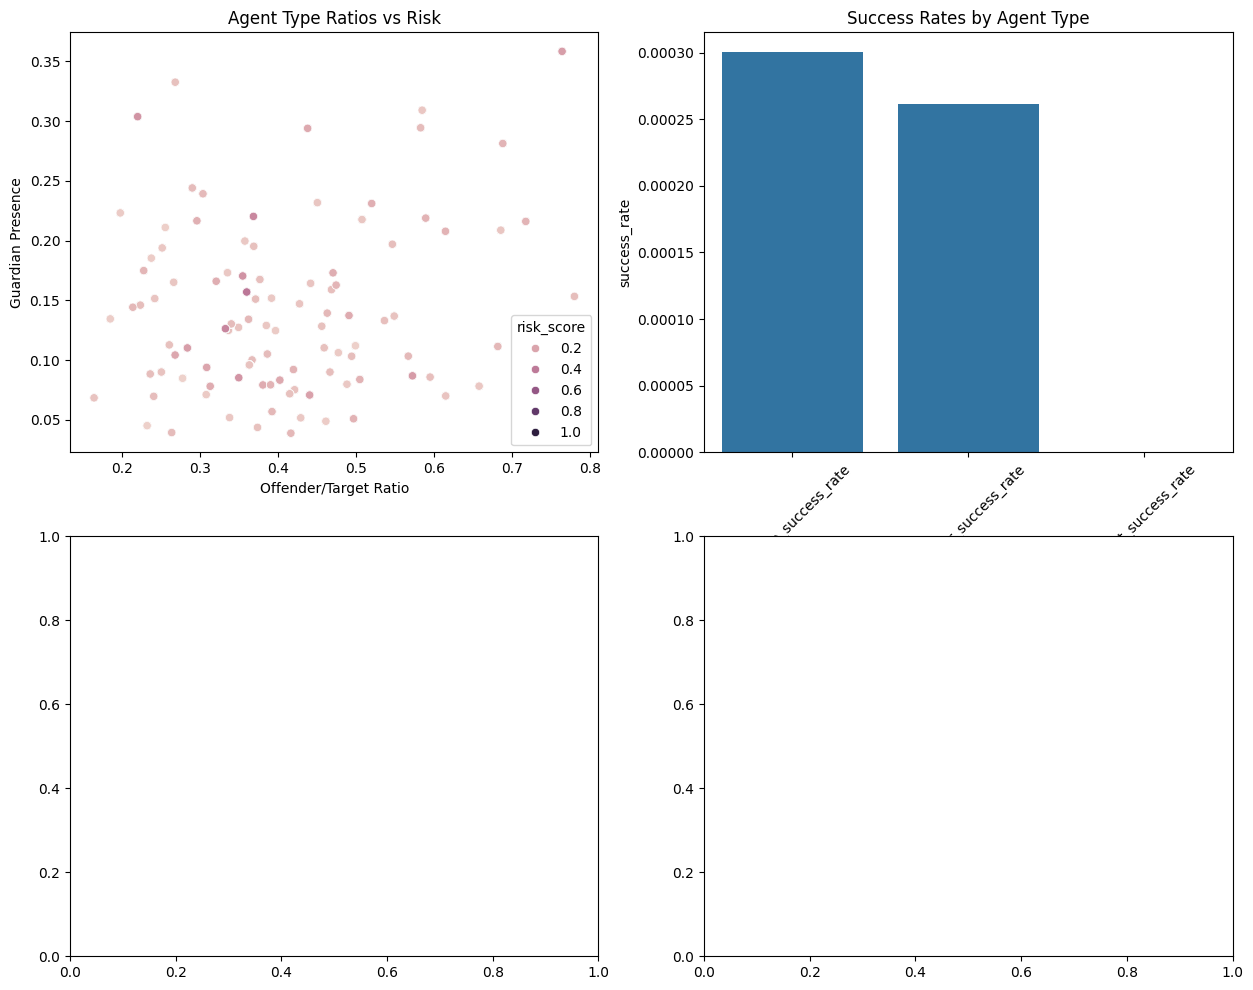

In [19]:
# Visualize agent patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Agent type ratios across grid
sns.scatterplot(data=data, x='offender_target_ratio', y='guardian_presence', 
                hue='risk_score', ax=axes[0,0])
axes[0,0].set_title('Agent Type Ratios vs Risk')
axes[0,0].set_xlabel('Offender/Target Ratio')
axes[0,0].set_ylabel('Guardian Presence')

# Success rates by agent type
success_cols = [col for col in data.columns if 'success_rate' in col]
success_data = data[success_cols].mean().reset_index()
success_data.columns = ['agent_type', 'success_rate']
sns.barplot(data=success_data, x='agent_type', y='success_rate', ax=axes[0,1])
axes[0,1].set_title('Success Rates by Agent Type')
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)

# Action type distribution
action_cols = [col for col in data.columns if col.startswith('action_')]
action_data = data[action_cols].mean().reset_index()
action_data.columns = ['action', 'proportion']
sns.barplot(data=action_data, x='action', y='proportion', ax=axes[1,0])
axes[1,0].set_title('Action Type Distribution')
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)

# Nearby agents distribution
nearby_data = pd.DataFrame({
    'Type': ['Offenders', 'Targets', 'Has Guardian'],
    'Average': [
        data['n_offenders_nearby'].mean(),
        data['n_targets_nearby'].mean(),
        data['has_guardian_nearby'].mean()
    ]
})
sns.barplot(data=nearby_data, x='Type', y='Average', ax=axes[1,1])
axes[1,1].set_title('Average Nearby Agents')

plt.tight_layout()
plt.show()

## 5. Event Aggregation Features
Calculate aggregated metrics and rolling statistics.

In [ ]:
def create_event_features(df):
    """Create event-based aggregation features."""
    # Rolling event counts
    # df['events_last_hour'] = ...
    
    # Success rates
    # df['crime_success_rate'] = ...
    
    # Risk scores
    # df['avg_risk_score'] = ...
    
    return df

# Apply event features
data = create_event_features(data)

## 6. Feature Selection and Export
Select final feature set and prepare for modeling.

In [ ]:
# List of features to keep
feature_cols = [
    # Basic features
    'timestamp', 'agent_type', 'risk_score',
    
    # Temporal features
    'hour', 'day_of_week', 'is_weekend', 'time_period',
    
    # Spatial features
    'grid_id', 'event_density',
    
    # Agent features
    'offender_target_ratio', 'guardian_presence',
    
    # Event features
    'events_last_hour', 'crime_success_rate', 'avg_risk_score'
]

# Select features and export
final_data = data[feature_cols]
final_data.to_csv('../../data/processed/engineered_features.csv', index=False)

print(f'Exported {len(final_data):,} rows with {len(feature_cols)} features')

## 7. Feature Analysis
Analyze the engineered features to verify their usefulness.

In [ ]:
# Basic feature statistics
print("Feature Statistics:")
print(final_data.describe())

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(final_data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()